# References

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install python-dotenv
# !pip install scipy
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install scikit-learn
# !pip install shap
# !pip install optuna

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import constants
import os
from dotenv import load_dotenv
import scipy.io as sp
import pprint as pp
from scipy.signal import welch
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torch.nn.utils.rnn import pad_sequence
import shap
import json
import optuna

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize, linewidth=300, suppress=True)
pd.set_option('display.max_colwidth', 500)

# Constants

In [3]:
# some calculations
# for the dataset, 10 seconds = 1280 frames. 1 second = 128 frames. We can sue this to find the number of seconds that were taken to record the signature.

recording_samp_rate = 128 # per second
per_phase_frames = 1280 # seconds
max_seq_len_for_data = 3000 # frames
# desampling_factor = 1 # reducing sequences by this size

# Fetching raw data (Sign + EEG)

## Processing raw files

In [ ]:
load_dotenv()
dataset_path = os.getenv('DATASET_PATH')

def get_dataset_files_and_user_ids(data_category, data_type = constants.TRAIN, task = constants.IDENTIFY):
    user_ids = []
    labels = []
    files_mat = []

    # Get training and testing data
    data_split = pd.read_csv(os.path.join(dataset_path, "Identification_split.csv" if task == constants.IDENTIFY else "Verification_split.csv"))
    data_categories = [constants.GENUINE, constants.FORGED] if data_category == constants.ALL else [data_category]
    files_for_task = list(data_split[data_split.set == data_type].filename)

    for root, dirs, files in os.walk(dataset_path):
        if os.path.basename(root) in data_categories:
            for file in files:
                if file.endswith('.mat') and file in files_for_task:
                    files_mat.append(os.path.join(root, file))
                    labels.append(os.path.basename(root))
        if os.path.basename(root) != constants.GENUINE and os.path.basename(root) != constants.FORGED and os.path.basename(root) != 'SignEEGv1.0':
            user_ids.append(os.path.basename(root))

    return files_mat, user_ids, labels

In [5]:
# small note: np.delete(axis = 1) will delete a column, axis = 0 will delete a row. be careful

## Getting list of sign data, eeg data and label for each file

In [6]:
def get_sig_eeg_raw_data(mat_files, labels, desampling_factor = 1):
    raw_data_list = []
    for mat_file, label in zip(mat_files, labels):
        mat_content = sp.loadmat(mat_file)
        user_id = str(mat_content['subject']['SubjectID'][0][0][0])
        sig_data = mat_content['subject']['SignWacom'][0][0]
        eeg_ica_data = mat_content['subject']['ICA_EEG'][0][0].T
        sig_data = torch.from_numpy(np.delete(sig_data, 0, axis=1)).to(dtype=torch.float32)

        # getting part of eeg data during which signature was recorded (ROI)
        roi_frames_start = -(eeg_ica_data.shape[0] % per_phase_frames) if per_phase_frames > 0 else 0
        eeg_ica_data = torch.from_numpy(eeg_ica_data[roi_frames_start:]).to(dtype=torch.float32)

        # desampling the data
        if desampling_factor > 1:
            sig_data = sig_data[::desampling_factor, :]
            eeg_ica_data = eeg_ica_data[::desampling_factor, :]

        if sig_data.shape[0] > max_seq_len_for_data:
            # print("Caught you!!!")
            # print("User ID: ", user_id)
            # print("File: ", mat_file)
            continue # Skip these files because it's too long, outlier
        raw_data_list.append({
            'sign_data': sig_data,
            'eeg_data': eeg_ica_data,
            'user_id': user_id,
            'label': 0 if label == constants.GENUINE else 1,
            'file': mat_file
        })

    return raw_data_list


# Augmenting data

In [7]:
def augment_sign_data(sign_data, noise_std=0.01, scale_range=(0.95, 1.05), rotation_deg=5):
    augmented = sign_data.clone()
    augmented[:, 2:] += torch.randn_like(augmented[:, 2:]) * noise_std
    scale = random.uniform(*scale_range)
    augmented[:, 2] *= scale
    augmented[:, 3] *= scale

    # Random rotation (x, y)
    theta = math.radians(random.uniform(-rotation_deg, rotation_deg))
    x = augmented[:, 2].clone()
    y = augmented[:, 3].clone()
    augmented[:, 2] = x * math.cos(theta) - y * math.sin(theta)
    augmented[:, 3] = x * math.sin(theta) + y * math.cos(theta)

    return augmented

def augment_eeg_data(eeg_data, noise_std=0.01, scale_range=(0.95, 1.05), time_shift_max=10):
    augmented = eeg_data.clone()
    augmented += torch.randn_like(augmented) * noise_std
    scale = random.uniform(*scale_range)
    augmented *= scale
    shift = random.randint(-time_shift_max, time_shift_max)
    if shift > 0:
        augmented = torch.cat([augmented[shift:], torch.zeros_like(augmented[:shift])], dim=0)
    elif shift < 0:
        augmented = torch.cat([torch.zeros_like(augmented[shift:]), augmented[:shift]], dim=0)

    return augmented

# Sign Data Classification Process

## Sign data preprocessing

In [8]:
def normalize_sign_data_dict(sign_data):

    mean = torch.mean(sign_data[:, 2:], dim=0)
    std = torch.std(sign_data[:, 2:], dim=0)
    std = torch.where(std == 0, torch.tensor(1.0, dtype=torch.float32), std)
    normalized = (sign_data[:, 2:] - mean) / std
    normalized = torch.cat([sign_data[:, 0:2], normalized], dim=1).to(dtype=torch.float32)
    return normalized


## Sign Data Feature Extraction

In [ ]:
def get_sign_data_features(sign_data):
    normalized_sign_data = normalize_sign_data_dict(sign_data)
    x = sign_data[:, 2]
    y = sign_data[:, 3]

    normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
    norm_x = normalized_sign_data[:, 2]
    norm_y = normalized_sign_data[:, 3]
    vx = torch.gradient(norm_x)[0]
    vy = torch.gradient(norm_y)[0]
    velocity = torch.sqrt(vx**2 + vy**2)
    ax = torch.gradient(vx)[0]
    ay = torch.gradient(vy)[0]
    acceleration = torch.sqrt(ax**2 + ay**2)

    avg_vx = torch.mean(vx)
    avg_vy = torch.mean(vy)
    avg_ax = torch.mean(ax)
    avg_ay = torch.mean(ay)

    # log curvature radius
    dt = 1
    dx = torch.gradient(norm_x, spacing=(dt,))[0]
    dy = torch.gradient(norm_y, spacing=(dt,))[0]
    v_t = torch.sqrt(dx ** 2 + dy ** 2)
    v_t = torch.where(v_t == 0, torch.tensor(1e-10, dtype=v_t.dtype), v_t)
    theta = torch.atan2(dy, dx)
    dtheta = torch.gradient(theta, spacing=(dt,))[0]
    dtheta = torch.where(dtheta == 0, torch.tensor(1e-10, dtype=dtheta.dtype), dtheta)
    log_curv_radius = torch.log(torch.abs(v_t / dtheta) + 1e-10)
    # print("Log Curve Radius shape: ", log_curv_radius.shape)
    # getting static features
    pendown_frames = normalized_sign_data[:, 1] == 1
    num_strokes = torch.unique(normalized_sign_data[pendown_frames][:, 0]).shape[0]
    x_down = normalized_sign_data[pendown_frames][:, 2]
    y_down = normalized_sign_data[pendown_frames][:, 3]
    sign_centroid = torch.tensor([torch.mean(x_down), torch.mean(y_down)], dtype=torch.float32)
    if y_down.shape[0] > 0:
        sign_height = torch.max(y_down) - torch.min(y_down)
    else:
        sign_height = 0
    if x_down.shape[0] > 0:
        sign_width = torch.max(x_down) - torch.min(x_down)
    else:
        sign_width = 0
    height_width_ratio = sign_height / sign_width if sign_width != 0 else torch.tensor(0.0, dtype=torch.float32)

    # new time dependent feature - jerk
    jerk = torch.sqrt(torch.gradient(vx)[0]**2 + torch.gradient(vy)[0]**2)

    pressure = sign_data[pendown_frames][:, 4]
    azimuth = sign_data[pendown_frames][:, 5]
    altitude = sign_data[pendown_frames][:, 6]
    avg_pressure = torch.mean(pressure)
    avg_azimuth = torch.mean(azimuth)
    avg_altitude = torch.mean(altitude)
    max_pressure = torch.max(pressure) if pressure.numel() > 0 else torch.tensor(0.0, dtype=torch.float32)
    sign_duration = sign_data.shape[0] / recording_samp_rate
    
    cls_token = torch.tensor([
        num_strokes, sign_height, sign_width, height_width_ratio, sign_centroid[0], sign_centroid[1], avg_pressure, avg_azimuth, avg_altitude, avg_vx, avg_vy, avg_ax, avg_ay, max_pressure, sign_duration], dtype=torch.float32)

    sign_data_aug = torch.cat([normalized_sign_data, velocity.unsqueeze(1), acceleration.unsqueeze(1), log_curv_radius.unsqueeze(1), jerk.unsqueeze(1)], dim=1)

    sign_data_aug = torch.nan_to_num(sign_data_aug)
    cls_token = torch.nan_to_num(cls_token)
    return sign_data_aug, cls_token

## Prepare dataset with attention tokens and padding

In [10]:
def attach_attention_tokens_and_padding(data, max_len):
    # print("EEG Data shape: ", data.shape)
    if data.shape[0] == 0:
        feat_dim = data.shape[1] if data.ndim == 2 else 1
        return torch.zeros((max_len, feat_dim), dtype=torch.float32), torch.zeros(max_len, dtype=torch.float32)
    seq_len, feat_dim = data.shape
    pad_width = (0, max_len - seq_len)
    padded_data = torch.nn.functional.pad(data, (0, 0, 0, pad_width[1]), mode='constant', value=0)
    attention_mask = torch.zeros(max_len + 1, dtype=torch.float32)
    attention_mask[:seq_len + 1] = 1  # +1 for cls_token
    return padded_data, attention_mask


## Single Modality Transformer Transformer

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len + 1, d_model)
        position = torch.arange(0, max_len + 1, dtype = torch.float).unsqueeze(1)
        divterm = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # Credits to hkproj@github for this as https://github.com/hkproj/pytorch-transformer/blob/main/model.py
        pe[:, 0::2] = torch.sin(position * divterm)
        pe[:, 1::2] = torch.cos(position * divterm)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.shape[1]]

In [11]:
class SignatureTransformer(nn.Module):
    def __init__(self, input_dim, cls_dim, d_model, num_classes, num_heads, num_layers, max_seq_len, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)
        self.cls_proj = nn.Linear(cls_dim, d_model)
        self.input_projection = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dropout = dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers = num_layers)
        # uncomment for single modality
        self.classifier = nn.Sequential(nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, num_classes))

    def forward(self, x_ts, cls_token, attn_mask = None):
        x_ts = torch.nan_to_num(x_ts, nan=0.0, posinf=0.0, neginf=0.0)
        cls_token = torch.nan_to_num(cls_token, nan=0.0, posinf=0.0, neginf=0.0)
        batch_size, t, feat_dim = x_ts.shape
        x_proj = self.input_projection(x_ts)
        cls_proj = self.cls_proj(cls_token).unsqueeze(1)
        # print("x_proj size: ", x_proj.shape)
        # print("cls_proj size: ", cls_proj.shape)
        x = torch.cat([cls_proj, x_proj], dim=1)
        # print("x_proj and cls_proj concatenated size: ", x.shape)
        x = x + self.positional_encoding(x)

        if attn_mask is not None:
            attn_mask = attn_mask == 0 # True = ignore the value, False = include it!!!!!!!!!!
            # cls_mask = torch.zeros((batch_size, 1), dtype=torch.bool, device=attn_mask.device)
            full_mask = torch.cat([attn_mask], dim=1)  # [batch_size, t+1]
        else:
            full_mask = None
        # print("Mask shape: ", full_mask.shape)
        x = self.transformer(x, src_key_padding_mask=full_mask)
        cls_output = x[:, 0, :]
        # uncomment for single modality transformer
        # logits = self.classifier(cls_output)
        # return logits

        # uncomment for multimodal transformer
        return cls_output

## EEG Data Preprocessing

In [1]:
def normalize_eeg_data_dict(eeg_data_dict):
    normalized_eeg_data_dict = {}
    for user_id, eeg_list in eeg_data_dict.items():
        normalized_eeg_data_dict[user_id] = []
        for eeg_data in eeg_list:
            mean = eeg_data.mean(dim=0, keepdim=True)
            std = eeg_data.std(dim=0, keepdim=True)
            std = torch.where(std == 0, torch.tensor(1.0, dtype=std.dtype, device=std.device), std)
            normalized = (eeg_data - mean) / std
            normalized_eeg_data_dict[user_id].append(normalized)
    return normalized_eeg_data_dict

## EEG Feature Extraction

In [13]:
def extract_fft_features(eeg_data, fs=128, epoch_length_sec=1): # taking 1s instead of 30s because the signal duration is short
    n_samples, n_channels = eeg_data.shape
    epoch_len = int(epoch_length_sec * fs)
    n_epochs = n_samples // epoch_len
    features = []
    for i in range(n_epochs):
        epoch = eeg_data[i*epoch_len:(i+1)*epoch_len, :]
        epoch_features = []
        for ch in range(n_channels):
            fft_vals = np.fft.rfft(epoch[:, ch])
            fft_power = np.abs(fft_vals)
            epoch_features.extend(np.abs(fft_vals).flatten())
        features.append(epoch_features)
    return features

In [14]:
def get_nth_difference_mean_for_signal(input_signal, n):
    input_signal = torch.as_tensor(input_signal)
    diff = torch.abs(input_signal[n:] - input_signal[:-n])
    res = torch.sum(diff) / (input_signal.shape[0] - n)
    return res

def normalize_for_eeg_related_data(data):
    data = torch.as_tensor(data, dtype=torch.float32)
    mean = torch.mean(data, dim=0)
    std = torch.std(data, dim=0)
    std = torch.where(std == 0, torch.tensor(1.0, dtype=std.dtype, device=std.device), std)
    norm = (data - mean) / std
    return norm

def get_eeg_data_features(eeg_data, fs=recording_samp_rate):

    signal_mean = torch.mean(eeg_data)
    signal_std = torch.std(eeg_data)

    first_difference_sample_mean_absolute_difference_raw_signal = get_nth_difference_mean_for_signal(eeg_data, 1)
    second_difference_sample_mean_absolute_difference_raw_signal = get_nth_difference_mean_for_signal(eeg_data, 2)

    normalized_signal = normalize_for_eeg_related_data(eeg_data)
    first_difference_sample_mean_absolute_difference_normalized_signal = get_nth_difference_mean_for_signal(normalized_signal, 1)
    second_difference_sample_mean_absolute_difference_normalized_signal = get_nth_difference_mean_for_signal(normalized_signal, 2)
    fw_powers = []
    eeg_data = torch.as_tensor(eeg_data, dtype=torch.float32)
    for ch in range(normalized_signal.shape[1]):
        # Welch returns numpy arrays, so convert to torch
        f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
        f = torch.from_numpy(f).to(normalized_signal.device)
        Pxx = torch.from_numpy(Pxx).to(normalized_signal.device)
        fw_power = torch.sum(f * Pxx) / torch.sum(Pxx) if torch.sum(Pxx) > 0 else torch.tensor(0.0, device=normalized_signal.device)
        fw_powers.append(fw_power)
    fw_power_arr = torch.stack(fw_powers).unsqueeze(0)
    # cls_token = torch.cat([signal_mean, signal_std, first_difference_sample_mean_absolute_difference_raw_signal, second_difference_sample_mean_absolute_difference_raw_signal, first_difference_sample_mean_absolute_difference_normalized_signal, second_difference_sample_mean_absolute_difference_normalized_signal])
    # cls_token = torch.stack(fw_power_arr)
    fft_features = extract_fft_features(normalized_signal.cpu().numpy(), fs=fs) # because we are using np.fft.rfft

    # this was before feature ranking, un-comment if feature ranking didn't help
    features = []
    features.extend([signal_mean, signal_std, first_difference_sample_mean_absolute_difference_raw_signal, second_difference_sample_mean_absolute_difference_raw_signal, first_difference_sample_mean_absolute_difference_normalized_signal, second_difference_sample_mean_absolute_difference_normalized_signal])
    # for epoch_feat in fft_features:
    #     features.extend(epoch_feat)
    features.extend(fw_power_arr.squeeze(0).tolist())

    # this is after after feature ranking
    # features = []
    # features.extend([signal_mean, signal_std, first_difference_sample_mean_absolute_difference_raw_signal, second_difference_sample_mean_absolute_difference_raw_signal])
    # features.extend(fw_power_arr.squeeze(0).tolist()[2:])

    cls_token = torch.tensor(features, dtype=torch.float32)
    # uncomment if fft_features as eeg_data fails
    # return normalized_signal, cls_token
    fft_features = torch.tensor(fft_features, dtype=torch.float32)
    fft_features = torch.nan_to_num(fft_features, nan=0.0, posinf=0.0, neginf=0.0)
    return normalized_signal, fft_features, cls_token

# Sign + EEG Classification

## Getting the EEG and Sign data

In [ ]:
train_files, user_ids, train_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type = constants.TRAIN, task = constants.IDENTIFY)
test_files, _, test_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type=constants.TEST, task = constants.IDENTIFY)
val_files, _, val_labels = get_dataset_files_and_user_ids(data_category=constants.GENUINE, data_type=constants.VALIDATION)

print("Train files: ", len(train_files))
print("Test files: ", len(test_files))
print("Val files: ", len(val_files))

user_ids_master_list_path = os.getenv('USER_IDS_MASTER_LIST_PATH')

# user_id_to_num_map = {user_id: i for i, user_id in enumerate(set(user_ids))} # for debugging, just to check mismatches in user_id order

user_id_to_num_map = {}

user_ids_master_list_file = os.path.join(user_ids_master_list_path, "user_ids_master_list.json")
if not os.path.exists(user_ids_master_list_file):
    user_id_to_num_map = {user_id: i for i, user_id in enumerate(user_ids)}
    with open(user_ids_master_list_file, 'w') as f:
        json.dump(user_id_to_num_map, f)
else:
    with open(user_ids_master_list_file, 'r') as f:
        user_id_to_num_map = json.load(f)
    if isinstance(user_id_to_num_map, list):
        user_id_to_num_map = user_id_to_num_map[0]

raw_train_data = get_sig_eeg_raw_data(train_files, train_labels)
raw_test_data = get_sig_eeg_raw_data(test_files, test_labels)
raw_val_data = get_sig_eeg_raw_data(val_files, val_labels)

Train files:  583
Test files:  201
Val files:  187


In [ ]:
print(os.path.exists(os.path.join(user_ids_master_list_path, "user_ids_master_list.json")))

True


In [ ]:
print(user_id_to_num_map)

{'000000802810034': 0, '000140809082110': 1, '001810111230005': 2, '000000001941061': 3, '000000003150143': 4, '000000001046474': 5, '000000814510023': 6, '000000001045402': 7, '000000000200894': 8, '001810111230006': 9, '002008410100008': 10, '002008410100015': 11, '002008410100025': 12, '002008410100030': 13, '002008410100013': 14, '002008410100011': 15, '002008410100016': 16, '002008410100040': 17, '002008410100024': 18, '002008410100018': 19, '002108410100006': 20, '002108410100005': 21, '002108410100002': 22, '002008410100052': 23, '002108410100001': 24, '002008410100044': 25, '002008410300021': 26, '002008410100050': 27, '002008410100065': 28, '002108410100003': 29, '002108410100016': 30, '002108410100012': 31, '002108410100020': 32, '002108410100013': 33, '002108410100010': 34, '002108410100007': 35, '002108410100017': 36, '002108410100018': 37, '002108410100011': 38, '002108410100008': 39, '002108410100046': 40, '002108410100044': 41, '002108410100036': 42, '002108410100043': 4

## Processing Test and Train data

In [ ]:
# for debugging only
# print("EEG Data seq len: ", [data['eeg_data'].shape[0] for data in raw_data])

augmented_raw_data = []
num_augments = 10

for sample in raw_train_data:
    augmented_raw_data.append(sample)
    for _ in range(num_augments):
        aug_sample = sample.copy()
        aug_sample['sign_data'] = augment_sign_data(sample['sign_data'])
        aug_sample['eeg_data'] = augment_eeg_data(sample['eeg_data'])
        augmented_raw_data.append(aug_sample)

raw_train_data = augmented_raw_data
# shuffling to prevent overfitting
random.shuffle(raw_train_data)

counter = 0
for i in range(len(raw_train_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_train_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_train_data[i]['eeg_data'])
    # print("EEG Feature data shape: ", eeg_data_with_features.shape)
    raw_train_data[i]['sign_data'] = sign_data_with_features
    raw_train_data[i]['sign_cls_token'] = sign_cls_token
    raw_train_data[i]['eeg_data'] = eeg_data_with_features
    raw_train_data[i]['eeg_cls_token'] = eeg_cls_token
    if counter < 10:
        print("eeg cls token shape: ", eeg_cls_token.shape)
        counter = counter + 1
    raw_train_data[i]['user_id'] = user_id_to_num_map[raw_train_data[i]['user_id']]

for i in range(len(raw_test_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_test_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_test_data[i]['eeg_data'])
    raw_test_data[i]['sign_data'] = sign_data_with_features
    raw_test_data[i]['sign_cls_token'] = sign_cls_token
    raw_test_data[i]['eeg_data'] = eeg_data_with_features
    raw_test_data[i]['eeg_cls_token'] = eeg_cls_token
    raw_test_data[i]['user_id'] = user_id_to_num_map[raw_test_data[i]['user_id']]

# sign_max_seq_len = max([data['sign_data'].shape[0] for data in raw_data])
# eeg_max_seq_len = max([data['eeg_data'].shape[0] for data in raw_data])

sign_max_seq_len = max_seq_len_for_data
eeg_max_seq_len = 10

for i in range(len(raw_train_data)):
    sign_data = raw_train_data[i]['sign_data']
    eeg_data = raw_train_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_train_data[i]['sign_data'] = sign_data
    raw_train_data[i]['eeg_data'] = eeg_data
    raw_train_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_train_data[i]['eeg_attention_mask'] = eeg_attention_mask

for i in range(len(raw_test_data)):
    sign_data = raw_test_data[i]['sign_data']
    eeg_data = raw_test_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_test_data[i]['sign_data'] = sign_data
    raw_test_data[i]['eeg_data'] = eeg_data
    raw_test_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_test_data[i]['eeg_attention_mask'] = eeg_attention_mask

sign_train_data = [data['sign_data'] for data in raw_train_data]
eeg_train_data = [data['eeg_data'] for data in raw_train_data]
sign_train_attention_masks = [data['sign_attention_mask'] for data in raw_train_data]
eeg_train_attention_masks = [data['eeg_attention_mask'] for data in raw_train_data]
sign_train_cls_tokens = [data['sign_cls_token'] for data in raw_train_data]
eeg_train_cls_tokens = [data['eeg_cls_token'] for data in raw_train_data]
labels_train = [data['user_id'] for data in raw_train_data]
files_train = [data['file'] for data in raw_train_data]

sign_test_data = [data['sign_data'] for data in raw_test_data]
eeg_test_data = [data['eeg_data'] for data in raw_test_data]
sign_test_attention_masks = [data['sign_attention_mask'] for data in raw_test_data]
eeg_test_attention_masks = [data['eeg_attention_mask'] for data in raw_test_data]
sign_test_cls_tokens = [data['sign_cls_token'] for data in raw_test_data]
eeg_test_cls_tokens = [data['eeg_cls_token'] for data in raw_test_data]
labels_test = [data['user_id'] for data in raw_test_data]
files_test = [data['file'] for data in raw_test_data]

/tmp/ipython-input-2072833470.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
/tmp/ipython-input-4230723650.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 203, using nperseg = 203
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)


eeg cls token shape:  torch.Size([7])
eeg cls token shape:  torch.Size([7])
eeg cls token shape:  torch.Size([7])
eeg cls token shape:  torch.Size([7])
eeg cls token shape:  torch.Size([7])
eeg cls token shape:  torch.Size([7])
eeg cls token shape:  torch.Size([7])
eeg cls token shape:  torch.Size([7])
eeg cls token shape:  torch.Size([7])
eeg cls token shape:  torch.Size([7])


/tmp/ipython-input-4230723650.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 197, using nperseg = 197
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
/tmp/ipython-input-4230723650.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 136, using nperseg = 136
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)


## Just for debugging - data shapes

In [ ]:
print("Sign train data type: ", type(sign_train_data))
print("EEG train data type: ", type(eeg_train_data))
print("Sign train data type: ", type(sign_train_attention_masks[0]))
print("EEG train data type: ", type(eeg_train_attention_masks[0]))
print("Sign train cls tokens type: ", type(sign_train_cls_tokens[0]))
print("EEG train cls tokens type: ", type(eeg_train_cls_tokens[0]))

print("Sign train data shape: ", sign_train_data[0].shape)
print("EEG train data shape: ", eeg_train_data[0].shape)
print("Sign CLS token shape: ", sign_train_cls_tokens[0].shape)
print("EEG CLS token shape: ", eeg_train_cls_tokens[0].shape)
print("Sign train attention mask shape: ", sign_train_attention_masks[0].shape)
print("EEG train attention mask shape: ", eeg_train_attention_masks[0].shape)
print("Train labels length: ", len(labels_train))
print("Test labels length: ", len(labels_test))
print("Train labels: ", labels_train[:10])
print("Test labels: ", labels_test[:10])

Sign train data type:  <class 'list'>
EEG train data type:  <class 'list'>
Sign train data type:  <class 'torch.Tensor'>
EEG train data type:  <class 'torch.Tensor'>
Sign train cls tokens type:  <class 'torch.Tensor'>
EEG train cls tokens type:  <class 'torch.Tensor'>
Sign train data shape:  torch.Size([3000, 11])
EEG train data shape:  torch.Size([10, 325])
Sign CLS token shape:  torch.Size([3])
EEG CLS token shape:  torch.Size([7])
Sign train attention mask shape:  torch.Size([3001])
EEG train attention mask shape:  torch.Size([11])
Train labels length:  6402
Test labels length:  201
Train labels:  [43, 37, 25, 45, 51, 31, 64, 7, 59, 19]
Test labels:  [0, 0, 0, 1, 1, 1, 1, 2, 3, 3]


## Getting data shapes (for providing to transformer)

In [ ]:
sign_ts_dim = sign_train_data[0].size(1)
sign_cls_dim = sign_train_cls_tokens[0].size(0)
sign_seq_len = sign_train_data[0].size(0)
eeg_ts_dim = eeg_train_data[0].size(1)
eeg_cls_dim = eeg_train_cls_tokens[0].size(0)
eeg_seq_len = eeg_train_data[0].size(0)

## Redesigning the Transformer model implementation

In [15]:
class SignatureEEGDataset(Dataset):
    def __init__(self, input_data, num_classes):
        sign_data = input_data['sign_data']
        eeg_data = input_data['eeg_data']
        sign_attention_masks = input_data['sign_attention_masks']
        eeg_attention_masks = input_data['eeg_attention_masks']
        sign_cls_tokens = input_data['sign_cls_tokens']
        eeg_cls_tokens = input_data['eeg_cls_tokens']
        labels = input_data['labels']

        self.sign_x_ts = torch.nan_to_num(torch.stack(sign_data), nan=0.0, posinf=0.0, neginf=0.0)
        self.sign_cls_token = torch.nan_to_num(torch.stack(sign_cls_tokens), nan=0.0, posinf=0.0, neginf=0.0)
        self.sign_attention_mask = sign_attention_masks
        self.sign_seq_len = sign_data[0].shape[0]
        self.sign_ts_dim = sign_data[0].shape[1]

        self.eeg_x_ts = torch.nan_to_num(torch.stack(eeg_data), nan=0.0, posinf=0.0, neginf=0.0)
        self.eeg_cls_token = torch.nan_to_num(torch.stack(eeg_cls_tokens), nan=0.0, posinf=0.0, neginf=0.0)
        self.eeg_attention_mask = eeg_attention_masks
        self.eeg_seq_len = eeg_data[0].shape[0]
        self.eeg_ts_dim = eeg_data[0].shape[1]

        self.num_classes = num_classes
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'sign_x_ts': self.sign_x_ts[idx],
            'sign_cls_token': self.sign_cls_token[idx],
            'sign_attention_mask': self.sign_attention_mask[idx],
            'eeg_x_ts': self.eeg_x_ts[idx],
            'eeg_cls_token': self.eeg_cls_token[idx],
            'eeg_attention_mask': self.eeg_attention_mask[idx],
            'labels': self.labels[idx],
        }

In [17]:
class SignatureEEGTransformer(nn.Module):
    def __init__(self, sign_input_dim, sign_cls_dim, eeg_input_dim, eeg_cls_dim, d_model, num_classes, num_heads, num_layers, sign_max_seq_len, eeg_max_seq_len, dropout = 0.1):
        super().__init__()
        self.sign_transfomer = SignatureTransformer(sign_input_dim, sign_cls_dim, d_model, num_classes, num_heads, num_layers, sign_max_seq_len, dropout)
        self.eeg_transformer = SignatureTransformer(eeg_input_dim, eeg_cls_dim, d_model, num_classes, num_heads, num_layers, eeg_max_seq_len, dropout)

        self.classifier = nn.Sequential(nn.Linear(d_model * 2, d_model), nn.ReLU(), nn.Linear(d_model, num_classes))

    def forward(self, sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attn_mask = None, eeg_attn_mask = None):
        sign_cls = self.sign_transfomer(sign_x_ts, sign_cls_token, sign_attn_mask)
        eeg_cls = self.eeg_transformer(eeg_x_ts, eeg_cls_token, eeg_attn_mask)
        multimodal_cls_output = torch.cat([sign_cls, eeg_cls], dim = 1)

        logits = self.classifier(multimodal_cls_output)
        return logits

## Final data and dataset initialization

In [ ]:
num_classes = len(user_id_to_num_map.keys())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_input = {
    'sign_data': sign_train_data,
    'eeg_data': eeg_train_data,
    'sign_attention_masks': sign_train_attention_masks,
    'eeg_attention_masks': eeg_train_attention_masks,
    'sign_cls_tokens': sign_train_cls_tokens,
    'eeg_cls_tokens': eeg_train_cls_tokens,
    'labels': labels_train,
}

test_input = {
    'sign_data': sign_test_data,
    'eeg_data': eeg_test_data,
    'sign_attention_masks': sign_test_attention_masks,
    'eeg_attention_masks': eeg_test_attention_masks,
    'sign_cls_tokens': sign_test_cls_tokens,
    'eeg_cls_tokens': eeg_test_cls_tokens,
    'labels': labels_test,
}

train_dataset = SignatureEEGDataset(train_input, num_classes=num_classes)
val_dataset = SignatureEEGDataset(test_input, num_classes=num_classes)

## Checking for NaN after encountering 0 preds for all labels

In [ ]:
for tensor_list in [sign_train_data, eeg_train_data, sign_train_cls_tokens, eeg_train_cls_tokens, sign_test_data, eeg_test_data, sign_test_cls_tokens, eeg_test_cls_tokens]:
    for t in tensor_list:
        assert not torch.isnan(t).any(), "NaN in input data!"
        assert not torch.isinf(t).any(), "Inf in input data!"

In [ ]:
assert all(0 <= l < num_classes for l in labels_train)

## Parameter Fine tuning - automated using optuna

[I 2025-08-03 12:29:16,621] A new study created in memory with name: no-name-031a0273-2e44-41ad-a700-38ebb6b7187f


Parameters chosen for this trial: 
d_model:  128
num_layers:  3
num_heads:  4
dropout:  0.2619872485469237
learning rate:  1e-06
batch_szie:  32


Train labels:  [np.int64(64), np.int64(26), np.int64(42), np.int64(27), np.int64(24), np.int64(15), np.int64(25), np.int64(24), np.int64(63), np.int64(60)]
Pred labels:  [np.int64(40), np.int64(40), np.int64(55), np.int64(49), np.int64(19), np.int64(40), np.int64(40), np.int64(40), np.int64(40), np.int64(69)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(49), np.int64(49), np.int64(40), np.int64(40), np.int64(54), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(54)]
Epoch 1/10
Train Loss: 4.2979 | Train Acc: 0.0062
Val Loss: 4.2987 | Val Acc: 0.0050
Validation F1 Score: 0.0019


Train labels:  [np.int64(24), np.int64(16), np.int64(34), np.int64(23), np.int64(12), np.int64(69), np.int64(65), np.int64(67), np.int64(52), np.int64(19)]
Pred labels:  [np.int64(40), np.int64(16), np.int64(49), np.int64(54), np.int64(40), np.int64(3), np.int64(40), np.int64(69), np.int64(16), np.int64(40)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(49), np.int64(49), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15)]
Epoch 2/10
Train Loss: 4.2822 | Train Acc: 0.0078
Val Loss: 4.2897 | Val Acc: 0.0100
Validation F1 Score: 0.0022


Train labels:  [np.int64(12), np.int64(62), np.int64(2), np.int64(29), np.int64(11), np.int64(59), np.int64(55), np.int64(60), np.int64(13), np.int64(23)]
Pred labels:  [np.int64(40), np.int64(40), np.int64(40), np.int64(40), np.int64(40), np.int64(44), np.int64(69), np.int64(49), np.int64(49), np.int64(49)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(40), np.int64(49), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15)]
Epoch 3/10
Train Loss: 4.2705 | Train Acc: 0.0097
Val Loss: 4.2805 | Val Acc: 0.0199
Validation F1 Score: 0.0030


Train labels:  [np.int64(33), np.int64(43), np.int64(11), np.int64(45), np.int64(29), np.int64(40), np.int64(52), np.int64(13), np.int64(34), np.int64(3)]
Pred labels:  [np.int64(69), np.int64(69), np.int64(41), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(49), np.int64(49), np.int64(15)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(40), np.int64(15), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15)]
Epoch 4/10
Train Loss: 4.2619 | Train Acc: 0.0084
Val Loss: 4.2738 | Val Acc: 0.0299
Validation F1 Score: 0.0050


Train labels:  [np.int64(50), np.int64(27), np.int64(32), np.int64(51), np.int64(43), np.int64(65), np.int64(57), np.int64(13), np.int64(27), np.int64(16)]
Pred labels:  [np.int64(69), np.int64(40), np.int64(69), np.int64(49), np.int64(49), np.int64(40), np.int64(69), np.int64(8), np.int64(40), np.int64(40)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(40), np.int64(15), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15)]
Epoch 5/10
Train Loss: 4.2545 | Train Acc: 0.0102
Val Loss: 4.2676 | Val Acc: 0.0348
Validation F1 Score: 0.0057


Train labels:  [np.int64(37), np.int64(50), np.int64(4), np.int64(27), np.int64(60), np.int64(1), np.int64(69), np.int64(22), np.int64(2), np.int64(42)]
Pred labels:  [np.int64(15), np.int64(16), np.int64(69), np.int64(16), np.int64(40), np.int64(15), np.int64(69), np.int64(40), np.int64(40), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(15), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15), np.int64(69), np.int64(8), np.int64(15)]
Epoch 6/10
Train Loss: 4.2427 | Train Acc: 0.0181
Val Loss: 4.2629 | Val Acc: 0.0398
Validation F1 Score: 0.0069


Train labels:  [np.int64(14), np.int64(36), np.int64(34), np.int64(0), np.int64(46), np.int64(37), np.int64(21), np.int64(25), np.int64(10), np.int64(37)]
Pred labels:  [np.int64(41), np.int64(40), np.int64(8), np.int64(15), np.int64(49), np.int64(69), np.int64(69), np.int64(69), np.int64(8), np.int64(15)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(15), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15), np.int64(69), np.int64(8), np.int64(15)]
Epoch 7/10
Train Loss: 4.2372 | Train Acc: 0.0170
Val Loss: 4.2559 | Val Acc: 0.0448
Validation F1 Score: 0.0072


Train labels:  [np.int64(26), np.int64(34), np.int64(40), np.int64(50), np.int64(5), np.int64(56), np.int64(4), np.int64(45), np.int64(12), np.int64(21)]
Pred labels:  [np.int64(8), np.int64(52), np.int64(8), np.int64(15), np.int64(16), np.int64(69), np.int64(40), np.int64(54), np.int64(40), np.int64(69)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(15), np.int64(40), np.int64(40), np.int64(69), np.int64(40), np.int64(15), np.int64(69), np.int64(8), np.int64(15)]
Epoch 8/10
Train Loss: 4.2275 | Train Acc: 0.0197
Val Loss: 4.2516 | Val Acc: 0.0498
Validation F1 Score: 0.0142


Train labels:  [np.int64(8), np.int64(61), np.int64(59), np.int64(53), np.int64(53), np.int64(13), np.int64(30), np.int64(61), np.int64(53), np.int64(69)]
Pred labels:  [np.int64(41), np.int64(65), np.int64(8), np.int64(8), np.int64(69), np.int64(40), np.int64(12), np.int64(40), np.int64(69), np.int64(69)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(15), np.int64(40), np.int64(40), np.int64(8), np.int64(40), np.int64(15), np.int64(52), np.int64(8), np.int64(15)]
Epoch 9/10
Train Loss: 4.2219 | Train Acc: 0.0226
Val Loss: 4.2450 | Val Acc: 0.0547
Validation F1 Score: 0.0131


Train labels:  [np.int64(3), np.int64(52), np.int64(15), np.int64(26), np.int64(57), np.int64(14), np.int64(13), np.int64(22), np.int64(67), np.int64(30)]
Pred labels:  [np.int64(40), np.int64(15), np.int64(40), np.int64(15), np.int64(12), np.int64(54), np.int64(8), np.int64(8), np.int64(49), np.int64(69)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(15), np.int64(40), np.int64(40), np.int64(8), np.int64(15), np.int64(15), np.int64(52), np.int64(8), np.int64(15)]
Epoch 10/10
Train Loss: 4.2147 | Train Acc: 0.0237
Val Loss: 4.2392 | Val Acc: 0.0498
Validation F1 Score: 0.0111


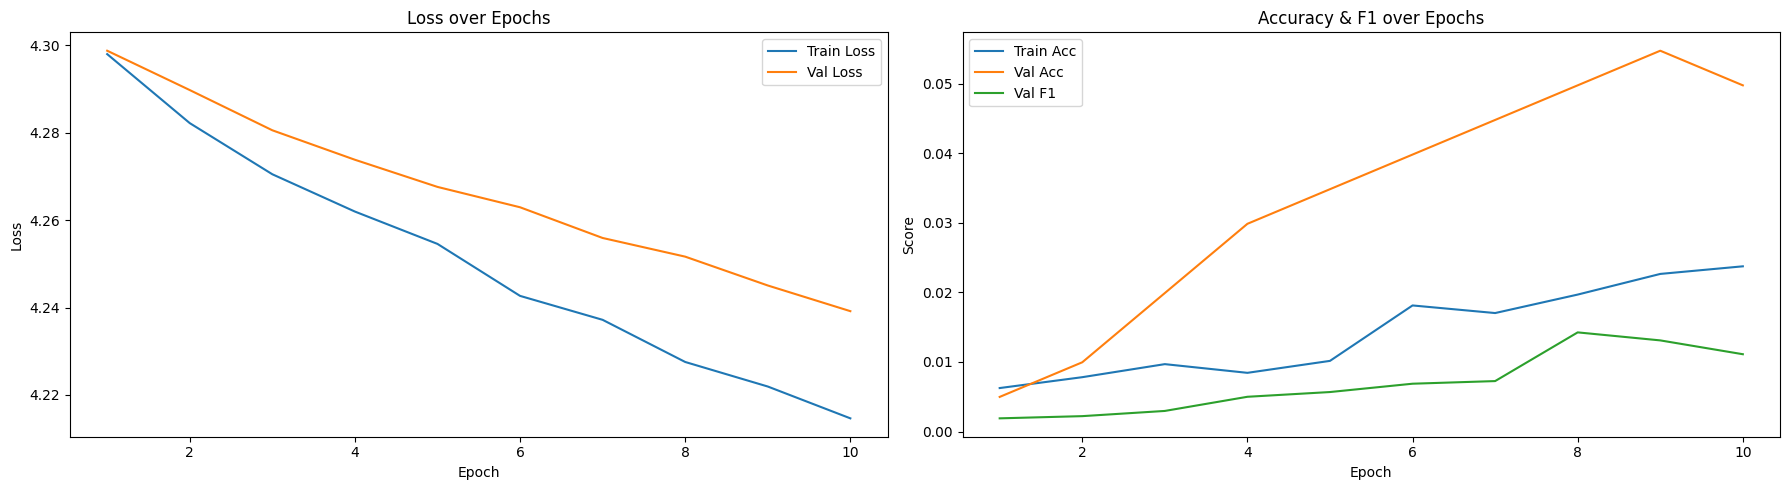

[I 2025-08-03 12:53:37,606] Trial 0 finished with values: [0.04975124378109453, 4.2391659727144, 0.011109461678953053] and parameters: {'d_model': 128, 'num_layers': 3, 'num_heads': 4, 'lr': 1e-06, 'batch_size': 32, 'dropout': 0.2619872485469237}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  3
num_heads:  4
dropout:  0.2619872485469237
learning rate:  1e-06
batch_szie:  32
num_epochs:  2
Parameters chosen for this trial: 
d_model:  64
num_layers:  5
num_heads:  4
dropout:  0.24384153866285602
learning rate:  0.0001
batch_szie:  16


Train labels:  [np.int64(64), np.int64(53), np.int64(19), np.int64(23), np.int64(46), np.int64(5), np.int64(2), np.int64(22), np.int64(68), np.int64(32)]
Pred labels:  [np.int64(63), np.int64(63), np.int64(63), np.int64(63), np.int64(63), np.int64(63), np.int64(46), np.int64(63), np.int64(63), np.int64(46)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(4), np.int64(62), np.int64(62), np.int64(59), np.int64(13), np.int64(62), np.int64(62), np.int64(46), np.int64(0), np.int64(31)]
Epoch 1/10
Train Loss: 4.0086 | Train Acc: 0.0825
Val Loss: 3.7950 | Val Acc: 0.0945
Validation F1 Score: 0.0495


Train labels:  [np.int64(23), np.int64(21), np.int64(28), np.int64(17), np.int64(54), np.int64(48), np.int64(44), np.int64(29), np.int64(46), np.int64(29)]
Pred labels:  [np.int64(14), np.int64(46), np.int64(59), np.int64(17), np.int64(45), np.int64(12), np.int64(68), np.int64(62), np.int64(46), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(66), np.int64(41), np.int64(62), np.int64(45), np.int64(15), np.int64(62), np.int64(45), np.int64(46), np.int64(24), np.int64(31)]
Epoch 2/10
Train Loss: 3.2726 | Train Acc: 0.3155
Val Loss: 3.1951 | Val Acc: 0.1791
Validation F1 Score: 0.1202


Train labels:  [np.int64(47), np.int64(69), np.int64(4), np.int64(44), np.int64(7), np.int64(50), np.int64(1), np.int64(62), np.int64(10), np.int64(9)]
Pred labels:  [np.int64(12), np.int64(65), np.int64(45), np.int64(44), np.int64(45), np.int64(46), np.int64(62), np.int64(62), np.int64(10), np.int64(66)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(66), np.int64(1), np.int64(0), np.int64(45), np.int64(25), np.int64(1), np.int64(1), np.int64(33), np.int64(24), np.int64(31)]
Epoch 3/10
Train Loss: 2.5446 | Train Acc: 0.5244
Val Loss: 2.6455 | Val Acc: 0.3582
Validation F1 Score: 0.3284


Train labels:  [np.int64(35), np.int64(12), np.int64(48), np.int64(25), np.int64(31), np.int64(43), np.int64(20), np.int64(3), np.int64(15), np.int64(61)]
Pred labels:  [np.int64(35), np.int64(44), np.int64(48), np.int64(25), np.int64(24), np.int64(46), np.int64(20), np.int64(24), np.int64(66), np.int64(15)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(51), np.int64(0), np.int64(0), np.int64(1), np.int64(15), np.int64(1), np.int64(1), np.int64(33), np.int64(24), np.int64(31)]
Epoch 4/10
Train Loss: 1.8376 | Train Acc: 0.7174
Val Loss: 2.1111 | Val Acc: 0.4925
Validation F1 Score: 0.4608


Train labels:  [np.int64(66), np.int64(42), np.int64(5), np.int64(59), np.int64(52), np.int64(48), np.int64(44), np.int64(31), np.int64(64), np.int64(67)]
Pred labels:  [np.int64(66), np.int64(6), np.int64(5), np.int64(59), np.int64(52), np.int64(48), np.int64(44), np.int64(31), np.int64(64), np.int64(67)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(16), np.int64(0), np.int64(0), np.int64(63), np.int64(15), np.int64(5), np.int64(1), np.int64(2), np.int64(3), np.int64(31)]
Epoch 5/10
Train Loss: 1.1599 | Train Acc: 0.8613
Val Loss: 1.5513 | Val Acc: 0.6070
Validation F1 Score: 0.5875


Train labels:  [np.int64(68), np.int64(9), np.int64(57), np.int64(3), np.int64(24), np.int64(46), np.int64(63), np.int64(47), np.int64(32), np.int64(13)]
Pred labels:  [np.int64(68), np.int64(5), np.int64(57), np.int64(3), np.int64(24), np.int64(46), np.int64(68), np.int64(47), np.int64(33), np.int64(13)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(45), np.int64(35), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(31)]
Epoch 6/10
Train Loss: 0.6868 | Train Acc: 0.9397
Val Loss: 1.3871 | Val Acc: 0.6517
Validation F1 Score: 0.6379


Train labels:  [np.int64(16), np.int64(7), np.int64(27), np.int64(51), np.int64(4), np.int64(24), np.int64(23), np.int64(21), np.int64(52), np.int64(67)]
Pred labels:  [np.int64(16), np.int64(7), np.int64(17), np.int64(51), np.int64(4), np.int64(24), np.int64(23), np.int64(21), np.int64(52), np.int64(67)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(35), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 7/10
Train Loss: 0.4269 | Train Acc: 0.9697
Val Loss: 1.0878 | Val Acc: 0.7463
Validation F1 Score: 0.7306


Train labels:  [np.int64(13), np.int64(10), np.int64(61), np.int64(10), np.int64(16), np.int64(0), np.int64(14), np.int64(15), np.int64(45), np.int64(4)]
Pred labels:  [np.int64(13), np.int64(10), np.int64(61), np.int64(10), np.int64(16), np.int64(0), np.int64(14), np.int64(15), np.int64(45), np.int64(4)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(35), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 8/10
Train Loss: 0.2207 | Train Acc: 0.9911
Val Loss: 0.9414 | Val Acc: 0.7662
Validation F1 Score: 0.7548


Train labels:  [np.int64(7), np.int64(22), np.int64(5), np.int64(30), np.int64(32), np.int64(6), np.int64(25), np.int64(17), np.int64(8), np.int64(54)]
Pred labels:  [np.int64(7), np.int64(22), np.int64(5), np.int64(30), np.int64(67), np.int64(6), np.int64(25), np.int64(17), np.int64(8), np.int64(54)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(35), np.int64(5), np.int64(1), np.int64(2), np.int64(3), np.int64(31)]
Epoch 9/10
Train Loss: 0.1110 | Train Acc: 0.9966
Val Loss: 0.9315 | Val Acc: 0.7662
Validation F1 Score: 0.7516


Train labels:  [np.int64(42), np.int64(43), np.int64(25), np.int64(12), np.int64(10), np.int64(17), np.int64(13), np.int64(45), np.int64(12), np.int64(59)]
Pred labels:  [np.int64(42), np.int64(43), np.int64(25), np.int64(12), np.int64(10), np.int64(17), np.int64(13), np.int64(45), np.int64(12), np.int64(59)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(9), np.int64(35), np.int64(5), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 10/10
Train Loss: 0.0525 | Train Acc: 0.9989
Val Loss: 0.7618 | Val Acc: 0.8159
Validation F1 Score: 0.8079


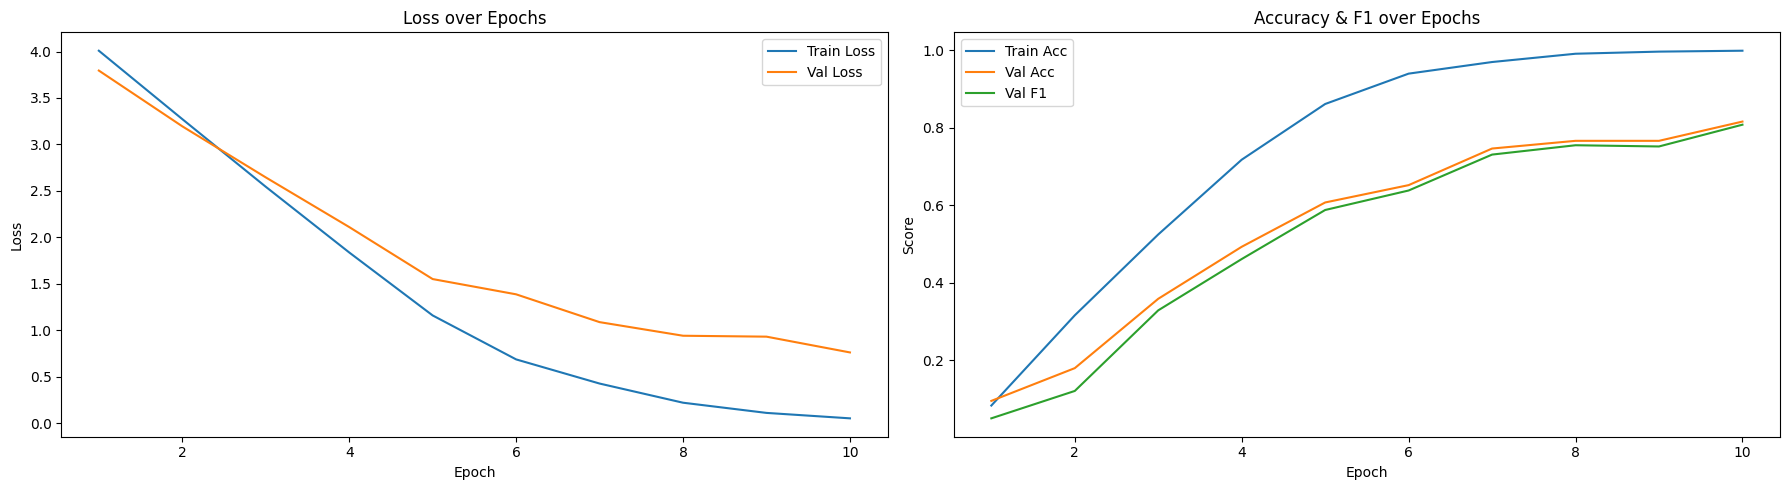

[I 2025-08-03 13:28:49,812] Trial 1 finished with values: [0.8159203980099502, 0.7617643703868733, 0.8078604093529466] and parameters: {'d_model': 64, 'num_layers': 5, 'num_heads': 4, 'lr': 0.0001, 'batch_size': 16, 'dropout': 0.24384153866285602}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  5
num_heads:  4
dropout:  0.24384153866285602
learning rate:  0.0001
batch_szie:  16
num_epochs:  2
Parameters chosen for this trial: 
d_model:  64
num_layers:  7
num_heads:  8
dropout:  0.29101718517089814
learning rate:  1e-06
batch_szie:  32


Train labels:  [np.int64(5), np.int64(28), np.int64(25), np.int64(56), np.int64(60), np.int64(28), np.int64(16), np.int64(20), np.int64(56), np.int64(31)]
Pred labels:  [np.int64(12), np.int64(1), np.int64(17), np.int64(68), np.int64(12), np.int64(1), np.int64(1), np.int64(68), np.int64(12), np.int64(14)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(12), np.int64(12), np.int64(12), np.int64(1), np.int64(1), np.int64(12), np.int64(12), np.int64(1), np.int64(12), np.int64(1)]
Epoch 1/10
Train Loss: 4.2608 | Train Acc: 0.0203
Val Loss: 4.2542 | Val Acc: 0.0199
Validation F1 Score: 0.0041


Train labels:  [np.int64(17), np.int64(47), np.int64(51), np.int64(64), np.int64(32), np.int64(16), np.int64(2), np.int64(8), np.int64(59), np.int64(64)]
Pred labels:  [np.int64(44), np.int64(68), np.int64(68), np.int64(12), np.int64(12), np.int64(14), np.int64(12), np.int64(14), np.int64(68), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(12), np.int64(12), np.int64(12), np.int64(12), np.int64(1), np.int64(12), np.int64(12), np.int64(1), np.int64(12), np.int64(1)]
Epoch 2/10
Train Loss: 4.2474 | Train Acc: 0.0226
Val Loss: 4.2437 | Val Acc: 0.0149
Validation F1 Score: 0.0035


Train labels:  [np.int64(14), np.int64(16), np.int64(23), np.int64(10), np.int64(12), np.int64(57), np.int64(20), np.int64(45), np.int64(62), np.int64(4)]
Pred labels:  [np.int64(14), np.int64(12), np.int64(14), np.int64(68), np.int64(14), np.int64(68), np.int64(12), np.int64(68), np.int64(12), np.int64(2)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(12), np.int64(12), np.int64(12), np.int64(12), np.int64(1), np.int64(12), np.int64(12), np.int64(1), np.int64(12), np.int64(1)]
Epoch 3/10
Train Loss: 4.2343 | Train Acc: 0.0194
Val Loss: 4.2382 | Val Acc: 0.0199
Validation F1 Score: 0.0048


Train labels:  [np.int64(68), np.int64(69), np.int64(19), np.int64(16), np.int64(40), np.int64(0), np.int64(37), np.int64(21), np.int64(3), np.int64(1)]
Pred labels:  [np.int64(68), np.int64(12), np.int64(56), np.int64(12), np.int64(56), np.int64(68), np.int64(56), np.int64(56), np.int64(68), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(12), np.int64(12), np.int64(12), np.int64(12), np.int64(56), np.int64(12), np.int64(12), np.int64(68), np.int64(12), np.int64(68)]
Epoch 4/10
Train Loss: 4.2250 | Train Acc: 0.0212
Val Loss: 4.2303 | Val Acc: 0.0149
Validation F1 Score: 0.0020


Train labels:  [np.int64(2), np.int64(14), np.int64(16), np.int64(53), np.int64(48), np.int64(29), np.int64(66), np.int64(31), np.int64(34), np.int64(35)]
Pred labels:  [np.int64(14), np.int64(25), np.int64(68), np.int64(56), np.int64(14), np.int64(68), np.int64(62), np.int64(68), np.int64(14), np.int64(37)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(12), np.int64(68), np.int64(25), np.int64(37), np.int64(12), np.int64(12), np.int64(37), np.int64(25), np.int64(68)]
Epoch 5/10
Train Loss: 4.2158 | Train Acc: 0.0211
Val Loss: 4.2233 | Val Acc: 0.0199
Validation F1 Score: 0.0032


Train labels:  [np.int64(22), np.int64(51), np.int64(21), np.int64(35), np.int64(36), np.int64(55), np.int64(25), np.int64(30), np.int64(26), np.int64(53)]
Pred labels:  [np.int64(68), np.int64(68), np.int64(17), np.int64(62), np.int64(37), np.int64(67), np.int64(62), np.int64(62), np.int64(56), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(0), np.int64(68), np.int64(25), np.int64(37), np.int64(12), np.int64(12), np.int64(37), np.int64(25), np.int64(68)]
Epoch 6/10
Train Loss: 4.2056 | Train Acc: 0.0283
Val Loss: 4.2175 | Val Acc: 0.0199
Validation F1 Score: 0.0075


Train labels:  [np.int64(41), np.int64(1), np.int64(59), np.int64(29), np.int64(9), np.int64(5), np.int64(7), np.int64(65), np.int64(68), np.int64(47)]
Pred labels:  [np.int64(68), np.int64(12), np.int64(12), np.int64(12), np.int64(68), np.int64(62), np.int64(37), np.int64(12), np.int64(25), np.int64(37)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(37), np.int64(68), np.int64(25), np.int64(37), np.int64(12), np.int64(12), np.int64(37), np.int64(25), np.int64(68)]
Epoch 7/10
Train Loss: 4.1966 | Train Acc: 0.0284
Val Loss: 4.2133 | Val Acc: 0.0149
Validation F1 Score: 0.0016


Train labels:  [np.int64(67), np.int64(67), np.int64(36), np.int64(64), np.int64(64), np.int64(21), np.int64(67), np.int64(23), np.int64(5), np.int64(67)]
Pred labels:  [np.int64(37), np.int64(37), np.int64(12), np.int64(12), np.int64(37), np.int64(37), np.int64(14), np.int64(12), np.int64(12), np.int64(37)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(68), np.int64(62), np.int64(37), np.int64(62), np.int64(12), np.int64(37), np.int64(7), np.int64(1)]
Epoch 8/10
Train Loss: 4.1851 | Train Acc: 0.0316
Val Loss: 4.2060 | Val Acc: 0.0149
Validation F1 Score: 0.0018


Train labels:  [np.int64(36), np.int64(33), np.int64(61), np.int64(2), np.int64(54), np.int64(43), np.int64(44), np.int64(46), np.int64(11), np.int64(10)]
Pred labels:  [np.int64(67), np.int64(67), np.int64(62), np.int64(8), np.int64(25), np.int64(68), np.int64(14), np.int64(62), np.int64(37), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(37), np.int64(62), np.int64(62), np.int64(37), np.int64(7), np.int64(68)]
Epoch 9/10
Train Loss: 4.1764 | Train Acc: 0.0314
Val Loss: 4.1975 | Val Acc: 0.0149
Validation F1 Score: 0.0013


Train labels:  [np.int64(45), np.int64(44), np.int64(67), np.int64(12), np.int64(62), np.int64(69), np.int64(6), np.int64(56), np.int64(2), np.int64(36)]
Pred labels:  [np.int64(37), np.int64(37), np.int64(37), np.int64(37), np.int64(12), np.int64(67), np.int64(25), np.int64(62), np.int64(56), np.int64(37)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(37), np.int64(62), np.int64(62), np.int64(37), np.int64(7), np.int64(1)]
Epoch 10/10
Train Loss: 4.1645 | Train Acc: 0.0358
Val Loss: 4.1918 | Val Acc: 0.0149
Validation F1 Score: 0.0014


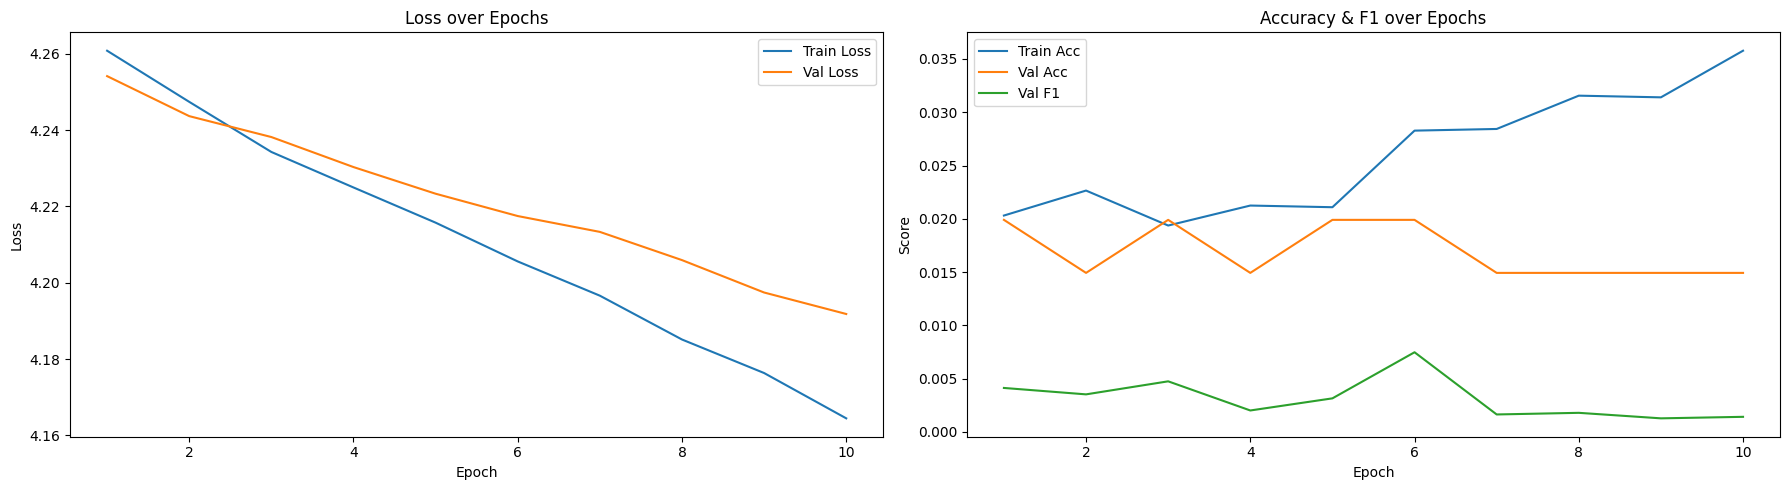

[I 2025-08-03 14:48:41,802] Trial 2 finished with values: [0.014925373134328358, 4.191830760803982, 0.0014214641080312722] and parameters: {'d_model': 64, 'num_layers': 7, 'num_heads': 8, 'lr': 1e-06, 'batch_size': 32, 'dropout': 0.29101718517089814}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  7
num_heads:  8
dropout:  0.29101718517089814
learning rate:  1e-06
batch_szie:  32
num_epochs:  2
Parameters chosen for this trial: 
d_model:  64
num_layers:  4
num_heads:  4
dropout:  0.1503588161159102
learning rate:  0.0001
batch_szie:  32


Train labels:  [np.int64(10), np.int64(53), np.int64(33), np.int64(51), np.int64(13), np.int64(57), np.int64(69), np.int64(54), np.int64(2), np.int64(14)]
Pred labels:  [np.int64(31), np.int64(18), np.int64(10), np.int64(18), np.int64(68), np.int64(68), np.int64(18), np.int64(7), np.int64(18), np.int64(31)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(51), np.int64(31), np.int64(0), np.int64(0), np.int64(3), np.int64(31), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 1/10
Train Loss: 3.9223 | Train Acc: 0.1189
Val Loss: 3.7268 | Val Acc: 0.1542
Validation F1 Score: 0.1198


Train labels:  [np.int64(40), np.int64(32), np.int64(14), np.int64(31), np.int64(2), np.int64(65), np.int64(31), np.int64(65), np.int64(37), np.int64(22)]
Pred labels:  [np.int64(3), np.int64(37), np.int64(14), np.int64(31), np.int64(0), np.int64(65), np.int64(31), np.int64(65), np.int64(37), np.int64(24)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(66), np.int64(31), np.int64(0), np.int64(45), np.int64(8), np.int64(31), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 2/10
Train Loss: 3.2753 | Train Acc: 0.3832
Val Loss: 3.3124 | Val Acc: 0.2090
Validation F1 Score: 0.1645


Train labels:  [np.int64(57), np.int64(46), np.int64(20), np.int64(5), np.int64(12), np.int64(50), np.int64(3), np.int64(13), np.int64(42), np.int64(57)]
Pred labels:  [np.int64(46), np.int64(46), np.int64(68), np.int64(31), np.int64(12), np.int64(50), np.int64(3), np.int64(6), np.int64(68), np.int64(46)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(31), np.int64(0), np.int64(31), np.int64(33), np.int64(31), np.int64(1), np.int64(37), np.int64(31), np.int64(3)]
Epoch 3/10
Train Loss: 2.7010 | Train Acc: 0.5258
Val Loss: 2.8835 | Val Acc: 0.3483
Validation F1 Score: 0.3050


Train labels:  [np.int64(33), np.int64(66), np.int64(21), np.int64(19), np.int64(25), np.int64(4), np.int64(47), np.int64(68), np.int64(54), np.int64(12)]
Pred labels:  [np.int64(33), np.int64(66), np.int64(21), np.int64(5), np.int64(25), np.int64(51), np.int64(48), np.int64(6), np.int64(54), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(66), np.int64(51), np.int64(0), np.int64(45), np.int64(11), np.int64(0), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 4/10
Train Loss: 2.1640 | Train Acc: 0.6493
Val Loss: 2.5040 | Val Acc: 0.4229
Validation F1 Score: 0.3984


Train labels:  [np.int64(1), np.int64(37), np.int64(68), np.int64(23), np.int64(31), np.int64(1), np.int64(66), np.int64(3), np.int64(25), np.int64(41)]
Pred labels:  [np.int64(1), np.int64(37), np.int64(68), np.int64(23), np.int64(31), np.int64(5), np.int64(66), np.int64(31), np.int64(25), np.int64(41)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(0), np.int64(8), np.int64(31), np.int64(1), np.int64(37), np.int64(3), np.int64(3)]
Epoch 5/10
Train Loss: 1.6861 | Train Acc: 0.7685
Val Loss: 2.1754 | Val Acc: 0.4876
Validation F1 Score: 0.4637


Train labels:  [np.int64(2), np.int64(21), np.int64(56), np.int64(25), np.int64(64), np.int64(65), np.int64(43), np.int64(45), np.int64(23), np.int64(41)]
Pred labels:  [np.int64(2), np.int64(21), np.int64(56), np.int64(25), np.int64(26), np.int64(65), np.int64(43), np.int64(45), np.int64(23), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(0), np.int64(63), np.int64(0), np.int64(1), np.int64(37), np.int64(31), np.int64(3)]
Epoch 6/10
Train Loss: 1.2809 | Train Acc: 0.8511
Val Loss: 1.9286 | Val Acc: 0.5224
Validation F1 Score: 0.5052


Train labels:  [np.int64(36), np.int64(32), np.int64(67), np.int64(56), np.int64(37), np.int64(15), np.int64(21), np.int64(22), np.int64(7), np.int64(36)]
Pred labels:  [np.int64(36), np.int64(32), np.int64(67), np.int64(56), np.int64(37), np.int64(15), np.int64(21), np.int64(22), np.int64(7), np.int64(47)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(56), np.int64(0), np.int64(9), np.int64(33), np.int64(0), np.int64(1), np.int64(37), np.int64(3), np.int64(3)]
Epoch 7/10
Train Loss: 0.9713 | Train Acc: 0.9028
Val Loss: 1.8196 | Val Acc: 0.5522
Validation F1 Score: 0.5360


Train labels:  [np.int64(64), np.int64(67), np.int64(40), np.int64(69), np.int64(1), np.int64(13), np.int64(8), np.int64(23), np.int64(5), np.int64(47)]
Pred labels:  [np.int64(64), np.int64(67), np.int64(40), np.int64(69), np.int64(1), np.int64(60), np.int64(8), np.int64(23), np.int64(5), np.int64(47)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(56), np.int64(0), np.int64(9), np.int64(63), np.int64(0), np.int64(1), np.int64(37), np.int64(3), np.int64(3)]
Epoch 8/10
Train Loss: 0.8394 | Train Acc: 0.9231
Val Loss: 1.6903 | Val Acc: 0.5871
Validation F1 Score: 0.5762


Train labels:  [np.int64(2), np.int64(15), np.int64(44), np.int64(67), np.int64(52), np.int64(59), np.int64(59), np.int64(5), np.int64(15), np.int64(45)]
Pred labels:  [np.int64(65), np.int64(15), np.int64(44), np.int64(67), np.int64(52), np.int64(59), np.int64(59), np.int64(5), np.int64(29), np.int64(45)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(63), np.int64(0), np.int64(1), np.int64(37), np.int64(31), np.int64(3)]
Epoch 9/10
Train Loss: 0.6773 | Train Acc: 0.9449
Val Loss: 1.5791 | Val Acc: 0.6119
Validation F1 Score: 0.5936


Train labels:  [np.int64(15), np.int64(48), np.int64(12), np.int64(59), np.int64(43), np.int64(7), np.int64(23), np.int64(28), np.int64(19), np.int64(27)]
Pred labels:  [np.int64(15), np.int64(48), np.int64(12), np.int64(59), np.int64(43), np.int64(7), np.int64(23), np.int64(28), np.int64(19), np.int64(27)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(56), np.int64(0), np.int64(9), np.int64(63), np.int64(0), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 10/10
Train Loss: 0.4512 | Train Acc: 0.9717
Val Loss: 1.4371 | Val Acc: 0.6119
Validation F1 Score: 0.5964


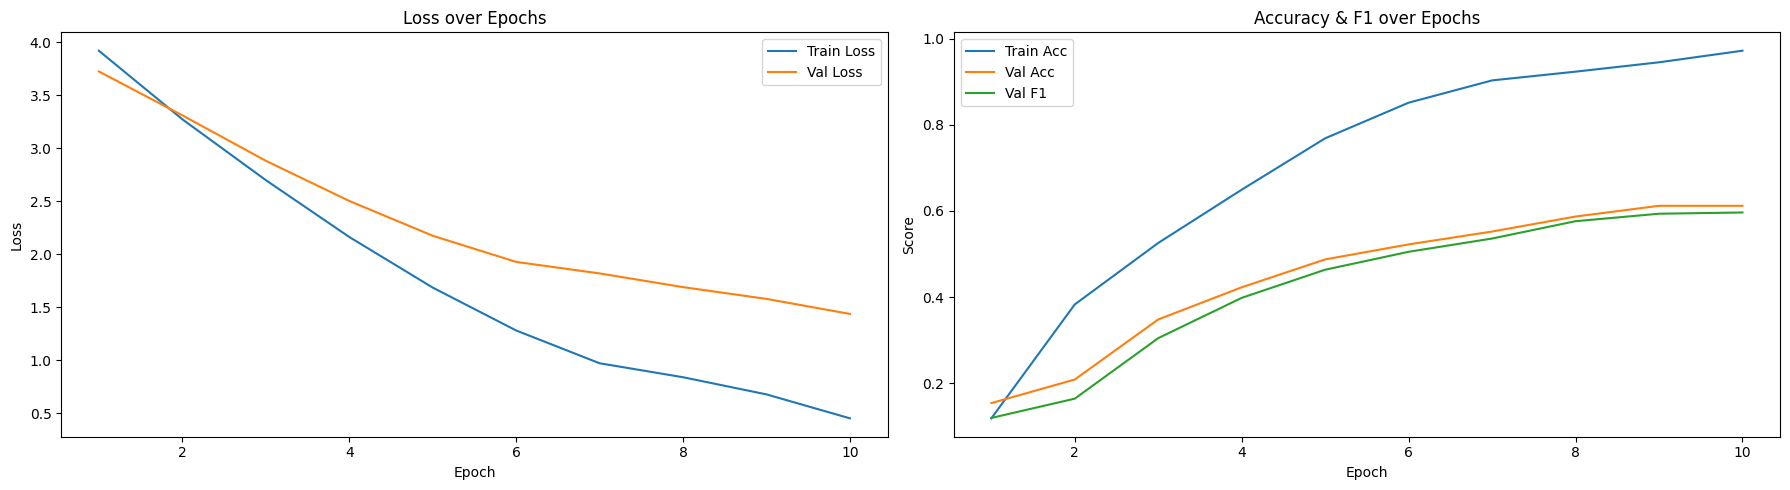

[I 2025-08-03 15:16:51,034] Trial 3 finished with values: [0.6119402985074627, 1.437082510682481, 0.5964350740470142] and parameters: {'d_model': 64, 'num_layers': 4, 'num_heads': 4, 'lr': 0.0001, 'batch_size': 32, 'dropout': 0.1503588161159102}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  4
num_heads:  4
dropout:  0.1503588161159102
learning rate:  0.0001
batch_szie:  32
num_epochs:  2
Parameters chosen for this trial: 
d_model:  128
num_layers:  2
num_heads:  4
dropout:  0.18709039296202318
learning rate:  1e-06
batch_szie:  16


Train labels:  [np.int64(23), np.int64(64), np.int64(46), np.int64(55), np.int64(23), np.int64(65), np.int64(69), np.int64(67), np.int64(31), np.int64(0)]
Pred labels:  [np.int64(30), np.int64(30), np.int64(30), np.int64(30), np.int64(30), np.int64(30), np.int64(30), np.int64(30), np.int64(30), np.int64(19)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(30), np.int64(19), np.int64(30), np.int64(19), np.int64(30), np.int64(30), np.int64(19), np.int64(19), np.int64(30), np.int64(30)]
Epoch 1/10
Train Loss: 4.2895 | Train Acc: 0.0067
Val Loss: 4.2695 | Val Acc: 0.0100
Validation F1 Score: 0.0008


Train labels:  [np.int64(63), np.int64(12), np.int64(52), np.int64(67), np.int64(6), np.int64(8), np.int64(69), np.int64(11), np.int64(57), np.int64(10)]
Pred labels:  [np.int64(30), np.int64(14), np.int64(19), np.int64(30), np.int64(26), np.int64(30), np.int64(30), np.int64(30), np.int64(30), np.int64(19)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(30), np.int64(19), np.int64(30), np.int64(19), np.int64(30), np.int64(30), np.int64(19), np.int64(19), np.int64(30), np.int64(30)]
Epoch 2/10
Train Loss: 4.2776 | Train Acc: 0.0072
Val Loss: 4.2595 | Val Acc: 0.0100
Validation F1 Score: 0.0008


Train labels:  [np.int64(66), np.int64(23), np.int64(23), np.int64(40), np.int64(45), np.int64(42), np.int64(67), np.int64(46), np.int64(65), np.int64(37)]
Pred labels:  [np.int64(30), np.int64(30), np.int64(30), np.int64(26), np.int64(30), np.int64(52), np.int64(26), np.int64(19), np.int64(19), np.int64(14)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(19), np.int64(19), np.int64(30), np.int64(19), np.int64(30), np.int64(30), np.int64(26), np.int64(19), np.int64(14), np.int64(19)]
Epoch 3/10
Train Loss: 4.2648 | Train Acc: 0.0081
Val Loss: 4.2501 | Val Acc: 0.0000
Validation F1 Score: 0.0000


Train labels:  [np.int64(22), np.int64(9), np.int64(22), np.int64(60), np.int64(57), np.int64(6), np.int64(46), np.int64(53), np.int64(37), np.int64(37)]
Pred labels:  [np.int64(30), np.int64(26), np.int64(19), np.int64(30), np.int64(26), np.int64(30), np.int64(30), np.int64(36), np.int64(19), np.int64(19)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(19), np.int64(19), np.int64(62), np.int64(45), np.int64(26), np.int64(26), np.int64(26), np.int64(19), np.int64(41), np.int64(19)]
Epoch 4/10
Train Loss: 4.2537 | Train Acc: 0.0075
Val Loss: 4.2405 | Val Acc: 0.0050
Validation F1 Score: 0.0043


Train labels:  [np.int64(21), np.int64(62), np.int64(9), np.int64(30), np.int64(44), np.int64(68), np.int64(3), np.int64(69), np.int64(64), np.int64(16)]
Pred labels:  [np.int64(30), np.int64(30), np.int64(19), np.int64(62), np.int64(26), np.int64(30), np.int64(62), np.int64(62), np.int64(19), np.int64(30)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(45), np.int64(26), np.int64(62), np.int64(26), np.int64(19), np.int64(41), np.int64(62)]
Epoch 5/10
Train Loss: 4.2423 | Train Acc: 0.0109
Val Loss: 4.2340 | Val Acc: 0.0050
Validation F1 Score: 0.0037


Train labels:  [np.int64(48), np.int64(35), np.int64(2), np.int64(2), np.int64(14), np.int64(5), np.int64(50), np.int64(29), np.int64(20), np.int64(19)]
Pred labels:  [np.int64(41), np.int64(60), np.int64(26), np.int64(62), np.int64(62), np.int64(62), np.int64(60), np.int64(62), np.int64(30), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(45), np.int64(26), np.int64(62), np.int64(26), np.int64(19), np.int64(41), np.int64(62)]
Epoch 6/10
Train Loss: 4.2335 | Train Acc: 0.0141
Val Loss: 4.2271 | Val Acc: 0.0050
Validation F1 Score: 0.0033


Train labels:  [np.int64(29), np.int64(10), np.int64(31), np.int64(0), np.int64(52), np.int64(14), np.int64(62), np.int64(9), np.int64(24), np.int64(62)]
Pred labels:  [np.int64(62), np.int64(30), np.int64(62), np.int64(62), np.int64(62), np.int64(36), np.int64(30), np.int64(26), np.int64(62), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(45), np.int64(26), np.int64(62), np.int64(26), np.int64(19), np.int64(41), np.int64(62)]
Epoch 7/10
Train Loss: 4.2252 | Train Acc: 0.0181
Val Loss: 4.2223 | Val Acc: 0.0050
Validation F1 Score: 0.0037


Train labels:  [np.int64(6), np.int64(19), np.int64(8), np.int64(56), np.int64(37), np.int64(52), np.int64(22), np.int64(45), np.int64(29), np.int64(20)]
Pred labels:  [np.int64(26), np.int64(62), np.int64(62), np.int64(19), np.int64(5), np.int64(62), np.int64(62), np.int64(26), np.int64(61), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(26), np.int64(26), np.int64(62), np.int64(26), np.int64(62), np.int64(41), np.int64(62)]
Epoch 8/10
Train Loss: 4.2187 | Train Acc: 0.0195
Val Loss: 4.2161 | Val Acc: 0.0050
Validation F1 Score: 0.0037


Train labels:  [np.int64(46), np.int64(51), np.int64(64), np.int64(47), np.int64(6), np.int64(6), np.int64(9), np.int64(42), np.int64(64), np.int64(48)]
Pred labels:  [np.int64(26), np.int64(14), np.int64(62), np.int64(19), np.int64(26), np.int64(20), np.int64(26), np.int64(26), np.int64(26), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(45), np.int64(62), np.int64(62), np.int64(26), np.int64(62), np.int64(41), np.int64(62)]
Epoch 9/10
Train Loss: 4.2126 | Train Acc: 0.0222
Val Loss: 4.2106 | Val Acc: 0.0050
Validation F1 Score: 0.0043


Train labels:  [np.int64(10), np.int64(3), np.int64(51), np.int64(23), np.int64(61), np.int64(44), np.int64(52), np.int64(30), np.int64(22), np.int64(36)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(61), np.int64(19), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(36)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(45), np.int64(62), np.int64(62), np.int64(26), np.int64(62), np.int64(41), np.int64(62)]
Epoch 10/10
Train Loss: 4.2062 | Train Acc: 0.0247
Val Loss: 4.2053 | Val Acc: 0.0050
Validation F1 Score: 0.0043


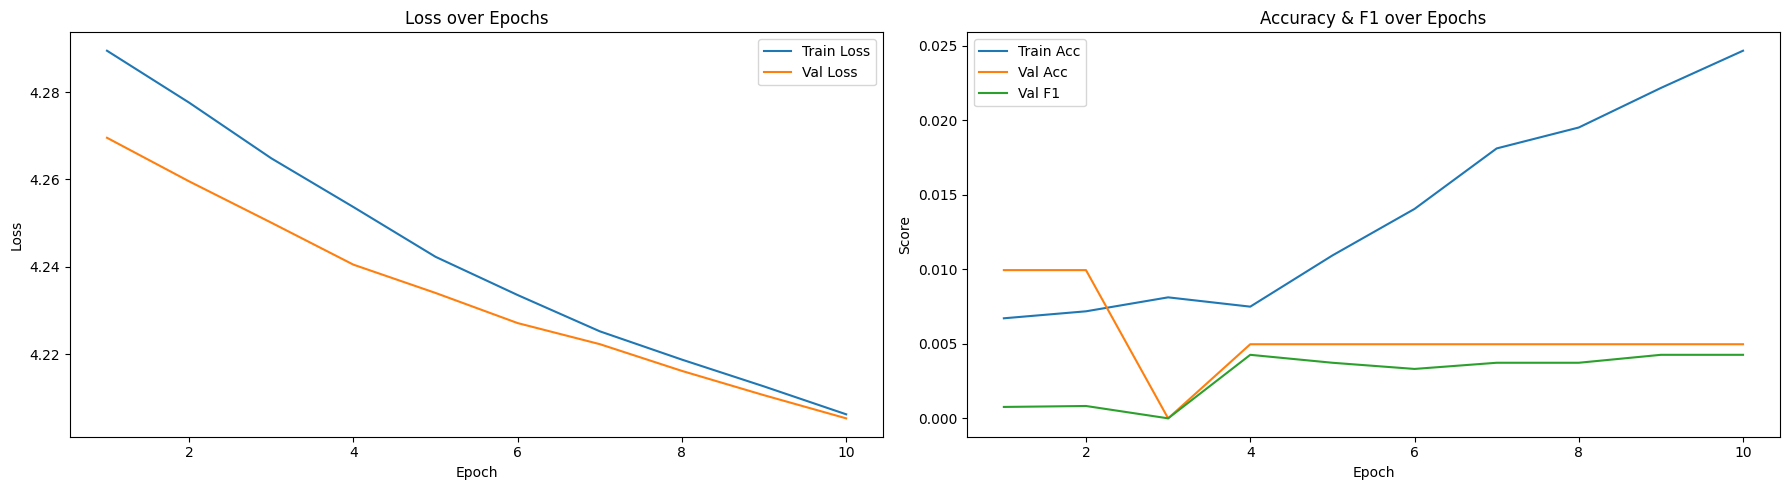

[I 2025-08-03 15:33:10,309] Trial 4 finished with values: [0.004975124378109453, 4.2052801023075235, 0.0042643923240938165] and parameters: {'d_model': 128, 'num_layers': 2, 'num_heads': 4, 'lr': 1e-06, 'batch_size': 16, 'dropout': 0.18709039296202318}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  2
num_heads:  4
dropout:  0.18709039296202318
learning rate:  1e-06
batch_szie:  16
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  8
num_heads:  4
dropout:  0.15504081656159052
learning rate:  0.0001
batch_szie:  8


Train labels:  [np.int64(5), np.int64(57), np.int64(53), np.int64(43), np.int64(61), np.int64(14), np.int64(4), np.int64(28), np.int64(51), np.int64(26)]
Pred labels:  [np.int64(23), np.int64(30), np.int64(59), np.int64(59), np.int64(23), np.int64(23), np.int64(23), np.int64(59), np.int64(61), np.int64(61)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 1/10
Train Loss: nan | Train Acc: 0.2919
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(61), np.int64(42), np.int64(30), np.int64(37), np.int64(31), np.int64(13), np.int64(45), np.int64(62), np.int64(52), np.int64(14)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 2/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(67), np.int64(51), np.int64(15), np.int64(62), np.int64(17), np.int64(13), np.int64(29), np.int64(63), np.int64(24), np.int64(19)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 3/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004
Model may be overfitting, time to early stop: 


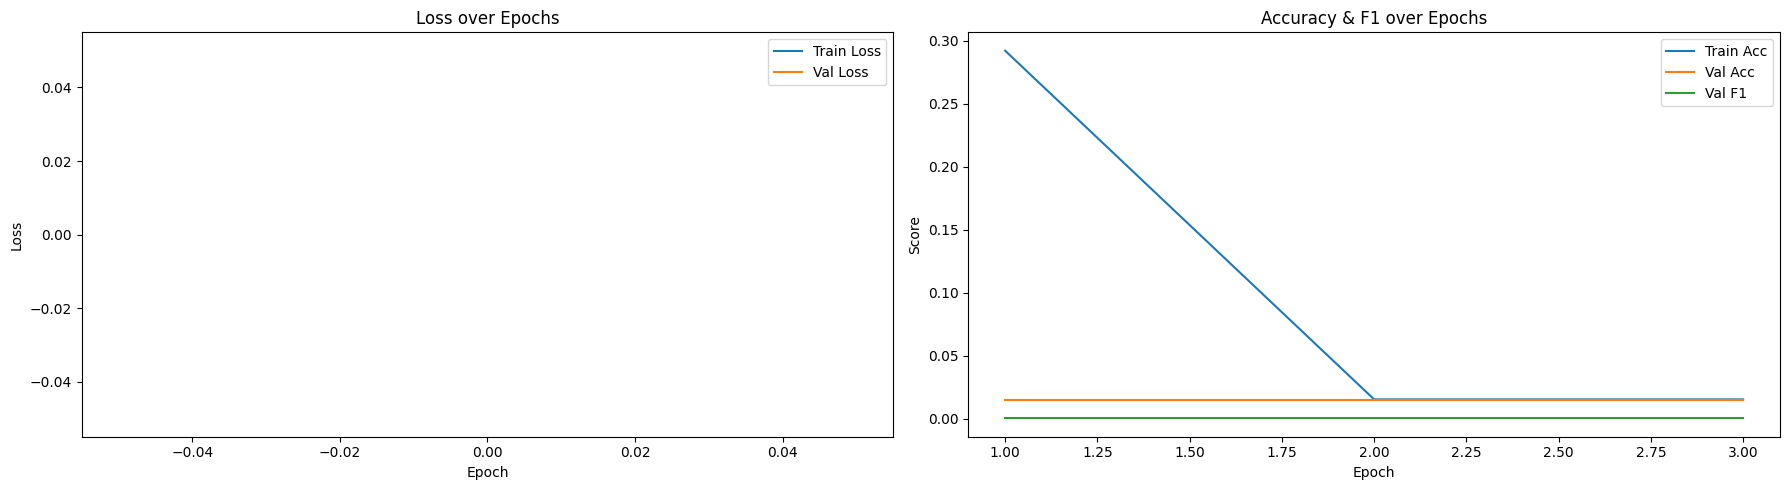

[W 2025-08-03 15:58:42,832] Trial 5 failed with parameters: {'d_model': 256, 'num_layers': 8, 'num_heads': 4, 'lr': 0.0001, 'batch_size': 8, 'dropout': 0.15504081656159052} because of the following error: The value nan is not acceptable.
[W 2025-08-03 15:58:42,833] Trial 5 failed with value (0.014925373134328358, nan, 0.0004389815627743634).


Parameters chosen for this trial: 
d_model:  256
num_layers:  8
num_heads:  4
dropout:  0.15504081656159052
learning rate:  0.0001
batch_szie:  8
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  7
num_heads:  8
dropout:  0.27133205686588213
learning rate:  1e-05
batch_szie:  16


Train labels:  [np.int64(20), np.int64(43), np.int64(45), np.int64(64), np.int64(14), np.int64(45), np.int64(37), np.int64(7), np.int64(11), np.int64(62)]
Pred labels:  [np.int64(46), np.int64(64), np.int64(59), np.int64(62), np.int64(64), np.int64(59), np.int64(62), np.int64(62), np.int64(64), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(50), np.int64(62), np.int64(50), np.int64(45), np.int64(45), np.int64(62), np.int64(62), np.int64(23), np.int64(31), np.int64(31)]
Epoch 1/10
Train Loss: 4.1017 | Train Acc: 0.0623
Val Loss: 3.9536 | Val Acc: 0.0896
Validation F1 Score: 0.0686


Train labels:  [np.int64(40), np.int64(5), np.int64(64), np.int64(1), np.int64(9), np.int64(0), np.int64(25), np.int64(19), np.int64(68), np.int64(37)]
Pred labels:  [np.int64(23), np.int64(62), np.int64(62), np.int64(62), np.int64(10), np.int64(62), np.int64(33), np.int64(62), np.int64(42), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(62), np.int64(0), np.int64(45), np.int64(10), np.int64(5), np.int64(5), np.int64(2), np.int64(31), np.int64(31)]
Epoch 2/10
Train Loss: 3.7372 | Train Acc: 0.1776
Val Loss: 3.7070 | Val Acc: 0.1642
Validation F1 Score: 0.1117


Train labels:  [np.int64(17), np.int64(55), np.int64(66), np.int64(41), np.int64(54), np.int64(69), np.int64(25), np.int64(23), np.int64(32), np.int64(36)]
Pred labels:  [np.int64(46), np.int64(23), np.int64(31), np.int64(62), np.int64(50), np.int64(2), np.int64(45), np.int64(23), np.int64(32), np.int64(65)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(50), np.int64(50), np.int64(50), np.int64(45), np.int64(40), np.int64(41), np.int64(64), np.int64(2), np.int64(31), np.int64(31)]
Epoch 3/10
Train Loss: 3.5222 | Train Acc: 0.2291
Val Loss: 3.5425 | Val Acc: 0.1990
Validation F1 Score: 0.1347


Train labels:  [np.int64(11), np.int64(5), np.int64(66), np.int64(37), np.int64(34), np.int64(32), np.int64(6), np.int64(13), np.int64(35), np.int64(53)]
Pred labels:  [np.int64(45), np.int64(5), np.int64(1), np.int64(37), np.int64(62), np.int64(37), np.int64(54), np.int64(45), np.int64(45), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(62), np.int64(0), np.int64(45), np.int64(63), np.int64(0), np.int64(52), np.int64(23), np.int64(31), np.int64(31)]
Epoch 4/10
Train Loss: 3.3851 | Train Acc: 0.2541
Val Loss: 3.4964 | Val Acc: 0.1592
Validation F1 Score: 0.0987


Train labels:  [np.int64(41), np.int64(37), np.int64(33), np.int64(35), np.int64(41), np.int64(45), np.int64(68), np.int64(6), np.int64(64), np.int64(24)]
Pred labels:  [np.int64(46), np.int64(37), np.int64(37), np.int64(45), np.int64(62), np.int64(62), np.int64(62), np.int64(59), np.int64(29), np.int64(24)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(50), np.int64(0), np.int64(0), np.int64(45), np.int64(68), np.int64(0), np.int64(52), np.int64(44), np.int64(31), np.int64(31)]
Epoch 5/10
Train Loss: 3.2312 | Train Acc: 0.3191
Val Loss: 3.3494 | Val Acc: 0.2040
Validation F1 Score: 0.1527


Train labels:  [np.int64(43), np.int64(54), np.int64(48), np.int64(50), np.int64(6), np.int64(4), np.int64(15), np.int64(48), np.int64(24), np.int64(26)]
Pred labels:  [np.int64(50), np.int64(54), np.int64(37), np.int64(17), np.int64(45), np.int64(50), np.int64(15), np.int64(37), np.int64(2), np.int64(26)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(56), np.int64(0), np.int64(45), np.int64(25), np.int64(0), np.int64(19), np.int64(14), np.int64(31), np.int64(31)]
Epoch 6/10
Train Loss: 3.0907 | Train Acc: 0.3724
Val Loss: 3.2309 | Val Acc: 0.2388
Validation F1 Score: 0.1873


Train labels:  [np.int64(57), np.int64(16), np.int64(50), np.int64(37), np.int64(44), np.int64(9), np.int64(26), np.int64(3), np.int64(32), np.int64(16)]
Pred labels:  [np.int64(46), np.int64(62), np.int64(50), np.int64(37), np.int64(44), np.int64(59), np.int64(26), np.int64(31), np.int64(36), np.int64(63)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(45), np.int64(68), np.int64(0), np.int64(19), np.int64(23), np.int64(31), np.int64(31)]
Epoch 7/10
Train Loss: 2.9629 | Train Acc: 0.4128
Val Loss: 3.1198 | Val Acc: 0.2587
Validation F1 Score: 0.1972


Train labels:  [np.int64(33), np.int64(68), np.int64(61), np.int64(52), np.int64(31), np.int64(15), np.int64(0), np.int64(54), np.int64(1), np.int64(13)]
Pred labels:  [np.int64(33), np.int64(68), np.int64(31), np.int64(5), np.int64(31), np.int64(15), np.int64(0), np.int64(54), np.int64(64), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(56), np.int64(0), np.int64(45), np.int64(25), np.int64(0), np.int64(19), np.int64(67), np.int64(31), np.int64(31)]
Epoch 8/10
Train Loss: 2.8240 | Train Acc: 0.4442
Val Loss: 2.9939 | Val Acc: 0.3085
Validation F1 Score: 0.2508


Train labels:  [np.int64(51), np.int64(67), np.int64(0), np.int64(6), np.int64(31), np.int64(10), np.int64(63), np.int64(54), np.int64(61), np.int64(54)]
Pred labels:  [np.int64(0), np.int64(67), np.int64(0), np.int64(50), np.int64(31), np.int64(10), np.int64(25), np.int64(54), np.int64(61), np.int64(51)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(56), np.int64(0), np.int64(45), np.int64(25), np.int64(0), np.int64(19), np.int64(2), np.int64(31), np.int64(31)]
Epoch 9/10
Train Loss: 2.6539 | Train Acc: 0.5125
Val Loss: 2.8825 | Val Acc: 0.3085
Validation F1 Score: 0.2507


Train labels:  [np.int64(37), np.int64(11), np.int64(34), np.int64(20), np.int64(22), np.int64(14), np.int64(3), np.int64(16), np.int64(35), np.int64(61)]
Pred labels:  [np.int64(37), np.int64(63), np.int64(62), np.int64(20), np.int64(22), np.int64(14), np.int64(31), np.int64(50), np.int64(35), np.int64(61)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(45), np.int64(25), np.int64(0), np.int64(19), np.int64(67), np.int64(31), np.int64(31)]
Epoch 10/10
Train Loss: 2.4996 | Train Acc: 0.5484
Val Loss: 2.7555 | Val Acc: 0.3582
Validation F1 Score: 0.2898


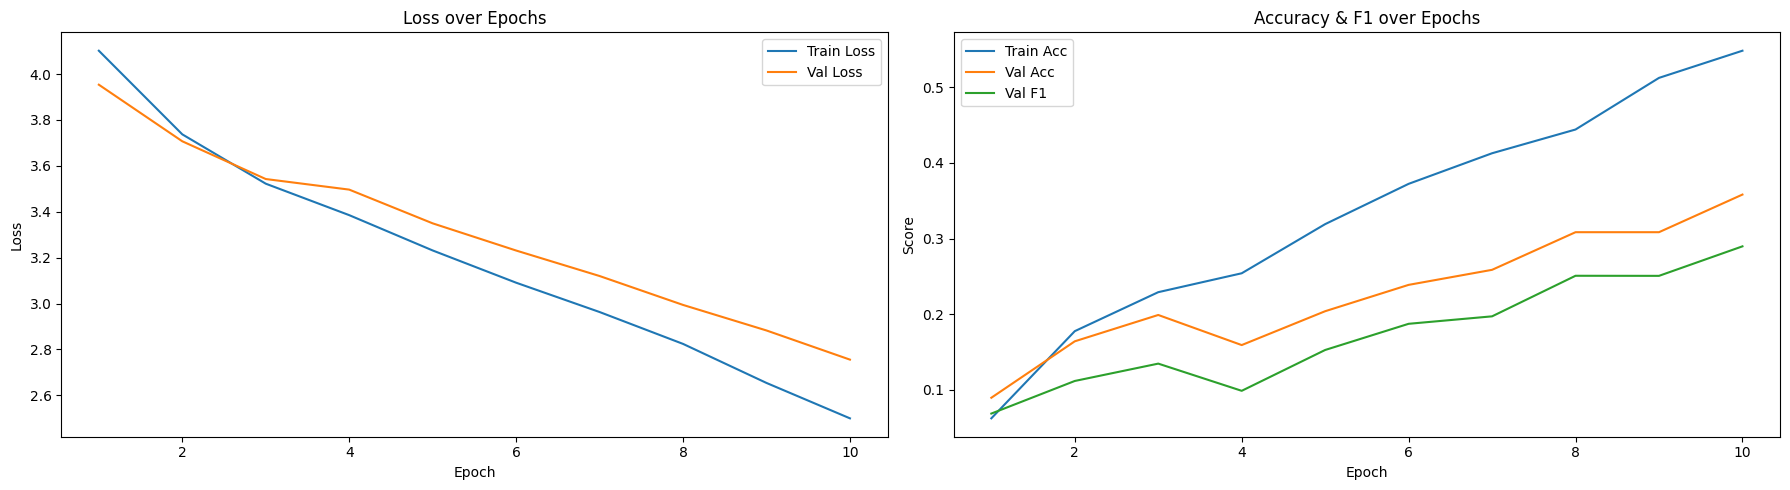

[I 2025-08-03 17:46:26,380] Trial 6 finished with values: [0.3582089552238806, 2.755487102774245, 0.2897522599015136] and parameters: {'d_model': 256, 'num_layers': 7, 'num_heads': 8, 'lr': 1e-05, 'batch_size': 16, 'dropout': 0.27133205686588213}.


Parameters chosen for this trial: 
d_model:  256
num_layers:  7
num_heads:  8
dropout:  0.27133205686588213
learning rate:  1e-05
batch_szie:  16
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  5
num_heads:  4
dropout:  0.16249921355094205
learning rate:  0.0001
batch_szie:  8


Train labels:  [np.int64(65), np.int64(40), np.int64(12), np.int64(25), np.int64(29), np.int64(9), np.int64(28), np.int64(62), np.int64(33), np.int64(64)]
Pred labels:  [np.int64(10), np.int64(1), np.int64(7), np.int64(43), np.int64(15), np.int64(43), np.int64(7), np.int64(43), np.int64(46), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 1/10
Train Loss: nan | Train Acc: 0.3047
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(13), np.int64(14), np.int64(67), np.int64(40), np.int64(1), np.int64(50), np.int64(12), np.int64(62), np.int64(25), np.int64(42)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 2/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(47), np.int64(16), np.int64(11), np.int64(53), np.int64(32), np.int64(59), np.int64(43), np.int64(65), np.int64(1), np.int64(69)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 3/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004
Model may be overfitting, time to early stop: 


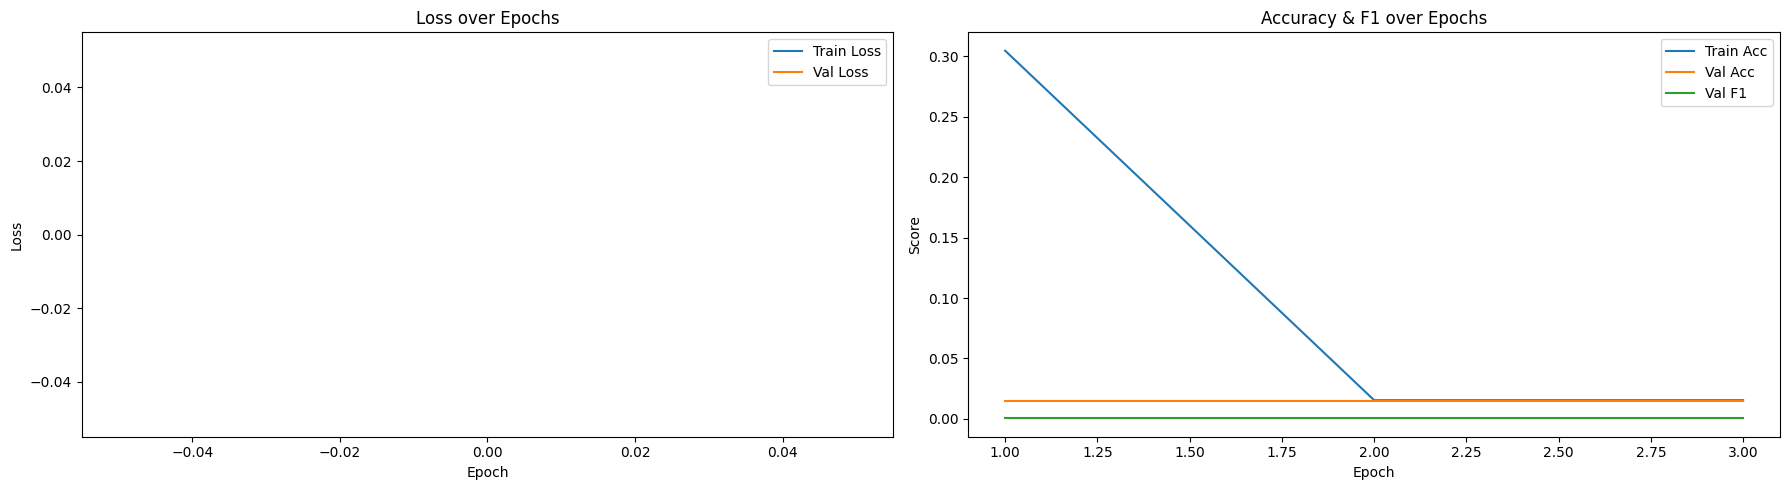

[W 2025-08-03 18:02:29,340] Trial 7 failed with parameters: {'d_model': 256, 'num_layers': 5, 'num_heads': 4, 'lr': 0.0001, 'batch_size': 8, 'dropout': 0.16249921355094205} because of the following error: The value nan is not acceptable.
[W 2025-08-03 18:02:29,341] Trial 7 failed with value (0.014925373134328358, nan, 0.0004389815627743634).


Parameters chosen for this trial: 
d_model:  256
num_layers:  5
num_heads:  4
dropout:  0.16249921355094205
learning rate:  0.0001
batch_szie:  8
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  6
num_heads:  8
dropout:  0.11018958011496555
learning rate:  1e-05
batch_szie:  32


Train labels:  [np.int64(65), np.int64(60), np.int64(62), np.int64(28), np.int64(64), np.int64(31), np.int64(51), np.int64(42), np.int64(63), np.int64(43)]
Pred labels:  [np.int64(23), np.int64(65), np.int64(8), np.int64(8), np.int64(46), np.int64(46), np.int64(8), np.int64(19), np.int64(46), np.int64(46)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(8), np.int64(19), np.int64(0), np.int64(45), np.int64(35), np.int64(54), np.int64(19), np.int64(61), np.int64(35), np.int64(35)]
Epoch 1/10
Train Loss: 4.0693 | Train Acc: 0.0809
Val Loss: 3.9280 | Val Acc: 0.1095
Validation F1 Score: 0.0497


Train labels:  [np.int64(59), np.int64(67), np.int64(42), np.int64(23), np.int64(53), np.int64(23), np.int64(64), np.int64(17), np.int64(44), np.int64(1)]
Pred labels:  [np.int64(59), np.int64(8), np.int64(56), np.int64(8), np.int64(8), np.int64(23), np.int64(68), np.int64(46), np.int64(8), np.int64(64)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(68), np.int64(19), np.int64(0), np.int64(45), np.int64(64), np.int64(54), np.int64(19), np.int64(34), np.int64(31), np.int64(31)]
Epoch 2/10
Train Loss: 3.6184 | Train Acc: 0.2735
Val Loss: 3.6242 | Val Acc: 0.1791
Validation F1 Score: 0.1199


Train labels:  [np.int64(30), np.int64(12), np.int64(28), np.int64(23), np.int64(3), np.int64(67), np.int64(53), np.int64(63), np.int64(12), np.int64(29)]
Pred labels:  [np.int64(64), np.int64(12), np.int64(46), np.int64(23), np.int64(31), np.int64(67), np.int64(62), np.int64(64), np.int64(12), np.int64(8)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(19), np.int64(19), np.int64(25), np.int64(25), np.int64(54), np.int64(19), np.int64(37), np.int64(19), np.int64(24)]
Epoch 3/10
Train Loss: 3.3991 | Train Acc: 0.3566
Val Loss: 3.5587 | Val Acc: 0.2338
Validation F1 Score: 0.1793


Train labels:  [np.int64(0), np.int64(33), np.int64(5), np.int64(4), np.int64(29), np.int64(10), np.int64(26), np.int64(12), np.int64(63), np.int64(46)]
Pred labels:  [np.int64(19), np.int64(15), np.int64(19), np.int64(45), np.int64(8), np.int64(45), np.int64(24), np.int64(12), np.int64(25), np.int64(46)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(68), np.int64(19), np.int64(0), np.int64(45), np.int64(25), np.int64(54), np.int64(19), np.int64(57), np.int64(31), np.int64(31)]
Epoch 4/10
Train Loss: 3.3235 | Train Acc: 0.4044
Val Loss: 3.4864 | Val Acc: 0.2587
Validation F1 Score: 0.2044


Train labels:  [np.int64(54), np.int64(0), np.int64(5), np.int64(64), np.int64(64), np.int64(17), np.int64(45), np.int64(2), np.int64(33), np.int64(63)]
Pred labels:  [np.int64(54), np.int64(0), np.int64(19), np.int64(64), np.int64(64), np.int64(17), np.int64(45), np.int64(69), np.int64(35), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(68), np.int64(0), np.int64(0), np.int64(45), np.int64(64), np.int64(54), np.int64(19), np.int64(34), np.int64(31), np.int64(31)]
Epoch 5/10
Train Loss: 3.2477 | Train Acc: 0.4150
Val Loss: 3.4385 | Val Acc: 0.2537
Validation F1 Score: 0.1831


Train labels:  [np.int64(68), np.int64(29), np.int64(54), np.int64(35), np.int64(25), np.int64(57), np.int64(36), np.int64(2), np.int64(28), np.int64(47)]
Pred labels:  [np.int64(54), np.int64(29), np.int64(54), np.int64(35), np.int64(25), np.int64(46), np.int64(69), np.int64(65), np.int64(48), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(19), np.int64(0), np.int64(25), np.int64(25), np.int64(0), np.int64(19), np.int64(34), np.int64(19), np.int64(31)]
Epoch 6/10
Train Loss: 3.1717 | Train Acc: 0.4427
Val Loss: 3.4191 | Val Acc: 0.2637
Validation F1 Score: 0.2091


Train labels:  [np.int64(13), np.int64(10), np.int64(29), np.int64(21), np.int64(59), np.int64(21), np.int64(67), np.int64(42), np.int64(12), np.int64(47)]
Pred labels:  [np.int64(19), np.int64(10), np.int64(29), np.int64(21), np.int64(44), np.int64(21), np.int64(67), np.int64(6), np.int64(12), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(19), np.int64(0), np.int64(25), np.int64(25), np.int64(0), np.int64(19), np.int64(59), np.int64(19), np.int64(24)]
Epoch 7/10
Train Loss: 3.0798 | Train Acc: 0.4677
Val Loss: 3.2921 | Val Acc: 0.3483
Validation F1 Score: 0.2985


Train labels:  [np.int64(40), np.int64(25), np.int64(67), np.int64(42), np.int64(7), np.int64(34), np.int64(24), np.int64(53), np.int64(23), np.int64(50)]
Pred labels:  [np.int64(25), np.int64(25), np.int64(67), np.int64(42), np.int64(7), np.int64(34), np.int64(24), np.int64(19), np.int64(23), np.int64(54)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(68), np.int64(64), np.int64(0), np.int64(19), np.int64(34), np.int64(31), np.int64(24)]
Epoch 8/10
Train Loss: 2.9349 | Train Acc: 0.5255
Val Loss: 3.2149 | Val Acc: 0.3333
Validation F1 Score: 0.2820


Train labels:  [np.int64(33), np.int64(21), np.int64(17), np.int64(48), np.int64(5), np.int64(54), np.int64(25), np.int64(17), np.int64(64), np.int64(54)]
Pred labels:  [np.int64(29), np.int64(46), np.int64(17), np.int64(48), np.int64(19), np.int64(54), np.int64(25), np.int64(17), np.int64(64), np.int64(54)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(62), np.int64(0), np.int64(68), np.int64(44), np.int64(0), np.int64(62), np.int64(34), np.int64(31), np.int64(24)]
Epoch 9/10
Train Loss: 2.8185 | Train Acc: 0.5559
Val Loss: 3.1584 | Val Acc: 0.3433
Validation F1 Score: 0.3018


Train labels:  [np.int64(36), np.int64(69), np.int64(23), np.int64(62), np.int64(21), np.int64(19), np.int64(41), np.int64(13), np.int64(57), np.int64(15)]
Pred labels:  [np.int64(36), np.int64(69), np.int64(23), np.int64(62), np.int64(34), np.int64(68), np.int64(41), np.int64(8), np.int64(23), np.int64(15)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(62), np.int64(0), np.int64(25), np.int64(44), np.int64(0), np.int64(19), np.int64(34), np.int64(31), np.int64(31)]
Epoch 10/10
Train Loss: 2.7104 | Train Acc: 0.5964
Val Loss: 3.0725 | Val Acc: 0.3483
Validation F1 Score: 0.3001


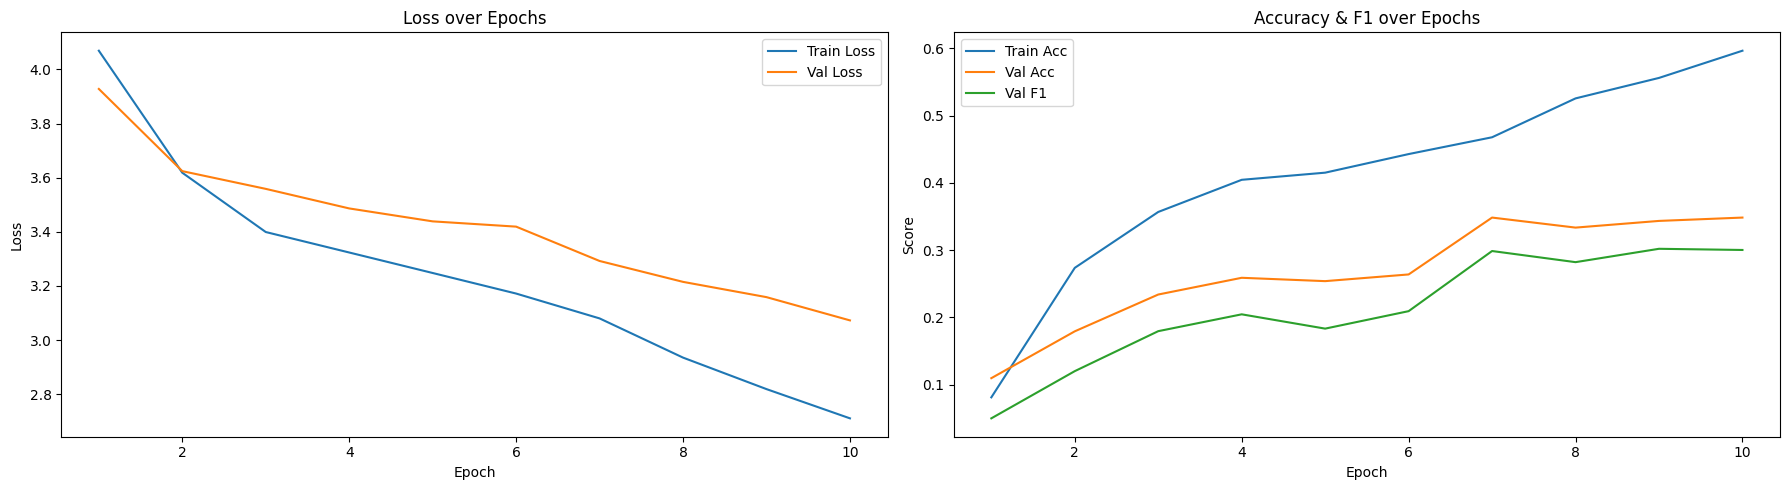

[I 2025-08-03 19:33:12,054] Trial 8 finished with values: [0.3482587064676617, 3.072492366999536, 0.30007414787924] and parameters: {'d_model': 256, 'num_layers': 6, 'num_heads': 8, 'lr': 1e-05, 'batch_size': 32, 'dropout': 0.11018958011496555}.


Parameters chosen for this trial: 
d_model:  256
num_layers:  6
num_heads:  8
dropout:  0.11018958011496555
learning rate:  1e-05
batch_szie:  32
num_epochs:  2
Parameters chosen for this trial: 
d_model:  128
num_layers:  3
num_heads:  8
dropout:  0.2659813386304774
learning rate:  1e-06
batch_szie:  32


Train labels:  [np.int64(12), np.int64(24), np.int64(55), np.int64(40), np.int64(11), np.int64(35), np.int64(51), np.int64(12), np.int64(24), np.int64(4)]
Pred labels:  [np.int64(64), np.int64(15), np.int64(64), np.int64(64), np.int64(64), np.int64(52), np.int64(51), np.int64(52), np.int64(64), np.int64(52)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(64), np.int64(52), np.int64(52), np.int64(52), np.int64(64), np.int64(64), np.int64(51), np.int64(64), np.int64(51), np.int64(64)]
Epoch 1/10
Train Loss: 4.2707 | Train Acc: 0.0128
Val Loss: 4.2815 | Val Acc: 0.0149
Validation F1 Score: 0.0011


Train labels:  [np.int64(56), np.int64(10), np.int64(45), np.int64(37), np.int64(31), np.int64(60), np.int64(50), np.int64(24), np.int64(61), np.int64(14)]
Pred labels:  [np.int64(64), np.int64(45), np.int64(51), np.int64(64), np.int64(52), np.int64(53), np.int64(64), np.int64(52), np.int64(52), np.int64(64)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(59), np.int64(52), np.int64(51), np.int64(64), np.int64(51), np.int64(64)]
Epoch 2/10
Train Loss: 4.2572 | Train Acc: 0.0134
Val Loss: 4.2714 | Val Acc: 0.0149
Validation F1 Score: 0.0039


Train labels:  [np.int64(10), np.int64(46), np.int64(62), np.int64(5), np.int64(51), np.int64(46), np.int64(44), np.int64(57), np.int64(42), np.int64(48)]
Pred labels:  [np.int64(64), np.int64(64), np.int64(64), np.int64(64), np.int64(64), np.int64(64), np.int64(52), np.int64(59), np.int64(64), np.int64(34)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(59), np.int64(52), np.int64(59), np.int64(64), np.int64(52), np.int64(52)]
Epoch 3/10
Train Loss: 4.2436 | Train Acc: 0.0150
Val Loss: 4.2649 | Val Acc: 0.0100
Validation F1 Score: 0.0034


Train labels:  [np.int64(60), np.int64(28), np.int64(69), np.int64(15), np.int64(34), np.int64(11), np.int64(66), np.int64(48), np.int64(32), np.int64(33)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(59), np.int64(64), np.int64(52), np.int64(64), np.int64(34), np.int64(52), np.int64(51), np.int64(59)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(59), np.int64(52), np.int64(52), np.int64(64), np.int64(52), np.int64(52)]
Epoch 4/10
Train Loss: 4.2316 | Train Acc: 0.0172
Val Loss: 4.2596 | Val Acc: 0.0100
Validation F1 Score: 0.0034


Train labels:  [np.int64(40), np.int64(21), np.int64(25), np.int64(11), np.int64(20), np.int64(36), np.int64(20), np.int64(7), np.int64(69), np.int64(53)]
Pred labels:  [np.int64(52), np.int64(64), np.int64(45), np.int64(64), np.int64(64), np.int64(64), np.int64(64), np.int64(45), np.int64(52), np.int64(19)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(59), np.int64(52), np.int64(52), np.int64(64), np.int64(52), np.int64(56)]
Epoch 5/10
Train Loss: 4.2229 | Train Acc: 0.0200
Val Loss: 4.2533 | Val Acc: 0.0100
Validation F1 Score: 0.0034


Train labels:  [np.int64(32), np.int64(4), np.int64(13), np.int64(68), np.int64(13), np.int64(67), np.int64(48), np.int64(5), np.int64(20), np.int64(1)]
Pred labels:  [np.int64(51), np.int64(64), np.int64(52), np.int64(59), np.int64(64), np.int64(52), np.int64(59), np.int64(52), np.int64(59), np.int64(52)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(59), np.int64(52), np.int64(52), np.int64(45), np.int64(52), np.int64(0)]
Epoch 6/10
Train Loss: 4.2150 | Train Acc: 0.0195
Val Loss: 4.2500 | Val Acc: 0.0149
Validation F1 Score: 0.0125


Train labels:  [np.int64(36), np.int64(25), np.int64(63), np.int64(23), np.int64(23), np.int64(29), np.int64(63), np.int64(59), np.int64(50), np.int64(4)]
Pred labels:  [np.int64(46), np.int64(20), np.int64(52), np.int64(15), np.int64(20), np.int64(52), np.int64(59), np.int64(20), np.int64(64), np.int64(52)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(59), np.int64(52), np.int64(59), np.int64(45), np.int64(52), np.int64(0)]
Epoch 7/10
Train Loss: 4.2078 | Train Acc: 0.0247
Val Loss: 4.2427 | Val Acc: 0.0199
Validation F1 Score: 0.0170


Train labels:  [np.int64(17), np.int64(37), np.int64(5), np.int64(32), np.int64(35), np.int64(19), np.int64(17), np.int64(20), np.int64(46), np.int64(35)]
Pred labels:  [np.int64(52), np.int64(59), np.int64(52), np.int64(59), np.int64(64), np.int64(53), np.int64(5), np.int64(20), np.int64(64), np.int64(64)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(59), np.int64(52), np.int64(59), np.int64(45), np.int64(52), np.int64(0)]
Epoch 8/10
Train Loss: 4.1992 | Train Acc: 0.0259
Val Loss: 4.2360 | Val Acc: 0.0199
Validation F1 Score: 0.0150


Train labels:  [np.int64(37), np.int64(4), np.int64(10), np.int64(50), np.int64(1), np.int64(61), np.int64(43), np.int64(62), np.int64(17), np.int64(51)]
Pred labels:  [np.int64(59), np.int64(52), np.int64(52), np.int64(17), np.int64(59), np.int64(17), np.int64(52), np.int64(59), np.int64(52), np.int64(59)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(59), np.int64(52), np.int64(59), np.int64(45), np.int64(59), np.int64(0)]
Epoch 9/10
Train Loss: 4.1891 | Train Acc: 0.0264
Val Loss: 4.2334 | Val Acc: 0.0249
Validation F1 Score: 0.0154


Train labels:  [np.int64(62), np.int64(43), np.int64(9), np.int64(68), np.int64(47), np.int64(67), np.int64(37), np.int64(14), np.int64(8), np.int64(48)]
Pred labels:  [np.int64(59), np.int64(59), np.int64(52), np.int64(59), np.int64(52), np.int64(59), np.int64(56), np.int64(59), np.int64(64), np.int64(59)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(59), np.int64(52), np.int64(59), np.int64(45), np.int64(59), np.int64(0)]
Epoch 10/10
Train Loss: 4.1843 | Train Acc: 0.0312
Val Loss: 4.2294 | Val Acc: 0.0199
Validation F1 Score: 0.0150


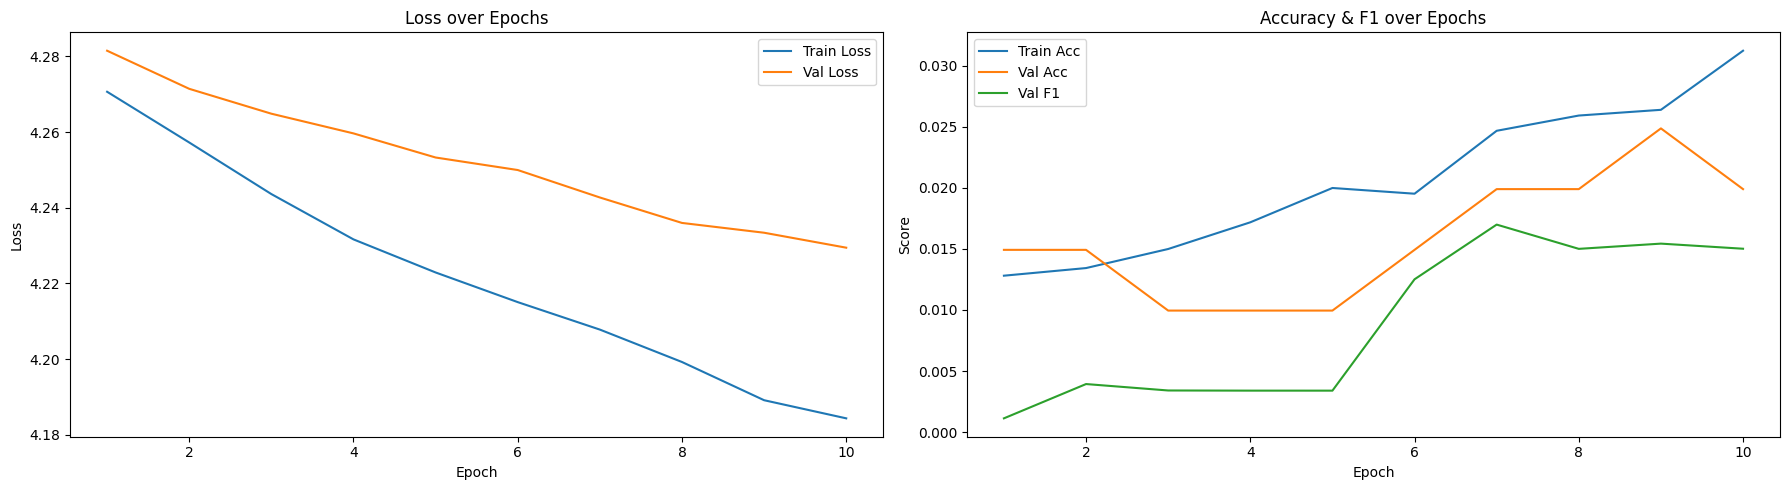

[I 2025-08-03 20:10:37,074] Trial 9 finished with values: [0.01990049751243781, 4.229436127107535, 0.015017505067256312] and parameters: {'d_model': 128, 'num_layers': 3, 'num_heads': 8, 'lr': 1e-06, 'batch_size': 32, 'dropout': 0.2659813386304774}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  3
num_heads:  8
dropout:  0.2659813386304774
learning rate:  1e-06
batch_szie:  32
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  5
num_heads:  8
dropout:  0.29336302915180523
learning rate:  1e-06
batch_szie:  16


Train labels:  [np.int64(13), np.int64(24), np.int64(12), np.int64(69), np.int64(53), np.int64(15), np.int64(45), np.int64(37), np.int64(59), np.int64(43)]
Pred labels:  [np.int64(62), np.int64(7), np.int64(62), np.int64(54), np.int64(54), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(13)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(46), np.int64(62), np.int64(62)]
Epoch 1/10
Train Loss: 4.2488 | Train Acc: 0.0212
Val Loss: 4.2260 | Val Acc: 0.0100
Validation F1 Score: 0.0019


Train labels:  [np.int64(19), np.int64(6), np.int64(8), np.int64(69), np.int64(62), np.int64(26), np.int64(53), np.int64(43), np.int64(0), np.int64(68)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(46), np.int64(62), np.int64(23), np.int64(62), np.int64(62), np.int64(62), np.int64(9), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(46), np.int64(62), np.int64(62)]
Epoch 2/10
Train Loss: 4.2087 | Train Acc: 0.0305
Val Loss: 4.2026 | Val Acc: 0.0100
Validation F1 Score: 0.0016


Train labels:  [np.int64(36), np.int64(24), np.int64(48), np.int64(66), np.int64(13), np.int64(53), np.int64(16), np.int64(45), np.int64(26), np.int64(20)]
Pred labels:  [np.int64(62), np.int64(25), np.int64(62), np.int64(46), np.int64(62), np.int64(8), np.int64(46), np.int64(13), np.int64(41), np.int64(46)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(25), np.int64(62), np.int64(62)]
Epoch 3/10
Train Loss: 4.1721 | Train Acc: 0.0423
Val Loss: 4.1768 | Val Acc: 0.0299
Validation F1 Score: 0.0205


Train labels:  [np.int64(64), np.int64(62), np.int64(47), np.int64(67), np.int64(4), np.int64(5), np.int64(51), np.int64(57), np.int64(14), np.int64(12)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(46), np.int64(25), np.int64(62), np.int64(46), np.int64(62), np.int64(23), np.int64(25), np.int64(41)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(25), np.int64(62), np.int64(62), np.int64(25), np.int64(31), np.int64(62)]
Epoch 4/10
Train Loss: 4.1367 | Train Acc: 0.0494
Val Loss: 4.1449 | Val Acc: 0.0448
Validation F1 Score: 0.0347


Train labels:  [np.int64(0), np.int64(13), np.int64(8), np.int64(35), np.int64(0), np.int64(1), np.int64(37), np.int64(7), np.int64(19), np.int64(1)]
Pred labels:  [np.int64(9), np.int64(62), np.int64(23), np.int64(25), np.int64(41), np.int64(62), np.int64(32), np.int64(25), np.int64(46), np.int64(66)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(25), np.int64(62), np.int64(62), np.int64(25), np.int64(31), np.int64(31)]
Epoch 5/10
Train Loss: 4.0945 | Train Acc: 0.0708
Val Loss: 4.1044 | Val Acc: 0.0647
Validation F1 Score: 0.0432


Train labels:  [np.int64(44), np.int64(0), np.int64(5), np.int64(20), np.int64(44), np.int64(24), np.int64(50), np.int64(63), np.int64(54), np.int64(57)]
Pred labels:  [np.int64(32), np.int64(62), np.int64(25), np.int64(62), np.int64(25), np.int64(8), np.int64(8), np.int64(25), np.int64(62), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(25), np.int64(62), np.int64(62), np.int64(25), np.int64(31), np.int64(31)]
Epoch 6/10
Train Loss: 4.0590 | Train Acc: 0.0792
Val Loss: 4.0617 | Val Acc: 0.0697
Validation F1 Score: 0.0445


Train labels:  [np.int64(65), np.int64(2), np.int64(21), np.int64(27), np.int64(26), np.int64(10), np.int64(65), np.int64(2), np.int64(1), np.int64(12)]
Pred labels:  [np.int64(32), np.int64(25), np.int64(25), np.int64(31), np.int64(64), np.int64(25), np.int64(46), np.int64(25), np.int64(62), np.int64(46)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(25), np.int64(62), np.int64(62), np.int64(25), np.int64(31), np.int64(31)]
Epoch 7/10
Train Loss: 4.0216 | Train Acc: 0.0983
Val Loss: 4.0245 | Val Acc: 0.0547
Validation F1 Score: 0.0259


Train labels:  [np.int64(40), np.int64(60), np.int64(15), np.int64(16), np.int64(46), np.int64(67), np.int64(33), np.int64(5), np.int64(22), np.int64(45)]
Pred labels:  [np.int64(25), np.int64(23), np.int64(59), np.int64(46), np.int64(46), np.int64(0), np.int64(22), np.int64(62), np.int64(62), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(25), np.int64(62), np.int64(62), np.int64(25), np.int64(31), np.int64(31)]
Epoch 8/10
Train Loss: 3.9811 | Train Acc: 0.1201
Val Loss: 3.9900 | Val Acc: 0.0597
Validation F1 Score: 0.0227


Train labels:  [np.int64(54), np.int64(65), np.int64(36), np.int64(51), np.int64(22), np.int64(55), np.int64(9), np.int64(42), np.int64(51), np.int64(67)]
Pred labels:  [np.int64(62), np.int64(22), np.int64(32), np.int64(31), np.int64(22), np.int64(25), np.int64(10), np.int64(66), np.int64(62), np.int64(32)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(25), np.int64(62), np.int64(62), np.int64(25), np.int64(31), np.int64(31)]
Epoch 9/10
Train Loss: 3.9469 | Train Acc: 0.1326
Val Loss: 3.9520 | Val Acc: 0.0647
Validation F1 Score: 0.0230


Train labels:  [np.int64(57), np.int64(16), np.int64(17), np.int64(69), np.int64(69), np.int64(50), np.int64(44), np.int64(10), np.int64(32), np.int64(25)]
Pred labels:  [np.int64(25), np.int64(31), np.int64(17), np.int64(32), np.int64(32), np.int64(50), np.int64(32), np.int64(13), np.int64(32), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(25), np.int64(62), np.int64(62), np.int64(25), np.int64(31), np.int64(31)]
Epoch 10/10
Train Loss: 3.9086 | Train Acc: 0.1403
Val Loss: 3.9170 | Val Acc: 0.0697
Validation F1 Score: 0.0282


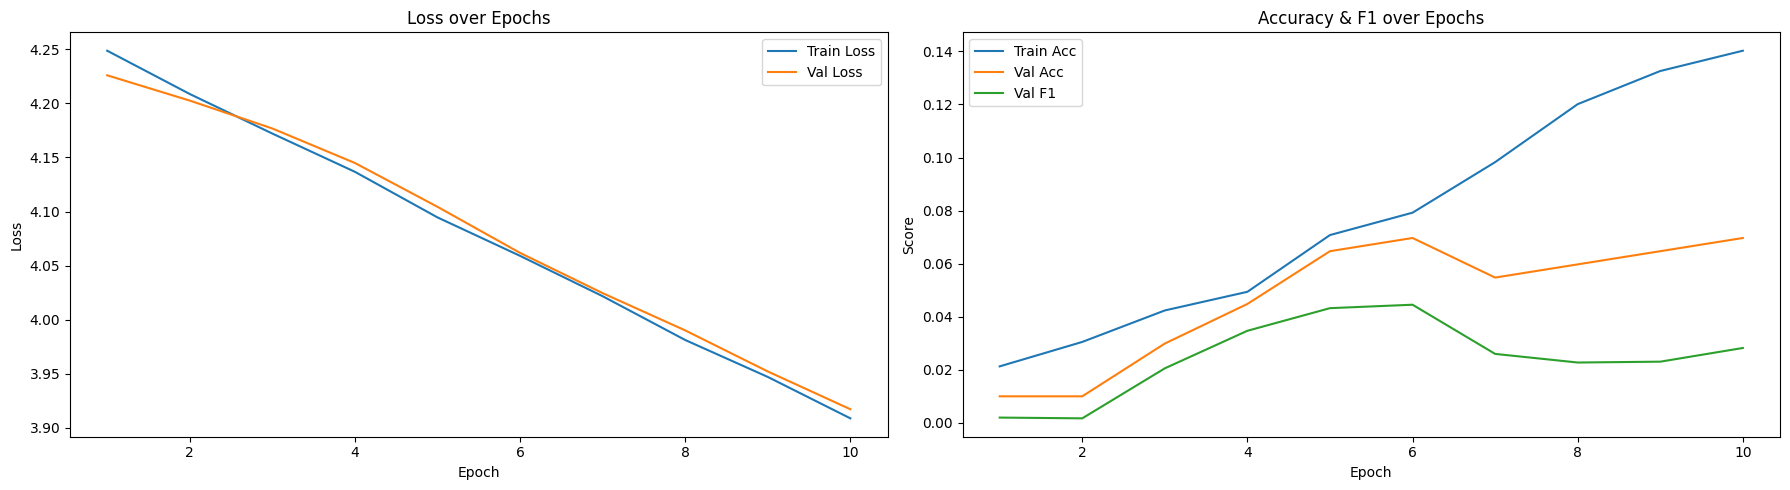

[I 2025-08-03 21:27:27,337] Trial 10 finished with values: [0.06965174129353234, 3.9170434724039107, 0.028178145499433795] and parameters: {'d_model': 256, 'num_layers': 5, 'num_heads': 8, 'lr': 1e-06, 'batch_size': 16, 'dropout': 0.29336302915180523}.


Parameters chosen for this trial: 
d_model:  256
num_layers:  5
num_heads:  8
dropout:  0.29336302915180523
learning rate:  1e-06
batch_szie:  16
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  5
num_heads:  4
dropout:  0.16666193118470593
learning rate:  1e-06
batch_szie:  32


Train labels:  [np.int64(63), np.int64(12), np.int64(26), np.int64(29), np.int64(29), np.int64(28), np.int64(42), np.int64(20), np.int64(59), np.int64(2)]
Pred labels:  [np.int64(46), np.int64(11), np.int64(43), np.int64(69), np.int64(11), np.int64(0), np.int64(46), np.int64(69), np.int64(46), np.int64(26)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(11), np.int64(5), np.int64(54), np.int64(22), np.int64(46), np.int64(11), np.int64(5), np.int64(46), np.int64(54), np.int64(54)]
Epoch 1/10
Train Loss: 4.2521 | Train Acc: 0.0186
Val Loss: 4.2308 | Val Acc: 0.0149
Validation F1 Score: 0.0026


Train labels:  [np.int64(41), np.int64(0), np.int64(47), np.int64(16), np.int64(25), np.int64(54), np.int64(19), np.int64(6), np.int64(25), np.int64(36)]
Pred labels:  [np.int64(11), np.int64(11), np.int64(11), np.int64(5), np.int64(19), np.int64(21), np.int64(5), np.int64(46), np.int64(46), np.int64(11)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(5), np.int64(11), np.int64(22), np.int64(11), np.int64(21), np.int64(5), np.int64(46), np.int64(54), np.int64(5)]
Epoch 2/10
Train Loss: 4.2102 | Train Acc: 0.0225
Val Loss: 4.2113 | Val Acc: 0.0348
Validation F1 Score: 0.0199


Train labels:  [np.int64(47), np.int64(57), np.int64(8), np.int64(48), np.int64(25), np.int64(52), np.int64(68), np.int64(7), np.int64(43), np.int64(31)]
Pred labels:  [np.int64(11), np.int64(11), np.int64(22), np.int64(69), np.int64(33), np.int64(11), np.int64(11), np.int64(22), np.int64(11), np.int64(54)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(62), np.int64(62), np.int64(11), np.int64(11), np.int64(62), np.int64(5), np.int64(46), np.int64(54), np.int64(62)]
Epoch 3/10
Train Loss: 4.1754 | Train Acc: 0.0386
Val Loss: 4.1903 | Val Acc: 0.0199
Validation F1 Score: 0.0195


Train labels:  [np.int64(0), np.int64(50), np.int64(44), np.int64(32), np.int64(33), np.int64(56), np.int64(48), np.int64(9), np.int64(34), np.int64(59)]
Pred labels:  [np.int64(12), np.int64(21), np.int64(11), np.int64(46), np.int64(11), np.int64(62), np.int64(11), np.int64(11), np.int64(11), np.int64(11)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(62), np.int64(62), np.int64(11), np.int64(35), np.int64(62), np.int64(62), np.int64(46), np.int64(62), np.int64(62)]
Epoch 4/10
Train Loss: 4.1379 | Train Acc: 0.0595
Val Loss: 4.1612 | Val Acc: 0.0448
Validation F1 Score: 0.0335


Train labels:  [np.int64(69), np.int64(8), np.int64(37), np.int64(37), np.int64(20), np.int64(67), np.int64(31), np.int64(6), np.int64(60), np.int64(8)]
Pred labels:  [np.int64(69), np.int64(46), np.int64(33), np.int64(69), np.int64(21), np.int64(69), np.int64(62), np.int64(46), np.int64(62), np.int64(46)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(62), np.int64(11), np.int64(35), np.int64(62), np.int64(62), np.int64(46), np.int64(62), np.int64(62)]
Epoch 5/10
Train Loss: 4.0931 | Train Acc: 0.0848
Val Loss: 4.1200 | Val Acc: 0.0597
Validation F1 Score: 0.0424


Train labels:  [np.int64(33), np.int64(16), np.int64(6), np.int64(11), np.int64(30), np.int64(23), np.int64(19), np.int64(53), np.int64(62), np.int64(63)]
Pred labels:  [np.int64(11), np.int64(62), np.int64(46), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(33), np.int64(11), np.int64(11)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(62), np.int64(62), np.int64(11), np.int64(35), np.int64(62), np.int64(62), np.int64(46), np.int64(62), np.int64(62)]
Epoch 6/10
Train Loss: 4.0400 | Train Acc: 0.1093
Val Loss: 4.0743 | Val Acc: 0.0846
Validation F1 Score: 0.0538


Train labels:  [np.int64(68), np.int64(17), np.int64(6), np.int64(10), np.int64(12), np.int64(33), np.int64(4), np.int64(10), np.int64(36), np.int64(3)]
Pred labels:  [np.int64(11), np.int64(21), np.int64(8), np.int64(17), np.int64(11), np.int64(33), np.int64(62), np.int64(46), np.int64(69), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(62), np.int64(62), np.int64(43), np.int64(35), np.int64(62), np.int64(62), np.int64(46), np.int64(62), np.int64(62)]
Epoch 7/10
Train Loss: 3.9837 | Train Acc: 0.1365
Val Loss: 4.0281 | Val Acc: 0.0995
Validation F1 Score: 0.0660


Train labels:  [np.int64(35), np.int64(9), np.int64(24), np.int64(21), np.int64(41), np.int64(60), np.int64(28), np.int64(32), np.int64(15), np.int64(53)]
Pred labels:  [np.int64(46), np.int64(11), np.int64(31), np.int64(21), np.int64(56), np.int64(46), np.int64(33), np.int64(33), np.int64(62), np.int64(21)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(62), np.int64(62), np.int64(43), np.int64(35), np.int64(62), np.int64(62), np.int64(46), np.int64(62), np.int64(62)]
Epoch 8/10
Train Loss: 3.9319 | Train Acc: 0.1521
Val Loss: 3.9798 | Val Acc: 0.1095
Validation F1 Score: 0.0759


Train labels:  [np.int64(20), np.int64(13), np.int64(14), np.int64(12), np.int64(29), np.int64(34), np.int64(44), np.int64(2), np.int64(67), np.int64(14)]
Pred labels:  [np.int64(46), np.int64(11), np.int64(69), np.int64(69), np.int64(8), np.int64(14), np.int64(46), np.int64(37), np.int64(37), np.int64(14)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(62), np.int64(62), np.int64(17), np.int64(35), np.int64(62), np.int64(62), np.int64(14), np.int64(62), np.int64(62)]
Epoch 9/10
Train Loss: 3.8751 | Train Acc: 0.1735
Val Loss: 3.9332 | Val Acc: 0.1443
Validation F1 Score: 0.1010


Train labels:  [np.int64(35), np.int64(55), np.int64(8), np.int64(64), np.int64(63), np.int64(65), np.int64(46), np.int64(66), np.int64(29), np.int64(41)]
Pred labels:  [np.int64(35), np.int64(14), np.int64(26), np.int64(14), np.int64(33), np.int64(26), np.int64(17), np.int64(31), np.int64(8), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(62), np.int64(62), np.int64(45), np.int64(35), np.int64(62), np.int64(62), np.int64(14), np.int64(31), np.int64(62)]
Epoch 10/10
Train Loss: 3.8266 | Train Acc: 0.1921
Val Loss: 3.8923 | Val Acc: 0.1493
Validation F1 Score: 0.1041


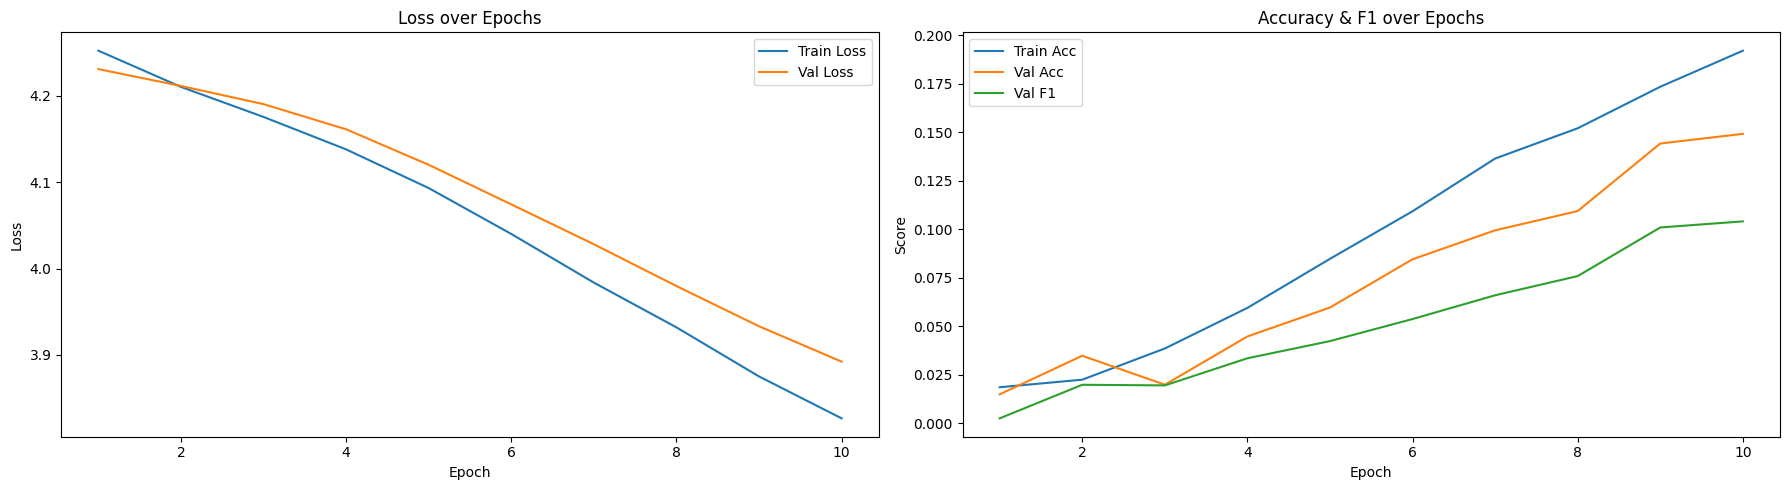

[I 2025-08-03 22:23:38,740] Trial 11 finished with values: [0.14925373134328357, 3.892293944287656, 0.10412517289390529] and parameters: {'d_model': 256, 'num_layers': 5, 'num_heads': 4, 'lr': 1e-06, 'batch_size': 32, 'dropout': 0.16666193118470593}.


Parameters chosen for this trial: 
d_model:  256
num_layers:  5
num_heads:  4
dropout:  0.16666193118470593
learning rate:  1e-06
batch_szie:  32
num_epochs:  2
Parameters chosen for this trial: 
d_model:  128
num_layers:  6
num_heads:  8
dropout:  0.29882869507659093
learning rate:  0.0001
batch_szie:  8


Train labels:  [np.int64(67), np.int64(2), np.int64(22), np.int64(46), np.int64(5), np.int64(1), np.int64(43), np.int64(42), np.int64(32), np.int64(69)]
Pred labels:  [np.int64(1), np.int64(62), np.int64(23), np.int64(23), np.int64(62), np.int64(68), np.int64(23), np.int64(7), np.int64(62), np.int64(23)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(45), np.int64(41), np.int64(19), np.int64(45), np.int64(35), np.int64(19), np.int64(19), np.int64(59), np.int64(31), np.int64(31)]
Epoch 1/10
Train Loss: 3.5472 | Train Acc: 0.1895
Val Loss: 3.1315 | Val Acc: 0.1791
Validation F1 Score: 0.1264


Train labels:  [np.int64(46), np.int64(5), np.int64(20), np.int64(4), np.int64(36), np.int64(29), np.int64(11), np.int64(48), np.int64(62), np.int64(69)]
Pred labels:  [np.int64(46), np.int64(5), np.int64(45), np.int64(45), np.int64(37), np.int64(33), np.int64(35), np.int64(48), np.int64(62), np.int64(48)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(45), np.int64(1), np.int64(1), np.int64(45), np.int64(35), np.int64(1), np.int64(52), np.int64(37), np.int64(3), np.int64(31)]
Epoch 2/10
Train Loss: 1.7964 | Train Acc: 0.6400
Val Loss: 2.4264 | Val Acc: 0.3184
Validation F1 Score: 0.3085


Train labels:  [np.int64(23), np.int64(40), np.int64(46), np.int64(67), np.int64(43), np.int64(8), np.int64(21), np.int64(62), np.int64(12), np.int64(7)]
Pred labels:  [np.int64(59), np.int64(40), np.int64(46), np.int64(67), np.int64(45), np.int64(8), np.int64(21), np.int64(62), np.int64(12), np.int64(7)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(30), np.int64(51), np.int64(0), np.int64(15), np.int64(35), np.int64(1), np.int64(5), np.int64(34), np.int64(3), np.int64(31)]
Epoch 3/10
Train Loss: 0.8147 | Train Acc: 0.8625
Val Loss: 1.8859 | Val Acc: 0.4726
Validation F1 Score: 0.4381


Train labels:  [np.int64(50), np.int64(15), np.int64(27), np.int64(0), np.int64(0), np.int64(7), np.int64(12), np.int64(48), np.int64(19), np.int64(6)]
Pred labels:  [np.int64(50), np.int64(15), np.int64(27), np.int64(0), np.int64(0), np.int64(7), np.int64(12), np.int64(48), np.int64(19), np.int64(6)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 4/10
Train Loss: nan | Train Acc: 0.4711
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(61), np.int64(45), np.int64(35), np.int64(66), np.int64(64), np.int64(2), np.int64(15), np.int64(68), np.int64(61), np.int64(46)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 5/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(29), np.int64(10), np.int64(64), np.int64(6), np.int64(63), np.int64(69), np.int64(52), np.int64(8), np.int64(45), np.int64(8)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 6/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004
Model may be overfitting, time to early stop: 


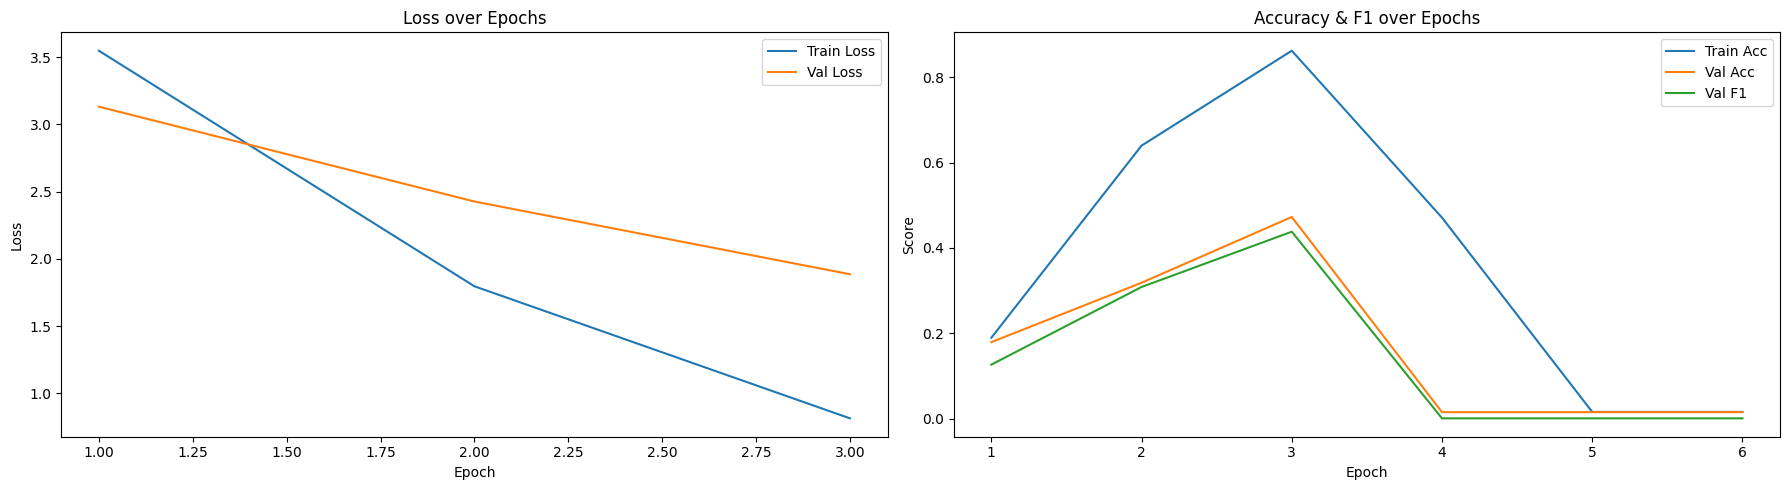

[W 2025-08-03 23:07:53,259] Trial 12 failed with parameters: {'d_model': 128, 'num_layers': 6, 'num_heads': 8, 'lr': 0.0001, 'batch_size': 8, 'dropout': 0.29882869507659093} because of the following error: The value nan is not acceptable.
[W 2025-08-03 23:07:53,260] Trial 12 failed with value (0.014925373134328358, nan, 0.0004389815627743634).


Parameters chosen for this trial: 
d_model:  128
num_layers:  6
num_heads:  8
dropout:  0.29882869507659093
learning rate:  0.0001
batch_szie:  8
num_epochs:  2
Parameters chosen for this trial: 
d_model:  128
num_layers:  2
num_heads:  4
dropout:  0.15296402311951965
learning rate:  1e-06
batch_szie:  16


Train labels:  [np.int64(6), np.int64(47), np.int64(61), np.int64(43), np.int64(9), np.int64(0), np.int64(52), np.int64(35), np.int64(31), np.int64(24)]
Pred labels:  [np.int64(30), np.int64(44), np.int64(61), np.int64(30), np.int64(30), np.int64(44), np.int64(61), np.int64(44), np.int64(44), np.int64(61)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(61), np.int64(61), np.int64(61), np.int64(61), np.int64(30), np.int64(61), np.int64(61), np.int64(21), np.int64(61), np.int64(21)]
Epoch 1/10
Train Loss: 4.2932 | Train Acc: 0.0106
Val Loss: 4.2827 | Val Acc: 0.0149
Validation F1 Score: 0.0033


Train labels:  [np.int64(63), np.int64(45), np.int64(48), np.int64(21), np.int64(36), np.int64(27), np.int64(56), np.int64(5), np.int64(45), np.int64(61)]
Pred labels:  [np.int64(47), np.int64(30), np.int64(44), np.int64(61), np.int64(30), np.int64(44), np.int64(61), np.int64(21), np.int64(61), np.int64(66)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(61), np.int64(61), np.int64(61), np.int64(30), np.int64(61), np.int64(61), np.int64(21), np.int64(61), np.int64(21)]
Epoch 2/10
Train Loss: 4.2628 | Train Acc: 0.0195
Val Loss: 4.2654 | Val Acc: 0.0199
Validation F1 Score: 0.0113


Train labels:  [np.int64(47), np.int64(2), np.int64(53), np.int64(65), np.int64(9), np.int64(67), np.int64(64), np.int64(29), np.int64(44), np.int64(21)]
Pred labels:  [np.int64(21), np.int64(30), np.int64(61), np.int64(32), np.int64(61), np.int64(30), np.int64(30), np.int64(61), np.int64(30), np.int64(21)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(46), np.int64(66), np.int64(34), np.int64(30), np.int64(66), np.int64(66), np.int64(21), np.int64(66), np.int64(21)]
Epoch 3/10
Train Loss: 4.2392 | Train Acc: 0.0298
Val Loss: 4.2508 | Val Acc: 0.0299
Validation F1 Score: 0.0073


Train labels:  [np.int64(26), np.int64(17), np.int64(51), np.int64(8), np.int64(56), np.int64(51), np.int64(12), np.int64(59), np.int64(45), np.int64(11)]
Pred labels:  [np.int64(15), np.int64(30), np.int64(30), np.int64(15), np.int64(21), np.int64(21), np.int64(15), np.int64(50), np.int64(15), np.int64(21)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(46), np.int64(46), np.int64(66), np.int64(34), np.int64(15), np.int64(66), np.int64(66), np.int64(15), np.int64(66), np.int64(66)]
Epoch 4/10
Train Loss: 4.2217 | Train Acc: 0.0391
Val Loss: 4.2389 | Val Acc: 0.0348
Validation F1 Score: 0.0121


Train labels:  [np.int64(33), np.int64(2), np.int64(6), np.int64(42), np.int64(13), np.int64(2), np.int64(24), np.int64(52), np.int64(66), np.int64(22)]
Pred labels:  [np.int64(66), np.int64(66), np.int64(30), np.int64(15), np.int64(30), np.int64(50), np.int64(15), np.int64(66), np.int64(15), np.int64(21)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(46), np.int64(46), np.int64(66), np.int64(34), np.int64(15), np.int64(66), np.int64(66), np.int64(15), np.int64(66), np.int64(66)]
Epoch 5/10
Train Loss: 4.2076 | Train Acc: 0.0423
Val Loss: 4.2271 | Val Acc: 0.0398
Validation F1 Score: 0.0151


Train labels:  [np.int64(3), np.int64(33), np.int64(13), np.int64(66), np.int64(9), np.int64(3), np.int64(40), np.int64(13), np.int64(42), np.int64(60)]
Pred labels:  [np.int64(66), np.int64(15), np.int64(46), np.int64(28), np.int64(66), np.int64(66), np.int64(32), np.int64(15), np.int64(28), np.int64(15)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(46), np.int64(46), np.int64(66), np.int64(34), np.int64(15), np.int64(66), np.int64(66), np.int64(15), np.int64(66), np.int64(66)]
Epoch 6/10
Train Loss: 4.1923 | Train Acc: 0.0440
Val Loss: 4.2144 | Val Acc: 0.0398
Validation F1 Score: 0.0142


Train labels:  [np.int64(67), np.int64(26), np.int64(45), np.int64(5), np.int64(33), np.int64(14), np.int64(16), np.int64(55), np.int64(59), np.int64(68)]
Pred labels:  [np.int64(66), np.int64(46), np.int64(15), np.int64(15), np.int64(15), np.int64(15), np.int64(15), np.int64(50), np.int64(34), np.int64(46)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(46), np.int64(46), np.int64(66), np.int64(34), np.int64(15), np.int64(66), np.int64(66), np.int64(15), np.int64(66), np.int64(66)]
Epoch 7/10
Train Loss: 4.1793 | Train Acc: 0.0501
Val Loss: 4.2027 | Val Acc: 0.0299
Validation F1 Score: 0.0052


Train labels:  [np.int64(67), np.int64(37), np.int64(3), np.int64(55), np.int64(8), np.int64(3), np.int64(67), np.int64(17), np.int64(64), np.int64(50)]
Pred labels:  [np.int64(30), np.int64(37), np.int64(15), np.int64(32), np.int64(46), np.int64(45), np.int64(32), np.int64(46), np.int64(66), np.int64(46)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(46), np.int64(46), np.int64(66), np.int64(34), np.int64(15), np.int64(66), np.int64(66), np.int64(15), np.int64(66), np.int64(15)]
Epoch 8/10
Train Loss: 4.1651 | Train Acc: 0.0594
Val Loss: 4.1917 | Val Acc: 0.0498
Validation F1 Score: 0.0212


Train labels:  [np.int64(26), np.int64(69), np.int64(36), np.int64(11), np.int64(65), np.int64(6), np.int64(41), np.int64(15), np.int64(33), np.int64(27)]
Pred labels:  [np.int64(66), np.int64(32), np.int64(15), np.int64(66), np.int64(32), np.int64(14), np.int64(46), np.int64(15), np.int64(15), np.int64(34)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(46), np.int64(0), np.int64(66), np.int64(34), np.int64(15), np.int64(66), np.int64(66), np.int64(15), np.int64(66), np.int64(15)]
Epoch 9/10
Train Loss: 4.1504 | Train Acc: 0.0615
Val Loss: 4.1808 | Val Acc: 0.0697
Validation F1 Score: 0.0311


Train labels:  [np.int64(37), np.int64(5), np.int64(10), np.int64(53), np.int64(19), np.int64(44), np.int64(67), np.int64(2), np.int64(14), np.int64(54)]
Pred labels:  [np.int64(46), np.int64(66), np.int64(35), np.int64(15), np.int64(15), np.int64(65), np.int64(46), np.int64(25), np.int64(32), np.int64(35)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(15), np.int64(46), np.int64(0), np.int64(34), np.int64(35), np.int64(66), np.int64(66), np.int64(15), np.int64(66), np.int64(15)]
Epoch 10/10
Train Loss: 4.1379 | Train Acc: 0.0770
Val Loss: 4.1693 | Val Acc: 0.0746
Validation F1 Score: 0.0341


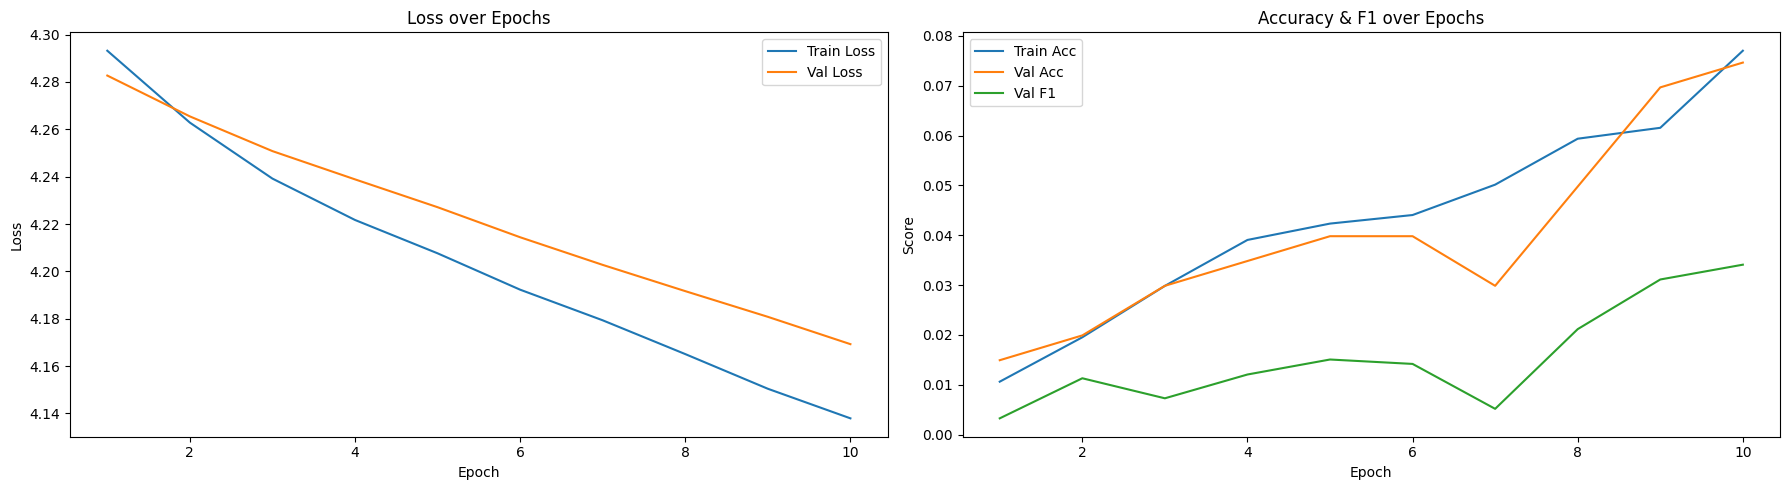

[I 2025-08-03 23:24:13,463] Trial 13 finished with values: [0.07462686567164178, 4.169267391090963, 0.03408823566284017] and parameters: {'d_model': 128, 'num_layers': 2, 'num_heads': 4, 'lr': 1e-06, 'batch_size': 16, 'dropout': 0.15296402311951965}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  2
num_heads:  4
dropout:  0.15296402311951965
learning rate:  1e-06
batch_szie:  16
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  2
num_heads:  4
dropout:  0.12340605915451533
learning rate:  1e-05
batch_szie:  16


Train labels:  [np.int64(50), np.int64(45), np.int64(20), np.int64(69), np.int64(11), np.int64(41), np.int64(45), np.int64(37), np.int64(1), np.int64(29)]
Pred labels:  [np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(5), np.int64(12), np.int64(5), np.int64(25), np.int64(32), np.int64(5), np.int64(5), np.int64(32), np.int64(5), np.int64(5)]
Epoch 1/10
Train Loss: 4.1007 | Train Acc: 0.0700
Val Loss: 3.9941 | Val Acc: 0.1045
Validation F1 Score: 0.0602


Train labels:  [np.int64(48), np.int64(5), np.int64(64), np.int64(28), np.int64(62), np.int64(28), np.int64(61), np.int64(35), np.int64(46), np.int64(6)]
Pred labels:  [np.int64(32), np.int64(2), np.int64(25), np.int64(12), np.int64(12), np.int64(37), np.int64(59), np.int64(59), np.int64(46), np.int64(59)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(5), np.int64(5), np.int64(25), np.int64(25), np.int64(5), np.int64(54), np.int64(32), np.int64(5), np.int64(5)]
Epoch 2/10
Train Loss: 3.6157 | Train Acc: 0.2276
Val Loss: 3.5448 | Val Acc: 0.1393
Validation F1 Score: 0.0876


Train labels:  [np.int64(20), np.int64(33), np.int64(9), np.int64(16), np.int64(15), np.int64(54), np.int64(29), np.int64(32), np.int64(47), np.int64(19)]
Pred labels:  [np.int64(65), np.int64(33), np.int64(25), np.int64(25), np.int64(25), np.int64(54), np.int64(7), np.int64(32), np.int64(65), np.int64(5)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(5), np.int64(19), np.int64(45), np.int64(25), np.int64(5), np.int64(54), np.int64(37), np.int64(64), np.int64(5)]
Epoch 3/10
Train Loss: 3.1690 | Train Acc: 0.3663
Val Loss: 3.2559 | Val Acc: 0.2090
Validation F1 Score: 0.1497


Train labels:  [np.int64(31), np.int64(15), np.int64(16), np.int64(57), np.int64(62), np.int64(36), np.int64(54), np.int64(56), np.int64(37), np.int64(25)]
Pred labels:  [np.int64(31), np.int64(25), np.int64(25), np.int64(14), np.int64(62), np.int64(33), np.int64(54), np.int64(54), np.int64(37), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(0), np.int64(0), np.int64(45), np.int64(40), np.int64(0), np.int64(64), np.int64(8), np.int64(64), np.int64(5)]
Epoch 4/10
Train Loss: 2.8281 | Train Acc: 0.4749
Val Loss: 2.9956 | Val Acc: 0.2786
Validation F1 Score: 0.2172


Train labels:  [np.int64(8), np.int64(32), np.int64(53), np.int64(23), np.int64(6), np.int64(50), np.int64(64), np.int64(0), np.int64(41), np.int64(36)]
Pred labels:  [np.int64(8), np.int64(33), np.int64(66), np.int64(59), np.int64(6), np.int64(54), np.int64(64), np.int64(0), np.int64(41), np.int64(26)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(0), np.int64(0), np.int64(45), np.int64(25), np.int64(0), np.int64(54), np.int64(8), np.int64(64), np.int64(31)]
Epoch 5/10
Train Loss: 2.5238 | Train Acc: 0.5675
Val Loss: 2.7918 | Val Acc: 0.2836
Validation F1 Score: 0.2411


Train labels:  [np.int64(25), np.int64(46), np.int64(41), np.int64(25), np.int64(11), np.int64(23), np.int64(1), np.int64(22), np.int64(68), np.int64(54)]
Pred labels:  [np.int64(25), np.int64(46), np.int64(41), np.int64(25), np.int64(64), np.int64(23), np.int64(0), np.int64(24), np.int64(68), np.int64(41)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(66), np.int64(62), np.int64(0), np.int64(45), np.int64(40), np.int64(0), np.int64(64), np.int64(8), np.int64(64), np.int64(31)]
Epoch 6/10
Train Loss: 2.2482 | Train Acc: 0.6364
Val Loss: 2.5867 | Val Acc: 0.3532
Validation F1 Score: 0.3220


Train labels:  [np.int64(13), np.int64(9), np.int64(4), np.int64(42), np.int64(60), np.int64(68), np.int64(54), np.int64(7), np.int64(37), np.int64(12)]
Pred labels:  [np.int64(34), np.int64(16), np.int64(4), np.int64(66), np.int64(33), np.int64(54), np.int64(54), np.int64(7), np.int64(37), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(66), np.int64(62), np.int64(0), np.int64(45), np.int64(40), np.int64(0), np.int64(64), np.int64(8), np.int64(15), np.int64(31)]
Epoch 7/10
Train Loss: 2.0031 | Train Acc: 0.7118
Val Loss: 2.4116 | Val Acc: 0.4328
Validation F1 Score: 0.4001


Train labels:  [np.int64(63), np.int64(45), np.int64(52), np.int64(23), np.int64(59), np.int64(69), np.int64(8), np.int64(2), np.int64(66), np.int64(23)]
Pred labels:  [np.int64(25), np.int64(45), np.int64(5), np.int64(23), np.int64(59), np.int64(69), np.int64(8), np.int64(2), np.int64(66), np.int64(23)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(0), np.int64(0), np.int64(45), np.int64(40), np.int64(0), np.int64(64), np.int64(55), np.int64(64), np.int64(31)]
Epoch 8/10
Train Loss: 1.7685 | Train Acc: 0.7609
Val Loss: 2.2676 | Val Acc: 0.4179
Validation F1 Score: 0.3743


Train labels:  [np.int64(69), np.int64(52), np.int64(13), np.int64(66), np.int64(47), np.int64(1), np.int64(10), np.int64(22), np.int64(65), np.int64(12)]
Pred labels:  [np.int64(69), np.int64(45), np.int64(28), np.int64(66), np.int64(65), np.int64(1), np.int64(10), np.int64(22), np.int64(65), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(0), np.int64(0), np.int64(45), np.int64(40), np.int64(0), np.int64(54), np.int64(55), np.int64(15), np.int64(31)]
Epoch 9/10
Train Loss: 1.6078 | Train Acc: 0.7885
Val Loss: 2.1705 | Val Acc: 0.4527
Validation F1 Score: 0.4126


Train labels:  [np.int64(56), np.int64(5), np.int64(47), np.int64(6), np.int64(59), np.int64(2), np.int64(10), np.int64(69), np.int64(15), np.int64(20)]
Pred labels:  [np.int64(52), np.int64(29), np.int64(65), np.int64(6), np.int64(34), np.int64(2), np.int64(10), np.int64(69), np.int64(15), np.int64(20)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 10/10
Train Loss: nan | Train Acc: 0.1435
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


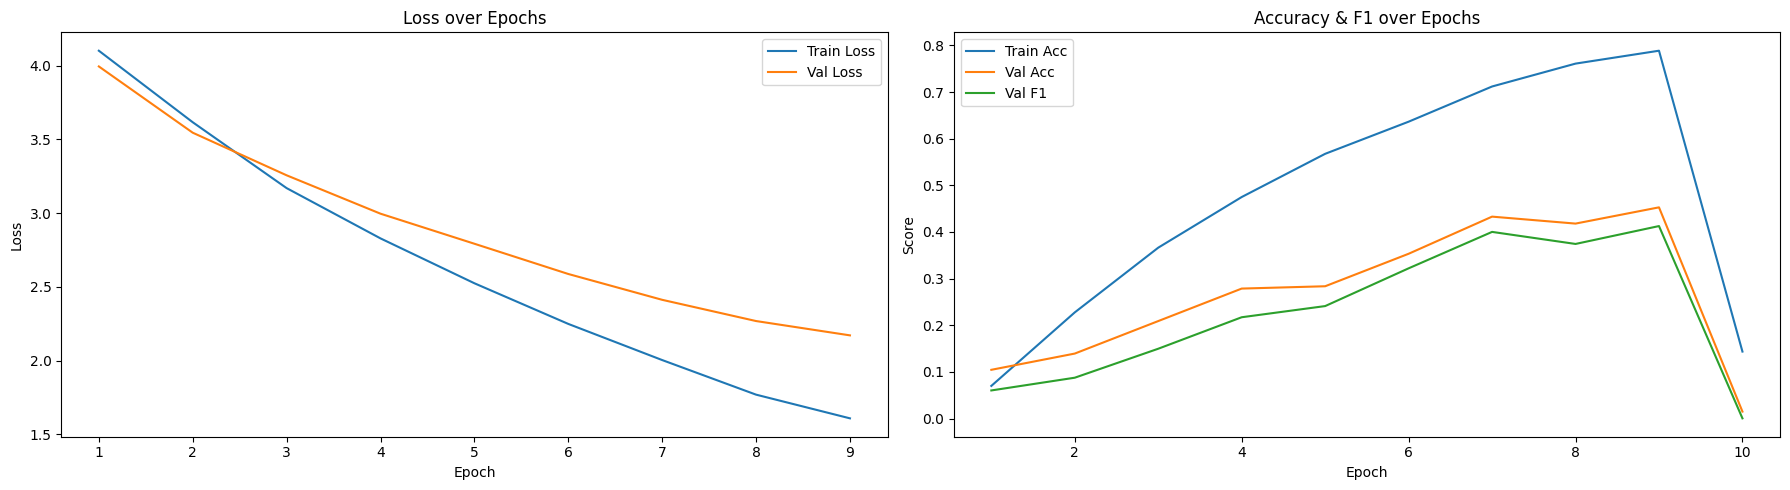

[W 2025-08-03 23:46:48,201] Trial 14 failed with parameters: {'d_model': 256, 'num_layers': 2, 'num_heads': 4, 'lr': 1e-05, 'batch_size': 16, 'dropout': 0.12340605915451533} because of the following error: The value nan is not acceptable.
[W 2025-08-03 23:46:48,202] Trial 14 failed with value (0.014925373134328358, nan, 0.0004389815627743634).


Parameters chosen for this trial: 
d_model:  256
num_layers:  2
num_heads:  4
dropout:  0.12340605915451533
learning rate:  1e-05
batch_szie:  16
num_epochs:  2
Parameters chosen for this trial: 
d_model:  128
num_layers:  4
num_heads:  4
dropout:  0.26136185048796085
learning rate:  0.0001
batch_szie:  16


Train labels:  [np.int64(31), np.int64(12), np.int64(25), np.int64(1), np.int64(31), np.int64(2), np.int64(50), np.int64(21), np.int64(53), np.int64(54)]
Pred labels:  [np.int64(65), np.int64(65), np.int64(60), np.int64(65), np.int64(65), np.int64(24), np.int64(62), np.int64(62), np.int64(19), np.int64(45)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(24), np.int64(62), np.int64(62), np.int64(24), np.int64(8), np.int64(62), np.int64(24), np.int64(32), np.int64(24), np.int64(24)]
Epoch 1/10
Train Loss: 3.9306 | Train Acc: 0.0867
Val Loss: 3.6423 | Val Acc: 0.0945
Validation F1 Score: 0.0640


Train labels:  [np.int64(16), np.int64(6), np.int64(33), np.int64(35), np.int64(46), np.int64(47), np.int64(14), np.int64(13), np.int64(55), np.int64(29)]
Pred labels:  [np.int64(26), np.int64(6), np.int64(21), np.int64(24), np.int64(46), np.int64(47), np.int64(8), np.int64(8), np.int64(32), np.int64(24)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(3), np.int64(41), np.int64(41), np.int64(24), np.int64(29), np.int64(41), np.int64(64), np.int64(34), np.int64(24), np.int64(31)]
Epoch 2/10
Train Loss: 2.9017 | Train Acc: 0.3485
Val Loss: 2.9204 | Val Acc: 0.2338
Validation F1 Score: 0.1848


Train labels:  [np.int64(45), np.int64(64), np.int64(14), np.int64(11), np.int64(69), np.int64(0), np.int64(6), np.int64(1), np.int64(59), np.int64(13)]
Pred labels:  [np.int64(45), np.int64(64), np.int64(8), np.int64(45), np.int64(67), np.int64(45), np.int64(6), np.int64(64), np.int64(21), np.int64(16)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 3/10
Train Loss: nan | Train Acc: 0.0465
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(6), np.int64(62), np.int64(47), np.int64(47), np.int64(5), np.int64(51), np.int64(15), np.int64(57), np.int64(36), np.int64(32)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 4/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(35), np.int64(22), np.int64(22), np.int64(1), np.int64(25), np.int64(32), np.int64(56), np.int64(51), np.int64(69), np.int64(60)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 5/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004
Model may be overfitting, time to early stop: 


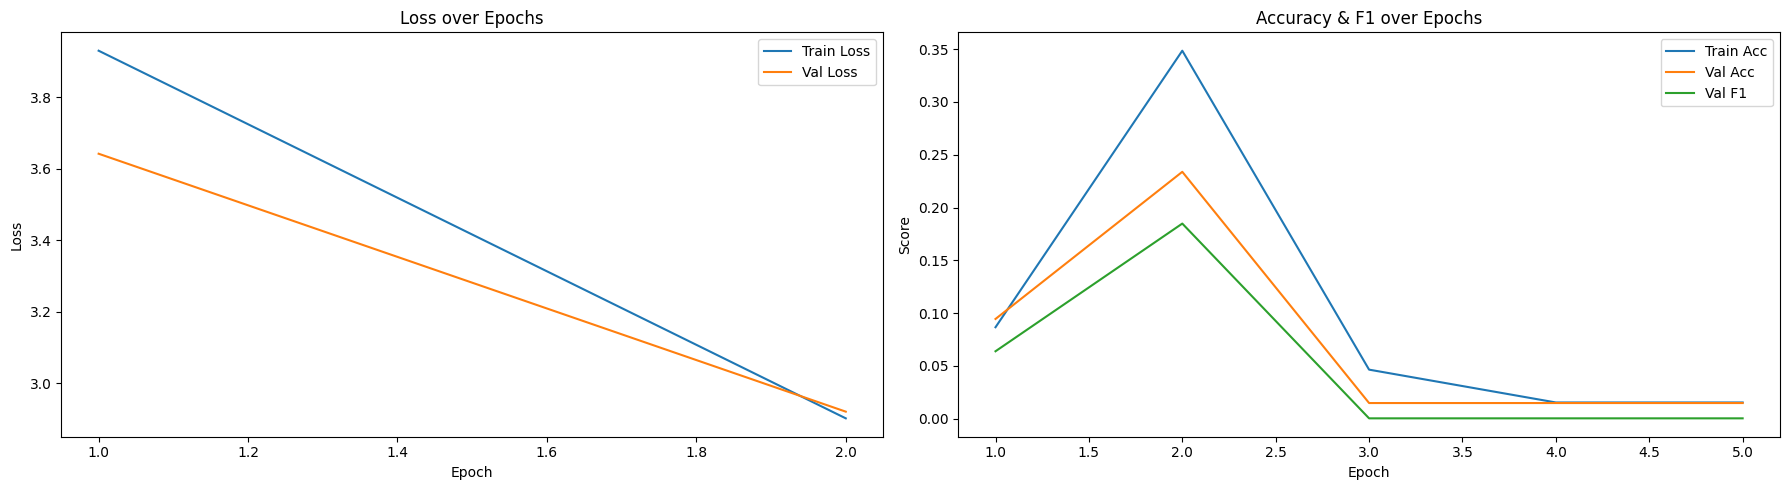

[W 2025-08-04 00:02:30,064] Trial 15 failed with parameters: {'d_model': 128, 'num_layers': 4, 'num_heads': 4, 'lr': 0.0001, 'batch_size': 16, 'dropout': 0.26136185048796085} because of the following error: The value nan is not acceptable.
[W 2025-08-04 00:02:30,065] Trial 15 failed with value (0.014925373134328358, nan, 0.0004389815627743634).


Parameters chosen for this trial: 
d_model:  128
num_layers:  4
num_heads:  4
dropout:  0.26136185048796085
learning rate:  0.0001
batch_szie:  16
num_epochs:  2
Parameters chosen for this trial: 
d_model:  128
num_layers:  4
num_heads:  8
dropout:  0.21373347107236523
learning rate:  1e-06
batch_szie:  16


Train labels:  [np.int64(45), np.int64(15), np.int64(4), np.int64(1), np.int64(26), np.int64(34), np.int64(59), np.int64(15), np.int64(47), np.int64(31)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44)]
Epoch 1/10
Train Loss: 4.2615 | Train Acc: 0.0201
Val Loss: 4.2823 | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(24), np.int64(57), np.int64(59), np.int64(8), np.int64(25), np.int64(44), np.int64(24), np.int64(29), np.int64(27), np.int64(69)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(23), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44)]
Epoch 2/10
Train Loss: 4.2441 | Train Acc: 0.0226
Val Loss: 4.2702 | Val Acc: 0.0149
Validation F1 Score: 0.0005


Train labels:  [np.int64(68), np.int64(69), np.int64(37), np.int64(8), np.int64(7), np.int64(1), np.int64(23), np.int64(3), np.int64(56), np.int64(10)]
Pred labels:  [np.int64(42), np.int64(24), np.int64(45), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44)]
Epoch 3/10
Train Loss: 4.2309 | Train Acc: 0.0226
Val Loss: 4.2608 | Val Acc: 0.0149
Validation F1 Score: 0.0005


Train labels:  [np.int64(17), np.int64(32), np.int64(66), np.int64(46), np.int64(66), np.int64(23), np.int64(41), np.int64(47), np.int64(10), np.int64(67)]
Pred labels:  [np.int64(44), np.int64(25), np.int64(44), np.int64(44), np.int64(45), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(45), np.int64(44)]
Epoch 4/10
Train Loss: 4.2200 | Train Acc: 0.0280
Val Loss: 4.2515 | Val Acc: 0.0100
Validation F1 Score: 0.0077


Train labels:  [np.int64(54), np.int64(31), np.int64(51), np.int64(26), np.int64(45), np.int64(66), np.int64(23), np.int64(5), np.int64(36), np.int64(26)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(45), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(50)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(45), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(45), np.int64(44), np.int64(45), np.int64(44)]
Epoch 5/10
Train Loss: 4.2094 | Train Acc: 0.0292
Val Loss: 4.2437 | Val Acc: 0.0050
Validation F1 Score: 0.0075


Train labels:  [np.int64(34), np.int64(28), np.int64(59), np.int64(62), np.int64(20), np.int64(54), np.int64(53), np.int64(26), np.int64(23), np.int64(33)]
Pred labels:  [np.int64(50), np.int64(44), np.int64(44), np.int64(44), np.int64(24), np.int64(44), np.int64(44), np.int64(45), np.int64(44), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(45), np.int64(45), np.int64(44), np.int64(44), np.int64(44), np.int64(45), np.int64(44), np.int64(45), np.int64(45)]
Epoch 6/10
Train Loss: 4.2012 | Train Acc: 0.0311
Val Loss: 4.2382 | Val Acc: 0.0100
Validation F1 Score: 0.0112


Train labels:  [np.int64(3), np.int64(69), np.int64(28), np.int64(50), np.int64(55), np.int64(51), np.int64(46), np.int64(25), np.int64(12), np.int64(24)]
Pred labels:  [np.int64(45), np.int64(24), np.int64(45), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(25), np.int64(44), np.int64(45)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(45), np.int64(45), np.int64(44), np.int64(44), np.int64(44), np.int64(45), np.int64(44), np.int64(45), np.int64(45)]
Epoch 7/10
Train Loss: 4.1909 | Train Acc: 0.0316
Val Loss: 4.2291 | Val Acc: 0.0149
Validation F1 Score: 0.0121


Train labels:  [np.int64(66), np.int64(61), np.int64(48), np.int64(40), np.int64(12), np.int64(62), np.int64(69), np.int64(40), np.int64(43), np.int64(61)]
Pred labels:  [np.int64(24), np.int64(44), np.int64(25), np.int64(45), np.int64(45), np.int64(45), np.int64(50), np.int64(44), np.int64(25), np.int64(54)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(45), np.int64(45), np.int64(45), np.int64(44), np.int64(44), np.int64(45), np.int64(45), np.int64(44), np.int64(45), np.int64(45)]
Epoch 8/10
Train Loss: 4.1843 | Train Acc: 0.0372
Val Loss: 4.2204 | Val Acc: 0.0199
Validation F1 Score: 0.0153


Train labels:  [np.int64(52), np.int64(56), np.int64(12), np.int64(46), np.int64(59), np.int64(47), np.int64(44), np.int64(33), np.int64(41), np.int64(20)]
Pred labels:  [np.int64(45), np.int64(32), np.int64(45), np.int64(50), np.int64(50), np.int64(25), np.int64(45), np.int64(24), np.int64(50), np.int64(50)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(45), np.int64(45), np.int64(45), np.int64(44), np.int64(44), np.int64(45), np.int64(45), np.int64(44), np.int64(45), np.int64(45)]
Epoch 9/10
Train Loss: 4.1725 | Train Acc: 0.0380
Val Loss: 4.2135 | Val Acc: 0.0199
Validation F1 Score: 0.0174


Train labels:  [np.int64(45), np.int64(51), np.int64(1), np.int64(9), np.int64(11), np.int64(3), np.int64(45), np.int64(52), np.int64(51), np.int64(67)]
Pred labels:  [np.int64(54), np.int64(24), np.int64(44), np.int64(44), np.int64(24), np.int64(44), np.int64(45), np.int64(44), np.int64(44), np.int64(45)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(45), np.int64(45), np.int64(45), np.int64(50), np.int64(44), np.int64(45), np.int64(45), np.int64(44), np.int64(45), np.int64(45)]
Epoch 10/10
Train Loss: 4.1637 | Train Acc: 0.0392
Val Loss: 4.2046 | Val Acc: 0.0199
Validation F1 Score: 0.0144


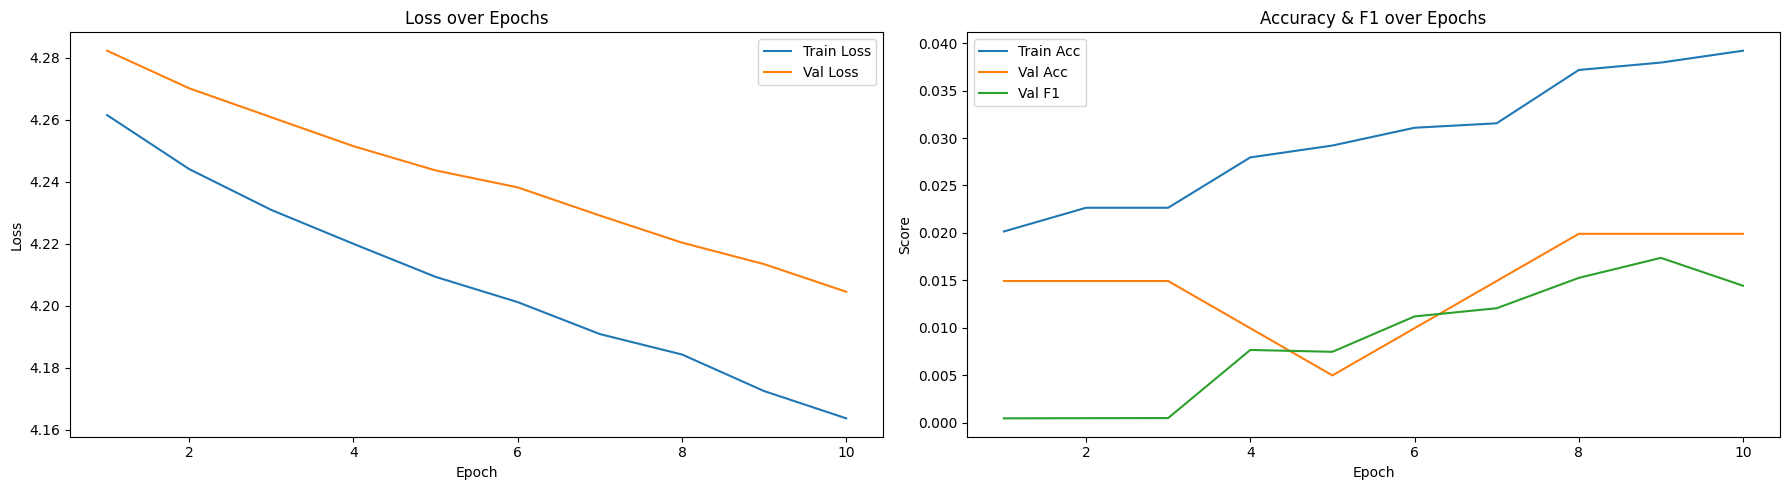

[I 2025-08-04 00:52:25,686] Trial 16 finished with values: [0.01990049751243781, 4.204571100016731, 0.014427860696517414] and parameters: {'d_model': 128, 'num_layers': 4, 'num_heads': 8, 'lr': 1e-06, 'batch_size': 16, 'dropout': 0.21373347107236523}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  4
num_heads:  8
dropout:  0.21373347107236523
learning rate:  1e-06
batch_szie:  16
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  2
num_heads:  4
dropout:  0.18561513755117603
learning rate:  1e-06
batch_szie:  32


Train labels:  [np.int64(34), np.int64(24), np.int64(33), np.int64(45), np.int64(3), np.int64(65), np.int64(26), np.int64(24), np.int64(51), np.int64(21)]
Pred labels:  [np.int64(22), np.int64(3), np.int64(0), np.int64(22), np.int64(17), np.int64(22), np.int64(0), np.int64(0), np.int64(44), np.int64(22)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(22), np.int64(22), np.int64(22), np.int64(44), np.int64(22), np.int64(3), np.int64(0), np.int64(44), np.int64(44)]
Epoch 1/10
Train Loss: 4.2675 | Train Acc: 0.0141
Val Loss: 4.2745 | Val Acc: 0.0149
Validation F1 Score: 0.0019


Train labels:  [np.int64(55), np.int64(36), np.int64(59), np.int64(34), np.int64(22), np.int64(24), np.int64(31), np.int64(42), np.int64(16), np.int64(14)]
Pred labels:  [np.int64(12), np.int64(0), np.int64(44), np.int64(0), np.int64(0), np.int64(5), np.int64(3), np.int64(22), np.int64(44), np.int64(22)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(22), np.int64(3), np.int64(44), np.int64(44), np.int64(44)]
Epoch 2/10
Train Loss: 4.2394 | Train Acc: 0.0198
Val Loss: 4.2545 | Val Acc: 0.0199
Validation F1 Score: 0.0019


Train labels:  [np.int64(29), np.int64(48), np.int64(14), np.int64(2), np.int64(45), np.int64(53), np.int64(25), np.int64(50), np.int64(7), np.int64(54)]
Pred labels:  [np.int64(44), np.int64(0), np.int64(12), np.int64(0), np.int64(44), np.int64(0), np.int64(44), np.int64(44), np.int64(17), np.int64(3)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(22), np.int64(3), np.int64(44), np.int64(44), np.int64(44)]
Epoch 3/10
Train Loss: 4.2106 | Train Acc: 0.0269
Val Loss: 4.2352 | Val Acc: 0.0149
Validation F1 Score: 0.0006


Train labels:  [np.int64(68), np.int64(59), np.int64(56), np.int64(37), np.int64(29), np.int64(14), np.int64(12), np.int64(20), np.int64(59), np.int64(16)]
Pred labels:  [np.int64(17), np.int64(12), np.int64(44), np.int64(44), np.int64(5), np.int64(12), np.int64(22), np.int64(44), np.int64(44), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(22), np.int64(25), np.int64(44), np.int64(44), np.int64(44)]
Epoch 4/10
Train Loss: 4.1851 | Train Acc: 0.0344
Val Loss: 4.2187 | Val Acc: 0.0249
Validation F1 Score: 0.0043


Train labels:  [np.int64(62), np.int64(30), np.int64(5), np.int64(56), np.int64(20), np.int64(46), np.int64(52), np.int64(52), np.int64(34), np.int64(65)]
Pred labels:  [np.int64(22), np.int64(44), np.int64(44), np.int64(22), np.int64(44), np.int64(22), np.int64(50), np.int64(44), np.int64(44), np.int64(22)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(44), np.int64(22), np.int64(25), np.int64(12), np.int64(44), np.int64(44)]
Epoch 5/10
Train Loss: 4.1620 | Train Acc: 0.0489
Val Loss: 4.2029 | Val Acc: 0.0199
Validation F1 Score: 0.0092


Train labels:  [np.int64(42), np.int64(59), np.int64(36), np.int64(13), np.int64(66), np.int64(57), np.int64(14), np.int64(16), np.int64(55), np.int64(14)]
Pred labels:  [np.int64(44), np.int64(12), np.int64(12), np.int64(44), np.int64(12), np.int64(46), np.int64(12), np.int64(44), np.int64(12), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(46), np.int64(22), np.int64(45), np.int64(44), np.int64(22), np.int64(25), np.int64(12), np.int64(44), np.int64(44)]
Epoch 6/10
Train Loss: 4.1371 | Train Acc: 0.0561
Val Loss: 4.1869 | Val Acc: 0.0299
Validation F1 Score: 0.0102


Train labels:  [np.int64(10), np.int64(62), np.int64(64), np.int64(34), np.int64(33), np.int64(65), np.int64(54), np.int64(62), np.int64(69), np.int64(40)]
Pred labels:  [np.int64(59), np.int64(44), np.int64(12), np.int64(44), np.int64(29), np.int64(22), np.int64(50), np.int64(44), np.int64(12), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(44), np.int64(22), np.int64(22), np.int64(45), np.int64(12), np.int64(22), np.int64(25), np.int64(12), np.int64(44), np.int64(44)]
Epoch 7/10
Train Loss: 4.1144 | Train Acc: 0.0698
Val Loss: 4.1697 | Val Acc: 0.0448
Validation F1 Score: 0.0217


Train labels:  [np.int64(37), np.int64(37), np.int64(36), np.int64(43), np.int64(41), np.int64(1), np.int64(30), np.int64(10), np.int64(34), np.int64(63)]
Pred labels:  [np.int64(12), np.int64(12), np.int64(12), np.int64(45), np.int64(46), np.int64(12), np.int64(10), np.int64(35), np.int64(37), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(33), np.int64(22), np.int64(22), np.int64(45), np.int64(12), np.int64(22), np.int64(25), np.int64(12), np.int64(44), np.int64(44)]
Epoch 8/10
Train Loss: 4.0894 | Train Acc: 0.0798
Val Loss: 4.1500 | Val Acc: 0.0498
Validation F1 Score: 0.0186


Train labels:  [np.int64(33), np.int64(56), np.int64(44), np.int64(60), np.int64(68), np.int64(48), np.int64(51), np.int64(54), np.int64(61), np.int64(29)]
Pred labels:  [np.int64(44), np.int64(12), np.int64(12), np.int64(44), np.int64(44), np.int64(12), np.int64(12), np.int64(56), np.int64(59), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(33), np.int64(33), np.int64(22), np.int64(45), np.int64(12), np.int64(22), np.int64(25), np.int64(12), np.int64(5), np.int64(45)]
Epoch 9/10
Train Loss: 4.0669 | Train Acc: 0.0942
Val Loss: 4.1289 | Val Acc: 0.0547
Validation F1 Score: 0.0205


Train labels:  [np.int64(34), np.int64(47), np.int64(61), np.int64(3), np.int64(6), np.int64(51), np.int64(53), np.int64(47), np.int64(54), np.int64(52)]
Pred labels:  [np.int64(46), np.int64(12), np.int64(12), np.int64(33), np.int64(12), np.int64(44), np.int64(46), np.int64(12), np.int64(45), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(45), np.int64(45), np.int64(22), np.int64(45), np.int64(35), np.int64(22), np.int64(45), np.int64(12), np.int64(5), np.int64(45)]
Epoch 10/10
Train Loss: 4.0362 | Train Acc: 0.1103
Val Loss: 4.1063 | Val Acc: 0.0746
Validation F1 Score: 0.0447


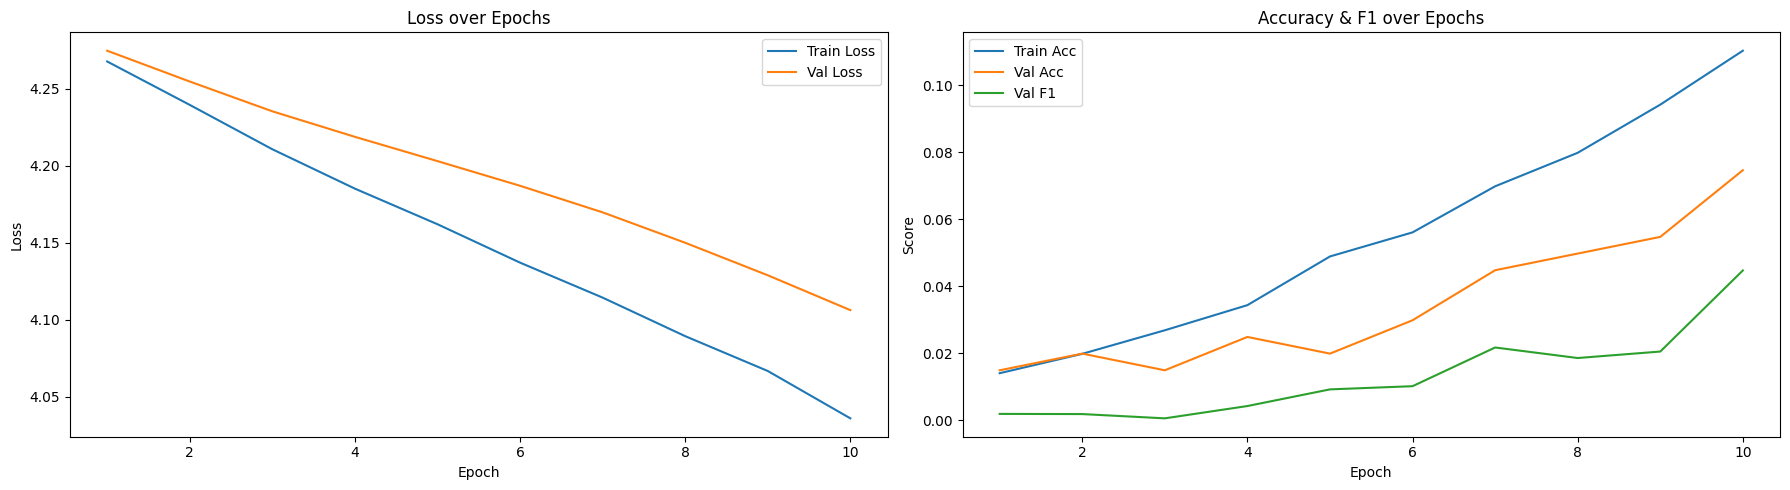

[I 2025-08-04 01:14:53,145] Trial 17 finished with values: [0.07462686567164178, 4.106311707947385, 0.04471061904271401] and parameters: {'d_model': 256, 'num_layers': 2, 'num_heads': 4, 'lr': 1e-06, 'batch_size': 32, 'dropout': 0.18561513755117603}.


Parameters chosen for this trial: 
d_model:  256
num_layers:  2
num_heads:  4
dropout:  0.18561513755117603
learning rate:  1e-06
batch_szie:  32
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  5
num_heads:  4
dropout:  0.24119225689889026
learning rate:  1e-06
batch_szie:  8


Train labels:  [np.int64(20), np.int64(37), np.int64(64), np.int64(6), np.int64(26), np.int64(60), np.int64(67), np.int64(50), np.int64(27), np.int64(56)]
Pred labels:  [np.int64(11), np.int64(38), np.int64(46), np.int64(11), np.int64(38), np.int64(21), np.int64(11), np.int64(21), np.int64(37), np.int64(11)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(21), np.int64(21), np.int64(45), np.int64(21), np.int64(21), np.int64(37), np.int64(21), np.int64(21), np.int64(45), np.int64(45)]
Epoch 1/10
Train Loss: 4.2511 | Train Acc: 0.0198
Val Loss: 4.2239 | Val Acc: 0.0299
Validation F1 Score: 0.0050


Train labels:  [np.int64(54), np.int64(21), np.int64(65), np.int64(27), np.int64(46), np.int64(55), np.int64(42), np.int64(57), np.int64(1), np.int64(68)]
Pred labels:  [np.int64(21), np.int64(37), np.int64(37), np.int64(21), np.int64(21), np.int64(19), np.int64(21), np.int64(34), np.int64(21), np.int64(43)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(21), np.int64(45), np.int64(45), np.int64(21), np.int64(45), np.int64(45), np.int64(23), np.int64(45), np.int64(45)]
Epoch 2/10
Train Loss: 4.1876 | Train Acc: 0.0353
Val Loss: 4.1788 | Val Acc: 0.0199
Validation F1 Score: 0.0038


Train labels:  [np.int64(47), np.int64(10), np.int64(42), np.int64(24), np.int64(9), np.int64(40), np.int64(51), np.int64(11), np.int64(52), np.int64(62)]
Pred labels:  [np.int64(48), np.int64(21), np.int64(12), np.int64(52), np.int64(37), np.int64(25), np.int64(45), np.int64(11), np.int64(45), np.int64(45)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(21), np.int64(45), np.int64(45), np.int64(62), np.int64(62), np.int64(62), np.int64(62), np.int64(45), np.int64(45)]
Epoch 3/10
Train Loss: 4.1344 | Train Acc: 0.0497
Val Loss: 4.1345 | Val Acc: 0.0299
Validation F1 Score: 0.0146


Train labels:  [np.int64(8), np.int64(67), np.int64(45), np.int64(63), np.int64(15), np.int64(64), np.int64(43), np.int64(17), np.int64(56), np.int64(32)]
Pred labels:  [np.int64(45), np.int64(62), np.int64(12), np.int64(23), np.int64(12), np.int64(45), np.int64(21), np.int64(21), np.int64(21), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(45), np.int64(45), np.int64(45), np.int64(33), np.int64(45), np.int64(52), np.int64(37), np.int64(45), np.int64(31)]
Epoch 4/10
Train Loss: 4.0813 | Train Acc: 0.0789
Val Loss: 4.0824 | Val Acc: 0.0796
Validation F1 Score: 0.0445


Train labels:  [np.int64(17), np.int64(12), np.int64(6), np.int64(33), np.int64(16), np.int64(64), np.int64(60), np.int64(5), np.int64(47), np.int64(63)]
Pred labels:  [np.int64(56), np.int64(12), np.int64(8), np.int64(36), np.int64(67), np.int64(45), np.int64(45), np.int64(45), np.int64(45), np.int64(52)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(45), np.int64(45), np.int64(45), np.int64(45), np.int64(45), np.int64(52), np.int64(37), np.int64(45), np.int64(31)]
Epoch 5/10
Train Loss: 4.0218 | Train Acc: 0.1078
Val Loss: 4.0218 | Val Acc: 0.0746
Validation F1 Score: 0.0346


Train labels:  [np.int64(43), np.int64(52), np.int64(66), np.int64(37), np.int64(46), np.int64(33), np.int64(66), np.int64(7), np.int64(16), np.int64(53)]
Pred labels:  [np.int64(46), np.int64(53), np.int64(21), np.int64(37), np.int64(21), np.int64(45), np.int64(62), np.int64(8), np.int64(1), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(45), np.int64(45), np.int64(45), np.int64(45), np.int64(62), np.int64(52), np.int64(37), np.int64(31), np.int64(31)]
Epoch 6/10
Train Loss: 3.9570 | Train Acc: 0.1329
Val Loss: 3.9719 | Val Acc: 0.0796
Validation F1 Score: 0.0395


Train labels:  [np.int64(44), np.int64(1), np.int64(40), np.int64(54), np.int64(52), np.int64(30), np.int64(25), np.int64(61), np.int64(5), np.int64(52)]
Pred labels:  [np.int64(42), np.int64(62), np.int64(25), np.int64(21), np.int64(45), np.int64(52), np.int64(36), np.int64(62), np.int64(62), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(45), np.int64(45), np.int64(45), np.int64(33), np.int64(62), np.int64(52), np.int64(37), np.int64(31), np.int64(31)]
Epoch 7/10
Train Loss: 3.8959 | Train Acc: 0.1539
Val Loss: 3.9196 | Val Acc: 0.1045
Validation F1 Score: 0.0597


Train labels:  [np.int64(43), np.int64(25), np.int64(69), np.int64(15), np.int64(57), np.int64(28), np.int64(25), np.int64(21), np.int64(51), np.int64(40)]
Pred labels:  [np.int64(46), np.int64(25), np.int64(37), np.int64(45), np.int64(34), np.int64(33), np.int64(45), np.int64(21), np.int64(41), np.int64(52)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(45), np.int64(45), np.int64(45), np.int64(33), np.int64(1), np.int64(52), np.int64(37), np.int64(31), np.int64(31)]
Epoch 8/10
Train Loss: 3.8319 | Train Acc: 0.1765
Val Loss: 3.8602 | Val Acc: 0.1194
Validation F1 Score: 0.0602


Train labels:  [np.int64(62), np.int64(16), np.int64(48), np.int64(17), np.int64(34), np.int64(3), np.int64(22), np.int64(6), np.int64(42), np.int64(25)]
Pred labels:  [np.int64(62), np.int64(62), np.int64(37), np.int64(27), np.int64(34), np.int64(45), np.int64(12), np.int64(25), np.int64(8), np.int64(25)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(51), np.int64(1), np.int64(45), np.int64(33), np.int64(1), np.int64(52), np.int64(37), np.int64(31), np.int64(31)]
Epoch 9/10
Train Loss: 3.7642 | Train Acc: 0.2112
Val Loss: 3.8067 | Val Acc: 0.1194
Validation F1 Score: 0.0593


Train labels:  [np.int64(41), np.int64(32), np.int64(51), np.int64(29), np.int64(47), np.int64(54), np.int64(6), np.int64(2), np.int64(11), np.int64(59)]
Pred labels:  [np.int64(21), np.int64(69), np.int64(45), np.int64(33), np.int64(47), np.int64(21), np.int64(21), np.int64(2), np.int64(25), np.int64(37)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(62), np.int64(51), np.int64(1), np.int64(45), np.int64(33), np.int64(1), np.int64(52), np.int64(37), np.int64(31), np.int64(31)]
Epoch 10/10
Train Loss: 3.7055 | Train Acc: 0.2279
Val Loss: 3.7602 | Val Acc: 0.1244
Validation F1 Score: 0.0524


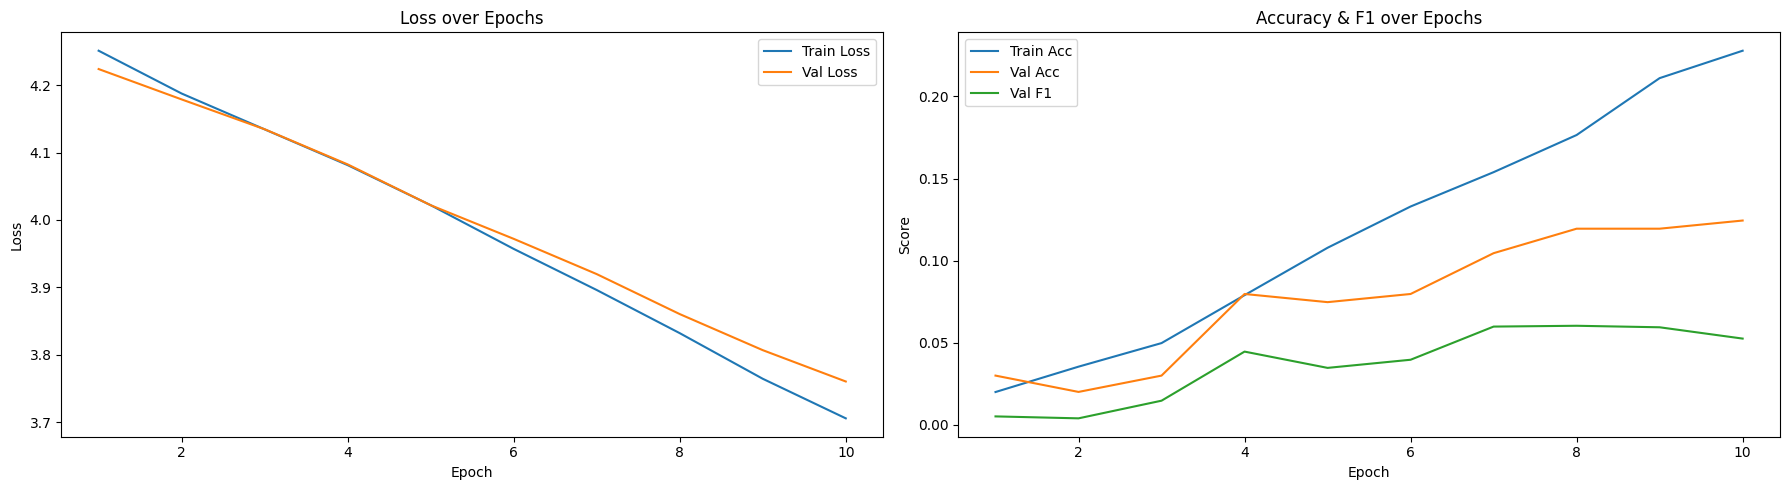

[I 2025-08-04 02:12:01,021] Trial 18 finished with values: [0.12437810945273632, 3.760174049073784, 0.05241142770993518] and parameters: {'d_model': 256, 'num_layers': 5, 'num_heads': 4, 'lr': 1e-06, 'batch_size': 8, 'dropout': 0.24119225689889026}.


Parameters chosen for this trial: 
d_model:  256
num_layers:  5
num_heads:  4
dropout:  0.24119225689889026
learning rate:  1e-06
batch_szie:  8
num_epochs:  2
Parameters chosen for this trial: 
d_model:  256
num_layers:  4
num_heads:  4
dropout:  0.1922624470528992
learning rate:  1e-05
batch_szie:  16


Train labels:  [np.int64(46), np.int64(26), np.int64(33), np.int64(13), np.int64(62), np.int64(68), np.int64(11), np.int64(24), np.int64(43), np.int64(32)]
Pred labels:  [np.int64(43), np.int64(43), np.int64(43), np.int64(43), np.int64(43), np.int64(43), np.int64(43), np.int64(37), np.int64(43), np.int64(43)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(33), np.int64(41), np.int64(41), np.int64(41), np.int64(33), np.int64(62), np.int64(62), np.int64(34), np.int64(62), np.int64(31)]
Epoch 1/10
Train Loss: 4.1328 | Train Acc: 0.0564
Val Loss: 4.0585 | Val Acc: 0.0647
Validation F1 Score: 0.0335


Train labels:  [np.int64(25), np.int64(19), np.int64(21), np.int64(25), np.int64(2), np.int64(2), np.int64(16), np.int64(25), np.int64(26), np.int64(12)]
Pred labels:  [np.int64(32), np.int64(33), np.int64(34), np.int64(33), np.int64(37), np.int64(37), np.int64(33), np.int64(33), np.int64(62), np.int64(37)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(28), np.int64(52), np.int64(45), np.int64(45), np.int64(52), np.int64(52), np.int64(37), np.int64(31), np.int64(31)]
Epoch 2/10
Train Loss: 3.8542 | Train Acc: 0.1495
Val Loss: 3.7861 | Val Acc: 0.1741
Validation F1 Score: 0.1252


Train labels:  [np.int64(11), np.int64(33), np.int64(59), np.int64(35), np.int64(15), np.int64(2), np.int64(14), np.int64(28), np.int64(20), np.int64(31)]
Pred labels:  [np.int64(45), np.int64(64), np.int64(12), np.int64(45), np.int64(45), np.int64(37), np.int64(67), np.int64(28), np.int64(37), np.int64(31)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(52), np.int64(41), np.int64(52), np.int64(50), np.int64(64), np.int64(52), np.int64(52), np.int64(12), np.int64(31), np.int64(31)]
Epoch 3/10
Train Loss: 3.5780 | Train Acc: 0.2421
Val Loss: 3.6041 | Val Acc: 0.1692
Validation F1 Score: 0.1341


Train labels:  [np.int64(68), np.int64(34), np.int64(12), np.int64(24), np.int64(48), np.int64(1), np.int64(67), np.int64(2), np.int64(51), np.int64(21)]
Pred labels:  [np.int64(68), np.int64(34), np.int64(12), np.int64(67), np.int64(12), np.int64(1), np.int64(67), np.int64(67), np.int64(41), np.int64(63)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(41), np.int64(41), np.int64(41), np.int64(41), np.int64(25), np.int64(41), np.int64(62), np.int64(32), np.int64(31), np.int64(31)]
Epoch 4/10
Train Loss: 3.3695 | Train Acc: 0.3315
Val Loss: 3.4699 | Val Acc: 0.2189
Validation F1 Score: 0.1699


Train labels:  [np.int64(24), np.int64(67), np.int64(10), np.int64(6), np.int64(3), np.int64(43), np.int64(37), np.int64(17), np.int64(69), np.int64(9)]
Pred labels:  [np.int64(24), np.int64(67), np.int64(50), np.int64(68), np.int64(31), np.int64(43), np.int64(32), np.int64(17), np.int64(12), np.int64(41)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(41), np.int64(41), np.int64(45), np.int64(25), np.int64(52), np.int64(52), np.int64(32), np.int64(31), np.int64(31)]
Epoch 5/10
Train Loss: 3.1670 | Train Acc: 0.4072
Val Loss: 3.2735 | Val Acc: 0.2935
Validation F1 Score: 0.2306


Train labels:  [np.int64(32), np.int64(44), np.int64(33), np.int64(21), np.int64(47), np.int64(44), np.int64(16), np.int64(42), np.int64(53), np.int64(9)]
Pred labels:  [np.int64(32), np.int64(64), np.int64(64), np.int64(17), np.int64(47), np.int64(44), np.int64(28), np.int64(64), np.int64(27), np.int64(42)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(41), np.int64(1), np.int64(45), np.int64(25), np.int64(1), np.int64(1), np.int64(32), np.int64(31), np.int64(31)]
Epoch 6/10
Train Loss: 3.0230 | Train Acc: 0.4466
Val Loss: 3.1475 | Val Acc: 0.3383
Validation F1 Score: 0.2921


Train labels:  [np.int64(51), np.int64(51), np.int64(2), np.int64(42), np.int64(34), np.int64(25), np.int64(20), np.int64(59), np.int64(40), np.int64(30)]
Pred labels:  [np.int64(43), np.int64(1), np.int64(67), np.int64(42), np.int64(34), np.int64(25), np.int64(23), np.int64(59), np.int64(64), np.int64(31)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 7/10
Train Loss: nan | Train Acc: 0.3115
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(5), np.int64(4), np.int64(56), np.int64(31), np.int64(69), np.int64(68), np.int64(22), np.int64(16), np.int64(29), np.int64(52)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 8/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004


Train labels:  [np.int64(68), np.int64(14), np.int64(0), np.int64(25), np.int64(26), np.int64(60), np.int64(57), np.int64(46), np.int64(24), np.int64(16)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Epoch 9/10
Train Loss: nan | Train Acc: 0.0155
Val Loss: nan | Val Acc: 0.0149
Validation F1 Score: 0.0004
Model may be overfitting, time to early stop: 


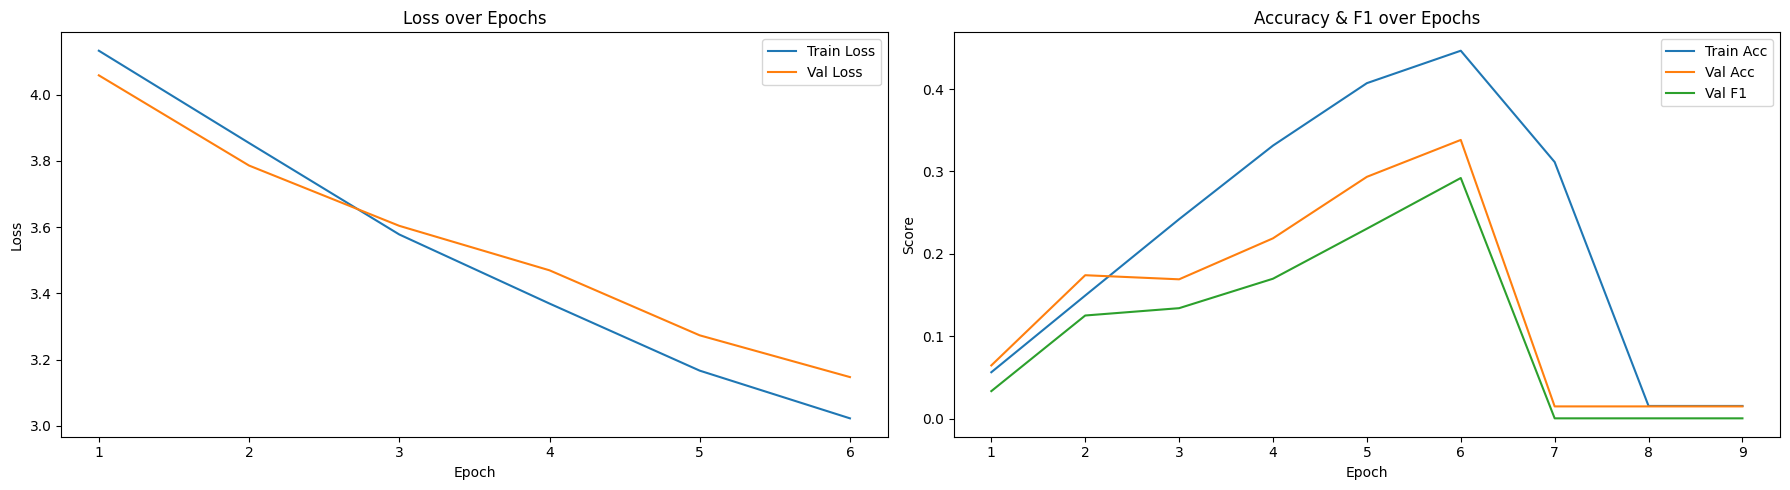

[W 2025-08-04 02:51:59,433] Trial 19 failed with parameters: {'d_model': 256, 'num_layers': 4, 'num_heads': 4, 'lr': 1e-05, 'batch_size': 16, 'dropout': 0.1922624470528992} because of the following error: The value nan is not acceptable.
[W 2025-08-04 02:51:59,434] Trial 19 failed with value (0.014925373134328358, nan, 0.0004389815627743634).


Parameters chosen for this trial: 
d_model:  256
num_layers:  4
num_heads:  4
dropout:  0.1922624470528992
learning rate:  1e-05
batch_szie:  16
num_epochs:  2
Val Acc: 0.8159, Val Loss: 0.7618, Params: {'d_model': 64, 'num_layers': 5, 'num_heads': 4, 'lr': 0.0001, 'batch_size': 16, 'dropout': 0.24384153866285602}


In [ ]:
def train(trial):

    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 8)
    num_heads = trial.suggest_categorical('num_heads', [4, 8])
    lr = trial.suggest_categorical('lr', [1e-6, 1e-5, 1e-4])
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    dropout = trial.suggest_float('dropout', 0.1, 0.3)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print("="*50)
    print("Parameters chosen for this trial: ")
    print("d_model: ", d_model)
    print("num_layers: ", num_layers)
    print("num_heads: ", num_heads)
    print("dropout: ", dropout)
    print("learning rate: ", lr)
    print("batch_szie: ", batch_size)
    print("="*50)

    model = SignatureEEGTransformer(
        sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
        eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
        d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
        sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len, dropout=dropout
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5) # weight_decay is for L2 regularization, to prevent overfitting
    loss_fn = nn.CrossEntropyLoss()
    num_epochs = 10

    best_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_labels, train_preds = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            sign_x_ts = batch['sign_x_ts'].to(device)
            sign_cls_token = batch['sign_cls_token'].to(device)
            sign_attention_mask = batch['sign_attention_mask'].to(device)
            eeg_x_ts = batch['eeg_x_ts'].to(device)
            eeg_cls_token = batch['eeg_cls_token'].to(device)
            eeg_attention_mask = batch['eeg_attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
            loss = loss_fn(logits, labels)
            loss.backward()

            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         assert not torch.isnan(param.grad).any(), f"NaN in gradient {name}"
            #         assert not torch.isinf(param.grad).any(), f"Inf in gradient {name}"

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(preds.cpu().numpy())
        print("Train labels: ", train_labels[:10])
        print("Pred labels: ", train_preds[:10])

        avg_train_loss = train_loss / len(train_labels)
        train_acc = accuracy_score(train_labels, train_preds)

        model.eval()
        val_loss, val_labels, val_preds = 0, [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
                sign_x_ts = batch['sign_x_ts'].to(device)
                sign_cls_token = batch['sign_cls_token'].to(device)
                sign_attention_mask = batch['sign_attention_mask'].to(device)
                eeg_x_ts = batch['eeg_x_ts'].to(device)
                eeg_cls_token = batch['eeg_cls_token'].to(device)
                eeg_attention_mask = batch['eeg_attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)

                # assert not torch.isnan(logits).any(), "NaN detected in your logits"
                # assert not torch.isinf(logits).any(), "Inf detected in your logits"

                loss = loss_fn(logits, labels)
                val_loss += loss.item() * labels.size(0)
                preds = logits.argmax(dim=1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())
        print("Val labels: ", val_labels[:10])
        print("Pred labels: ", val_preds[:10])

        avg_val_loss = val_loss / len(val_labels)
        val_acc = accuracy_score(val_labels, val_preds)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
        val_f1_score = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation F1 Score: {val_f1_score:.4f}")
        print("="*50)

        # Store metrics for plotting
        if epoch == 0:
            history = {
                'train_loss': [],
                'val_loss': [],
                'train_acc': [],
                'val_acc': [],
                'val_f1': []
            }
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(f1_score(val_labels, val_preds, average='weighted'))

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Model may be overfitting, time to early stop: ")
                break

    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Accuracy & F1 over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("="*50)
    print("Parameters chosen for this trial: ")
    print("d_model: ", d_model)
    print("num_layers: ", num_layers)
    print("num_heads: ", num_heads)
    print("dropout: ", dropout)
    print("learning rate: ", lr)
    print("batch_szie: ", batch_size)
    print("num_epochs: ", num_epochs if num_epochs == len(history) else len(history) - patience)
    print("="*50)

    return val_acc, avg_val_loss, val_f1_score

study = optuna.create_study(directions=["maximize", "minimize", "maximize"])
study.optimize(train, n_trials = 20)
# print("Best parameters for model: ", study.best_params)

for t in study.best_trials:
    print(f"Val Acc: {t.values[0]:.4f}, Val Loss: {t.values[1]:.4f}, Params: {t.params}")

In [ ]:
for t in study.best_trials:
    print(f"Val Acc: {t.values[0]:.4f}, Val Loss: {t.values[1]:.4f}, Params: {t.params}")

Val Acc: 0.8159, Val Loss: 0.7618, Params: {'d_model': 64, 'num_layers': 5, 'num_heads': 4, 'lr': 0.0001, 'batch_size': 16, 'dropout': 0.24384153866285602}


In [ ]:
with open("/content/best_params_10_aug.txt", "w") as f:
    f.write(str(study.best_params))

## Feeding Sign + EEG data to transformer - Training

In [ ]:
d_model = 128
num_layers = 7
num_heads = 4
lr=1e-5
batch_size=8
dropout = 0.1

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(13), np.int64(37), np.int64(60), np.int64(62), np.int64(36), np.int64(40), np.int64(51), np.int64(21), np.int64(24), np.int64(32)]
Pred labels:  [np.int64(67), np.int64(67), np.int64(67), np.int64(69), np.int64(67), np.int64(67), np.int64(67), np.int64(67), np.int64(67), np.int64(67)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(56), np.int64(62), np.int64(56), np.int64(45), np.int64(3), np.int64(52), np.int64(52), np.int64(37), np.int64(31), np.int64(31)]
Epoch 1/35
Train Loss: 3.9558 | Train Acc: 0.0998
Val Loss: 3.8003 | Val Acc: 0.1443
Validation F1 Score: 0.0917
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(26), np.int64(42), np.int64(8), np.int64(47), np.int64(37), np.int64(44), np.int64(34), np.int64(3), np.int64(20), np.int64(13)]
Pred labels:  [np.int64(26), np.int64(59), np.int64(8), np.int64(69), np.int64(69), np.int64(12), np.int64(37), np.int64(31), np.int64(66), np.int64(8)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(54), np.int64(62), np.int64(54), np.int64(54), np.int64(45), np.int64(54), np.int64(52), np.int64(37), np.int64(31), np.int64(31)]
Epoch 2/35
Train Loss: 3.4855 | Train Acc: 0.2723
Val Loss: 3.5404 | Val Acc: 0.1891
Validation F1 Score: 0.1292
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(68), np.int64(44), np.int64(44), np.int64(59), np.int64(69), np.int64(14), np.int64(0), np.int64(63), np.int64(32), np.int64(59)]
Pred labels:  [np.int64(12), np.int64(12), np.int64(12), np.int64(59), np.int64(69), np.int64(67), np.int64(56), np.int64(10), np.int64(37), np.int64(59)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(54), np.int64(51), np.int64(54), np.int64(54), np.int64(45), np.int64(54), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 3/35
Train Loss: 3.1746 | Train Acc: 0.3608
Val Loss: 3.3229 | Val Acc: 0.2040
Validation F1 Score: 0.1454
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(35), np.int64(28), np.int64(55), np.int64(41), np.int64(20), np.int64(11), np.int64(1), np.int64(41), np.int64(45), np.int64(29)]
Pred labels:  [np.int64(10), np.int64(28), np.int64(37), np.int64(54), np.int64(62), np.int64(45), np.int64(1), np.int64(54), np.int64(45), np.int64(33)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(54), np.int64(51), np.int64(0), np.int64(54), np.int64(45), np.int64(1), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 4/35
Train Loss: 2.8580 | Train Acc: 0.4566
Val Loss: 3.0442 | Val Acc: 0.3134
Validation F1 Score: 0.2550
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(52), np.int64(14), np.int64(41), np.int64(6), np.int64(7), np.int64(19), np.int64(65), np.int64(53), np.int64(31), np.int64(11)]
Pred labels:  [np.int64(62), np.int64(69), np.int64(54), np.int64(6), np.int64(37), np.int64(52), np.int64(69), np.int64(12), np.int64(31), np.int64(11)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(54), np.int64(51), np.int64(0), np.int64(54), np.int64(10), np.int64(1), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 5/35
Train Loss: 2.5769 | Train Acc: 0.5519
Val Loss: 2.8433 | Val Acc: 0.4030
Validation F1 Score: 0.3584
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(8), np.int64(19), np.int64(25), np.int64(12), np.int64(31), np.int64(54), np.int64(46), np.int64(30), np.int64(4), np.int64(47)]
Pred labels:  [np.int64(8), np.int64(62), np.int64(25), np.int64(12), np.int64(31), np.int64(54), np.int64(46), np.int64(33), np.int64(54), np.int64(47)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(54), np.int64(51), np.int64(0), np.int64(54), np.int64(45), np.int64(1), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 6/35
Train Loss: 2.2975 | Train Acc: 0.6304
Val Loss: 2.6354 | Val Acc: 0.3930
Validation F1 Score: 0.3435
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(65), np.int64(3), np.int64(57), np.int64(46), np.int64(15), np.int64(37), np.int64(5), np.int64(64), np.int64(4), np.int64(40)]
Pred labels:  [np.int64(65), np.int64(31), np.int64(57), np.int64(46), np.int64(10), np.int64(37), np.int64(52), np.int64(64), np.int64(4), np.int64(64)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(54), np.int64(51), np.int64(0), np.int64(45), np.int64(10), np.int64(1), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 7/35
Train Loss: 2.0510 | Train Acc: 0.7052
Val Loss: 2.4391 | Val Acc: 0.4428
Validation F1 Score: 0.3939
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(24), np.int64(45), np.int64(9), np.int64(5), np.int64(50), np.int64(22), np.int64(41), np.int64(34), np.int64(52), np.int64(12)]
Pred labels:  [np.int64(24), np.int64(45), np.int64(5), np.int64(5), np.int64(50), np.int64(22), np.int64(41), np.int64(34), np.int64(52), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(54), np.int64(51), np.int64(0), np.int64(45), np.int64(10), np.int64(1), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 8/35
Train Loss: 1.7992 | Train Acc: 0.7715
Val Loss: 2.2158 | Val Acc: 0.4876
Validation F1 Score: 0.4455
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(11), np.int64(45), np.int64(45), np.int64(45), np.int64(52), np.int64(8), np.int64(9), np.int64(4), np.int64(14), np.int64(12)]
Pred labels:  [np.int64(11), np.int64(45), np.int64(45), np.int64(45), np.int64(45), np.int64(8), np.int64(46), np.int64(4), np.int64(14), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(54), np.int64(51), np.int64(0), np.int64(45), np.int64(45), np.int64(1), np.int64(1), np.int64(46), np.int64(31), np.int64(31)]
Epoch 9/35
Train Loss: 1.5651 | Train Acc: 0.8269
Val Loss: 2.0776 | Val Acc: 0.5075
Validation F1 Score: 0.4719
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(67), np.int64(50), np.int64(37), np.int64(26), np.int64(44), np.int64(17), np.int64(59), np.int64(63), np.int64(19), np.int64(50)]
Pred labels:  [np.int64(67), np.int64(50), np.int64(37), np.int64(26), np.int64(44), np.int64(17), np.int64(59), np.int64(10), np.int64(19), np.int64(54)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(54), np.int64(51), np.int64(0), np.int64(51), np.int64(33), np.int64(1), np.int64(1), np.int64(37), np.int64(31), np.int64(31)]
Epoch 10/35
Train Loss: 1.3586 | Train Acc: 0.8654
Val Loss: 1.8880 | Val Acc: 0.6070
Validation F1 Score: 0.5749
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(11), np.int64(52), np.int64(12), np.int64(27), np.int64(20), np.int64(6), np.int64(45), np.int64(9), np.int64(11), np.int64(53)]
Pred labels:  [np.int64(11), np.int64(45), np.int64(12), np.int64(46), np.int64(20), np.int64(6), np.int64(45), np.int64(64), np.int64(11), np.int64(53)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(51), np.int64(33), np.int64(1), np.int64(1), np.int64(32), np.int64(31), np.int64(31)]
Epoch 11/35
Train Loss: 1.1751 | Train Acc: 0.8980
Val Loss: 1.7936 | Val Acc: 0.6418
Validation F1 Score: 0.6067
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(40), np.int64(33), np.int64(11), np.int64(16), np.int64(44), np.int64(45), np.int64(32), np.int64(61), np.int64(28), np.int64(13)]
Pred labels:  [np.int64(40), np.int64(33), np.int64(11), np.int64(16), np.int64(44), np.int64(45), np.int64(32), np.int64(61), np.int64(28), np.int64(57)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(45), np.int64(10), np.int64(1), np.int64(1), np.int64(37), np.int64(3), np.int64(31)]
Epoch 12/35
Train Loss: 1.0061 | Train Acc: 0.9205
Val Loss: 1.5774 | Val Acc: 0.7164
Validation F1 Score: 0.7004
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(36), np.int64(17), np.int64(11), np.int64(29), np.int64(34), np.int64(63), np.int64(6), np.int64(34), np.int64(45), np.int64(65)]
Pred labels:  [np.int64(36), np.int64(17), np.int64(11), np.int64(29), np.int64(34), np.int64(63), np.int64(6), np.int64(34), np.int64(45), np.int64(65)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(54), np.int64(33), np.int64(1), np.int64(1), np.int64(32), np.int64(3), np.int64(3)]
Epoch 13/35
Train Loss: 0.8557 | Train Acc: 0.9344
Val Loss: 1.4800 | Val Acc: 0.6915
Validation F1 Score: 0.6595
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(19), np.int64(23), np.int64(12), np.int64(24), np.int64(62), np.int64(10), np.int64(56), np.int64(16), np.int64(4), np.int64(62)]
Pred labels:  [np.int64(19), np.int64(23), np.int64(12), np.int64(24), np.int64(62), np.int64(35), np.int64(56), np.int64(16), np.int64(4), np.int64(62)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(54), np.int64(33), np.int64(1), np.int64(1), np.int64(32), np.int64(3), np.int64(31)]
Epoch 14/35
Train Loss: 0.7181 | Train Acc: 0.9545
Val Loss: 1.4339 | Val Acc: 0.6965
Validation F1 Score: 0.6714
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(42), np.int64(57), np.int64(60), np.int64(50), np.int64(53), np.int64(59), np.int64(19), np.int64(36), np.int64(8), np.int64(36)]
Pred labels:  [np.int64(42), np.int64(57), np.int64(60), np.int64(50), np.int64(53), np.int64(59), np.int64(19), np.int64(36), np.int64(8), np.int64(36)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(54), np.int64(10), np.int64(1), np.int64(1), np.int64(32), np.int64(3), np.int64(3)]
Epoch 15/35
Train Loss: 0.6115 | Train Acc: 0.9613
Val Loss: 1.2973 | Val Acc: 0.7313
Validation F1 Score: 0.7159
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(30), np.int64(5), np.int64(52), np.int64(69), np.int64(50), np.int64(35), np.int64(47), np.int64(14), np.int64(53), np.int64(44)]
Pred labels:  [np.int64(66), np.int64(5), np.int64(52), np.int64(69), np.int64(50), np.int64(35), np.int64(47), np.int64(14), np.int64(53), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(54), np.int64(64), np.int64(1), np.int64(1), np.int64(16), np.int64(3), np.int64(3)]
Epoch 16/35
Train Loss: 0.5314 | Train Acc: 0.9699
Val Loss: 1.2693 | Val Acc: 0.7313
Validation F1 Score: 0.7183
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(64), np.int64(37), np.int64(19), np.int64(31), np.int64(23), np.int64(37), np.int64(26), np.int64(19), np.int64(20), np.int64(48)]
Pred labels:  [np.int64(64), np.int64(37), np.int64(19), np.int64(31), np.int64(23), np.int64(37), np.int64(26), np.int64(19), np.int64(20), np.int64(48)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(54), np.int64(10), np.int64(1), np.int64(1), np.int64(32), np.int64(31), np.int64(31)]
Epoch 17/35
Train Loss: 0.4527 | Train Acc: 0.9755
Val Loss: 1.1963 | Val Acc: 0.7114
Validation F1 Score: 0.6863
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(6), np.int64(12), np.int64(15), np.int64(57), np.int64(53), np.int64(22), np.int64(47), np.int64(8), np.int64(50), np.int64(33)]
Pred labels:  [np.int64(6), np.int64(12), np.int64(15), np.int64(57), np.int64(53), np.int64(22), np.int64(47), np.int64(8), np.int64(50), np.int64(33)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(54), np.int64(35), np.int64(1), np.int64(1), np.int64(37), np.int64(3), np.int64(3)]
Epoch 18/35
Train Loss: 0.3790 | Train Acc: 0.9820
Val Loss: 1.0840 | Val Acc: 0.7662
Validation F1 Score: 0.7496
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(34), np.int64(65), np.int64(5), np.int64(51), np.int64(54), np.int64(60), np.int64(17), np.int64(33), np.int64(59), np.int64(59)]
Pred labels:  [np.int64(34), np.int64(65), np.int64(5), np.int64(51), np.int64(54), np.int64(60), np.int64(17), np.int64(33), np.int64(59), np.int64(59)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(54), np.int64(10), np.int64(1), np.int64(1), np.int64(32), np.int64(3), np.int64(3)]
Epoch 19/35
Train Loss: 0.3189 | Train Acc: 0.9870
Val Loss: 1.0641 | Val Acc: 0.7711
Validation F1 Score: 0.7463
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(54), np.int64(23), np.int64(13), np.int64(66), np.int64(3), np.int64(40), np.int64(61), np.int64(35), np.int64(61), np.int64(19)]
Pred labels:  [np.int64(54), np.int64(23), np.int64(13), np.int64(66), np.int64(3), np.int64(40), np.int64(61), np.int64(35), np.int64(61), np.int64(19)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(64), np.int64(1), np.int64(1), np.int64(32), np.int64(3), np.int64(3)]
Epoch 20/35
Train Loss: 0.2626 | Train Acc: 0.9905
Val Loss: 0.9682 | Val Acc: 0.7910
Validation F1 Score: 0.7743
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(16), np.int64(4), np.int64(63), np.int64(8), np.int64(46), np.int64(62), np.int64(65), np.int64(56), np.int64(0), np.int64(54)]
Pred labels:  [np.int64(16), np.int64(4), np.int64(63), np.int64(8), np.int64(46), np.int64(62), np.int64(65), np.int64(56), np.int64(0), np.int64(54)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(68), np.int64(64), np.int64(1), np.int64(1), np.int64(32), np.int64(3), np.int64(31)]
Epoch 21/35
Train Loss: 0.2158 | Train Acc: 0.9955
Val Loss: 1.0004 | Val Acc: 0.7413
Validation F1 Score: 0.7273
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(69), np.int64(59), np.int64(15), np.int64(66), np.int64(35), np.int64(37), np.int64(9), np.int64(66), np.int64(41), np.int64(67)]
Pred labels:  [np.int64(69), np.int64(59), np.int64(15), np.int64(66), np.int64(35), np.int64(37), np.int64(9), np.int64(66), np.int64(41), np.int64(67)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(54), np.int64(35), np.int64(1), np.int64(1), np.int64(37), np.int64(3), np.int64(3)]
Epoch 22/35
Train Loss: 0.1697 | Train Acc: 0.9972
Val Loss: 0.9017 | Val Acc: 0.7811
Validation F1 Score: 0.7663
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(42), np.int64(0), np.int64(2), np.int64(62), np.int64(64), np.int64(33), np.int64(24), np.int64(63), np.int64(13), np.int64(23)]
Pred labels:  [np.int64(42), np.int64(0), np.int64(2), np.int64(62), np.int64(64), np.int64(33), np.int64(24), np.int64(63), np.int64(13), np.int64(23)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(35), np.int64(1), np.int64(1), np.int64(37), np.int64(3), np.int64(3)]
Epoch 23/35
Train Loss: 0.1346 | Train Acc: 0.9991
Val Loss: 0.8472 | Val Acc: 0.7861
Validation F1 Score: 0.7710
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(57), np.int64(17), np.int64(34), np.int64(0), np.int64(15), np.int64(21), np.int64(45), np.int64(32), np.int64(65), np.int64(24)]
Pred labels:  [np.int64(57), np.int64(17), np.int64(34), np.int64(0), np.int64(15), np.int64(21), np.int64(45), np.int64(32), np.int64(65), np.int64(24)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(68), np.int64(64), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(31)]
Epoch 24/35
Train Loss: 0.1066 | Train Acc: 0.9995
Val Loss: 0.8695 | Val Acc: 0.7612
Validation F1 Score: 0.7493
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(10), np.int64(37), np.int64(46), np.int64(53), np.int64(69), np.int64(11), np.int64(50), np.int64(59), np.int64(20), np.int64(68)]
Pred labels:  [np.int64(10), np.int64(37), np.int64(46), np.int64(53), np.int64(69), np.int64(11), np.int64(50), np.int64(59), np.int64(20), np.int64(68)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(54), np.int64(35), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 25/35
Train Loss: 0.0843 | Train Acc: 0.9997
Val Loss: 0.8626 | Val Acc: 0.7612
Validation F1 Score: 0.7454
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(14), np.int64(1), np.int64(35), np.int64(64), np.int64(35), np.int64(19), np.int64(32), np.int64(32), np.int64(69), np.int64(68)]
Pred labels:  [np.int64(14), np.int64(1), np.int64(35), np.int64(64), np.int64(35), np.int64(19), np.int64(32), np.int64(32), np.int64(69), np.int64(68)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(9), np.int64(1), np.int64(1), np.int64(32), np.int64(3), np.int64(3)]
Epoch 26/35
Train Loss: 0.0702 | Train Acc: 0.9997
Val Loss: 0.7920 | Val Acc: 0.8060
Validation F1 Score: 0.8000
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(64), np.int64(47), np.int64(31), np.int64(30), np.int64(1), np.int64(7), np.int64(45), np.int64(29), np.int64(11), np.int64(41)]
Pred labels:  [np.int64(64), np.int64(47), np.int64(31), np.int64(30), np.int64(1), np.int64(7), np.int64(45), np.int64(29), np.int64(11), np.int64(41)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(35), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 27/35
Train Loss: 0.0550 | Train Acc: 0.9994
Val Loss: 0.7991 | Val Acc: 0.8060
Validation F1 Score: 0.7962
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(61), np.int64(35), np.int64(68), np.int64(59), np.int64(2), np.int64(47), np.int64(4), np.int64(29), np.int64(57), np.int64(59)]
Pred labels:  [np.int64(61), np.int64(35), np.int64(68), np.int64(59), np.int64(2), np.int64(47), np.int64(4), np.int64(29), np.int64(57), np.int64(59)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(1), np.int64(30), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 28/35
Train Loss: 0.0425 | Train Acc: 0.9997
Val Loss: 0.7170 | Val Acc: 0.8109
Validation F1 Score: 0.8050
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(0), np.int64(36), np.int64(35), np.int64(64), np.int64(22), np.int64(46), np.int64(29), np.int64(5), np.int64(3), np.int64(12)]
Pred labels:  [np.int64(0), np.int64(36), np.int64(35), np.int64(64), np.int64(22), np.int64(46), np.int64(29), np.int64(5), np.int64(3), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(9), np.int64(1), np.int64(1), np.int64(37), np.int64(3), np.int64(3)]
Epoch 29/35
Train Loss: 0.0328 | Train Acc: 0.9998
Val Loss: 0.7075 | Val Acc: 0.8060
Validation F1 Score: 0.8016
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(33), np.int64(64), np.int64(15), np.int64(14), np.int64(61), np.int64(62), np.int64(37), np.int64(11), np.int64(34), np.int64(48)]
Pred labels:  [np.int64(33), np.int64(64), np.int64(15), np.int64(14), np.int64(61), np.int64(62), np.int64(37), np.int64(11), np.int64(34), np.int64(48)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(1), np.int64(30), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 30/35
Train Loss: 0.0256 | Train Acc: 0.9998
Val Loss: 0.7625 | Val Acc: 0.7861
Validation F1 Score: 0.7749
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(59), np.int64(36), np.int64(1), np.int64(16), np.int64(55), np.int64(7), np.int64(20), np.int64(20), np.int64(50), np.int64(44)]
Pred labels:  [np.int64(59), np.int64(36), np.int64(1), np.int64(16), np.int64(55), np.int64(7), np.int64(20), np.int64(20), np.int64(50), np.int64(44)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(64), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 31/35
Train Loss: 0.0197 | Train Acc: 1.0000
Val Loss: 0.6940 | Val Acc: 0.8209
Validation F1 Score: 0.8140
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(1), np.int64(64), np.int64(23), np.int64(37), np.int64(29), np.int64(42), np.int64(8), np.int64(66), np.int64(28), np.int64(12)]
Pred labels:  [np.int64(1), np.int64(64), np.int64(23), np.int64(37), np.int64(29), np.int64(42), np.int64(8), np.int64(66), np.int64(28), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(51), np.int64(0), np.int64(1), np.int64(35), np.int64(1), np.int64(1), np.int64(37), np.int64(3), np.int64(3)]
Epoch 32/35
Train Loss: 0.0150 | Train Acc: 1.0000
Val Loss: 0.7362 | Val Acc: 0.7910
Validation F1 Score: 0.7847
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(25), np.int64(63), np.int64(36), np.int64(50), np.int64(25), np.int64(8), np.int64(29), np.int64(57), np.int64(44), np.int64(65)]
Pred labels:  [np.int64(25), np.int64(63), np.int64(36), np.int64(50), np.int64(25), np.int64(8), np.int64(29), np.int64(57), np.int64(44), np.int64(65)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(64), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 33/35
Train Loss: 0.0115 | Train Acc: 1.0000
Val Loss: 0.7320 | Val Acc: 0.8010
Validation F1 Score: 0.7940
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(40), np.int64(60), np.int64(0), np.int64(12), np.int64(54), np.int64(54), np.int64(21), np.int64(33), np.int64(53), np.int64(61)]
Pred labels:  [np.int64(40), np.int64(60), np.int64(0), np.int64(12), np.int64(54), np.int64(54), np.int64(21), np.int64(33), np.int64(53), np.int64(61)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(30), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Epoch 34/35
Train Loss: 0.0094 | Train Acc: 1.0000
Val Loss: 0.6878 | Val Acc: 0.8259
Validation F1 Score: 0.8197
Learning Rate for this epoch:  1e-05


Train labels:  [np.int64(46), np.int64(65), np.int64(23), np.int64(53), np.int64(6), np.int64(54), np.int64(69), np.int64(47), np.int64(37), np.int64(12)]
Pred labels:  [np.int64(46), np.int64(65), np.int64(23), np.int64(53), np.int64(6), np.int64(54), np.int64(69), np.int64(47), np.int64(37), np.int64(12)]


Val labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(3)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(64), np.int64(1), np.int64(1), np.int64(37), np.int64(3), np.int64(3)]
Epoch 35/35
Train Loss: 0.0076 | Train Acc: 1.0000
Val Loss: 0.7233 | Val Acc: 0.7960
Validation F1 Score: 0.7908


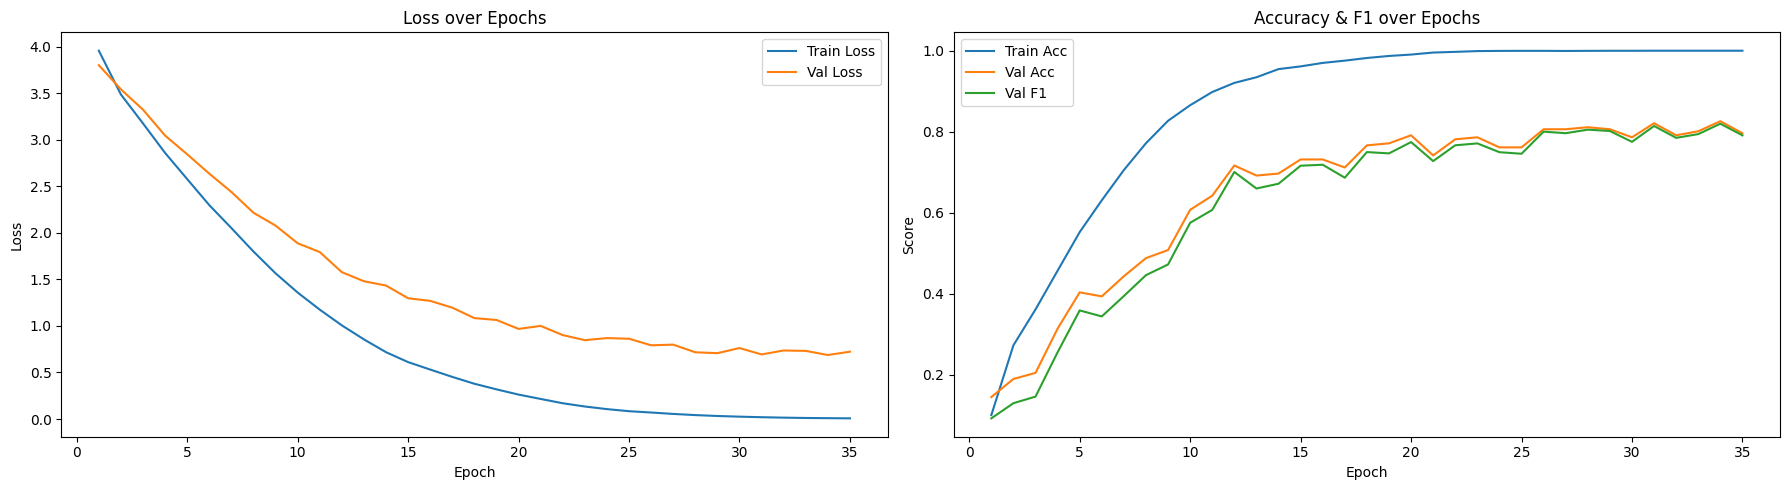

In [ ]:
model = SignatureEEGTransformer(
    sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
    eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
    d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
    sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len, dropout=dropout
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # weight_decay is for L2 regularization, to prevent overfitting
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 35

best_loss = float('inf')
patience = 3
counter = 0

for epoch in range(num_epochs):
    print("Learning Rate for this epoch: ", optimizer.param_groups[0]['lr'])
    model.train()
    train_loss, train_labels, train_preds = 0, [], []
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=0.0, neginf=0.0)
        loss = loss_fn(logits, labels)
        loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                assert not torch.isnan(param.grad).any(), f"NaN in gradient {name}"
                assert not torch.isinf(param.grad).any(), f"Inf in gradient {name}"

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(preds.cpu().numpy())
    print("Train labels: ", train_labels[:10])
    print("Pred labels: ", train_preds[:10])

    avg_train_loss = train_loss / len(train_labels)
    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    val_loss, val_labels, val_preds = 0, [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=False):
            sign_x_ts = batch['sign_x_ts'].to(device)
            sign_cls_token = batch['sign_cls_token'].to(device)
            sign_attention_mask = batch['sign_attention_mask'].to(device)
            eeg_x_ts = batch['eeg_x_ts'].to(device)
            eeg_cls_token = batch['eeg_cls_token'].to(device)
            eeg_attention_mask = batch['eeg_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
            logits = torch.nan_to_num(logits, nan=0.0, posinf=0.0, neginf=0.0)
            assert not torch.isnan(logits).any(), "NaN detected in your logits"
            assert not torch.isinf(logits).any(), "Inf detected in your logits"

            loss = loss_fn(logits, labels)
            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
    print("Val labels: ", val_labels[:10])
    print("Pred labels: ", val_preds[:10])

    avg_val_loss = val_loss / len(val_labels)
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Validation F1 Score: {f1_score(val_labels, val_preds, average='weighted'):.4f}")
    print("="*50)

    # Store metrics for plotting
    if epoch == 0:
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'val_f1': []
        }
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(f1_score(val_labels, val_preds, average='weighted'))

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Model may be overfitting, time to early stop: ")
            break
    # lr_scheduler.step()
    # scheduler.step(avg_val_loss)
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.plot(epochs, history['val_f1'], label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy & F1 over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), os.path.join(os.getenv("MODEL_SAVE_PATH"), f"multimodal_model_{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth"))

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(val_labels, val_preds))
print("Classification Report:")
print(classification_report(val_labels, val_preds))

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       1.00      0.67      0.80         3
           2       0.50      1.00      0.67         1
           3       0.50      0.33      0.40         3
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         2
           7       0.67      0.67      0.67         3
           8       0.75      1.00      0.86         3
           9       0.67      0.50      0.57         4
          10       0.40      0.50      0.44         4
          11       1.00      1.00      1.00         1
          12       0.67      1.00      0.80         4
          13       0.50      0.50      0.50         2
          14       0.80      1.00      0.89         4
          15       0.57     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Validating Sign+EEG tranformer model

In [ ]:
print(set([x for x in user_id_to_num_map.values()]))
print(user_id_to_num_map)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
{'000000802810034': 0, '000140809082110': 1, '001810111230005': 2, '000000001941061': 3, '000000003150143': 4, '000000001046474': 5, '000000814510023': 6, '000000001045402': 7, '000000000200894': 8, '001810111230006': 9, '002008410100008': 10, '002008410100015': 11, '002008410100025': 12, '002008410100030': 13, '002008410100013': 14, '002008410100011': 15, '002008410100016': 16, '002008410100040': 17, '002008410100024': 18, '002008410100018': 19, '002108410100006': 20, '002108410100005': 21, '002108410100002': 22, '002008410100052': 23, '002108410100001': 24, '002008410100044': 25, '002008410300021': 26, '002008410100050': 27, '002008410100065': 28, '002108410100003': 29, '002108410100016': 30, '002108410100012': 31, '0

In [ ]:
print([x['user_id'] for x in raw_val_data])

['000000802810034', '000000802810034', '000000802810034', '000140809082110', '000140809082110', '001810111230005', '001810111230005', '001810111230005', '001810111230005', '000000001941061', '000000001941061', '000000001941061', '000000001941061', '000000001941061', '000000001941061', '000000003150143', '000000003150143', '000000003150143', '000000003150143', '000000001046474', '000000001046474', '000000814510023', '000000814510023', '000000814510023', '000000001045402', '000000001045402', '000000001045402', '000000000200894', '000000000200894', '001810111230006', '001810111230006', '001810111230006', '002008410100008', '002008410100008', '002008410100008', '002008410100015', '002008410100015', '002008410100015', '002008410100015', '002008410100025', '002008410100030', '002008410100030', '002008410100030', '002008410100030', '002008410100030', '002008410100013', '002008410100013', '002008410100013', '002008410100011', '002008410100011', '002008410100011', '002008410100011', '0020084101

In [ ]:
# validation loop

# Augment and preprocess test data (no augmentation, just features and padding)
for i in range(len(raw_val_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_val_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_val_data[i]['eeg_data'])
    raw_val_data[i]['sign_data'] = sign_data_with_features
    raw_val_data[i]['sign_cls_token'] = sign_cls_token
    raw_val_data[i]['eeg_data'] = eeg_data_with_features
    raw_val_data[i]['eeg_cls_token'] = eeg_cls_token
    raw_val_data[i]['user_id'] = user_id_to_num_map[raw_val_data[i]['user_id']]

sign_max_seq_len_test = max_seq_len_for_data
eeg_max_seq_len_test = 10

for i in range(len(raw_val_data)):
    sign_data = raw_val_data[i]['sign_data']
    eeg_data = raw_val_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len_test)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len_test)
    raw_val_data[i]['sign_data'] = sign_data
    raw_val_data[i]['eeg_data'] = eeg_data
    raw_val_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_val_data[i]['eeg_attention_mask'] = eeg_attention_mask

val_input_data = {
    'sign_data': [data['sign_data'] for data in raw_val_data],
    'eeg_data': [data['eeg_data'] for data in raw_val_data],
    'sign_attention_masks': [data['sign_attention_mask'] for data in raw_val_data],
    'eeg_attention_masks': [data['eeg_attention_mask'] for data in raw_val_data],
    'sign_cls_tokens': [data['sign_cls_token'] for data in raw_val_data],
    'eeg_cls_tokens': [data['eeg_cls_token'] for data in raw_val_data],
    'labels': [data['user_id'] for data in raw_val_data],
}

sign_ts_dim = val_input_data['sign_data'][0].size(1)
sign_cls_dim = val_input_data['sign_cls_tokens'][0].size(0)
sign_seq_len = val_input_data['sign_data'][0].size(0)
eeg_ts_dim = val_input_data['eeg_data'][0].size(1)
eeg_cls_dim = val_input_data['eeg_cls_tokens'][0].size(0)
eeg_seq_len = val_input_data['eeg_data'][0].size(0)

val_dataset = SignatureEEGDataset(val_input_data, num_classes)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

/tmp/ipython-input-2072833470.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
/tmp/ipython-input-4230723650.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 136, using nperseg = 136
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
/tmp/ipython-input-4230723650.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 197, using nperseg = 197
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
/tmp/ipython-input-4230723650.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 203, using nperseg = 203
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)


In [ ]:
print(len(val_input_data['labels']))

187


In [ ]:
print(val_input_data['labels'])

[0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 13, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 17, 17, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 23, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 32, 32, 34, 34, 34, 34, 35, 35, 36, 36, 36, 36, 36, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 46, 47, 47, 47, 48, 48, 50, 50, 50, 51, 51, 51, 52, 52, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 55, 56, 56, 56, 56, 57, 57, 57, 59, 59, 60, 60, 60, 60, 61, 61, 61, 61, 62, 63, 63, 63, 63, 64, 65, 66, 66, 66, 67, 67, 67, 68, 69]


In [ ]:
model = SignatureEEGTransformer(
    sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
    eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
    d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
    sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
).to(device)

model.load_state_dict(torch.load(os.path.join(os.getenv("MODEL_LOAD_PATH"), "multimodal_model_08062025-214241.pth")))

loss_fn = nn.CrossEntropyLoss()

model.eval()
val_loss = 0
val_labels = []
val_preds = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        loss = loss_fn(logits, labels)
        val_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())

avg_val_loss = val_loss / len(val_labels)
val_acc = accuracy_score(val_labels, val_preds)
val_prec = precision_score(val_labels, val_preds, zero_division=0, average='macro')
val_rec = recall_score(val_labels, val_preds, zero_division=0, average='macro')
val_f1 = f1_score(val_labels, val_preds, zero_division=0, average='macro')

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_prec:.4f}")
print(f"Validation Recall: {val_rec:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# Additional performance metrics and visualizations

# 1. Confusion Matrix with heatmap
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. Per-class metrics
plt.subplot(1, 3, 2)
class_report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)
classes = list(class_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
precision_scores = [class_report[cls]['precision'] for cls in classes if cls.isdigit()]
recall_scores = [class_report[cls]['recall'] for cls in classes if cls.isdigit()]
f1_scores = [class_report[cls]['f1-score'] for cls in classes if cls.isdigit()]

x = range(len(precision_scores))
width = 0.25
plt.bar([i - width for i in x], precision_scores, width, label='Precision', alpha=0.8)
plt.bar(x, recall_scores, width, label='Recall', alpha=0.8)
plt.bar([i + width for i in x], f1_scores, width, label='F1-Score', alpha=0.8)
plt.xlabel('User ID')
plt.ylabel('Score')
plt.title('Per-Class Performance Metrics')
plt.legend()
plt.xticks(x, [f'User {i}' for i in range(len(precision_scores))])

# 3. ROC Curve (for binary classification per class)
plt.subplot(1, 3, 3)
# Convert to binary classification for each class
y_true_bin = label_binarize(val_labels, classes=range(num_classes))
y_score = torch.softmax(torch.tensor([model(
    batch['sign_x_ts'].to(device), batch['sign_cls_token'].to(device),
    batch['eeg_x_ts'].to(device), batch['eeg_cls_token'].to(device),
    batch['sign_attention_mask'].to(device), batch['eeg_attention_mask'].to(device)
).cpu().detach() for batch in val_loader]), dim=-1).numpy()

# Calculate ROC for each class and plot micro-average
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Micro-avg ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# 4. Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(val_labels, val_preds, zero_division=0))

# 5. Top-k accuracy
def top_k_accuracy(y_true, y_pred_proba, k=3):
    top_k_preds = np.argsort(y_pred_proba, axis=1)[:, -k:]
    correct = 0
    for i, true_label in enumerate(y_true):
        if true_label in top_k_preds[i]:
            correct += 1
    return correct / len(y_true)

# Get prediction probabilities
model.eval()
all_probs = []
with torch.no_grad():
    for batch in val_loader:
        logits = model(
            batch['sign_x_ts'].to(device), batch['sign_cls_token'].to(device),
            batch['eeg_x_ts'].to(device), batch['eeg_cls_token'].to(device),
            batch['sign_attention_mask'].to(device), batch['eeg_attention_mask'].to(device)
        )
        probs = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.vstack(all_probs)
top3_acc = top_k_accuracy(val_labels, all_probs, k=3)
top5_acc = top_k_accuracy(val_labels, all_probs, k=5)

print(f"\nTop-3 Accuracy: {top3_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")

# 6. Error analysis - show misclassified samples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(val_labels, val_preds)) if true != pred]
print(f"\nMisclassified samples: {len(misclassified_indices)} out of {len(val_labels)}")
if misclassified_indices:
    print("Sample misclassifications:")
    for i in misclassified_indices[:5]:  # Show first 5
        print(f"  Sample {i}: True={val_labels[i]}, Predicted={val_preds[i]}")

Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
                                                           

Validation Loss: 0.7736
Validation Accuracy: 0.7701
Validation Precision: 0.7351
Validation Recall: 0.7390
Validation F1 Score: 0.7184


In [ ]:
print([i for i in zip(val_labels, val_preds)])

[(np.int64(25), np.int64(39)), (np.int64(25), np.int64(39)), (np.int64(42), np.int64(68)), (np.int64(42), np.int64(55)), (np.int64(42), np.int64(68)), (np.int64(49), np.int64(40)), (np.int64(49), np.int64(14)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(18), np.int64(13)), (np.int64(34), np.int64(32)), (np.int64(34), np.int64(32)), (np.int64(34), np.int64(32)), (np.int64(34), np.int64(32)), (np.int64(2), np.int64(31)), (np.int64(2), np.int64(31)), (np.int64(2), np.int64(31)), (np.int64(7), np.int64(37)), (np.int64(7), np.int64(37)), (np.int64(7), np.int64(37)), (np.int64(26), np.int64(66)), (np.int64(26), np.int64(27)), (np.int64(47), np.int64(10)), (np.int64(47), np.int64(10)), (np.int64(47), np.int64(10)), (np.int64(47), np.int64(10)), (np.int64(39), np.int64(53)), (np.int64(39), np.int64(36)), (np.int64(39), np.int64(53)), (np.int64(17), np.int64(30)), (np.int64(17), 

## User Identification - Feature ranking

Preparing data for SHAP analysis...
Sign features: 15, EEG features: 11
Total features: 26
Creating SHAP explainer...
Calculating SHAP values...


PermutationExplainer explainer: 31it [01:03,  2.37s/it]
/tmp/ipython-input-1467192903.py:105: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, 0], shap_data[:30],


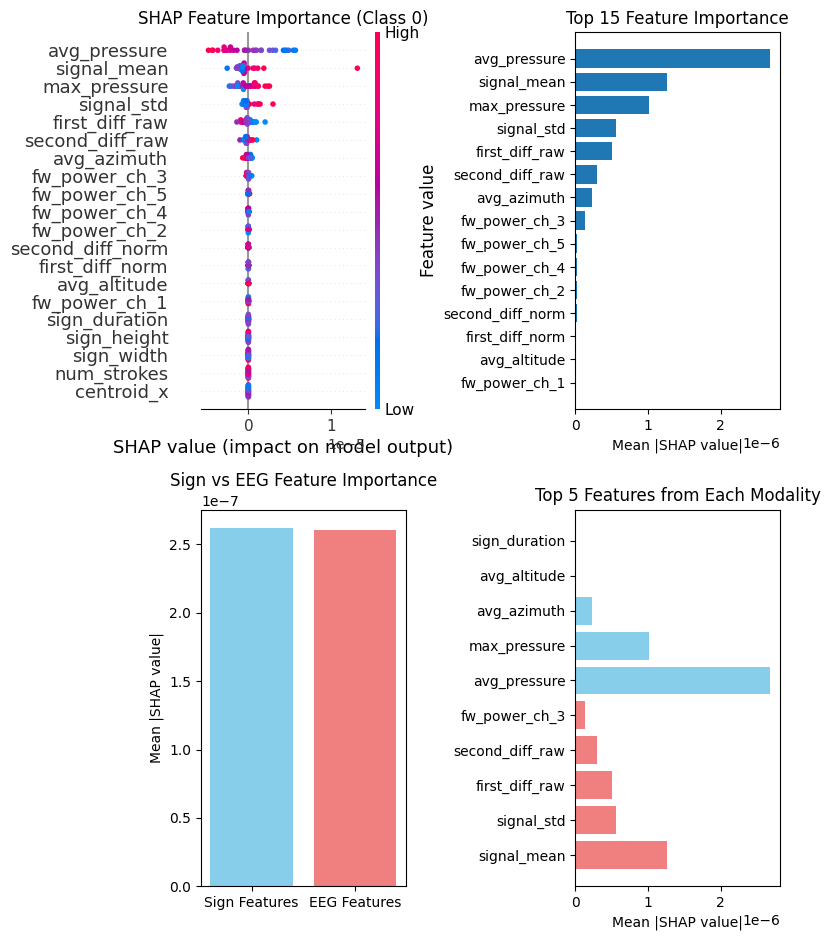


FEATURE IMPORTANCE ANALYSIS

Overall Feature Ranking:
 1. avg_pressure              | 0.000003 | Sign
 2. signal_mean               | 0.000001 | EEG
 3. max_pressure              | 0.000001 | Sign
 4. signal_std                | 0.000001 | EEG
 5. first_diff_raw            | 0.000001 | EEG
 6. second_diff_raw           | 0.000000 | EEG
 7. avg_azimuth               | 0.000000 | Sign
 8. fw_power_ch_3             | 0.000000 | EEG
 9. fw_power_ch_5             | 0.000000 | EEG
10. fw_power_ch_4             | 0.000000 | EEG
11. fw_power_ch_2             | 0.000000 | EEG
12. second_diff_norm          | 0.000000 | EEG
13. first_diff_norm           | 0.000000 | EEG
14. avg_altitude              | 0.000000 | Sign
15. fw_power_ch_1             | 0.000000 | EEG
16. sign_duration             | 0.000000 | Sign
17. sign_height               | 0.000000 | Sign
18. sign_width                | 0.000000 | Sign
19. num_strokes               | 0.000000 | Sign
20. centroid_x                | 0.000000 | S

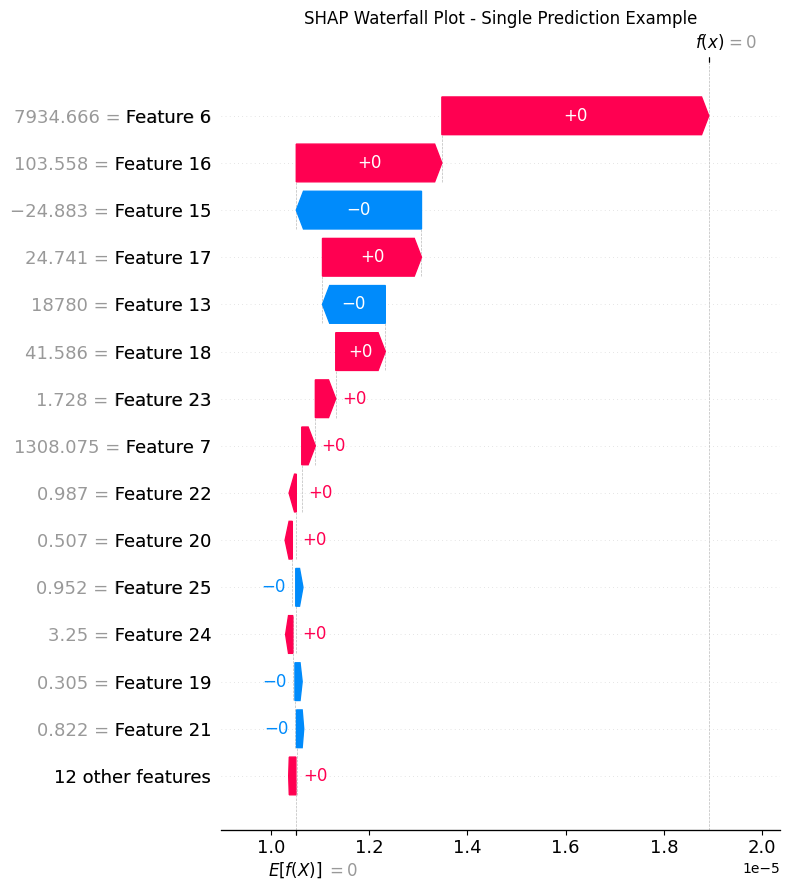

In [ ]:
class SHAPModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()

    def predict(self, X):
        batch_size = X.shape[0]

        sign_cls_tokens = torch.tensor(X[:, :sign_cls_dim], dtype=torch.float32).to(self.device)
        eeg_cls_tokens = torch.tensor(X[:, sign_cls_dim:], dtype=torch.float32).to(self.device)

        sign_x_ts = torch.zeros((batch_size, sign_seq_len, sign_ts_dim), dtype=torch.float32).to(self.device)
        eeg_x_ts = torch.zeros((batch_size, eeg_seq_len, eeg_ts_dim), dtype=torch.float32).to(self.device)

        sign_attention_mask = torch.zeros((batch_size, sign_seq_len + 1), dtype=torch.float32).to(self.device)
        sign_attention_mask[:, 0] = 1  # CLS token is always attended to
        eeg_attention_mask = torch.zeros((batch_size, eeg_seq_len + 1), dtype=torch.float32).to(self.device)
        eeg_attention_mask[:, 0] = 1   # CLS token is always attended to

        with torch.no_grad():
            logits = self.model(sign_x_ts, sign_cls_tokens, eeg_x_ts, eeg_cls_tokens,
                              sign_attention_mask, eeg_attention_mask)
            probabilities = torch.softmax(logits, dim=1)

        return probabilities.cpu().numpy()

def prepare_shap_data(dataset, max_samples=200):
    sign_cls_features = []
    eeg_cls_features = []
    labels = []

    indices = np.random.choice(len(dataset), min(max_samples, len(dataset)), replace=False)

    for idx in indices:
        sample = dataset[idx]
        sign_cls_features.append(sample['sign_cls_token'].numpy())
        eeg_cls_features.append(sample['eeg_cls_token'].numpy())
        labels.append(sample['labels'])

    sign_cls_features = np.array(sign_cls_features)
    eeg_cls_features = np.array(eeg_cls_features)
    combined_features = np.concatenate([sign_cls_features, eeg_cls_features], axis=1)

    return combined_features, np.array(labels), sign_cls_features.shape[1], eeg_cls_features.shape[1]

def create_feature_names():
    sign_feature_names = [
        'num_strokes', 'sign_height', 'sign_width', 'height_width_ratio',
        'centroid_x', 'centroid_y', 'avg_pressure', 'avg_azimuth', 'avg_altitude',
        'avg_vx', 'avg_vy', 'avg_ax', 'avg_ay', 'max_pressure', 'sign_duration'
    ]

    eeg_feature_names = [
        'signal_mean', 'signal_std', 'first_diff_raw', 'second_diff_raw',
        'first_diff_norm', 'second_diff_norm'
    ]

    num_eeg_channels = eeg_cls_dim - 6  # Subtract the 6 basic features
    for i in range(num_eeg_channels):
        eeg_feature_names.append(f'fw_power_ch_{i+1}')

    return sign_feature_names + eeg_feature_names

print("Preparing data for SHAP analysis...")
shap_data, shap_labels, sign_feat_count, eeg_feat_count = prepare_shap_data(val_dataset, max_samples=100)
feature_names = create_feature_names()

print(f"Sign features: {sign_feat_count}, EEG features: {eeg_feat_count}")
print(f"Total features: {len(feature_names)}")

model_wrapper = SHAPModelWrapper(model, device)

print("Creating SHAP explainer...")
explainer = shap.Explainer(model_wrapper.predict, shap_data[:50])  # Use subset as background

print("Calculating SHAP values...")
shap_values = explainer(shap_data[:30])  # Analyze subset for computational efficiency

plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
shap.summary_plot(shap_values.values[:, :, 0], shap_data[:30],
                  feature_names=feature_names, show=False, max_display=20)
plt.title('SHAP Feature Importance (Class 0)')

plt.subplot(2, 2, 2)
mean_shap_values = np.mean(np.abs(shap_values.values[:, :, 0]), axis=0)
feature_importance = list(zip(feature_names, mean_shap_values))
feature_importance.sort(key=lambda x: x[1], reverse=True)

top_features = feature_importance[:15]
features, importances = zip(*top_features)

plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel('Mean |SHAP value|')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()

plt.subplot(2, 2, 3)
sign_importances = mean_shap_values[:sign_feat_count]
eeg_importances = mean_shap_values[sign_feat_count:]

categories = ['Sign Features', 'EEG Features']
category_importances = [np.mean(sign_importances), np.mean(eeg_importances)]

plt.bar(categories, category_importances, color=['skyblue', 'lightcoral'])
plt.ylabel('Mean |SHAP value|')
plt.title('Sign vs EEG Feature Importance')

plt.subplot(2, 2, 4)
top_sign_idx = np.argsort(sign_importances)[-5:]
top_eeg_idx = np.argsort(eeg_importances)[-5:] + sign_feat_count

top_sign_features = [feature_names[i] for i in top_sign_idx]
top_eeg_features = [feature_names[i] for i in top_eeg_idx]

all_top_features = top_sign_features + top_eeg_features
all_top_importances = [mean_shap_values[i] for i in top_sign_idx] + [mean_shap_values[i] for i in top_eeg_idx]
colors = ['skyblue'] * 5 + ['lightcoral'] * 5

plt.barh(range(len(all_top_features)), all_top_importances, color=colors)
plt.yticks(range(len(all_top_features)), all_top_features)
plt.xlabel('Mean |SHAP value|')
plt.title('Top 5 Features from Each Modality')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

print(f"\nOverall Feature Ranking:")
for i, (feature, importance) in enumerate(feature_importance[:20]):
    modality = "Sign" if feature in feature_names[:sign_feat_count] else "EEG"
    print(f"{i+1:2d}. {feature:25s} | {importance:.6f} | {modality}")

print(f"\nSign Features (Average importance: {np.mean(sign_importances):.6f}):")
sign_ranking = [(feature_names[i], sign_importances[i]) for i in range(sign_feat_count)]
sign_ranking.sort(key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(sign_ranking[:10]):
    print(f"{i+1:2d}. {feature:25s} | {importance:.6f}")

print(f"\nEEG Features (Average importance: {np.mean(eeg_importances):.6f}):")
eeg_ranking = [(feature_names[i], eeg_importances[i-sign_feat_count]) for i in range(sign_feat_count, len(feature_names))]
eeg_ranking.sort(key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(eeg_ranking[:10]):
    print(f"{i+1:2d}. {feature:25s} | {importance:.6f}")

if len(shap_values.values) > 0:
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(shap_values[0, :, 0], max_display=15, show=False)
    plt.title('SHAP Waterfall Plot - Single Prediction Example')
    plt.tight_layout()
    plt.show()

# Sign + EEG Forgery Detection

## Getting the data from dataset

In [28]:
train_files, _, train_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type = constants.TRAIN)
test_files, _, test_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.TEST)
val_files, _, val_labels = get_dataset_files_and_user_ids(data_category=constants.ALL, data_type=constants.VALIDATION)

print("Train files: ", len(train_files))
print("Test files: ", len(test_files))
print("Val files: ", len(val_files))

raw_train_data = get_sig_eeg_raw_data(train_files, train_labels)
raw_test_data = get_sig_eeg_raw_data(test_files, test_labels)
raw_val_data = get_sig_eeg_raw_data(val_files, val_labels)

Train files:  1138
Test files:  379
Val files:  380


## Extract features and add Padding

In [ ]:
augmented_raw_data = []
num_augments = 3

for sample in raw_train_data:
    augmented_raw_data.append(sample)
    for _ in range(num_augments):
        aug_sample = sample.copy()
        aug_sample['sign_data'] = augment_sign_data(sample['sign_data'])
        aug_sample['eeg_data'] = augment_eeg_data(sample['eeg_data'])
        augmented_raw_data.append(aug_sample)

raw_train_data = augmented_raw_data
# shuffling to prevent overfitting
random.shuffle(raw_train_data)

for i in range(len(raw_train_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_train_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_train_data[i]['eeg_data'])
    raw_train_data[i]['sign_data'] = sign_data_with_features
    raw_train_data[i]['sign_cls_token'] = sign_cls_token
    raw_train_data[i]['eeg_data'] = eeg_data_with_features
    raw_train_data[i]['eeg_cls_token'] = eeg_cls_token

for i in range(len(raw_test_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_test_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_test_data[i]['eeg_data'])
    raw_test_data[i]['sign_data'] = sign_data_with_features
    raw_test_data[i]['sign_cls_token'] = sign_cls_token
    raw_test_data[i]['eeg_data'] = eeg_data_with_features
    raw_test_data[i]['eeg_cls_token'] = eeg_cls_token

for i in range(len(raw_val_data)):
    sign_data_with_features, sign_cls_token = get_sign_data_features(raw_val_data[i]['sign_data'])
    eeg_data_raw, eeg_data_with_features, eeg_cls_token = get_eeg_data_features(raw_val_data[i]['eeg_data'])
    raw_val_data[i]['sign_data'] = sign_data_with_features
    raw_val_data[i]['sign_cls_token'] = sign_cls_token
    raw_val_data[i]['eeg_data'] = eeg_data_with_features
    raw_val_data[i]['eeg_cls_token'] = eeg_cls_token

sign_max_seq_len = max_seq_len_for_data
eeg_max_seq_len = 5

for i in range(len(raw_train_data)):
    sign_data = raw_train_data[i]['sign_data']
    eeg_data = raw_train_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_train_data[i]['sign_data'] = sign_data
    raw_train_data[i]['eeg_data'] = eeg_data
    raw_train_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_train_data[i]['eeg_attention_mask'] = eeg_attention_mask

for i in range(len(raw_test_data)):
    sign_data = raw_test_data[i]['sign_data']
    eeg_data = raw_test_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_test_data[i]['sign_data'] = sign_data
    raw_test_data[i]['eeg_data'] = eeg_data
    raw_test_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_test_data[i]['eeg_attention_mask'] = eeg_attention_mask

for i in range(len(raw_val_data)):
    sign_data = raw_val_data[i]['sign_data']
    eeg_data = raw_val_data[i]['eeg_data']
    sign_data, sign_attention_mask = attach_attention_tokens_and_padding(sign_data, sign_max_seq_len)
    eeg_data, eeg_attention_mask = attach_attention_tokens_and_padding(eeg_data, eeg_max_seq_len)
    raw_val_data[i]['sign_data'] = sign_data
    raw_val_data[i]['eeg_data'] = eeg_data
    raw_val_data[i]['sign_attention_mask'] = sign_attention_mask
    raw_val_data[i]['eeg_attention_mask'] = eeg_attention_mask

sign_train_data = [data['sign_data'] for data in raw_train_data]
eeg_train_data = [data['eeg_data'] for data in raw_train_data]
sign_train_attention_masks = [data['sign_attention_mask'] for data in raw_train_data]
eeg_train_attention_masks = [data['eeg_attention_mask'] for data in raw_train_data]
sign_train_cls_tokens = [data['sign_cls_token'] for data in raw_train_data]
eeg_train_cls_tokens = [data['eeg_cls_token'] for data in raw_train_data]
labels_train = [data['label'] for data in raw_train_data]
files_train = [data['file'] for data in raw_train_data]

sign_test_data = [data['sign_data'] for data in raw_test_data]
eeg_test_data = [data['eeg_data'] for data in raw_test_data]
sign_test_attention_masks = [data['sign_attention_mask'] for data in raw_test_data]
eeg_test_attention_masks = [data['eeg_attention_mask'] for data in raw_test_data]
sign_test_cls_tokens = [data['sign_cls_token'] for data in raw_test_data]
eeg_test_cls_tokens = [data['eeg_cls_token'] for data in raw_test_data]
labels_test = [data['label'] for data in raw_test_data]
files_test = [data['file'] for data in raw_test_data]

sign_val_data = [data['sign_data'] for data in raw_val_data]
eeg_val_data = [data['eeg_data'] for data in raw_val_data]
sign_val_attention_masks = [data['sign_attention_mask'] for data in raw_val_data]
eeg_val_attention_masks = [data['eeg_attention_mask'] for data in raw_val_data]
eeg_val_cls_tokens = [data['eeg_cls_token'] for data in raw_val_data]
sign_val_cls_tokens = [data['sign_cls_token'] for data in raw_val_data]
labels_val = [data['label'] for data in raw_val_data]
files_val = [data['file'] for data in raw_val_data]

train_input = {
    'sign_data': sign_train_data,
    'eeg_data': eeg_train_data,
    'sign_attention_masks': sign_train_attention_masks,
    'eeg_attention_masks': eeg_train_attention_masks,
    'sign_cls_tokens': sign_train_cls_tokens,
    'eeg_cls_tokens': eeg_train_cls_tokens,
    'labels': labels_train,
}

test_input = {
    'sign_data': sign_test_data,
    'eeg_data': eeg_test_data,
    'sign_attention_masks': sign_test_attention_masks,
    'eeg_attention_masks': eeg_test_attention_masks,
    'sign_cls_tokens': sign_test_cls_tokens,
    'eeg_cls_tokens': eeg_test_cls_tokens,
    'labels': labels_test,
}

val_input = {
    'sign_data': sign_val_data,
    'eeg_data': eeg_val_data,
    'sign_attention_masks': sign_val_attention_masks,
    'eeg_attention_masks': eeg_val_attention_masks,
    'sign_cls_tokens': sign_val_cls_tokens,
    'eeg_cls_tokens': eeg_val_cls_tokens,
    'labels': labels_val,
}

C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_6016\652250463.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_sign_data = torch.tensor(normalized_sign_data, dtype=torch.float32)
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_6016\1841196606.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 203, using nperseg = 203
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_6016\1841196606.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 136, using nperseg = 136
  f, Pxx = welch(normalized_signal[:, ch].cpu().numpy(), fs=fs)
C:\Users\Abhay Nambiar\AppData\Local\Temp\ipykernel_6016\1841196606.py:30: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 197, using npers

## For debugging - data shapes

In [30]:
print("Sign train data type: ", type(sign_train_data))
print("EEG train data type: ", type(eeg_train_data))
print("Sign train data type: ", type(sign_train_attention_masks[0]))
print("EEG train data type: ", type(eeg_train_attention_masks[0]))
print("Sign train cls tokens type: ", type(sign_train_cls_tokens[0]))
print("EEG train cls tokens type: ", type(eeg_train_cls_tokens[0]))

print("Sign train data shape: ", sign_train_data[0].shape)
print("EEG train data shape: ", eeg_train_data[0].shape)
print("Sign train attention mask shape: ", sign_train_attention_masks[0].shape)
print("EEG train attention mask shape: ", eeg_train_attention_masks[0].shape)
print("Train labels length: ", len(labels_train))
print("Test labels length: ", len(labels_test))
print("Train labels: ", labels_train[:10])
print("Test labels: ", labels_test[:10])

print("Num signs: ", len(sign_train_data))

Sign train data type:  <class 'list'>
EEG train data type:  <class 'list'>
Sign train data type:  <class 'torch.Tensor'>
EEG train data type:  <class 'torch.Tensor'>
Sign train cls tokens type:  <class 'torch.Tensor'>
EEG train cls tokens type:  <class 'torch.Tensor'>
Sign train data shape:  torch.Size([3000, 11])
EEG train data shape:  torch.Size([5, 325])
Sign train attention mask shape:  torch.Size([3001])
EEG train attention mask shape:  torch.Size([6])
Train labels length:  4540
Test labels length:  379
Train labels:  [1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Test labels:  [1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
Num signs:  4540


## Get data shapes

In [31]:
sign_ts_dim = sign_train_data[0].size(1)
sign_cls_dim = sign_train_cls_tokens[0].size(0)
sign_seq_len = sign_train_data[0].size(0)
eeg_ts_dim = eeg_train_data[0].size(1)
eeg_cls_dim = eeg_train_cls_tokens[0].size(0)
eeg_seq_len = eeg_train_data[0].size(0)

## Checking for NaN after encountering 0 preds for all labels

In [32]:
num_classes = 2

In [33]:
for tensor_list in [sign_train_data, eeg_train_data, sign_train_cls_tokens, eeg_train_cls_tokens, sign_test_data, eeg_test_data, sign_test_cls_tokens, eeg_test_cls_tokens]:
    for t in tensor_list:
        assert not torch.isnan(t).any(), "NaN in input data!"
        assert not torch.isinf(t).any(), "Inf in input data!"

In [34]:
assert all(0 <= l < num_classes for l in labels_train)

## Hyperparameter tuning - Forgery Model

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

[I 2025-08-05 11:32:35,701] A new study created in memory with name: no-name-5dce9788-546f-4c28-af00-e9a791edbe13


Parameters chosen for this trial: 
d_model:  64
num_layers:  3
num_heads:  8
dropout:  0.10060807868221684
learning rate:  1e-05
batch_szie:  8


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6662 | Train Acc: 0.5976
Test Loss: 0.6556 | Test Acc: 0.6121
Test Precision: 0.6572
Test Recall: 0.6121
Test ROC AUC Score: 0.6253
Test F1 Score: 0.5949
Test F1 Score: 0.5949


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.6156 | Train Acc: 0.6775
Test Loss: 0.6036 | Test Acc: 0.6781
Test Precision: 0.6866
Test Recall: 0.6781
Test ROC AUC Score: 0.6821
Test F1 Score: 0.6775
Test F1 Score: 0.6775


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5818 | Train Acc: 0.6947
Test Loss: 0.5911 | Test Acc: 0.6781
Test Precision: 0.6835
Test Recall: 0.6781
Test ROC AUC Score: 0.6808
Test F1 Score: 0.6780
Test F1 Score: 0.6780


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.5564 | Train Acc: 0.7084
Test Loss: 0.5814 | Test Acc: 0.6966
Test Precision: 0.6972
Test Recall: 0.6966
Test ROC AUC Score: 0.6963
Test F1 Score: 0.6968
Test F1 Score: 0.6968


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.5345 | Train Acc: 0.7324
Test Loss: 0.5695 | Test Acc: 0.7309
Test Precision: 0.7309
Test Recall: 0.7309
Test ROC AUC Score: 0.7276
Test F1 Score: 0.7299
Test F1 Score: 0.7299


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.5231 | Train Acc: 0.7421
Test Loss: 0.5633 | Test Acc: 0.7309
Test Precision: 0.7440
Test Recall: 0.7309
Test ROC AUC Score: 0.7218
Test F1 Score: 0.7238
Test F1 Score: 0.7238


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.5128 | Train Acc: 0.7456
Test Loss: 0.5641 | Test Acc: 0.7361
Test Precision: 0.7386
Test Recall: 0.7361
Test ROC AUC Score: 0.7374
Test F1 Score: 0.7364
Test F1 Score: 0.7364


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.4885 | Train Acc: 0.7663
Test Loss: 0.5778 | Test Acc: 0.7256
Test Precision: 0.7476
Test Recall: 0.7256
Test ROC AUC Score: 0.7146
Test F1 Score: 0.7150
Test F1 Score: 0.7150


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.4811 | Train Acc: 0.7729
Test Loss: 0.5463 | Test Acc: 0.7546
Test Precision: 0.7557
Test Recall: 0.7546
Test ROC AUC Score: 0.7507
Test F1 Score: 0.7532
Test F1 Score: 0.7532


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.4693 | Train Acc: 0.7791
Test Loss: 0.5583 | Test Acc: 0.7309
Test Precision: 0.7356
Test Recall: 0.7309
Test ROC AUC Score: 0.7244
Test F1 Score: 0.7272
Test F1 Score: 0.7272


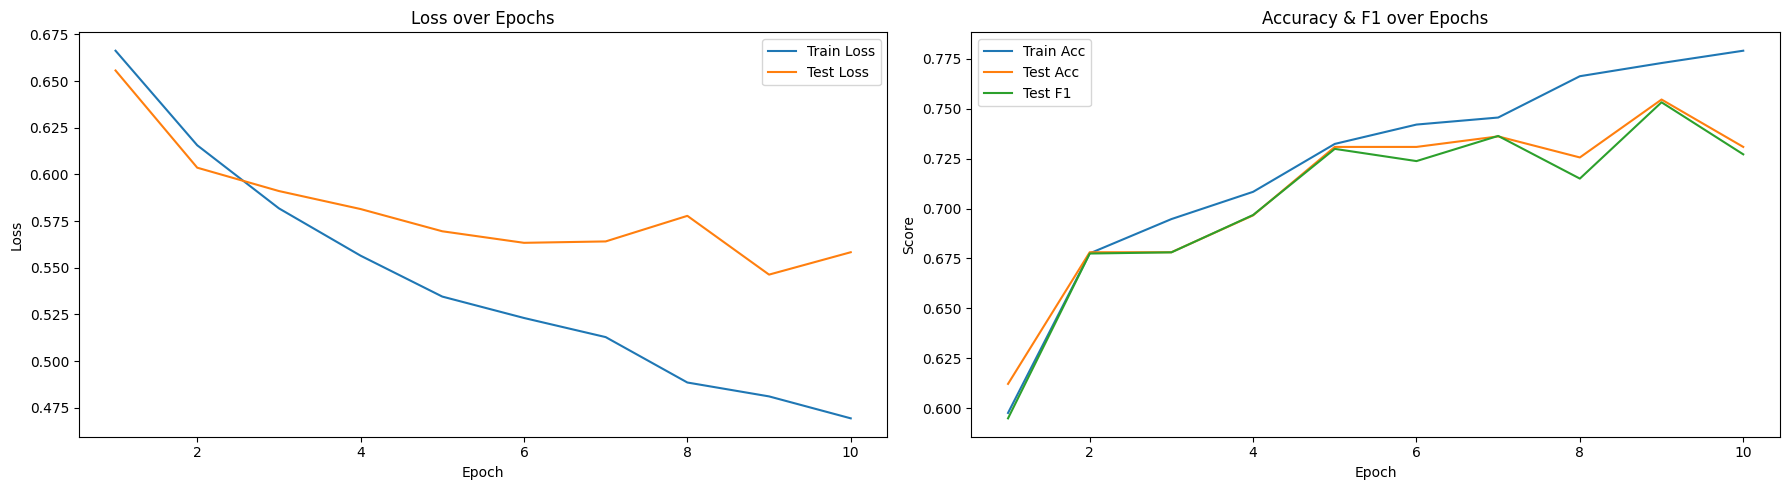

[I 2025-08-05 11:57:21,481] Trial 0 finished with values: [0.7308707124010554, 0.5582799115721971, 0.7271555964445424] and parameters: {'d_model': 64, 'num_layers': 3, 'num_heads': 8, 'dropout': 0.10060807868221684, 'learning_rate': 1e-05, 'batch_size': 8}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  3
num_heads:  8
dropout:  0.10060807868221684
learning rate:  1e-05
batch_szie:  8
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  2
num_heads:  4
dropout:  0.21990671853588512
learning rate:  1e-05
batch_szie:  16


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6879 | Train Acc: 0.5500
Test Loss: 0.6768 | Test Acc: 0.5831
Test Precision: 0.5935
Test Recall: 0.5831
Test ROC AUC Score: 0.5668
Test F1 Score: 0.5493
Test F1 Score: 0.5493


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.6627 | Train Acc: 0.6269
Test Loss: 0.6576 | Test Acc: 0.6385
Test Precision: 0.6379
Test Recall: 0.6385
Test ROC AUC Score: 0.6335
Test F1 Score: 0.6358
Test F1 Score: 0.6358


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.6417 | Train Acc: 0.6500
Test Loss: 0.6335 | Test Acc: 0.6702
Test Precision: 0.6705
Test Recall: 0.6702
Test ROC AUC Score: 0.6649
Test F1 Score: 0.6674
Test F1 Score: 0.6674


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.6232 | Train Acc: 0.6718
Test Loss: 0.6191 | Test Acc: 0.6491
Test Precision: 0.6486
Test Recall: 0.6491
Test ROC AUC Score: 0.6470
Test F1 Score: 0.6487
Test F1 Score: 0.6487


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.6070 | Train Acc: 0.6828
Test Loss: 0.6140 | Test Acc: 0.6649
Test Precision: 0.6685
Test Recall: 0.6649
Test ROC AUC Score: 0.6571
Test F1 Score: 0.6586
Test F1 Score: 0.6586


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.5937 | Train Acc: 0.6894
Test Loss: 0.6064 | Test Acc: 0.6491
Test Precision: 0.6484
Test Recall: 0.6491
Test ROC AUC Score: 0.6463
Test F1 Score: 0.6484
Test F1 Score: 0.6484


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.5917 | Train Acc: 0.6833
Test Loss: 0.6012 | Test Acc: 0.6755
Test Precision: 0.6812
Test Recall: 0.6755
Test ROC AUC Score: 0.6670
Test F1 Score: 0.6683
Test F1 Score: 0.6683


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.5767 | Train Acc: 0.7018
Test Loss: 0.5996 | Test Acc: 0.6675
Test Precision: 0.6673
Test Recall: 0.6675
Test ROC AUC Score: 0.6631
Test F1 Score: 0.6655
Test F1 Score: 0.6655


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.5693 | Train Acc: 0.7048
Test Loss: 0.5972 | Test Acc: 0.6596
Test Precision: 0.6590
Test Recall: 0.6596
Test ROC AUC Score: 0.6560
Test F1 Score: 0.6583
Test F1 Score: 0.6583


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.5616 | Train Acc: 0.7119
Test Loss: 0.5974 | Test Acc: 0.6675
Test Precision: 0.6669
Test Recall: 0.6675
Test ROC AUC Score: 0.6644
Test F1 Score: 0.6666
Test F1 Score: 0.6666


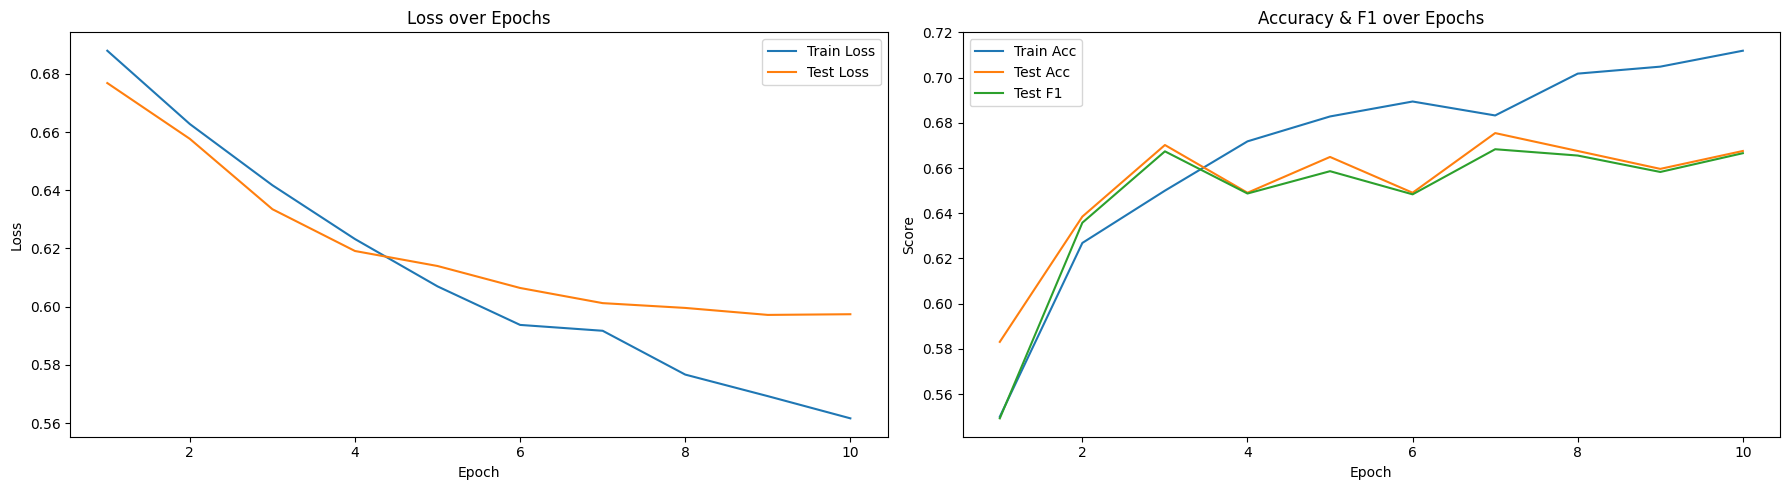

[I 2025-08-05 12:07:34,174] Trial 1 finished with values: [0.6675461741424802, 0.5974055032459601, 0.6665657322900187] and parameters: {'d_model': 64, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.21990671853588512, 'learning_rate': 1e-05, 'batch_size': 16}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  2
num_heads:  4
dropout:  0.21990671853588512
learning rate:  1e-05
batch_szie:  16
num_epochs:  0
Parameters chosen for this trial: 
d_model:  128
num_layers:  4
num_heads:  4
dropout:  0.1384424157061829
learning rate:  0.0001
batch_szie:  16


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6114 | Train Acc: 0.6621
Test Loss: 0.5623 | Test Acc: 0.6939
Test Precision: 0.7018
Test Recall: 0.6939
Test ROC AUC Score: 0.6976
Test F1 Score: 0.6935
Test F1 Score: 0.6935


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5257 | Train Acc: 0.7306
Test Loss: 0.5914 | Test Acc: 0.6913
Test Precision: 0.6922
Test Recall: 0.6913
Test ROC AUC Score: 0.6913
Test F1 Score: 0.6915
Test F1 Score: 0.6915


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.4397 | Train Acc: 0.7943
Test Loss: 0.6756 | Test Acc: 0.6517
Test Precision: 0.6568
Test Recall: 0.6517
Test ROC AUC Score: 0.6543
Test F1 Score: 0.6517
Test F1 Score: 0.6517


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.3765 | Train Acc: 0.8339
Test Loss: 0.7226 | Test Acc: 0.7203
Test Precision: 0.7518
Test Recall: 0.7203
Test ROC AUC Score: 0.7077
Test F1 Score: 0.7061
Test F1 Score: 0.7061


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.3331 | Train Acc: 0.8621
Test Loss: 0.7767 | Test Acc: 0.6755
Test Precision: 0.6754
Test Recall: 0.6755
Test ROC AUC Score: 0.6741
Test F1 Score: 0.6754
Test F1 Score: 0.6754


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.2699 | Train Acc: 0.8888
Test Loss: 1.0859 | Test Acc: 0.6359
Test Precision: 0.6786
Test Recall: 0.6359
Test ROC AUC Score: 0.6480
Test F1 Score: 0.6225
Test F1 Score: 0.6225
Model may be overfitting, time to early stop: 


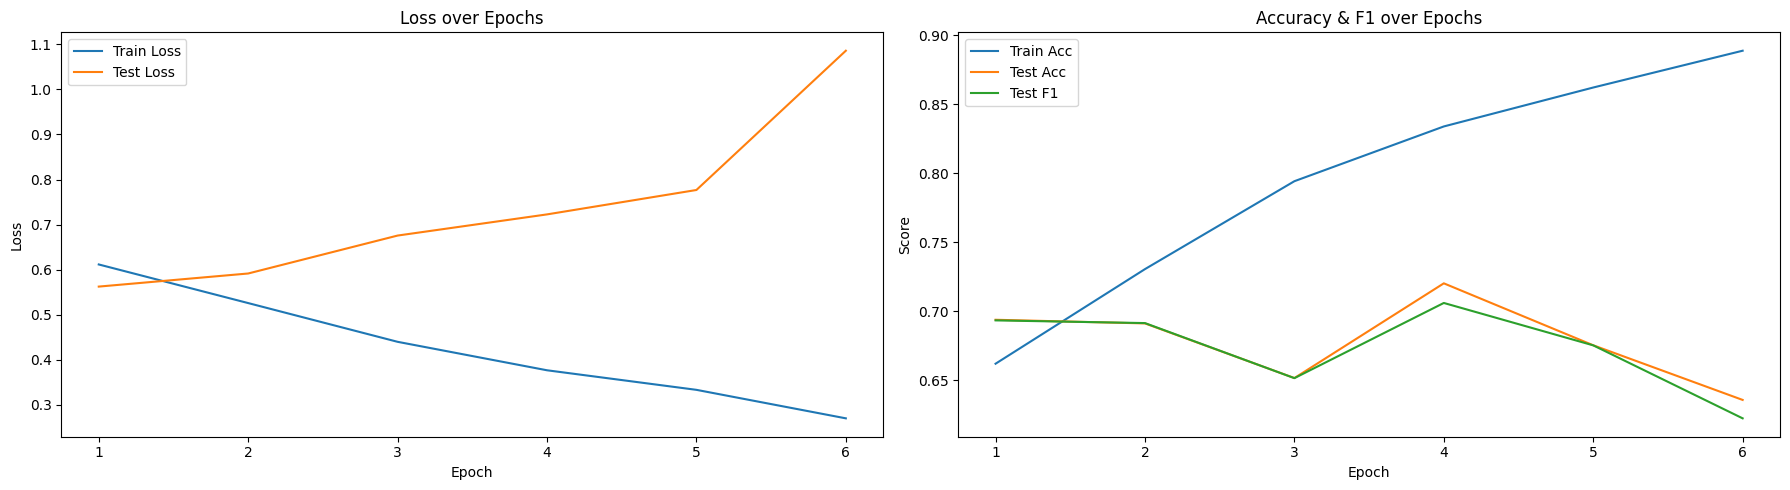

[I 2025-08-05 12:21:39,000] Trial 2 finished with values: [0.6358839050131926, 1.0858897832578593, 0.6225496363545848] and parameters: {'d_model': 128, 'num_layers': 4, 'num_heads': 4, 'dropout': 0.1384424157061829, 'learning_rate': 0.0001, 'batch_size': 16}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  4
num_heads:  4
dropout:  0.1384424157061829
learning rate:  0.0001
batch_szie:  16
num_epochs:  0
Parameters chosen for this trial: 
d_model:  128
num_layers:  4
num_heads:  4
dropout:  0.22740173282823092
learning rate:  0.0001
batch_szie:  8


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6227 | Train Acc: 0.6419
Test Loss: 0.6077 | Test Acc: 0.6517
Test Precision: 0.6515
Test Recall: 0.6517
Test ROC AUC Score: 0.6501
Test F1 Score: 0.6516
Test F1 Score: 0.6516


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5344 | Train Acc: 0.7297
Test Loss: 0.6099 | Test Acc: 0.6913
Test Precision: 0.7173
Test Recall: 0.6913
Test ROC AUC Score: 0.6996
Test F1 Score: 0.6867
Test F1 Score: 0.6867


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.4794 | Train Acc: 0.7731
Test Loss: 0.6644 | Test Acc: 0.6992
Test Precision: 0.7158
Test Recall: 0.6992
Test ROC AUC Score: 0.6885
Test F1 Score: 0.6883
Test F1 Score: 0.6883


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.4253 | Train Acc: 0.8084
Test Loss: 0.8426 | Test Acc: 0.6966
Test Precision: 0.7101
Test Recall: 0.6966
Test ROC AUC Score: 0.7020
Test F1 Score: 0.6950
Test F1 Score: 0.6950


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.3897 | Train Acc: 0.8390
Test Loss: 0.7363 | Test Acc: 0.6913
Test Precision: 0.6951
Test Recall: 0.6913
Test ROC AUC Score: 0.6932
Test F1 Score: 0.6915
Test F1 Score: 0.6915


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.3283 | Train Acc: 0.8764
Test Loss: 1.0907 | Test Acc: 0.7177
Test Precision: 0.7180
Test Recall: 0.7177
Test ROC AUC Score: 0.7171
Test F1 Score: 0.7178
Test F1 Score: 0.7178
Model may be overfitting, time to early stop: 


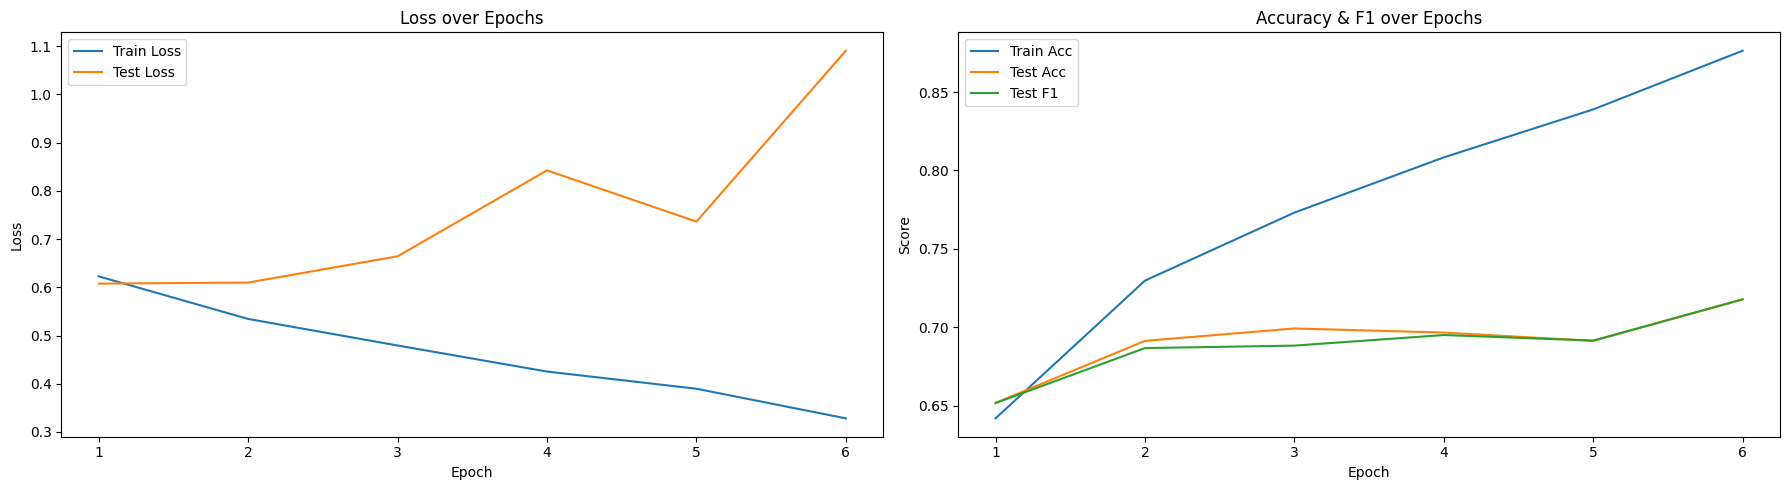

[I 2025-08-05 12:35:46,292] Trial 3 finished with values: [0.7176781002638523, 1.0906878411180112, 0.7177963577039997] and parameters: {'d_model': 128, 'num_layers': 4, 'num_heads': 4, 'dropout': 0.22740173282823092, 'learning_rate': 0.0001, 'batch_size': 8}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  4
num_heads:  4
dropout:  0.22740173282823092
learning rate:  0.0001
batch_szie:  8
num_epochs:  0
Parameters chosen for this trial: 
d_model:  128
num_layers:  8
num_heads:  8
dropout:  0.24894108072179982
learning rate:  0.0001
batch_szie:  32


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6661 | Train Acc: 0.5767
Test Loss: 0.6253 | Test Acc: 0.6702
Test Precision: 0.6755
Test Recall: 0.6702
Test ROC AUC Score: 0.6617
Test F1 Score: 0.6629
Test F1 Score: 0.6629


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5719 | Train Acc: 0.7004
Test Loss: 0.5777 | Test Acc: 0.7045
Test Precision: 0.7130
Test Recall: 0.7045
Test ROC AUC Score: 0.6960
Test F1 Score: 0.6977
Test F1 Score: 0.6977


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5465 | Train Acc: 0.7183
Test Loss: 0.5439 | Test Acc: 0.7309
Test Precision: 0.7306
Test Recall: 0.7309
Test ROC AUC Score: 0.7292
Test F1 Score: 0.7307
Test F1 Score: 0.7307


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.5077 | Train Acc: 0.7522
Test Loss: 0.5816 | Test Acc: 0.7177
Test Precision: 0.7230
Test Recall: 0.7177
Test ROC AUC Score: 0.7107
Test F1 Score: 0.7132
Test F1 Score: 0.7132


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4950 | Train Acc: 0.7617
Test Loss: 0.5201 | Test Acc: 0.7467
Test Precision: 0.7467
Test Recall: 0.7467
Test ROC AUC Score: 0.7458
Test F1 Score: 0.7467
Test F1 Score: 0.7467


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4769 | Train Acc: 0.7696
Test Loss: 0.5508 | Test Acc: 0.7124
Test Precision: 0.7333
Test Recall: 0.7124
Test ROC AUC Score: 0.7012
Test F1 Score: 0.7010
Test F1 Score: 0.7010


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.4630 | Train Acc: 0.7797
Test Loss: 0.5428 | Test Acc: 0.7467
Test Precision: 0.7478
Test Recall: 0.7467
Test ROC AUC Score: 0.7471
Test F1 Score: 0.7469
Test F1 Score: 0.7469


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.4335 | Train Acc: 0.7974
Test Loss: 0.5350 | Test Acc: 0.7625
Test Precision: 0.7656
Test Recall: 0.7625
Test ROC AUC Score: 0.7575
Test F1 Score: 0.7604
Test F1 Score: 0.7604


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.3976 | Train Acc: 0.8231
Test Loss: 0.5371 | Test Acc: 0.7573
Test Precision: 0.7862
Test Recall: 0.7573
Test ROC AUC Score: 0.7461
Test F1 Score: 0.7473
Test F1 Score: 0.7473


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.3765 | Train Acc: 0.8337
Test Loss: 0.5753 | Test Acc: 0.7177
Test Precision: 0.7190
Test Recall: 0.7177
Test ROC AUC Score: 0.7181
Test F1 Score: 0.7179
Test F1 Score: 0.7179
Model may be overfitting, time to early stop: 


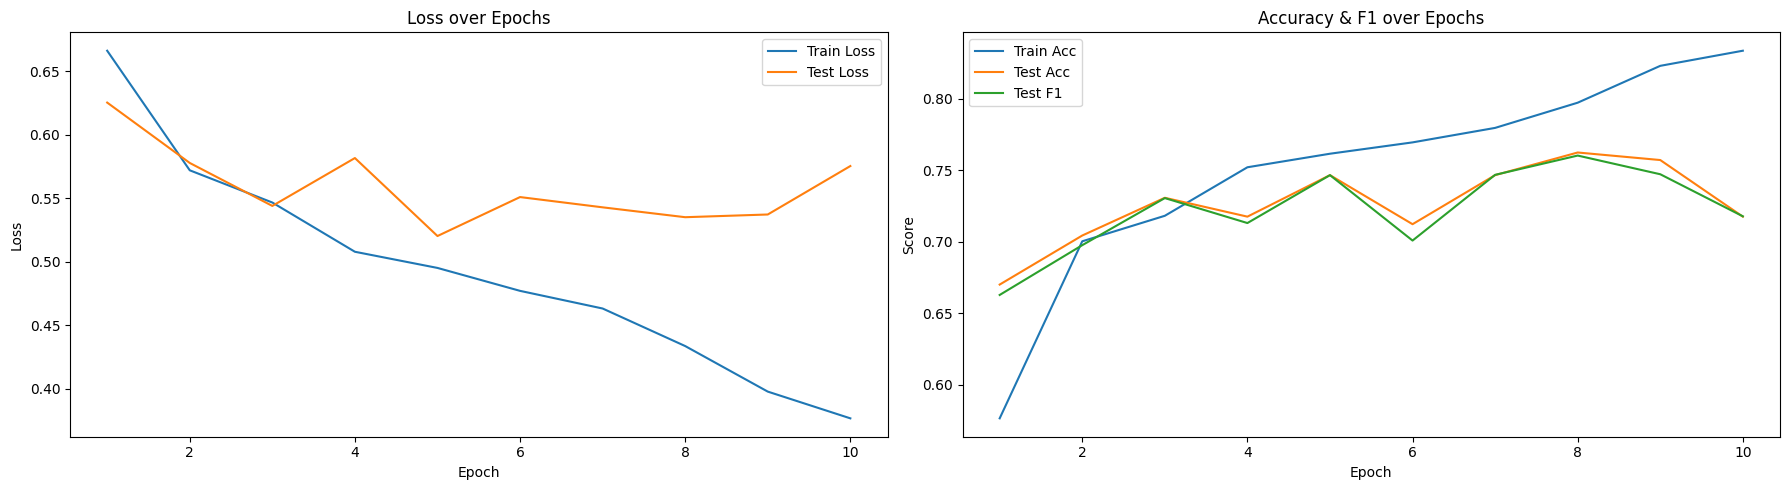

[I 2025-08-05 13:47:31,914] Trial 4 finished with values: [0.7176781002638523, 0.5752806168904719, 0.7179260877110742] and parameters: {'d_model': 128, 'num_layers': 8, 'num_heads': 8, 'dropout': 0.24894108072179982, 'learning_rate': 0.0001, 'batch_size': 32}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  8
num_heads:  8
dropout:  0.24894108072179982
learning rate:  0.0001
batch_szie:  32
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  2
num_heads:  4
dropout:  0.2632379054017556
learning rate:  0.0001
batch_szie:  16


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6463 | Train Acc: 0.6137
Test Loss: 0.6292 | Test Acc: 0.6544
Test Precision: 0.7242
Test Recall: 0.6544
Test ROC AUC Score: 0.6352
Test F1 Score: 0.6134
Test F1 Score: 0.6134


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5508 | Train Acc: 0.7117
Test Loss: 0.6398 | Test Acc: 0.6728
Test Precision: 0.7426
Test Recall: 0.6728
Test ROC AUC Score: 0.6546
Test F1 Score: 0.6376
Test F1 Score: 0.6376


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5137 | Train Acc: 0.7421
Test Loss: 0.5745 | Test Acc: 0.7018
Test Precision: 0.7152
Test Recall: 0.7018
Test ROC AUC Score: 0.6919
Test F1 Score: 0.6925
Test F1 Score: 0.6925


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.4655 | Train Acc: 0.7804
Test Loss: 0.5771 | Test Acc: 0.7256
Test Precision: 0.7272
Test Recall: 0.7256
Test ROC AUC Score: 0.7207
Test F1 Score: 0.7234
Test F1 Score: 0.7234


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4335 | Train Acc: 0.7985
Test Loss: 0.6697 | Test Acc: 0.6992
Test Precision: 0.7355
Test Recall: 0.6992
Test ROC AUC Score: 0.6852
Test F1 Score: 0.6806
Test F1 Score: 0.6806


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.3974 | Train Acc: 0.8249
Test Loss: 0.6213 | Test Acc: 0.7309
Test Precision: 0.7427
Test Recall: 0.7309
Test ROC AUC Score: 0.7222
Test F1 Score: 0.7243
Test F1 Score: 0.7243


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.3703 | Train Acc: 0.8425
Test Loss: 0.6171 | Test Acc: 0.7256
Test Precision: 0.7327
Test Recall: 0.7256
Test ROC AUC Score: 0.7182
Test F1 Score: 0.7206
Test F1 Score: 0.7206


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.3475 | Train Acc: 0.8531
Test Loss: 0.6530 | Test Acc: 0.7335
Test Precision: 0.7382
Test Recall: 0.7335
Test ROC AUC Score: 0.7359
Test F1 Score: 0.7336
Test F1 Score: 0.7336
Model may be overfitting, time to early stop: 


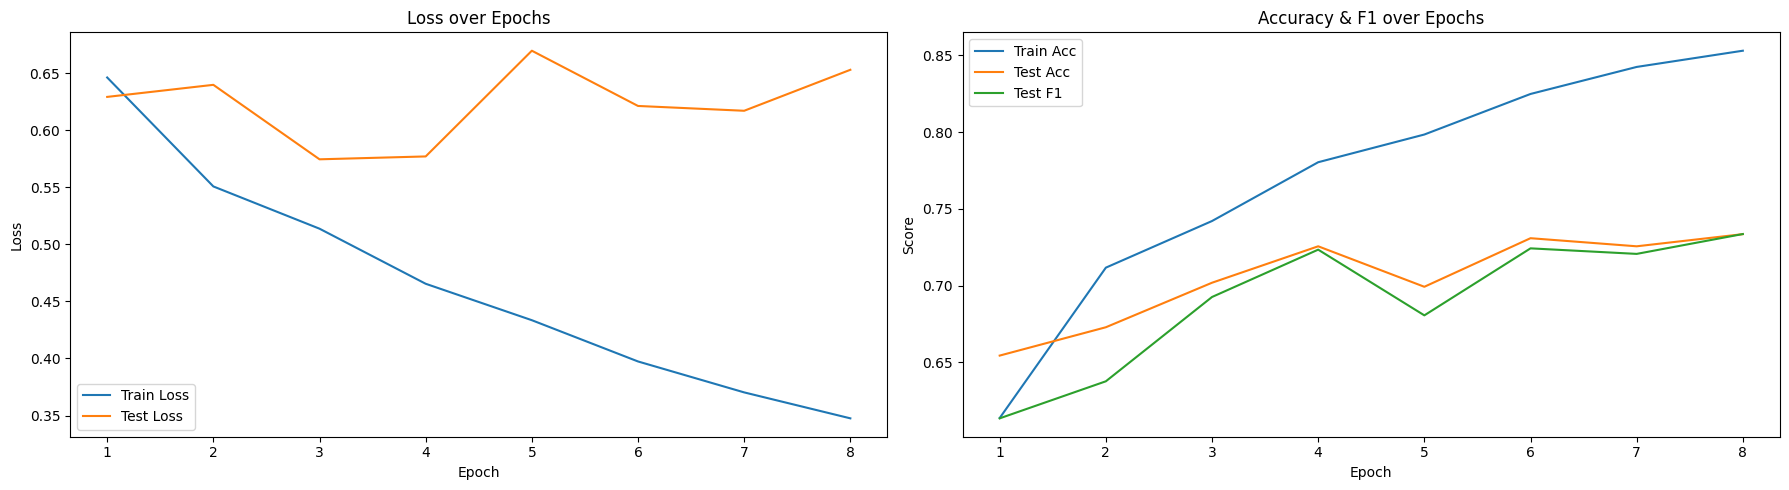

[I 2025-08-05 13:55:43,005] Trial 5 finished with values: [0.7335092348284961, 0.6530011187757225, 0.7335871577323245] and parameters: {'d_model': 64, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.2632379054017556, 'learning_rate': 0.0001, 'batch_size': 16}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  2
num_heads:  4
dropout:  0.2632379054017556
learning rate:  0.0001
batch_szie:  16
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  6
num_heads:  4
dropout:  0.24240010789525904
learning rate:  1e-05
batch_szie:  32


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6762 | Train Acc: 0.5751
Test Loss: 0.6634 | Test Acc: 0.5910
Test Precision: 0.6225
Test Recall: 0.5910
Test ROC AUC Score: 0.6025
Test F1 Score: 0.5773
Test F1 Score: 0.5773


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.6488 | Train Acc: 0.6123
Test Loss: 0.6477 | Test Acc: 0.6069
Test Precision: 0.6237
Test Recall: 0.6069
Test ROC AUC Score: 0.6142
Test F1 Score: 0.6020
Test F1 Score: 0.6020


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.6282 | Train Acc: 0.6385
Test Loss: 0.6294 | Test Acc: 0.6306
Test Precision: 0.6405
Test Recall: 0.6306
Test ROC AUC Score: 0.6353
Test F1 Score: 0.6291
Test F1 Score: 0.6291


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.6101 | Train Acc: 0.6586
Test Loss: 0.6152 | Test Acc: 0.6649
Test Precision: 0.6763
Test Recall: 0.6649
Test ROC AUC Score: 0.6699
Test F1 Score: 0.6634
Test F1 Score: 0.6634


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.5898 | Train Acc: 0.6883
Test Loss: 0.6123 | Test Acc: 0.6517
Test Precision: 0.6685
Test Recall: 0.6517
Test ROC AUC Score: 0.6585
Test F1 Score: 0.6484
Test F1 Score: 0.6484


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.5808 | Train Acc: 0.6888
Test Loss: 0.5818 | Test Acc: 0.6860
Test Precision: 0.6868
Test Recall: 0.6860
Test ROC AUC Score: 0.6808
Test F1 Score: 0.6833
Test F1 Score: 0.6833


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.5802 | Train Acc: 0.6885
Test Loss: 0.5888 | Test Acc: 0.6807
Test Precision: 0.6880
Test Recall: 0.6807
Test ROC AUC Score: 0.6842
Test F1 Score: 0.6804
Test F1 Score: 0.6804


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.5613 | Train Acc: 0.7070
Test Loss: 0.5793 | Test Acc: 0.6913
Test Precision: 0.6926
Test Recall: 0.6913
Test ROC AUC Score: 0.6916
Test F1 Score: 0.6916
Test F1 Score: 0.6916


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.5496 | Train Acc: 0.7167
Test Loss: 0.5731 | Test Acc: 0.6913
Test Precision: 0.6922
Test Recall: 0.6913
Test ROC AUC Score: 0.6913
Test F1 Score: 0.6915
Test F1 Score: 0.6915


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.5458 | Train Acc: 0.7161
Test Loss: 0.5688 | Test Acc: 0.7098
Test Precision: 0.7094
Test Recall: 0.7098
Test ROC AUC Score: 0.7077
Test F1 Score: 0.7094
Test F1 Score: 0.7094


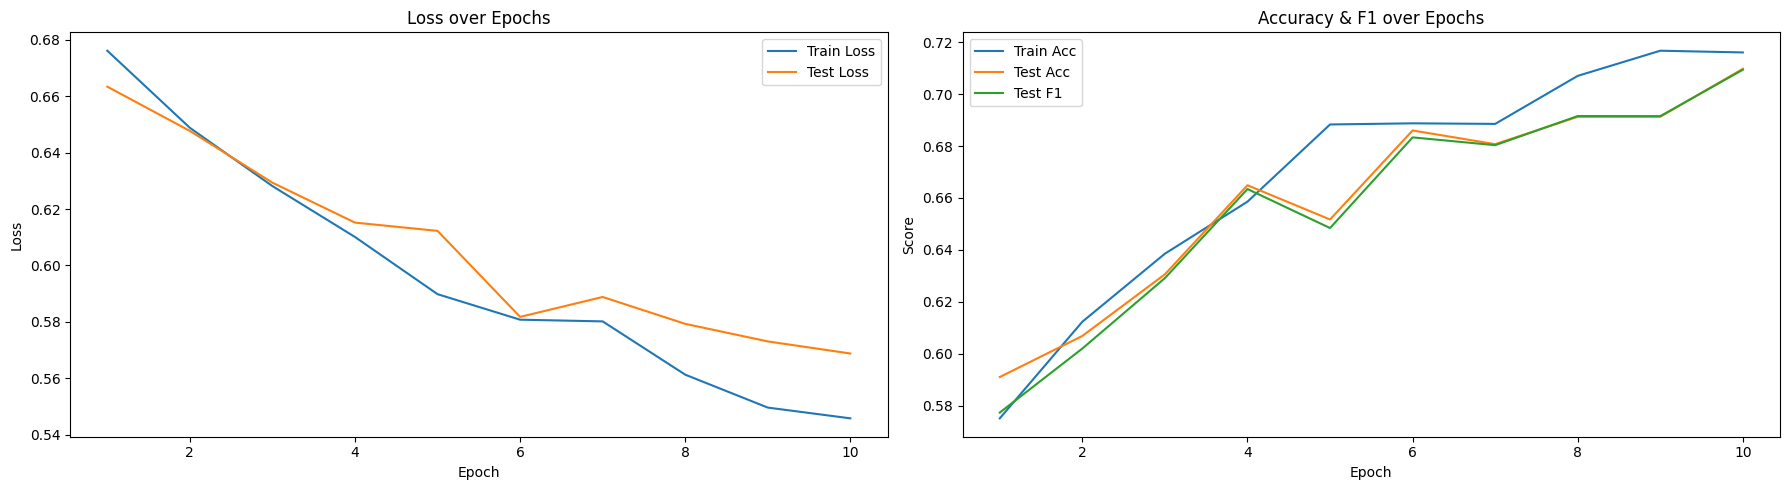

[I 2025-08-05 14:26:11,533] Trial 6 finished with values: [0.7097625329815304, 0.5687682747369077, 0.7094088822864238] and parameters: {'d_model': 64, 'num_layers': 6, 'num_heads': 4, 'dropout': 0.24240010789525904, 'learning_rate': 1e-05, 'batch_size': 32}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  6
num_heads:  4
dropout:  0.24240010789525904
learning rate:  1e-05
batch_szie:  32
num_epochs:  0
Parameters chosen for this trial: 
d_model:  128
num_layers:  5
num_heads:  8
dropout:  0.25074678397161476
learning rate:  1e-05
batch_szie:  16


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6687 | Train Acc: 0.5963
Test Loss: 0.6423 | Test Acc: 0.6227
Test Precision: 0.6237
Test Recall: 0.6227
Test ROC AUC Score: 0.6224
Test F1 Score: 0.6230
Test F1 Score: 0.6230


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.6136 | Train Acc: 0.6709
Test Loss: 0.6244 | Test Acc: 0.6544
Test Precision: 0.6567
Test Recall: 0.6544
Test ROC AUC Score: 0.6468
Test F1 Score: 0.6484
Test F1 Score: 0.6484


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5793 | Train Acc: 0.6982
Test Loss: 0.5895 | Test Acc: 0.6781
Test Precision: 0.6805
Test Recall: 0.6781
Test ROC AUC Score: 0.6714
Test F1 Score: 0.6737
Test F1 Score: 0.6737


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.5601 | Train Acc: 0.7077
Test Loss: 0.5902 | Test Acc: 0.6913
Test Precision: 0.6935
Test Recall: 0.6913
Test ROC AUC Score: 0.6922
Test F1 Score: 0.6916
Test F1 Score: 0.6916


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.5401 | Train Acc: 0.7271
Test Loss: 0.5869 | Test Acc: 0.6992
Test Precision: 0.7001
Test Recall: 0.6992
Test ROC AUC Score: 0.6942
Test F1 Score: 0.6968
Test F1 Score: 0.6968


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.5304 | Train Acc: 0.7359
Test Loss: 0.5815 | Test Acc: 0.7045
Test Precision: 0.7163
Test Recall: 0.7045
Test ROC AUC Score: 0.6950
Test F1 Score: 0.6961
Test F1 Score: 0.6961


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.5116 | Train Acc: 0.7410
Test Loss: 0.5813 | Test Acc: 0.6992
Test Precision: 0.6992
Test Recall: 0.6992
Test ROC AUC Score: 0.6981
Test F1 Score: 0.6992
Test F1 Score: 0.6992


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.5073 | Train Acc: 0.7487
Test Loss: 0.5748 | Test Acc: 0.7045
Test Precision: 0.7059
Test Recall: 0.7045
Test ROC AUC Score: 0.6992
Test F1 Score: 0.7018
Test F1 Score: 0.7018


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.4897 | Train Acc: 0.7634
Test Loss: 0.5893 | Test Acc: 0.6887
Test Precision: 0.6999
Test Recall: 0.6887
Test ROC AUC Score: 0.6788
Test F1 Score: 0.6793
Test F1 Score: 0.6793


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.4831 | Train Acc: 0.7700
Test Loss: 0.5666 | Test Acc: 0.7150
Test Precision: 0.7163
Test Recall: 0.7150
Test ROC AUC Score: 0.7101
Test F1 Score: 0.7128
Test F1 Score: 0.7128


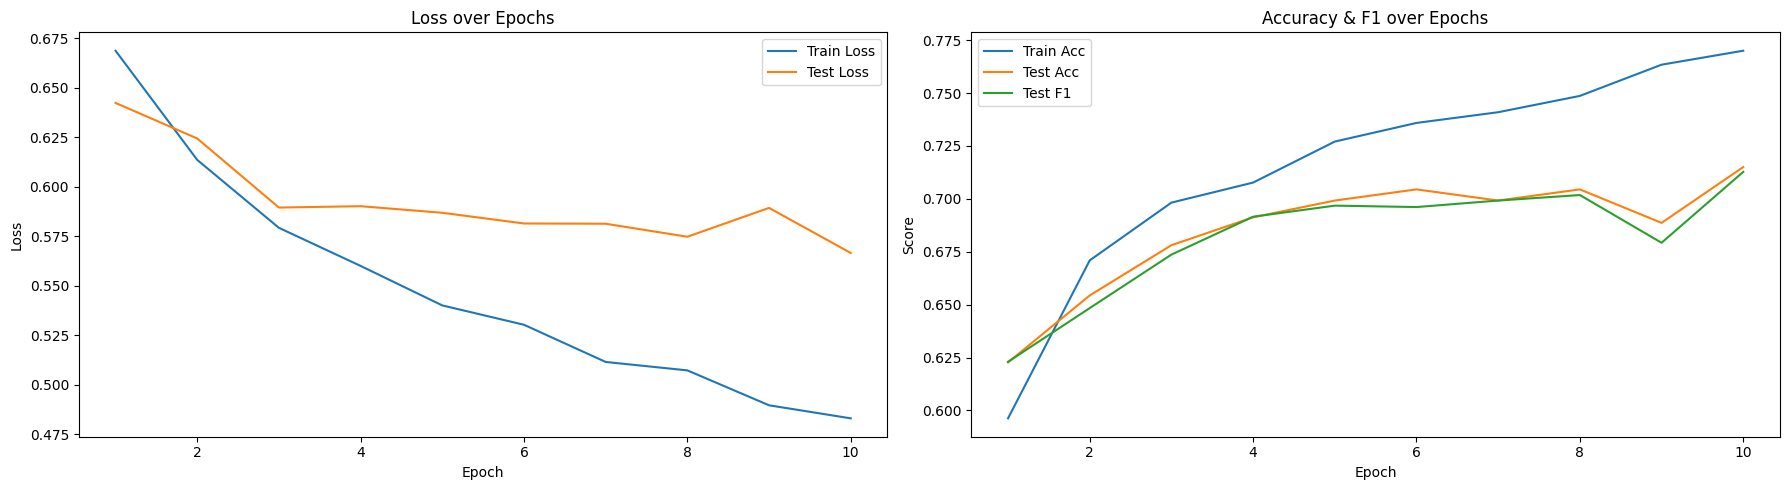

[I 2025-08-05 15:11:14,063] Trial 7 finished with values: [0.7150395778364116, 0.5665823247942258, 0.7127668576867953] and parameters: {'d_model': 128, 'num_layers': 5, 'num_heads': 8, 'dropout': 0.25074678397161476, 'learning_rate': 1e-05, 'batch_size': 16}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  5
num_heads:  8
dropout:  0.25074678397161476
learning rate:  1e-05
batch_szie:  16
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  4
num_heads:  8
dropout:  0.20510954736890175
learning rate:  0.0001
batch_szie:  16


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6480 | Train Acc: 0.6176
Test Loss: 0.5974 | Test Acc: 0.6728
Test Precision: 0.7115
Test Recall: 0.6728
Test ROC AUC Score: 0.6575
Test F1 Score: 0.6485
Test F1 Score: 0.6485


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5645 | Train Acc: 0.7068
Test Loss: 0.5791 | Test Acc: 0.6807
Test Precision: 0.6982
Test Recall: 0.6807
Test ROC AUC Score: 0.6691
Test F1 Score: 0.6673
Test F1 Score: 0.6673


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5265 | Train Acc: 0.7379
Test Loss: 0.6004 | Test Acc: 0.6992
Test Precision: 0.7063
Test Recall: 0.6992
Test ROC AUC Score: 0.6910
Test F1 Score: 0.6928
Test F1 Score: 0.6928


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.4830 | Train Acc: 0.7740
Test Loss: 0.5827 | Test Acc: 0.7335
Test Precision: 0.7373
Test Recall: 0.7335
Test ROC AUC Score: 0.7275
Test F1 Score: 0.7303
Test F1 Score: 0.7303


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4672 | Train Acc: 0.7786
Test Loss: 0.5334 | Test Acc: 0.7414
Test Precision: 0.7495
Test Recall: 0.7414
Test ROC AUC Score: 0.7340
Test F1 Score: 0.7368
Test F1 Score: 0.7368


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4205 | Train Acc: 0.8137
Test Loss: 0.5616 | Test Acc: 0.7335
Test Precision: 0.7416
Test Recall: 0.7335
Test ROC AUC Score: 0.7259
Test F1 Score: 0.7285
Test F1 Score: 0.7285


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.3977 | Train Acc: 0.8256
Test Loss: 0.5722 | Test Acc: 0.7757
Test Precision: 0.7772
Test Recall: 0.7757
Test ROC AUC Score: 0.7718
Test F1 Score: 0.7745
Test F1 Score: 0.7745


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.3775 | Train Acc: 0.8425
Test Loss: 0.5972 | Test Acc: 0.7573
Test Precision: 0.7571
Test Recall: 0.7573
Test ROC AUC Score: 0.7551
Test F1 Score: 0.7568
Test F1 Score: 0.7568


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.3468 | Train Acc: 0.8568
Test Loss: 0.7061 | Test Acc: 0.7309
Test Precision: 0.7352
Test Recall: 0.7309
Test ROC AUC Score: 0.7331
Test F1 Score: 0.7310
Test F1 Score: 0.7310


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.3406 | Train Acc: 0.8650
Test Loss: 0.6583 | Test Acc: 0.7441
Test Precision: 0.7444
Test Recall: 0.7441
Test ROC AUC Score: 0.7436
Test F1 Score: 0.7442
Test F1 Score: 0.7442
Model may be overfitting, time to early stop: 


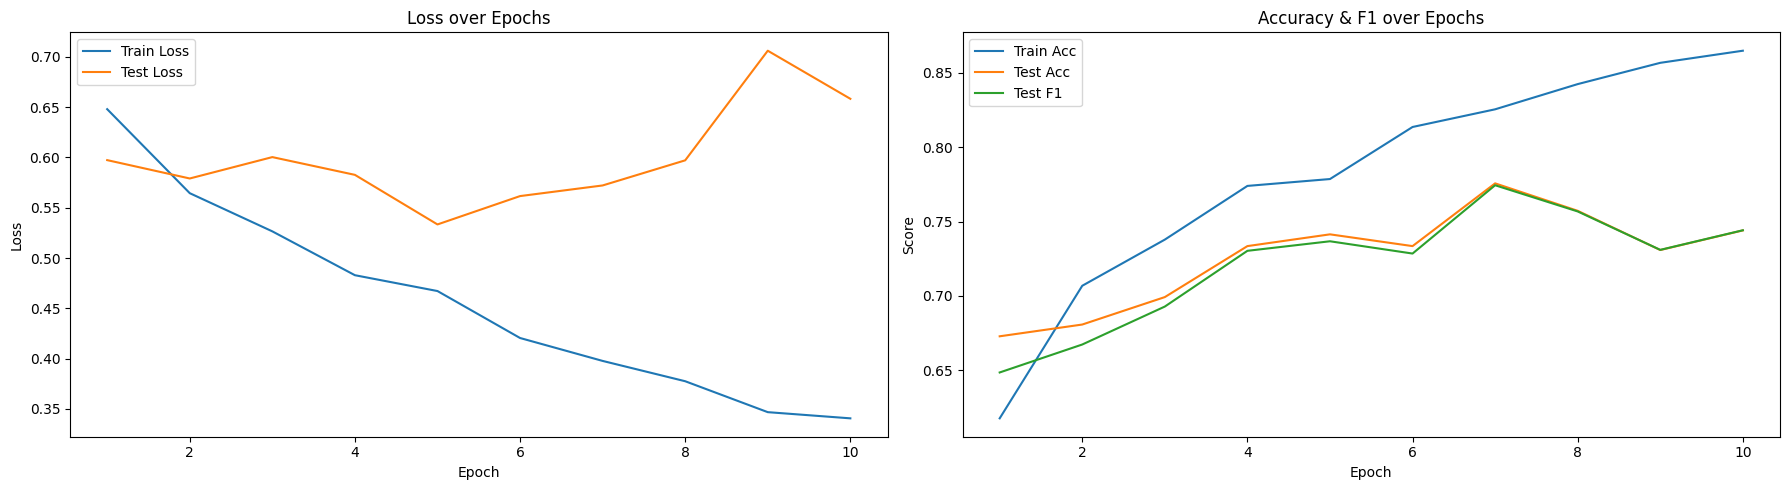

[I 2025-08-05 15:43:59,233] Trial 8 finished with values: [0.7440633245382586, 0.6583442588909321, 0.744170529881196] and parameters: {'d_model': 64, 'num_layers': 4, 'num_heads': 8, 'dropout': 0.20510954736890175, 'learning_rate': 0.0001, 'batch_size': 16}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  4
num_heads:  8
dropout:  0.20510954736890175
learning rate:  0.0001
batch_szie:  16
num_epochs:  0
Parameters chosen for this trial: 
d_model:  128
num_layers:  2
num_heads:  4
dropout:  0.27477303128859687
learning rate:  1e-05
batch_szie:  32


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6848 | Train Acc: 0.5562
Test Loss: 0.6770 | Test Acc: 0.5567
Test Precision: 0.5572
Test Recall: 0.5567
Test ROC AUC Score: 0.5403
Test F1 Score: 0.5208
Test F1 Score: 0.5208


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.6711 | Train Acc: 0.5782
Test Loss: 0.6626 | Test Acc: 0.5937
Test Precision: 0.5922
Test Recall: 0.5937
Test ROC AUC Score: 0.5867
Test F1 Score: 0.5881
Test F1 Score: 0.5881


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.6555 | Train Acc: 0.6189
Test Loss: 0.6517 | Test Acc: 0.6069
Test Precision: 0.6058
Test Recall: 0.6069
Test ROC AUC Score: 0.6004
Test F1 Score: 0.6022
Test F1 Score: 0.6022


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.6432 | Train Acc: 0.6407
Test Loss: 0.6466 | Test Acc: 0.6201
Test Precision: 0.6332
Test Recall: 0.6201
Test ROC AUC Score: 0.6260
Test F1 Score: 0.6172
Test F1 Score: 0.6172


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.6308 | Train Acc: 0.6511
Test Loss: 0.6421 | Test Acc: 0.6280
Test Precision: 0.6383
Test Recall: 0.6280
Test ROC AUC Score: 0.6329
Test F1 Score: 0.6263
Test F1 Score: 0.6263


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.6246 | Train Acc: 0.6606
Test Loss: 0.6272 | Test Acc: 0.6570
Test Precision: 0.6599
Test Recall: 0.6570
Test ROC AUC Score: 0.6583
Test F1 Score: 0.6573
Test F1 Score: 0.6573


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.6113 | Train Acc: 0.6593
Test Loss: 0.6205 | Test Acc: 0.6332
Test Precision: 0.6344
Test Recall: 0.6332
Test ROC AUC Score: 0.6256
Test F1 Score: 0.6269
Test F1 Score: 0.6269


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.6010 | Train Acc: 0.6815
Test Loss: 0.6073 | Test Acc: 0.6517
Test Precision: 0.6510
Test Recall: 0.6517
Test ROC AUC Score: 0.6488
Test F1 Score: 0.6509
Test F1 Score: 0.6509


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.5903 | Train Acc: 0.6841
Test Loss: 0.6172 | Test Acc: 0.6464
Test Precision: 0.6493
Test Recall: 0.6464
Test ROC AUC Score: 0.6477
Test F1 Score: 0.6467
Test F1 Score: 0.6467


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.5883 | Train Acc: 0.6819
Test Loss: 0.5960 | Test Acc: 0.6438
Test Precision: 0.6455
Test Recall: 0.6438
Test ROC AUC Score: 0.6443
Test F1 Score: 0.6441
Test F1 Score: 0.6441


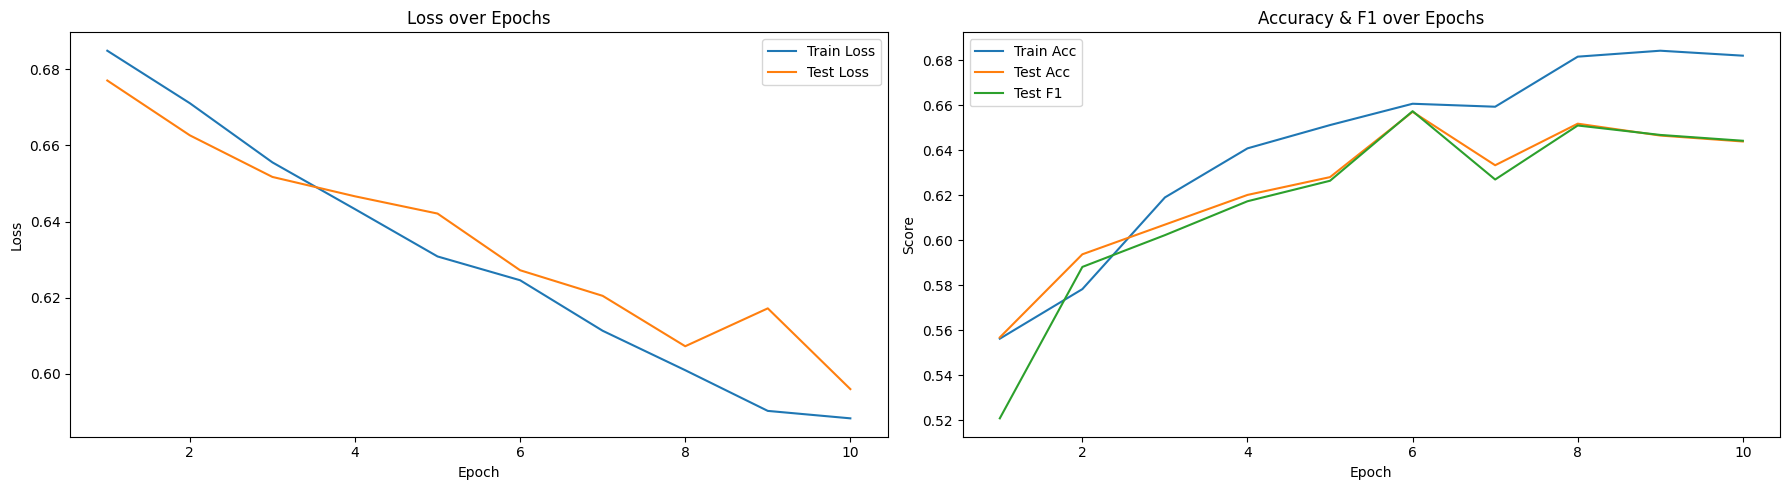

[I 2025-08-05 15:55:42,214] Trial 9 finished with values: [0.6437994722955145, 0.5960041297142613, 0.6441271339864] and parameters: {'d_model': 128, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.27477303128859687, 'learning_rate': 1e-05, 'batch_size': 32}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  2
num_heads:  4
dropout:  0.27477303128859687
learning rate:  1e-05
batch_szie:  32
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  6
num_heads:  4
dropout:  0.12481521171813754
learning rate:  0.0001
batch_szie:  32


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6424 | Train Acc: 0.6183
Test Loss: 0.5961 | Test Acc: 0.6570
Test Precision: 0.6615
Test Recall: 0.6570
Test ROC AUC Score: 0.6593
Test F1 Score: 0.6570
Test F1 Score: 0.6570


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5531 | Train Acc: 0.7167
Test Loss: 0.5877 | Test Acc: 0.6913
Test Precision: 0.6926
Test Recall: 0.6913
Test ROC AUC Score: 0.6858
Test F1 Score: 0.6883
Test F1 Score: 0.6883


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Epoch 3/10
Train Loss: 0.5054 | Train Acc: 0.7555
Test Loss: 0.6836 | Test Acc: 0.6702
Test Precision: 0.7136
Test Recall: 0.6702
Test ROC AUC Score: 0.6817
Test F1 Score: 0.6598
Test F1 Score: 0.6598


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.4822 | Train Acc: 0.7709
Test Loss: 0.5538 | Test Acc: 0.7071
Test Precision: 0.7077
Test Recall: 0.7071
Test ROC AUC Score: 0.7027
Test F1 Score: 0.7052
Test F1 Score: 0.7052


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4376 | Train Acc: 0.7982
Test Loss: 0.6352 | Test Acc: 0.7309
Test Precision: 0.7437
Test Recall: 0.7309
Test ROC AUC Score: 0.7360
Test F1 Score: 0.7298
Test F1 Score: 0.7298


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4072 | Train Acc: 0.8211
Test Loss: 0.5461 | Test Acc: 0.7361
Test Precision: 0.7359
Test Recall: 0.7361
Test ROC AUC Score: 0.7342
Test F1 Score: 0.7358
Test F1 Score: 0.7358


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.3769 | Train Acc: 0.8344
Test Loss: 0.5933 | Test Acc: 0.7309
Test Precision: 0.7308
Test Recall: 0.7309
Test ROC AUC Score: 0.7279
Test F1 Score: 0.7301
Test F1 Score: 0.7301


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.3448 | Train Acc: 0.8520
Test Loss: 0.6284 | Test Acc: 0.7309
Test Precision: 0.7309
Test Recall: 0.7309
Test ROC AUC Score: 0.7276
Test F1 Score: 0.7299
Test F1 Score: 0.7299


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.3022 | Train Acc: 0.8795
Test Loss: 0.6134 | Test Acc: 0.7467
Test Precision: 0.7493
Test Recall: 0.7467
Test ROC AUC Score: 0.7416
Test F1 Score: 0.7444
Test F1 Score: 0.7444


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.2961 | Train Acc: 0.8830
Test Loss: 0.6136 | Test Acc: 0.7546
Test Precision: 0.7678
Test Recall: 0.7546
Test ROC AUC Score: 0.7462
Test F1 Score: 0.7488
Test F1 Score: 0.7488


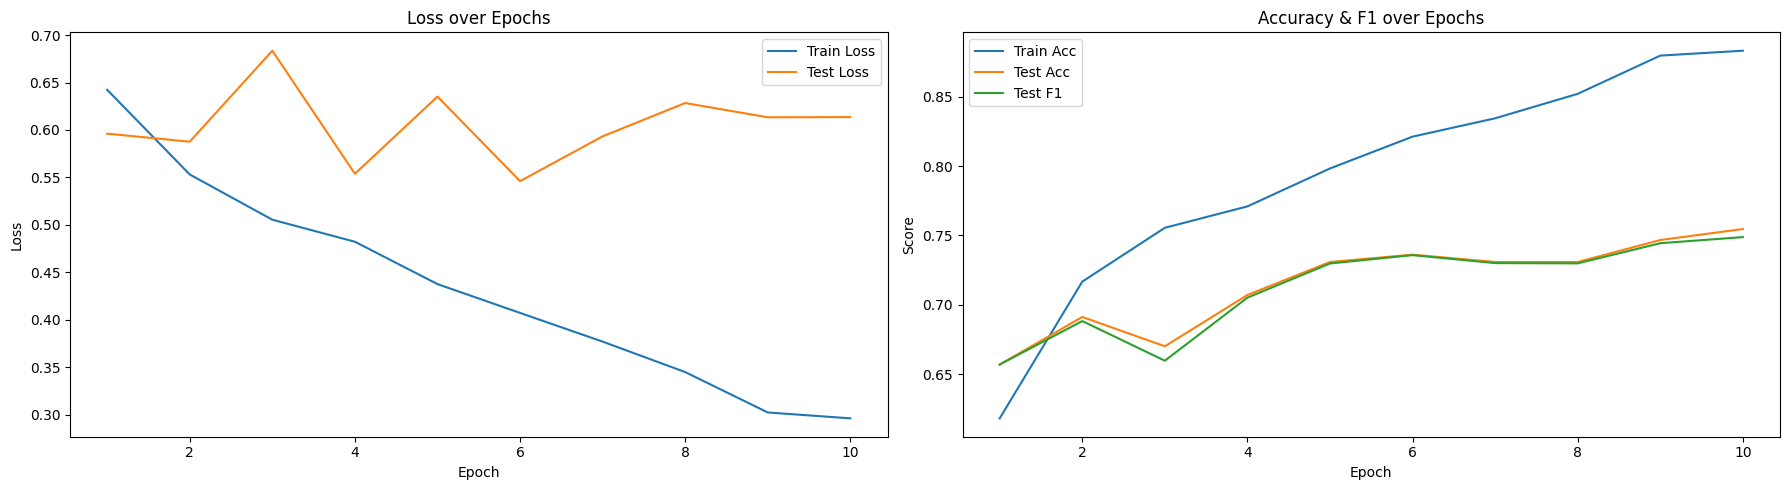

[I 2025-08-05 16:26:13,798] Trial 10 finished with values: [0.7546174142480211, 0.6135782774016851, 0.7487985956787157] and parameters: {'d_model': 64, 'num_layers': 6, 'num_heads': 4, 'dropout': 0.12481521171813754, 'learning_rate': 0.0001, 'batch_size': 32}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  6
num_heads:  4
dropout:  0.12481521171813754
learning rate:  0.0001
batch_szie:  32
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  3
num_heads:  8
dropout:  0.20495202282380398
learning rate:  0.0001
batch_szie:  32


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6412 | Train Acc: 0.6236
Test Loss: 0.5753 | Test Acc: 0.6807
Test Precision: 0.6830
Test Recall: 0.6807
Test ROC AUC Score: 0.6743
Test F1 Score: 0.6765
Test F1 Score: 0.6765


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5575 | Train Acc: 0.7004
Test Loss: 0.6110 | Test Acc: 0.6887
Test Precision: 0.6934
Test Recall: 0.6887
Test ROC AUC Score: 0.6811
Test F1 Score: 0.6830
Test F1 Score: 0.6830


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5342 | Train Acc: 0.7244
Test Loss: 0.5510 | Test Acc: 0.7335
Test Precision: 0.7334
Test Recall: 0.7335
Test ROC AUC Score: 0.7324
Test F1 Score: 0.7335
Test F1 Score: 0.7335


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.5069 | Train Acc: 0.7416
Test Loss: 0.5572 | Test Acc: 0.7203
Test Precision: 0.7270
Test Recall: 0.7203
Test ROC AUC Score: 0.7129
Test F1 Score: 0.7153
Test F1 Score: 0.7153


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4816 | Train Acc: 0.7641
Test Loss: 0.6165 | Test Acc: 0.6860
Test Precision: 0.7337
Test Recall: 0.6860
Test ROC AUC Score: 0.6702
Test F1 Score: 0.6611
Test F1 Score: 0.6611


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4726 | Train Acc: 0.7694
Test Loss: 0.5404 | Test Acc: 0.7282
Test Precision: 0.7359
Test Recall: 0.7282
Test ROC AUC Score: 0.7206
Test F1 Score: 0.7231
Test F1 Score: 0.7231


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.4383 | Train Acc: 0.7907
Test Loss: 0.5713 | Test Acc: 0.7150
Test Precision: 0.7178
Test Recall: 0.7150
Test ROC AUC Score: 0.7092
Test F1 Score: 0.7118
Test F1 Score: 0.7118


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.4116 | Train Acc: 0.8112
Test Loss: 0.6896 | Test Acc: 0.6860
Test Precision: 0.7154
Test Recall: 0.6860
Test ROC AUC Score: 0.6725
Test F1 Score: 0.6679
Test F1 Score: 0.6679


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.3996 | Train Acc: 0.8161
Test Loss: 0.5868 | Test Acc: 0.7414
Test Precision: 0.7445
Test Recall: 0.7414
Test ROC AUC Score: 0.7360
Test F1 Score: 0.7388
Test F1 Score: 0.7388


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.3628 | Train Acc: 0.8443
Test Loss: 0.6271 | Test Acc: 0.7441
Test Precision: 0.7444
Test Recall: 0.7441
Test ROC AUC Score: 0.7407
Test F1 Score: 0.7430
Test F1 Score: 0.7430


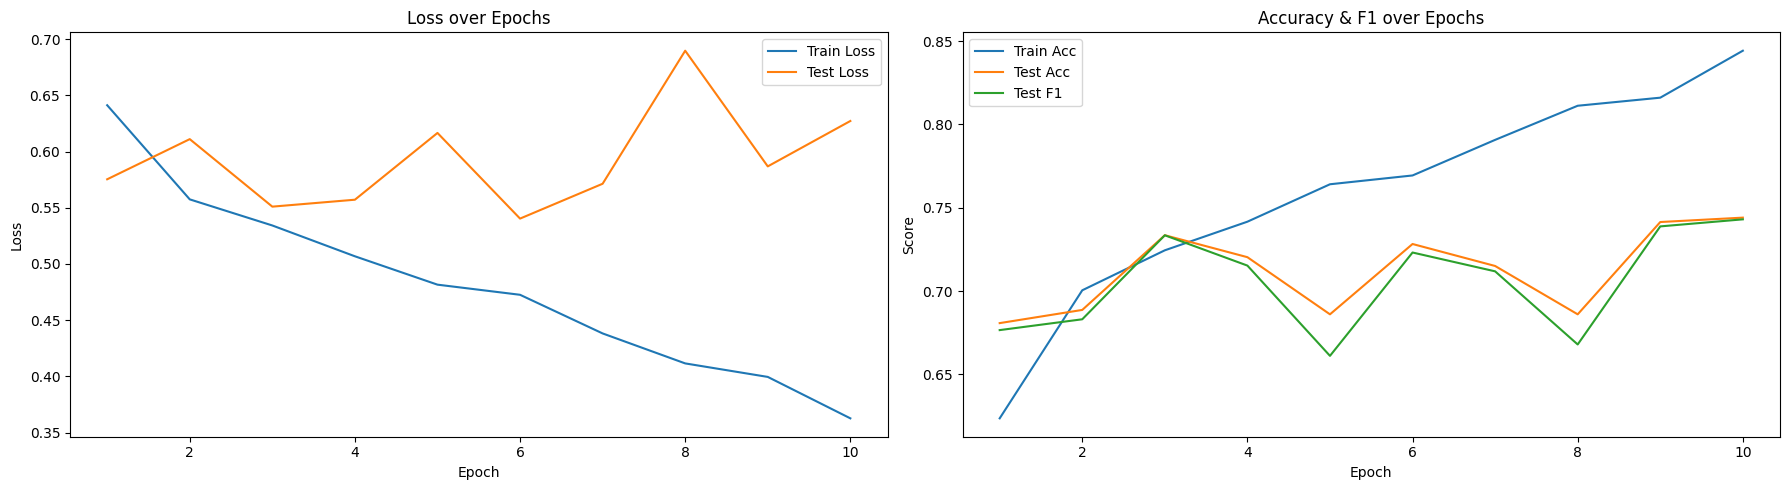

[I 2025-08-05 16:50:46,397] Trial 11 finished with values: [0.7440633245382586, 0.6271464285246615, 0.7430373963891894] and parameters: {'d_model': 64, 'num_layers': 3, 'num_heads': 8, 'dropout': 0.20495202282380398, 'learning_rate': 0.0001, 'batch_size': 32}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  3
num_heads:  8
dropout:  0.20495202282380398
learning rate:  0.0001
batch_szie:  32
num_epochs:  0
Parameters chosen for this trial: 
d_model:  128
num_layers:  2
num_heads:  4
dropout:  0.2648385634127064
learning rate:  0.0001
batch_szie:  32


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6450 | Train Acc: 0.6093
Test Loss: 0.6348 | Test Acc: 0.6623
Test Precision: 0.6974
Test Recall: 0.6623
Test ROC AUC Score: 0.6469
Test F1 Score: 0.6371
Test F1 Score: 0.6371


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5807 | Train Acc: 0.6912
Test Loss: 0.5661 | Test Acc: 0.6992
Test Precision: 0.6988
Test Recall: 0.6992
Test ROC AUC Score: 0.6971
Test F1 Score: 0.6988
Test F1 Score: 0.6988


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5408 | Train Acc: 0.7207
Test Loss: 0.5745 | Test Acc: 0.7071
Test Precision: 0.7072
Test Recall: 0.7071
Test ROC AUC Score: 0.7062
Test F1 Score: 0.7072
Test F1 Score: 0.7072


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.5234 | Train Acc: 0.7300
Test Loss: 0.5985 | Test Acc: 0.6913
Test Precision: 0.7035
Test Recall: 0.6913
Test ROC AUC Score: 0.6964
Test F1 Score: 0.6899
Test F1 Score: 0.6899


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4742 | Train Acc: 0.7714
Test Loss: 0.5595 | Test Acc: 0.7546
Test Precision: 0.7619
Test Recall: 0.7546
Test ROC AUC Score: 0.7478
Test F1 Score: 0.7507
Test F1 Score: 0.7507


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4503 | Train Acc: 0.7819
Test Loss: 0.5788 | Test Acc: 0.7309
Test Precision: 0.7306
Test Recall: 0.7309
Test ROC AUC Score: 0.7286
Test F1 Score: 0.7304
Test F1 Score: 0.7304


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.4266 | Train Acc: 0.7987
Test Loss: 0.5948 | Test Acc: 0.7361
Test Precision: 0.7460
Test Recall: 0.7361
Test ROC AUC Score: 0.7281
Test F1 Score: 0.7306
Test F1 Score: 0.7306


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.3963 | Train Acc: 0.8163
Test Loss: 0.6918 | Test Acc: 0.7018
Test Precision: 0.7112
Test Recall: 0.7018
Test ROC AUC Score: 0.7060
Test F1 Score: 0.7012
Test F1 Score: 0.7012


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.3726 | Train Acc: 0.8357
Test Loss: 0.6327 | Test Acc: 0.7388
Test Precision: 0.7385
Test Recall: 0.7388
Test ROC AUC Score: 0.7370
Test F1 Score: 0.7385
Test F1 Score: 0.7385


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.3478 | Train Acc: 0.8507
Test Loss: 0.7586 | Test Acc: 0.7230
Test Precision: 0.7239
Test Recall: 0.7230
Test ROC AUC Score: 0.7231
Test F1 Score: 0.7232
Test F1 Score: 0.7232
Model may be overfitting, time to early stop: 


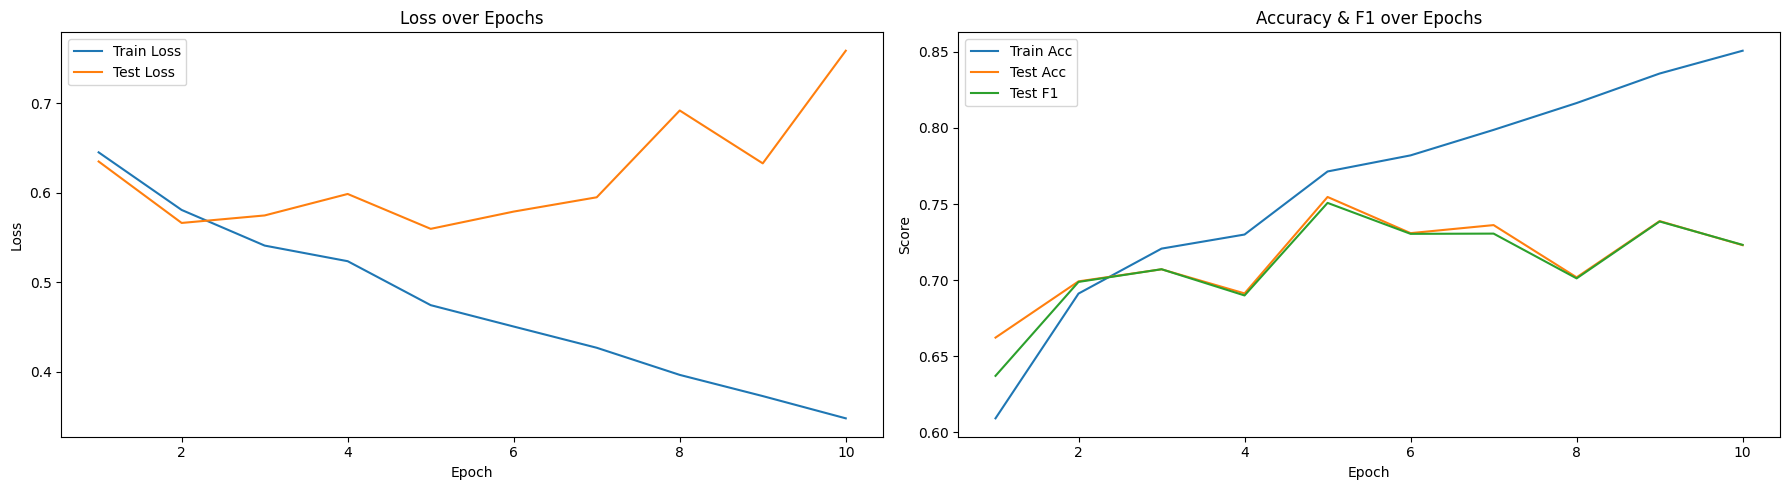

[I 2025-08-05 17:02:29,617] Trial 12 finished with values: [0.7229551451187335, 0.7586156348439823, 0.7231715486738244] and parameters: {'d_model': 128, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.2648385634127064, 'learning_rate': 0.0001, 'batch_size': 32}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  2
num_heads:  4
dropout:  0.2648385634127064
learning rate:  0.0001
batch_szie:  32
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  4
num_heads:  8
dropout:  0.2626723277791292
learning rate:  0.0001
batch_szie:  8


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6242 | Train Acc: 0.6432
Test Loss: 0.6325 | Test Acc: 0.6702
Test Precision: 0.6789
Test Recall: 0.6702
Test ROC AUC Score: 0.6743
Test F1 Score: 0.6694
Test F1 Score: 0.6694


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5597 | Train Acc: 0.7148
Test Loss: 0.6028 | Test Acc: 0.6992
Test Precision: 0.6990
Test Recall: 0.6992
Test ROC AUC Score: 0.6978
Test F1 Score: 0.6991
Test F1 Score: 0.6991


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5124 | Train Acc: 0.7557
Test Loss: 0.5906 | Test Acc: 0.6992
Test Precision: 0.7083
Test Recall: 0.6992
Test ROC AUC Score: 0.6904
Test F1 Score: 0.6918
Test F1 Score: 0.6918


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Epoch 4/10
Train Loss: 0.4817 | Train Acc: 0.7815
Test Loss: 0.6557 | Test Acc: 0.6966
Test Precision: 0.7101
Test Recall: 0.6966
Test ROC AUC Score: 0.7020
Test F1 Score: 0.6950
Test F1 Score: 0.6950


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4491 | Train Acc: 0.7982
Test Loss: 0.6940 | Test Acc: 0.7098
Test Precision: 0.7349
Test Recall: 0.7098
Test ROC AUC Score: 0.6978
Test F1 Score: 0.6965
Test F1 Score: 0.6965


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4283 | Train Acc: 0.8167
Test Loss: 0.7410 | Test Acc: 0.6939
Test Precision: 0.7429
Test Recall: 0.6939
Test ROC AUC Score: 0.6783
Test F1 Score: 0.6701
Test F1 Score: 0.6701


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.4021 | Train Acc: 0.8388
Test Loss: 0.7816 | Test Acc: 0.7018
Test Precision: 0.7036
Test Recall: 0.7018
Test ROC AUC Score: 0.7025
Test F1 Score: 0.7021
Test F1 Score: 0.7021


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Epoch 8/10
Train Loss: 0.3867 | Train Acc: 0.8419
Test Loss: 0.7099 | Test Acc: 0.7124
Test Precision: 0.7137
Test Recall: 0.7124
Test ROC AUC Score: 0.7128
Test F1 Score: 0.7127
Test F1 Score: 0.7127
Model may be overfitting, time to early stop: 


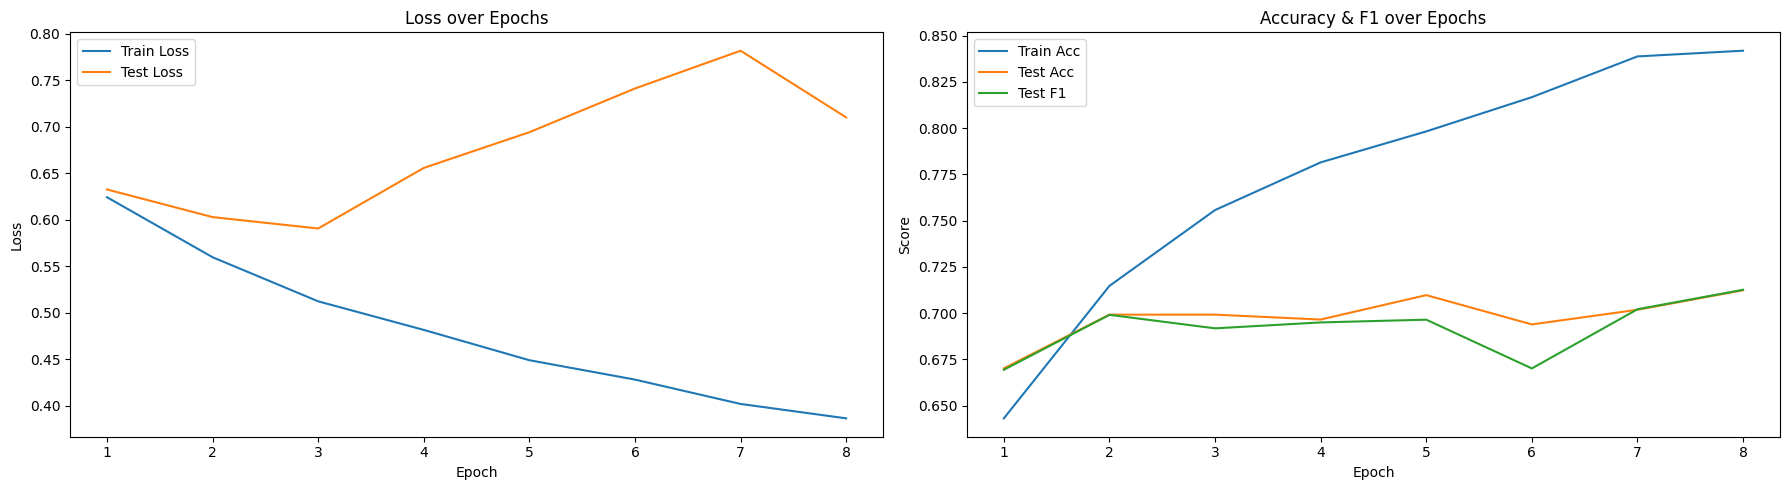

[I 2025-08-05 17:28:34,956] Trial 13 finished with values: [0.712401055408971, 0.7099449962259597, 0.7126536781355802] and parameters: {'d_model': 64, 'num_layers': 4, 'num_heads': 8, 'dropout': 0.2626723277791292, 'learning_rate': 0.0001, 'batch_size': 8}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  4
num_heads:  8
dropout:  0.2626723277791292
learning rate:  0.0001
batch_szie:  8
num_epochs:  0
Parameters chosen for this trial: 
d_model:  128
num_layers:  5
num_heads:  8
dropout:  0.24220681602002925
learning rate:  0.0001
batch_szie:  32


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6303 | Train Acc: 0.6394
Test Loss: 0.6230 | Test Acc: 0.6623
Test Precision: 0.6621
Test Recall: 0.6623
Test ROC AUC Score: 0.6607
Test F1 Score: 0.6622
Test F1 Score: 0.6622


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5553 | Train Acc: 0.7150
Test Loss: 0.5797 | Test Acc: 0.6939
Test Precision: 0.6981
Test Recall: 0.6939
Test ROC AUC Score: 0.6960
Test F1 Score: 0.6941
Test F1 Score: 0.6941


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.4937 | Train Acc: 0.7597
Test Loss: 0.5810 | Test Acc: 0.6913
Test Precision: 0.6916
Test Recall: 0.6913
Test ROC AUC Score: 0.6906
Test F1 Score: 0.6914
Test F1 Score: 0.6914


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.4604 | Train Acc: 0.7846
Test Loss: 0.6016 | Test Acc: 0.7177
Test Precision: 0.7264
Test Recall: 0.7177
Test ROC AUC Score: 0.7216
Test F1 Score: 0.7172
Test F1 Score: 0.7172


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4229 | Train Acc: 0.8040
Test Loss: 0.6202 | Test Acc: 0.7309
Test Precision: 0.7313
Test Recall: 0.7309
Test ROC AUC Score: 0.7305
Test F1 Score: 0.7310
Test F1 Score: 0.7310


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.3571 | Train Acc: 0.8452
Test Loss: 0.6302 | Test Acc: 0.7309
Test Precision: 0.7373
Test Recall: 0.7309
Test ROC AUC Score: 0.7238
Test F1 Score: 0.7264
Test F1 Score: 0.7264


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.3116 | Train Acc: 0.8740
Test Loss: 0.7149 | Test Acc: 0.7203
Test Precision: 0.7200
Test Recall: 0.7203
Test ROC AUC Score: 0.7177
Test F1 Score: 0.7197
Test F1 Score: 0.7197
Model may be overfitting, time to early stop: 


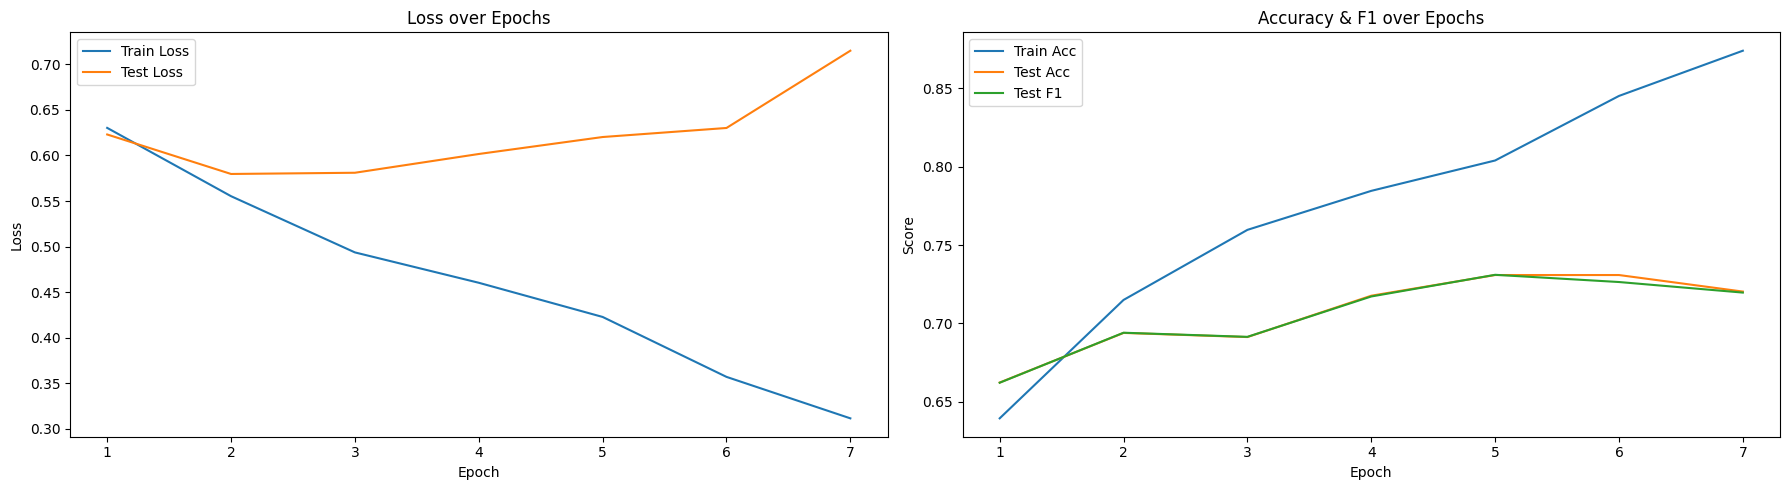

[I 2025-08-05 17:59:57,112] Trial 14 finished with values: [0.7203166226912929, 0.7149301753195106, 0.7196691711331816] and parameters: {'d_model': 128, 'num_layers': 5, 'num_heads': 8, 'dropout': 0.24220681602002925, 'learning_rate': 0.0001, 'batch_size': 32}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  5
num_heads:  8
dropout:  0.24220681602002925
learning rate:  0.0001
batch_szie:  32
num_epochs:  0
Parameters chosen for this trial: 
d_model:  128
num_layers:  8
num_heads:  8
dropout:  0.14519143363724252
learning rate:  0.0001
batch_szie:  32


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6645 | Train Acc: 0.6022
Test Loss: 0.6526 | Test Acc: 0.6570
Test Precision: 0.6604
Test Recall: 0.6570
Test ROC AUC Score: 0.6586
Test F1 Score: 0.6572
Test F1 Score: 0.6572


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5618 | Train Acc: 0.7055
Test Loss: 0.5562 | Test Acc: 0.7361
Test Precision: 0.7763
Test Recall: 0.7361
Test ROC AUC Score: 0.7230
Test F1 Score: 0.7213
Test F1 Score: 0.7213


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.4915 | Train Acc: 0.7692
Test Loss: 0.5776 | Test Acc: 0.7124
Test Precision: 0.7200
Test Recall: 0.7124
Test ROC AUC Score: 0.7044
Test F1 Score: 0.7065
Test F1 Score: 0.7065


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.4456 | Train Acc: 0.8018
Test Loss: 0.5906 | Test Acc: 0.7282
Test Precision: 0.7280
Test Recall: 0.7282
Test ROC AUC Score: 0.7255
Test F1 Score: 0.7275
Test F1 Score: 0.7275


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Epoch 5/10
Train Loss: 0.4243 | Train Acc: 0.8137
Test Loss: 0.6366 | Test Acc: 0.7018
Test Precision: 0.7237
Test Recall: 0.7018
Test ROC AUC Score: 0.7093
Test F1 Score: 0.6985
Test F1 Score: 0.6985


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4103 | Train Acc: 0.8284
Test Loss: 0.6229 | Test Acc: 0.7124
Test Precision: 0.7123
Test Recall: 0.7124
Test ROC AUC Score: 0.7112
Test F1 Score: 0.7124
Test F1 Score: 0.7124


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.3608 | Train Acc: 0.8463
Test Loss: 0.6701 | Test Acc: 0.7124
Test Precision: 0.7122
Test Recall: 0.7124
Test ROC AUC Score: 0.7109
Test F1 Score: 0.7122
Test F1 Score: 0.7122
Model may be overfitting, time to early stop: 


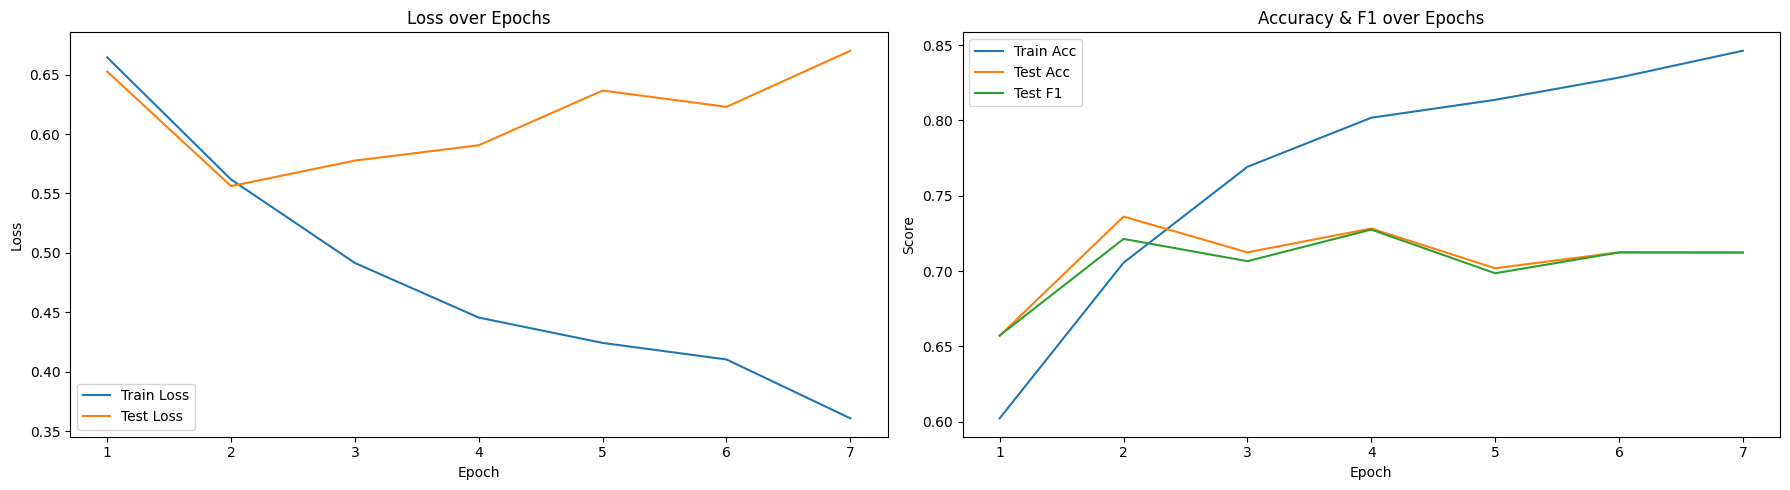

[I 2025-08-05 18:50:12,373] Trial 15 finished with values: [0.712401055408971, 0.6701067797741349, 0.7122441448526943] and parameters: {'d_model': 128, 'num_layers': 8, 'num_heads': 8, 'dropout': 0.14519143363724252, 'learning_rate': 0.0001, 'batch_size': 32}.


Parameters chosen for this trial: 
d_model:  128
num_layers:  8
num_heads:  8
dropout:  0.14519143363724252
learning rate:  0.0001
batch_szie:  32
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  6
num_heads:  4
dropout:  0.16639328500260206
learning rate:  0.0001
batch_szie:  16


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6363 | Train Acc: 0.6267
Test Loss: 0.7345 | Test Acc: 0.6174
Test Precision: 0.7244
Test Recall: 0.6174
Test ROC AUC Score: 0.5943
Test F1 Score: 0.5487
Test F1 Score: 0.5487


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5650 | Train Acc: 0.7101
Test Loss: 0.6327 | Test Acc: 0.6992
Test Precision: 0.7022
Test Recall: 0.6992
Test ROC AUC Score: 0.7007
Test F1 Score: 0.6994
Test F1 Score: 0.6994


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5220 | Train Acc: 0.7381
Test Loss: 0.6430 | Test Acc: 0.6781
Test Precision: 0.7422
Test Recall: 0.6781
Test ROC AUC Score: 0.6605
Test F1 Score: 0.6460
Test F1 Score: 0.6460


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.4939 | Train Acc: 0.7645
Test Loss: 0.5638 | Test Acc: 0.7230
Test Precision: 0.7270
Test Recall: 0.7230
Test ROC AUC Score: 0.7166
Test F1 Score: 0.7193
Test F1 Score: 0.7193


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4665 | Train Acc: 0.7813
Test Loss: 0.5692 | Test Acc: 0.7203
Test Precision: 0.7254
Test Recall: 0.7203
Test ROC AUC Score: 0.7135
Test F1 Score: 0.7161
Test F1 Score: 0.7161


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4339 | Train Acc: 0.8055
Test Loss: 0.6064 | Test Acc: 0.7177
Test Precision: 0.7190
Test Recall: 0.7177
Test ROC AUC Score: 0.7181
Test F1 Score: 0.7179
Test F1 Score: 0.7179


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.4144 | Train Acc: 0.8121
Test Loss: 0.6193 | Test Acc: 0.7388
Test Precision: 0.7385
Test Recall: 0.7388
Test ROC AUC Score: 0.7367
Test F1 Score: 0.7384
Test F1 Score: 0.7384


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.3945 | Train Acc: 0.8297
Test Loss: 0.6227 | Test Acc: 0.7388
Test Precision: 0.7388
Test Recall: 0.7388
Test ROC AUC Score: 0.7357
Test F1 Score: 0.7379
Test F1 Score: 0.7379


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.3814 | Train Acc: 0.8381
Test Loss: 0.6756 | Test Acc: 0.7256
Test Precision: 0.7261
Test Recall: 0.7256
Test ROC AUC Score: 0.7217
Test F1 Score: 0.7242
Test F1 Score: 0.7242
Model may be overfitting, time to early stop: 


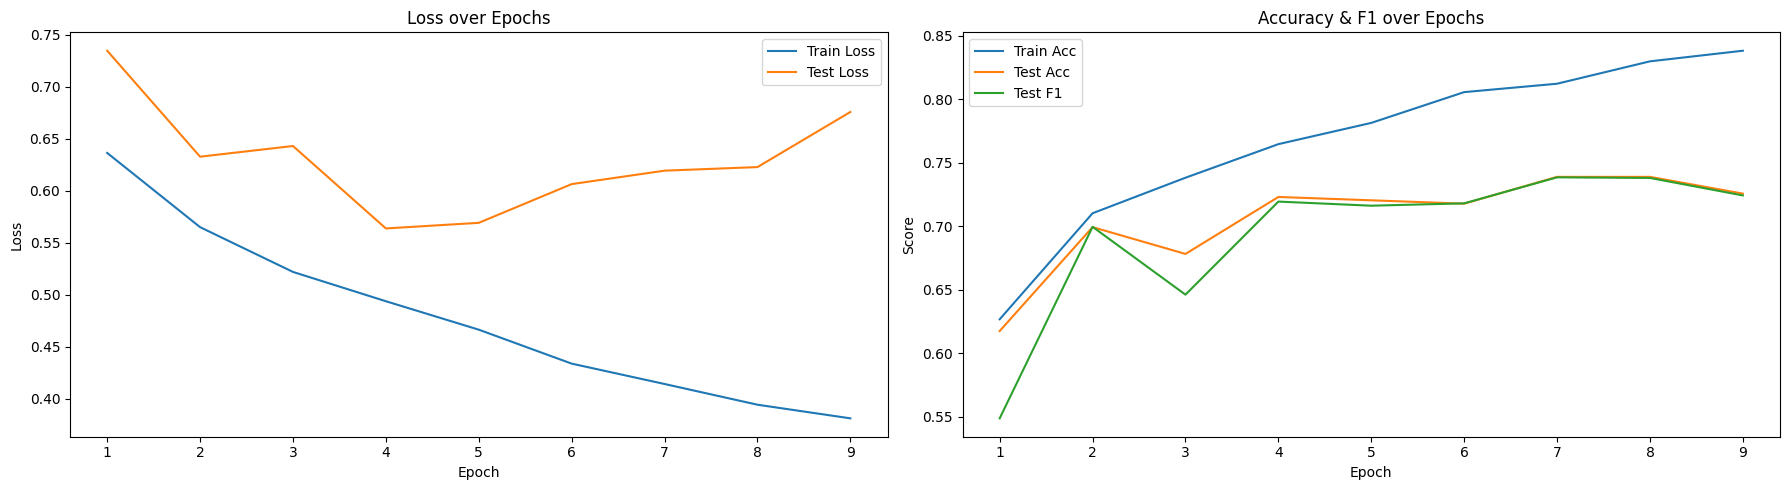

[I 2025-08-05 19:17:37,975] Trial 16 finished with values: [0.7255936675461742, 0.6756463690923826, 0.7241671257502392] and parameters: {'d_model': 64, 'num_layers': 6, 'num_heads': 4, 'dropout': 0.16639328500260206, 'learning_rate': 0.0001, 'batch_size': 16}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  6
num_heads:  4
dropout:  0.16639328500260206
learning rate:  0.0001
batch_szie:  16
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  2
num_heads:  4
dropout:  0.1897340003974428
learning rate:  0.0001
batch_szie:  8


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6366 | Train Acc: 0.6295
Test Loss: 0.5886 | Test Acc: 0.6939
Test Precision: 0.6947
Test Recall: 0.6939
Test ROC AUC Score: 0.6889
Test F1 Score: 0.6915
Test F1 Score: 0.6915


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5513 | Train Acc: 0.7141
Test Loss: 0.6146 | Test Acc: 0.6807
Test Precision: 0.6805
Test Recall: 0.6807
Test ROC AUC Score: 0.6791
Test F1 Score: 0.6806
Test F1 Score: 0.6806


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5126 | Train Acc: 0.7515
Test Loss: 0.5749 | Test Acc: 0.7256
Test Precision: 0.7309
Test Recall: 0.7256
Test ROC AUC Score: 0.7188
Test F1 Score: 0.7214
Test F1 Score: 0.7214


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.4799 | Train Acc: 0.7738
Test Loss: 0.5912 | Test Acc: 0.7124
Test Precision: 0.7300
Test Recall: 0.7124
Test ROC AUC Score: 0.7019
Test F1 Score: 0.7022
Test F1 Score: 0.7022


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4421 | Train Acc: 0.8009
Test Loss: 0.6178 | Test Acc: 0.7256
Test Precision: 0.7254
Test Recall: 0.7256
Test ROC AUC Score: 0.7227
Test F1 Score: 0.7248
Test F1 Score: 0.7248


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4200 | Train Acc: 0.8236
Test Loss: 0.6556 | Test Acc: 0.7388
Test Precision: 0.7452
Test Recall: 0.7388
Test ROC AUC Score: 0.7319
Test F1 Score: 0.7346
Test F1 Score: 0.7346


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.3825 | Train Acc: 0.8363
Test Loss: 0.7197 | Test Acc: 0.7150
Test Precision: 0.7160
Test Recall: 0.7150
Test ROC AUC Score: 0.7105
Test F1 Score: 0.7130
Test F1 Score: 0.7130


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.3503 | Train Acc: 0.8615
Test Loss: 0.9367 | Test Acc: 0.7071
Test Precision: 0.7084
Test Recall: 0.7071
Test ROC AUC Score: 0.7075
Test F1 Score: 0.7074
Test F1 Score: 0.7074
Model may be overfitting, time to early stop: 


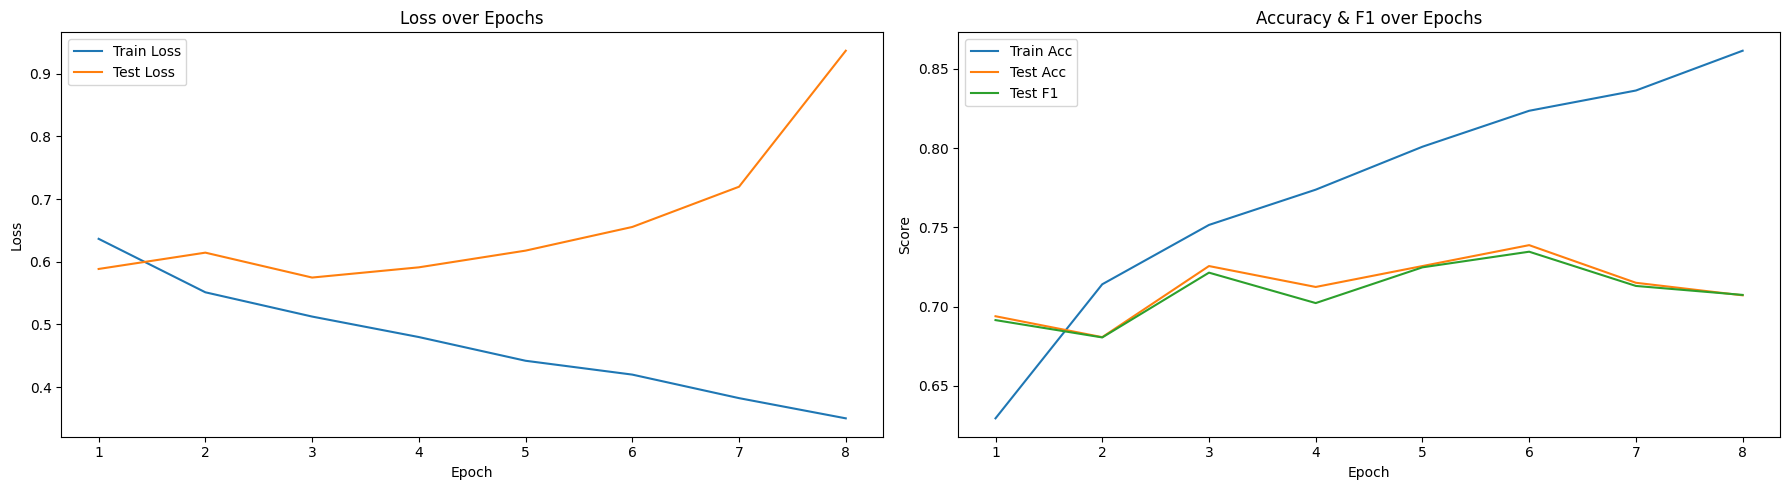

[I 2025-08-05 19:25:58,630] Trial 17 finished with values: [0.7071240105540897, 0.936695485176779, 0.7073812685600863] and parameters: {'d_model': 64, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.1897340003974428, 'learning_rate': 0.0001, 'batch_size': 8}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  2
num_heads:  4
dropout:  0.1897340003974428
learning rate:  0.0001
batch_szie:  8
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  7
num_heads:  8
dropout:  0.2998647880888313
learning rate:  1e-05
batch_szie:  32


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Epoch 1/10
Train Loss: 0.6890 | Train Acc: 0.5247
Test Loss: 0.6769 | Test Acc: 0.5620
Test Precision: 0.6057
Test Recall: 0.5620
Test ROC AUC Score: 0.5771
Test F1 Score: 0.5351
Test F1 Score: 0.5351


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Epoch 2/10
Train Loss: 0.6729 | Train Acc: 0.5718
Test Loss: 0.6613 | Test Acc: 0.5989
Test Precision: 0.6080
Test Recall: 0.5989
Test ROC AUC Score: 0.6036
Test F1 Score: 0.5974
Test F1 Score: 0.5974


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.6554 | Train Acc: 0.6051
Test Loss: 0.6330 | Test Acc: 0.6332
Test Precision: 0.6332
Test Recall: 0.6332
Test ROC AUC Score: 0.6269
Test F1 Score: 0.6289
Test F1 Score: 0.6289


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Epoch 4/10
Train Loss: 0.6334 | Train Acc: 0.6374
Test Loss: 0.6119 | Test Acc: 0.6517
Test Precision: 0.6556
Test Recall: 0.6517
Test ROC AUC Score: 0.6536
Test F1 Score: 0.6519
Test F1 Score: 0.6519


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Epoch 5/10
Train Loss: 0.6113 | Train Acc: 0.6683
Test Loss: 0.5997 | Test Acc: 0.6675
Test Precision: 0.6687
Test Recall: 0.6675
Test ROC AUC Score: 0.6676
Test F1 Score: 0.6678
Test F1 Score: 0.6678


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Epoch 6/10
Train Loss: 0.5983 | Train Acc: 0.6720
Test Loss: 0.5936 | Test Acc: 0.6755
Test Precision: 0.6764
Test Recall: 0.6755
Test ROC AUC Score: 0.6754
Test F1 Score: 0.6757
Test F1 Score: 0.6757


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.5835 | Train Acc: 0.6890
Test Loss: 0.5748 | Test Acc: 0.7177
Test Precision: 0.7238
Test Recall: 0.7177
Test ROC AUC Score: 0.7104
Test F1 Score: 0.7128
Test F1 Score: 0.7128


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.5764 | Train Acc: 0.6877
Test Loss: 0.5762 | Test Acc: 0.7098
Test Precision: 0.7098
Test Recall: 0.7098
Test ROC AUC Score: 0.7061
Test F1 Score: 0.7085
Test F1 Score: 0.7085


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.5700 | Train Acc: 0.6982
Test Loss: 0.5752 | Test Acc: 0.6860
Test Precision: 0.6859
Test Recall: 0.6860
Test ROC AUC Score: 0.6847
Test F1 Score: 0.6860
Test F1 Score: 0.6860


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 10/10
Train Loss: 0.5664 | Train Acc: 0.7004
Test Loss: 0.5680 | Test Acc: 0.7071
Test Precision: 0.7068
Test Recall: 0.7071
Test ROC AUC Score: 0.7052
Test F1 Score: 0.7068
Test F1 Score: 0.7068


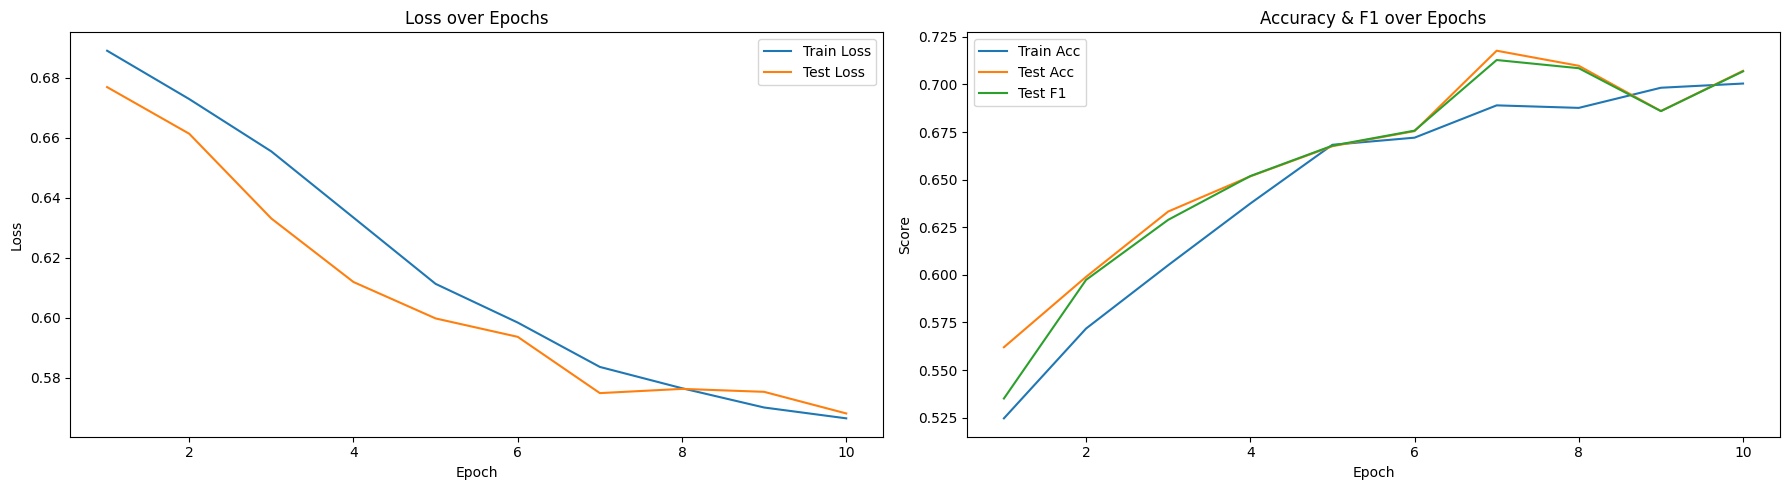

[I 2025-08-05 20:23:18,899] Trial 18 finished with values: [0.7071240105540897, 0.5680326643279486, 0.706836991797414] and parameters: {'d_model': 64, 'num_layers': 7, 'num_heads': 8, 'dropout': 0.2998647880888313, 'learning_rate': 1e-05, 'batch_size': 32}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  7
num_heads:  8
dropout:  0.2998647880888313
learning rate:  1e-05
batch_szie:  32
num_epochs:  0
Parameters chosen for this trial: 
d_model:  64
num_layers:  3
num_heads:  8
dropout:  0.15582852335254344
learning rate:  0.0001
batch_szie:  16


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 1/10
Train Loss: 0.6327 | Train Acc: 0.6392
Test Loss: 0.5877 | Test Acc: 0.6913
Test Precision: 0.6911
Test Recall: 0.6913
Test ROC AUC Score: 0.6874
Test F1 Score: 0.6898
Test F1 Score: 0.6898


Train labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/10
Train Loss: 0.5526 | Train Acc: 0.7236
Test Loss: 0.5952 | Test Acc: 0.6728
Test Precision: 0.6749
Test Recall: 0.6728
Test ROC AUC Score: 0.6661
Test F1 Score: 0.6683
Test F1 Score: 0.6683


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/10
Train Loss: 0.5251 | Train Acc: 0.7352
Test Loss: 0.5714 | Test Acc: 0.7124
Test Precision: 0.7121
Test Recall: 0.7124
Test ROC AUC Score: 0.7096
Test F1 Score: 0.7116
Test F1 Score: 0.7116


Train labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/10
Train Loss: 0.4859 | Train Acc: 0.7707
Test Loss: 0.5582 | Test Acc: 0.7335
Test Precision: 0.7397
Test Recall: 0.7335
Test ROC AUC Score: 0.7266
Test F1 Score: 0.7293
Test F1 Score: 0.7293


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/10
Train Loss: 0.4534 | Train Acc: 0.7921
Test Loss: 0.5656 | Test Acc: 0.7309
Test Precision: 0.7349
Test Recall: 0.7309
Test ROC AUC Score: 0.7247
Test F1 Score: 0.7275
Test F1 Score: 0.7275


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 6/10
Train Loss: 0.4187 | Train Acc: 0.8093
Test Loss: 0.5757 | Test Acc: 0.7309
Test Precision: 0.7309
Test Recall: 0.7309
Test ROC AUC Score: 0.7276
Test F1 Score: 0.7299
Test F1 Score: 0.7299


Train labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 7/10
Train Loss: 0.3772 | Train Acc: 0.8344
Test Loss: 0.5912 | Test Acc: 0.7493
Test Precision: 0.7545
Test Recall: 0.7493
Test ROC AUC Score: 0.7431
Test F1 Score: 0.7460
Test F1 Score: 0.7460


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 8/10
Train Loss: 0.3448 | Train Acc: 0.8564
Test Loss: 0.6277 | Test Acc: 0.7256
Test Precision: 0.7271
Test Recall: 0.7256
Test ROC AUC Score: 0.7262
Test F1 Score: 0.7258
Test F1 Score: 0.7258


Train labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 9/10
Train Loss: 0.3151 | Train Acc: 0.8663
Test Loss: 0.7116 | Test Acc: 0.7335
Test Precision: 0.7332
Test Recall: 0.7335
Test ROC AUC Score: 0.7317
Test F1 Score: 0.7332
Test F1 Score: 0.7332
Model may be overfitting, time to early stop: 


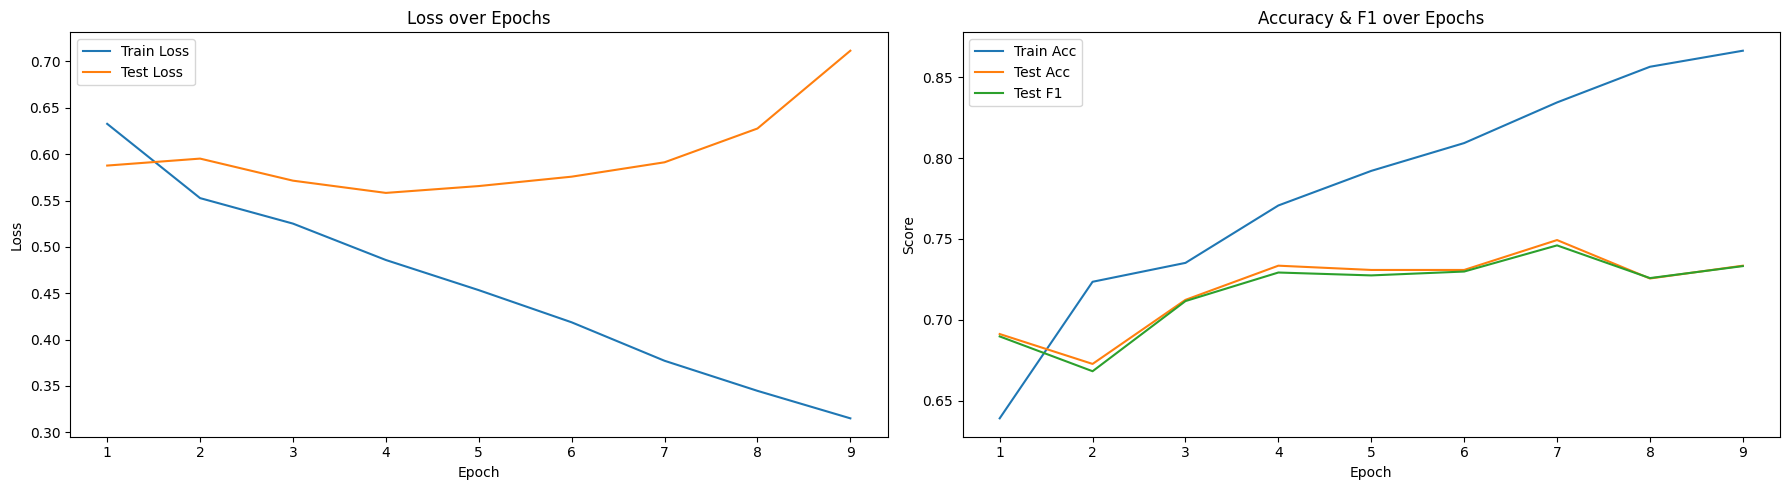

[I 2025-08-05 20:45:21,975] Trial 19 finished with values: [0.7335092348284961, 0.7115694718499297, 0.7332480736174667] and parameters: {'d_model': 64, 'num_layers': 3, 'num_heads': 8, 'dropout': 0.15582852335254344, 'learning_rate': 0.0001, 'batch_size': 16}.


Parameters chosen for this trial: 
d_model:  64
num_layers:  3
num_heads:  8
dropout:  0.15582852335254344
learning rate:  0.0001
batch_szie:  16
num_epochs:  0
Test Accuracy: 0.7309, Test Loss: 0.5583, Test F1 Score: 0.7272
Test Accuracy: 0.6675, Test Loss: 0.5974, Test F1 Score: 0.6666
Test Accuracy: 0.6359, Test Loss: 1.0859, Test F1 Score: 0.6225
Test Accuracy: 0.7177, Test Loss: 1.0907, Test F1 Score: 0.7178
Test Accuracy: 0.7177, Test Loss: 0.5753, Test F1 Score: 0.7179
Test Accuracy: 0.7335, Test Loss: 0.6530, Test F1 Score: 0.7336
Test Accuracy: 0.7098, Test Loss: 0.5688, Test F1 Score: 0.7094
Test Accuracy: 0.7150, Test Loss: 0.5666, Test F1 Score: 0.7128
Test Accuracy: 0.7441, Test Loss: 0.6583, Test F1 Score: 0.7442
Test Accuracy: 0.6438, Test Loss: 0.5960, Test F1 Score: 0.6441
Test Accuracy: 0.7546, Test Loss: 0.6136, Test F1 Score: 0.7488
Test Accuracy: 0.7441, Test Loss: 0.6271, Test F1 Score: 0.7430
Test Accuracy: 0.7230, Test Loss: 0.7586, Test F1 Score: 0.7232
Test Ac

In [43]:
def trial_forgery(trial):
    d_model = trial.suggest_categorical("d_model", [64, 128])
    num_layers = trial.suggest_int("num_layers", 2, 8)
    num_heads = trial.suggest_categorical("num_heads", [4, 8])
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    lr = trial.suggest_categorical("learning_rate", [1e-5, 1e-4])
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    train_loader = DataLoader(SignatureEEGDataset(train_input, num_classes), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(SignatureEEGDataset(test_input, num_classes), batch_size=batch_size, shuffle=False)

    print("="*50)
    print("Parameters chosen for this trial: ")
    print("d_model: ", d_model)
    print("num_layers: ", num_layers)
    print("num_heads: ", num_heads)
    print("dropout: ", dropout)
    print("learning rate: ", lr)
    print("batch_szie: ", batch_size)
    print("="*50)

    num_epochs = 10

    model = SignatureEEGTransformer(
        sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
        eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
        d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
        sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len, dropout=dropout
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # weight_decay is for L2 regularization, to prevent overfitting
    loss_fn = nn.CrossEntropyLoss()

    best_loss = float('inf')
    patience = 5
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_labels, train_preds = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
            sign_x_ts = batch['sign_x_ts'].to(device)
            sign_cls_token = batch['sign_cls_token'].to(device)
            sign_attention_mask = batch['sign_attention_mask'].to(device)
            eeg_x_ts = batch['eeg_x_ts'].to(device)
            eeg_cls_token = batch['eeg_cls_token'].to(device)
            eeg_attention_mask = batch['eeg_attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
            loss = loss_fn(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            train_labels.extend(labels.cpu().numpy())
            train_preds.extend(preds.cpu().numpy())
        print("Train labels: ", train_labels[:10])
        print("Pred labels: ", train_preds[:10])

        avg_train_loss = train_loss / len(train_labels)
        train_acc = accuracy_score(train_labels, train_preds)

        model.eval()
        test_loss, test_labels, test_preds = 0, [], []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Epoch {epoch+1} Testing", leave=False):
                sign_x_ts = batch['sign_x_ts'].to(device)
                sign_cls_token = batch['sign_cls_token'].to(device)
                sign_attention_mask = batch['sign_attention_mask'].to(device)
                eeg_x_ts = batch['eeg_x_ts'].to(device)
                eeg_cls_token = batch['eeg_cls_token'].to(device)
                eeg_attention_mask = batch['eeg_attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
                loss = loss_fn(logits, labels)
                test_loss += loss.item() * labels.size(0)
                preds = logits.argmax(dim=1)
                test_labels.extend(labels.cpu().numpy())
                test_preds.extend(preds.cpu().numpy())
        print("Test labels: ", test_labels[:10])
        print("Pred labels: ", test_preds[:10])

        avg_test_loss = test_loss / len(test_labels)
        test_acc = accuracy_score(test_labels, test_preds)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.4f}")
        test_f1_score = f1_score(test_labels, test_preds, average='weighted')
        print(f"Test Precision: {precision_score(test_labels, test_preds, zero_division=0, average='weighted'):.4f}")
        print(f"Test Recall: {recall_score(test_labels, test_preds, zero_division=0, average='weighted'):.4f}")
        roc_auc = roc_auc_score(test_labels, test_preds, multi_class='ovr', average='weighted') if len(set(test_labels)) > 1 else 0.0
        print(f"Test ROC AUC Score: {roc_auc:.4f}")
        print(f"Test F1 Score: {test_f1_score:.4f}")
        print(f"Test F1 Score: {f1_score(test_labels, test_preds, average='weighted'):.4f}")
        print("="*50)

        # Store metrics for plotting
        if epoch == 0:
            history = {
                'train_loss': [],
                'test_loss': [],
                'train_acc': [],
                'test_acc': [],
                'test_f1': []
            }
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(avg_test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['test_f1'].append(f1_score(test_labels, test_preds, average='weighted'))

        if test_loss < best_loss:
            best_loss = test_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Model may be overfitting, time to early stop: ")
                break

    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['test_acc'], label='Test Acc')
    plt.plot(epochs, history['test_f1'], label='Test F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Accuracy & F1 over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("="*50)
    print("Parameters chosen for this trial: ")
    print("d_model: ", d_model)
    print("num_layers: ", num_layers)
    print("num_heads: ", num_heads)
    print("dropout: ", dropout)
    print("learning rate: ", lr)
    print("batch_szie: ", batch_size)
    print("num_epochs: ", num_epochs if num_epochs == len(history) else len(history) - patience)
    print("="*50)

    return test_acc, avg_test_loss, test_f1_score

study = optuna.create_study(directions=['maximize', 'minimize', 'maximize'])
study.optimize(trial_forgery, n_trials=20)

for trial in study.trials:
    print(f"Test Accuracy: {trial.values[0]:.4f}, Test Loss: {trial.values[1]:.4f}, Test F1 Score: {trial.values[2]:.4f}")

In [44]:
for trial in study.trials:
    print(f"Test Accuracy: {trial.values[0]:.4f}, Test Loss: {trial.values[1]:.4f}, Test F1 Score: {trial.values[2]:.4f}, Params: {trial.params}")

Test Accuracy: 0.7309, Test Loss: 0.5583, Test F1 Score: 0.7272, Params: {'d_model': 64, 'num_layers': 3, 'num_heads': 8, 'dropout': 0.10060807868221684, 'learning_rate': 1e-05, 'batch_size': 8}
Test Accuracy: 0.6675, Test Loss: 0.5974, Test F1 Score: 0.6666, Params: {'d_model': 64, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.21990671853588512, 'learning_rate': 1e-05, 'batch_size': 16}
Test Accuracy: 0.6359, Test Loss: 1.0859, Test F1 Score: 0.6225, Params: {'d_model': 128, 'num_layers': 4, 'num_heads': 4, 'dropout': 0.1384424157061829, 'learning_rate': 0.0001, 'batch_size': 16}
Test Accuracy: 0.7177, Test Loss: 1.0907, Test F1 Score: 0.7178, Params: {'d_model': 128, 'num_layers': 4, 'num_heads': 4, 'dropout': 0.22740173282823092, 'learning_rate': 0.0001, 'batch_size': 8}
Test Accuracy: 0.7177, Test Loss: 0.5753, Test F1 Score: 0.7179, Params: {'d_model': 128, 'num_layers': 8, 'num_heads': 8, 'dropout': 0.24894108072179982, 'learning_rate': 0.0001, 'batch_size': 32}
Test Accuracy: 0.

## Training loop

In [35]:
batch_size = 16
d_model = 64
num_classes = 2
num_heads = 8
num_layers = 4
num_epochs = 5
lr = 1e-4
dropout = 0.20510954736890175

train_loader = DataLoader(SignatureEEGDataset(train_input, num_classes), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(SignatureEEGDataset(test_input, num_classes), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(SignatureEEGDataset(val_input, num_classes), batch_size=batch_size, shuffle=False)

Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1)]
Epoch 1/5
Train Loss: 0.6289 | Train Acc: 0.6377
Test Loss: 0.6348 | Test Acc: 0.6306
Test Precision: 0.6579
Test Recall: 0.6306
Test ROC AUC Score: 0.6402
Test F1 Score: 0.6226
Test F1 Score: 0.6226


Train labels:  [np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 2/5
Train Loss: 0.5495 | Train Acc: 0.7196
Test Loss: 0.5865 | Test Acc: 0.6966
Test Precision: 0.7241
Test Recall: 0.6966
Test ROC AUC Score: 0.6837
Test F1 Score: 0.6808
Test F1 Score: 0.6808


Train labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 3/5
Train Loss: 0.4912 | Train Acc: 0.7641
Test Loss: 0.5486 | Test Acc: 0.7256
Test Precision: 0.7276
Test Recall: 0.7256
Test ROC AUC Score: 0.7265
Test F1 Score: 0.7258
Test F1 Score: 0.7258


Train labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 4/5
Train Loss: 0.4601 | Train Acc: 0.7905
Test Loss: 0.5465 | Test Acc: 0.7520
Test Precision: 0.7630
Test Recall: 0.7520
Test ROC AUC Score: 0.7440
Test F1 Score: 0.7467
Test F1 Score: 0.7467


Train labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
Pred labels:  [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1)]


Test labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Pred labels:  [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]
Epoch 5/5
Train Loss: 0.4291 | Train Acc: 0.7991
Test Loss: 0.5463 | Test Acc: 0.7652
Test Precision: 0.7654
Test Recall: 0.7652
Test ROC AUC Score: 0.7622
Test F1 Score: 0.7644
Test F1 Score: 0.7644


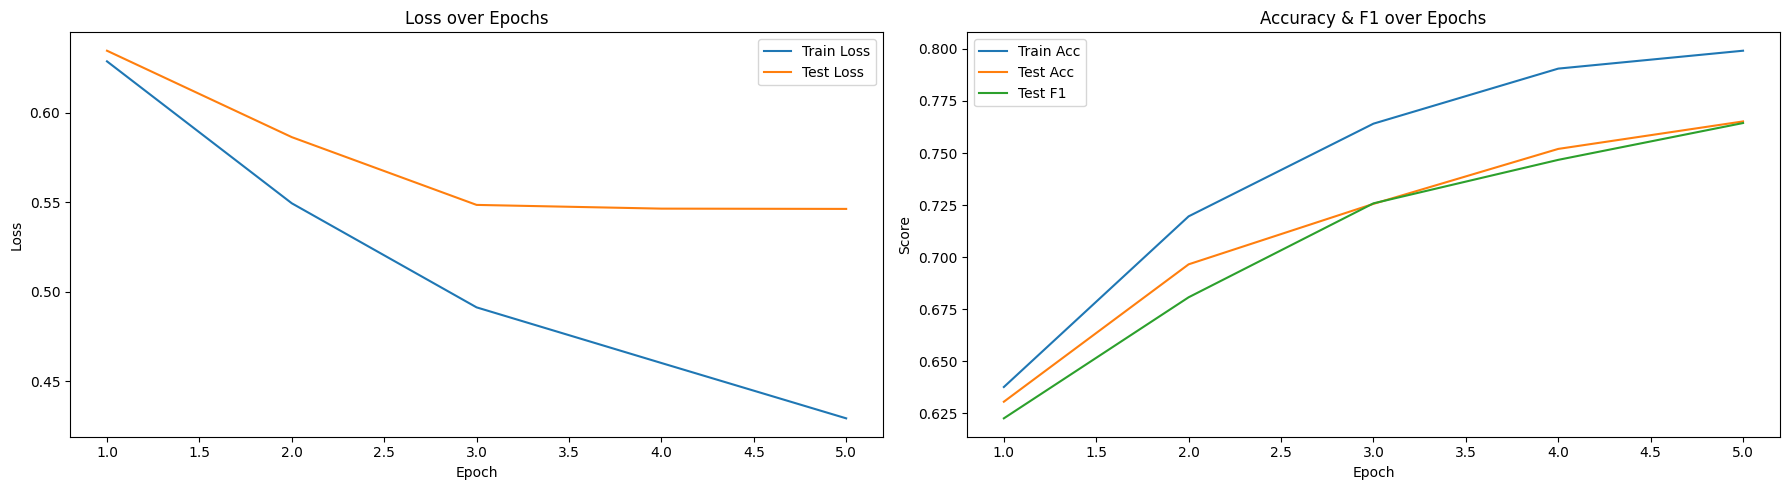

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SignatureEEGTransformer(
    sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
    eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
    d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
    sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # weight_decay is for L2 regularization, to prevent overfitting
loss_fn = nn.CrossEntropyLoss()

best_loss = float('inf')
patience = 3
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_labels, train_preds = 0, [], []
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(preds.cpu().numpy())
    print("Train labels: ", train_labels[:10])
    print("Pred labels: ", train_preds[:10])

    avg_train_loss = train_loss / len(train_labels)
    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    test_loss, test_labels, test_preds = 0, [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1} Testing", leave=False):
            sign_x_ts = batch['sign_x_ts'].to(device)
            sign_cls_token = batch['sign_cls_token'].to(device)
            sign_attention_mask = batch['sign_attention_mask'].to(device)
            eeg_x_ts = batch['eeg_x_ts'].to(device)
            eeg_cls_token = batch['eeg_cls_token'].to(device)
            eeg_attention_mask = batch['eeg_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
            loss = loss_fn(logits, labels)
            test_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())
    print("Test labels: ", test_labels[:10])
    print("Pred labels: ", test_preds[:10])

    avg_test_loss = test_loss / len(test_labels)
    test_acc = accuracy_score(test_labels, test_preds)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.4f}")
    test_f1_score = f1_score(test_labels, test_preds, average='weighted')
    print(f"Test Precision: {precision_score(test_labels, test_preds, zero_division=0, average='weighted'):.4f}")
    print(f"Test Recall: {recall_score(test_labels, test_preds, zero_division=0, average='weighted'):.4f}")
    roc_auc = roc_auc_score(test_labels, test_preds, multi_class='ovr', average='weighted') if len(set(test_labels)) > 1 else 0.0
    print(f"Test ROC AUC Score: {roc_auc:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test F1 Score: {f1_score(test_labels, test_preds, average='weighted'):.4f}")

    # Store metrics for plotting
    if epoch == 0:
        history = {
            'train_loss': [],
            'test_loss': [],
            'train_acc': [],
            'test_acc': [],
            'test_f1': []
        }
    history['train_loss'].append(avg_train_loss)
    history['test_loss'].append(avg_test_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    history['test_f1'].append(f1_score(test_labels, test_preds, average='weighted'))

    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Model may be overfitting, time to early stop: ")
            break

epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['test_acc'], label='Test Acc')
plt.plot(epochs, history['test_f1'], label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy & F1 over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), os.path.join(os.getenv("MODEL_SAVE_PATH", f"forgery_model{datetime.now().strftime('%m%d%Y-%H%M%S')}.pth")))

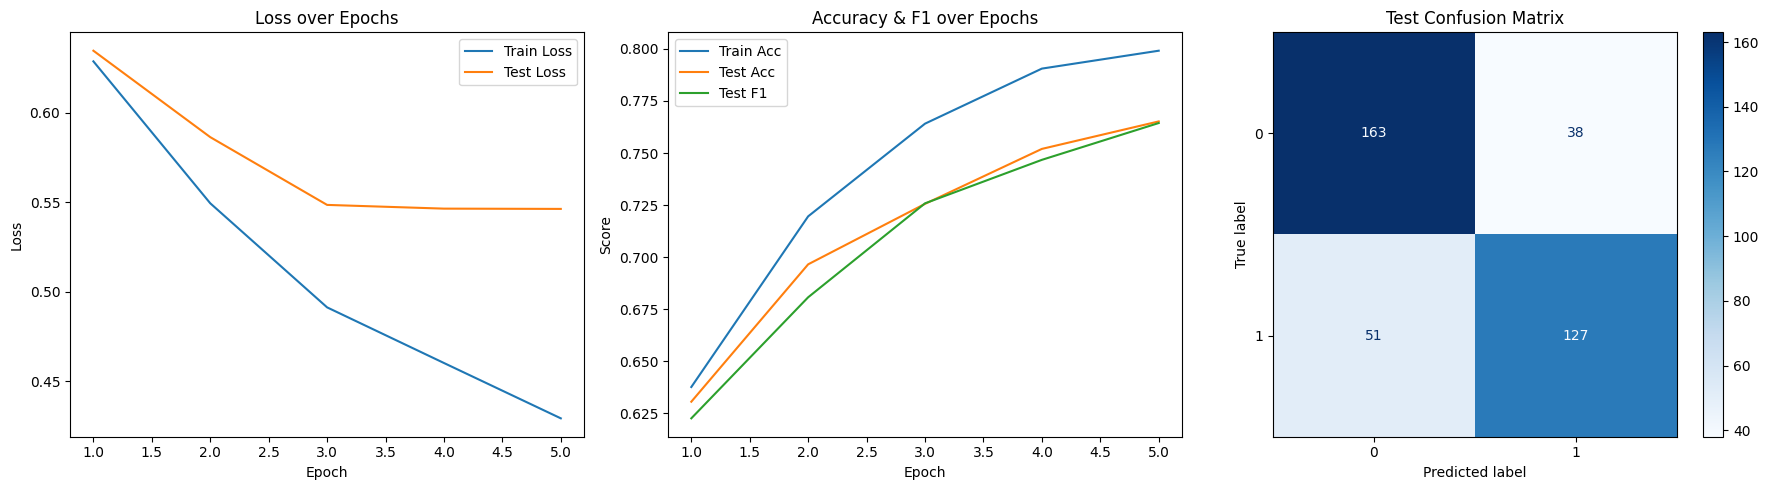

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['test_acc'], label='Test Acc')
plt.plot(epochs, history['test_f1'], label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy & F1 over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, cmap='Blues', ax=plt.gca())
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

In [48]:
print(history)

{'train_loss': [0.6005392286220836, 0.5264097286478538, 0.48366457995864265, 0.4409392431181433, 0.4017635018289877, 0.3506971618677551, 0.31721809665274514], 'test_loss': [0.590187401758964, 0.5753042487167117, 0.6051860453270985, 0.5745368429255674, 0.5547184894613352, 0.5884504348118261, 0.698713957319788], 'train_acc': [0.6671806167400881, 0.7403083700440528, 0.7698237885462555, 0.8002202643171806, 0.8237885462555066, 0.8482378854625551, 0.8674008810572688], 'test_acc': [0.6965699208443272, 0.7282321899736148, 0.7018469656992085, 0.7493403693931399, 0.7546174142480211, 0.7546174142480211, 0.7387862796833773], 'test_f1': [0.6965190186537165, 0.7280839166956651, 0.6878455049348668, 0.749378890121245, 0.7545762498677882, 0.75425640834917, 0.7306397887003063]}


## Model Validation

Validation Loss: 0.4963
Validation Accuracy: 0.7804
Validation Precision: 0.7861
Validation Recall: 0.7812
Validation F1 Score: 0.7796


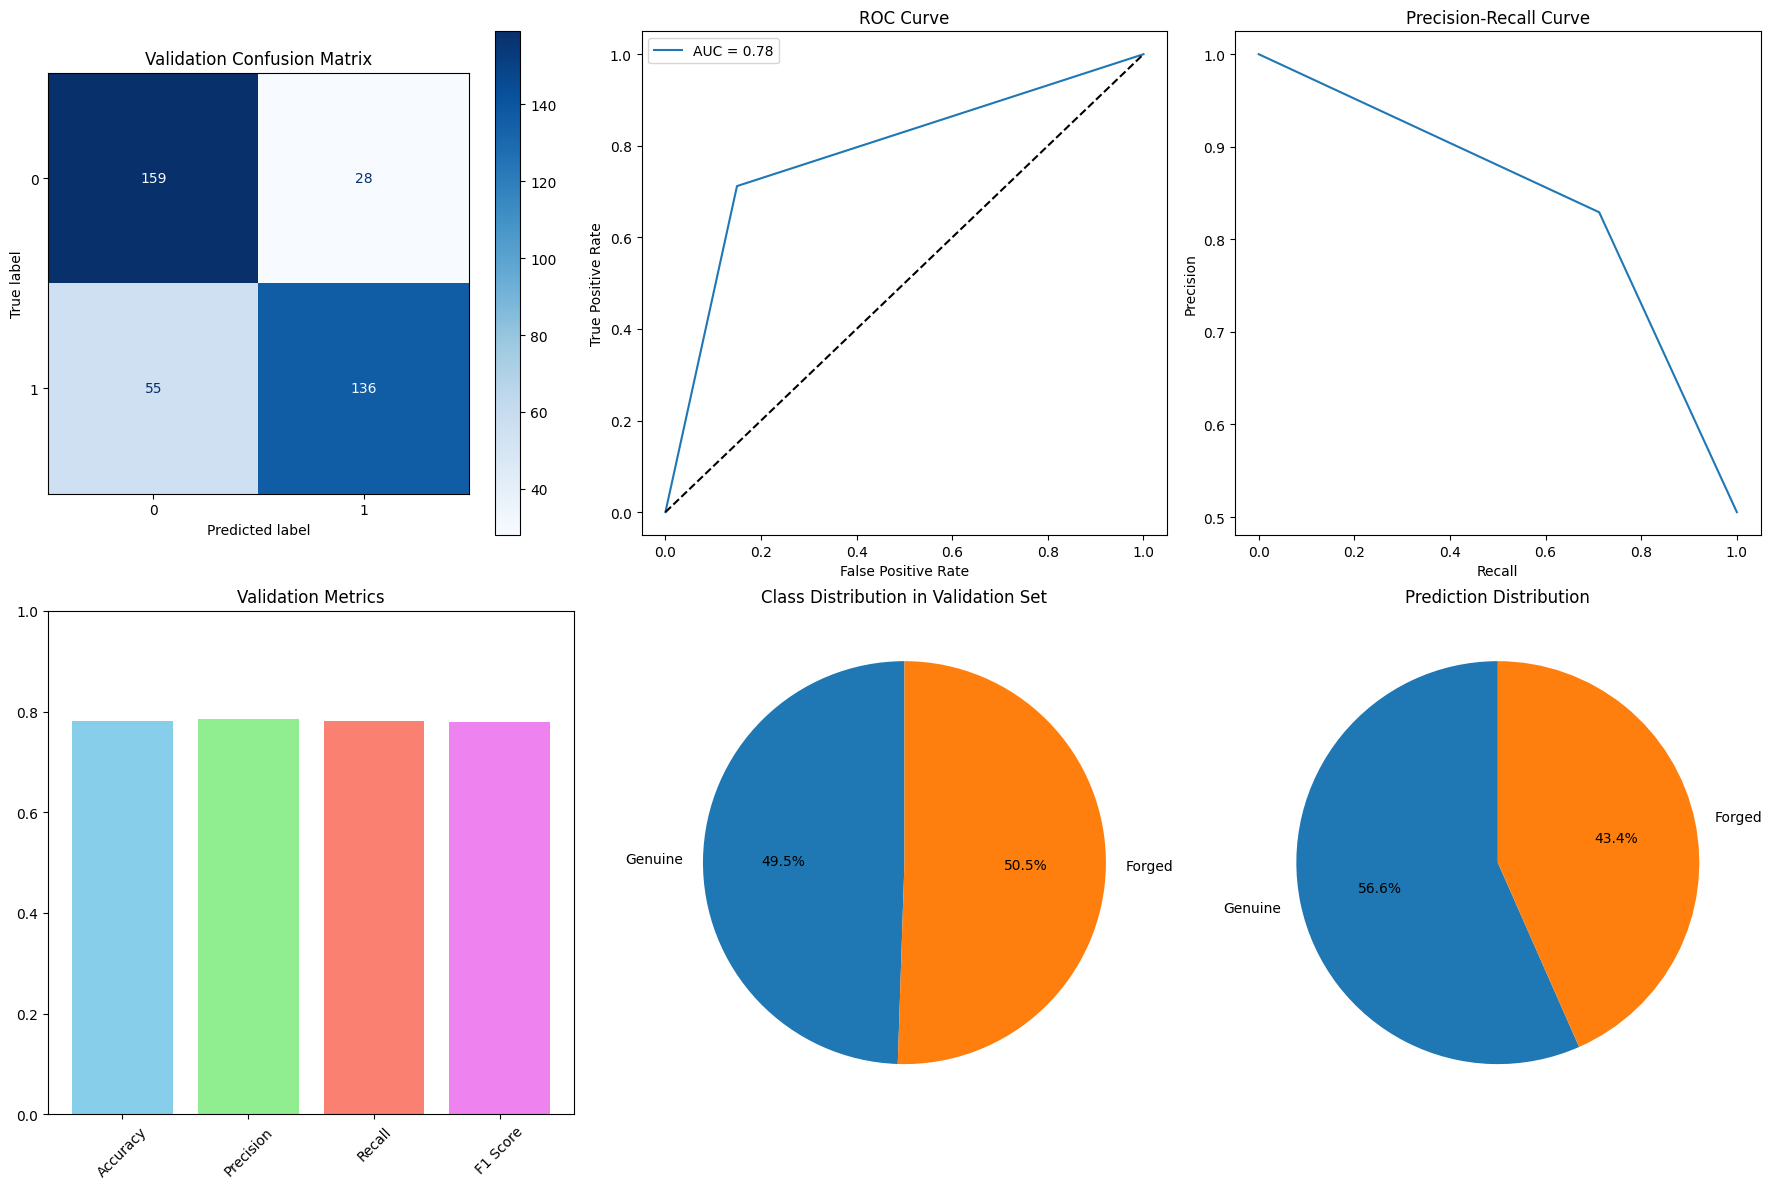

              precision    recall  f1-score   support

     Genuine       0.74      0.85      0.79       187
     Forgery       0.83      0.71      0.77       191

    accuracy                           0.78       378
   macro avg       0.79      0.78      0.78       378
weighted avg       0.79      0.78      0.78       378



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SignatureEEGTransformer(
    sign_input_dim=sign_ts_dim, sign_cls_dim=sign_cls_dim,
    eeg_input_dim=eeg_ts_dim, eeg_cls_dim=eeg_cls_dim,
    d_model=d_model, num_classes=num_classes, num_heads=num_heads, num_layers=num_layers,
    sign_max_seq_len=sign_seq_len, eeg_max_seq_len=eeg_seq_len
).to(device)
model.load_state_dict(torch.load(os.path.join(os.getenv("MODEL_LOAD_PATH"), f"forgery_model08052025-223814.pth")))
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # weight_decay is for L2 regularization, to prevent overfitting
loss_fn = nn.CrossEntropyLoss()
model.eval()
val_loss = 0
val_labels = []
val_preds = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation", leave=False):
        sign_x_ts = batch['sign_x_ts'].to(device)
        sign_cls_token = batch['sign_cls_token'].to(device)
        sign_attention_mask = batch['sign_attention_mask'].to(device)
        eeg_x_ts = batch['eeg_x_ts'].to(device)
        eeg_cls_token = batch['eeg_cls_token'].to(device)
        eeg_attention_mask = batch['eeg_attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(sign_x_ts, sign_cls_token, eeg_x_ts, eeg_cls_token, sign_attention_mask, eeg_attention_mask)
        loss = loss_fn(logits, labels)
        val_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())

avg_val_loss = val_loss / len(val_labels)
val_acc = accuracy_score(val_labels, val_preds)
val_prec = precision_score(val_labels, val_preds, zero_division=0, average='macro')
val_rec = recall_score(val_labels, val_preds, zero_division=0, average='macro')
val_f1 = f1_score(val_labels, val_preds, zero_division=0, average='macro')

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_prec:.4f}")
print(f"Validation Recall: {val_rec:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

ConfusionMatrixDisplay.from_predictions(val_labels, val_preds, cmap='Blues', ax=axes[0,0])
axes[0,0].set_title("Validation Confusion Matrix")

fpr, tpr, _ = roc_curve(val_labels, val_preds)
auc = roc_auc_score(val_labels, val_preds)
axes[0,1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
axes[0,1].plot([0,1], [0,1], 'k--')
axes[0,1].set_xlabel("False Positive Rate")
axes[0,1].set_ylabel("True Positive Rate")
axes[0,1].set_title("ROC Curve")
axes[0,1].legend()

precision, recall, _ = precision_recall_curve(val_labels, val_preds)
axes[0,2].plot(recall, precision)
axes[0,2].set_xlabel("Recall")
axes[0,2].set_ylabel("Precision")
axes[0,2].set_title("Precision-Recall Curve")

metrics = [val_acc, val_prec, val_rec, val_f1]
names = ["Accuracy", "Precision", "Recall", "F1 Score"]
axes[1,0].bar(names, metrics, color=['skyblue', 'lightgreen', 'salmon', 'violet'])
axes[1,0].set_ylim(0, 1)
axes[1,0].set_title("Validation Metrics")
axes[1,0].tick_params(axis='x', rotation=45)

unique_labels, counts = np.unique(val_labels, return_counts=True)
label_names = ['Genuine', 'Forged']
axes[1,1].pie(counts, labels=label_names, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title("Class Distribution in Validation Set")

unique_preds, pred_counts = np.unique(val_preds, return_counts=True)
pred_names = ['Genuine', 'Forged']
axes[1,2].pie(pred_counts, labels=pred_names, autopct='%1.1f%%', startangle=90)
axes[1,2].set_title("Prediction Distribution")

plt.tight_layout()
plt.show()

print(classification_report(val_labels, val_preds, target_names=['Genuine', 'Forgery']))


## User Identification - Feature ranking

Preparing data for SHAP analysis...
Sign features: 15, EEG features: 11
Total features: 26
Creating SHAP explainer...
Calculating SHAP values...


PermutationExplainer explainer: 31it [01:12,  2.58s/it]
/tmp/ipython-input-2471214783.py:105: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, 0], shap_data[:30],


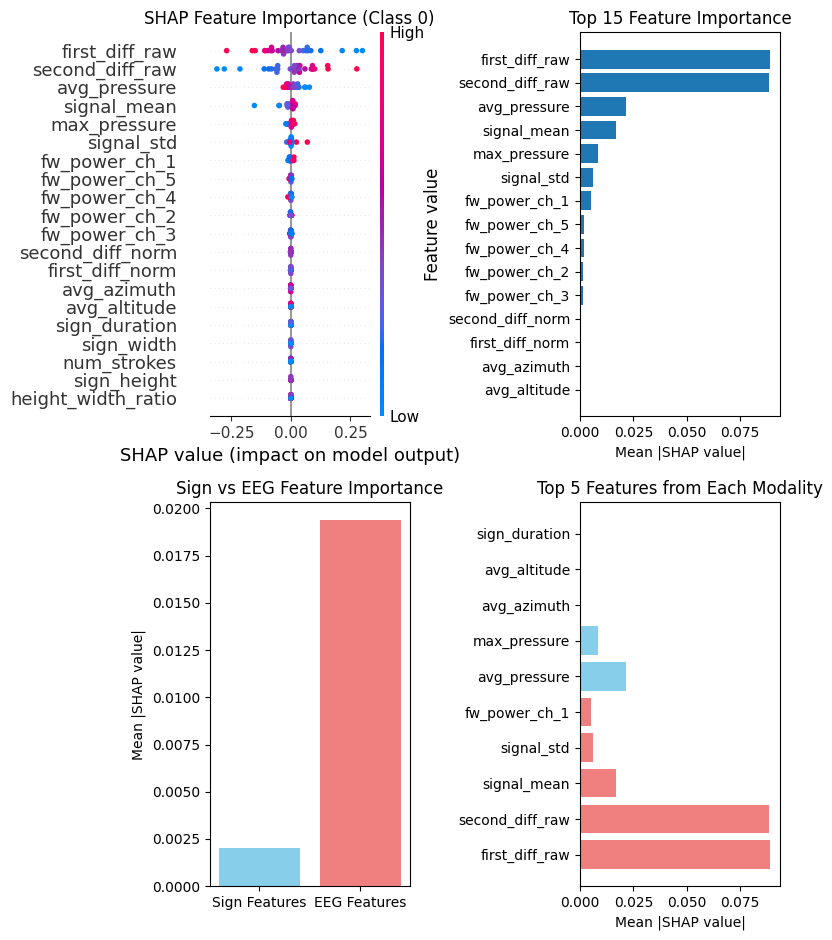


FEATURE IMPORTANCE ANALYSIS

Overall Feature Ranking:
 1. first_diff_raw            | 0.089226 | EEG
 2. second_diff_raw           | 0.088672 | EEG
 3. avg_pressure              | 0.021503 | Sign
 4. signal_mean               | 0.017073 | EEG
 5. max_pressure              | 0.008553 | Sign
 6. signal_std                | 0.005961 | EEG
 7. fw_power_ch_1             | 0.005240 | EEG
 8. fw_power_ch_5             | 0.001801 | EEG
 9. fw_power_ch_4             | 0.001671 | EEG
10. fw_power_ch_2             | 0.001485 | EEG
11. fw_power_ch_3             | 0.001234 | EEG
12. second_diff_norm          | 0.000378 | EEG
13. first_diff_norm           | 0.000301 | EEG
14. avg_azimuth               | 0.000216 | Sign
15. avg_altitude              | 0.000118 | Sign
16. sign_duration             | 0.000002 | Sign
17. sign_width                | 0.000000 | Sign
18. num_strokes               | 0.000000 | Sign
19. sign_height               | 0.000000 | Sign
20. height_width_ratio        | 0.000000 | S

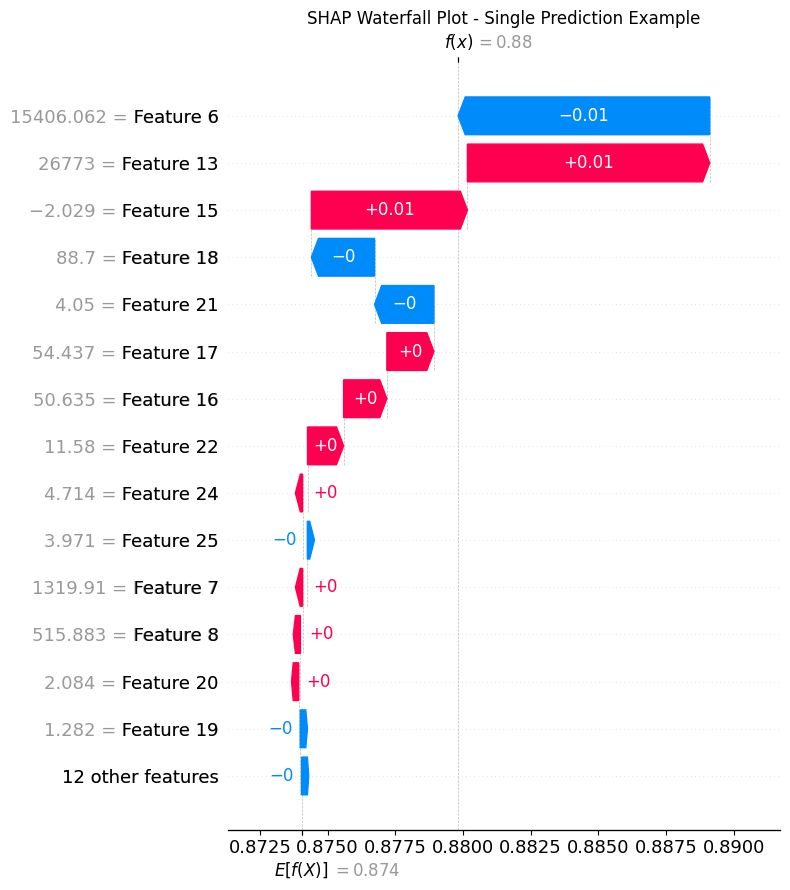

In [ ]:

class SHAPModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()

    def predict(self, X):

        batch_size = X.shape[0]

        sign_cls_tokens = torch.tensor(X[:, :sign_cls_dim], dtype=torch.float32).to(self.device)
        eeg_cls_tokens = torch.tensor(X[:, sign_cls_dim:], dtype=torch.float32).to(self.device)

        sign_x_ts = torch.zeros((batch_size, sign_seq_len, sign_ts_dim), dtype=torch.float32).to(self.device)
        eeg_x_ts = torch.zeros((batch_size, eeg_seq_len, eeg_ts_dim), dtype=torch.float32).to(self.device)

        sign_attention_mask = torch.zeros((batch_size, sign_seq_len + 1), dtype=torch.float32).to(self.device)
        sign_attention_mask[:, 0] = 1  # CLS token is always attended to
        eeg_attention_mask = torch.zeros((batch_size, eeg_seq_len + 1), dtype=torch.float32).to(self.device)
        eeg_attention_mask[:, 0] = 1   # CLS token is always attended to

        with torch.no_grad():
            logits = self.model(sign_x_ts, sign_cls_tokens, eeg_x_ts, eeg_cls_tokens,
                              sign_attention_mask, eeg_attention_mask)
            probabilities = torch.softmax(logits, dim=1)

        return probabilities.cpu().numpy()

def prepare_shap_data(dataset, max_samples=200):
    sign_cls_features = []
    eeg_cls_features = []
    labels = []

    indices = np.random.choice(len(dataset), min(max_samples, len(dataset)), replace=False)

    for idx in indices:
        sample = dataset[idx]
        sign_cls_features.append(sample['sign_cls_token'].numpy())
        eeg_cls_features.append(sample['eeg_cls_token'].numpy())
        labels.append(sample['labels'])

    sign_cls_features = np.array(sign_cls_features)
    eeg_cls_features = np.array(eeg_cls_features)
    combined_features = np.concatenate([sign_cls_features, eeg_cls_features], axis=1)

    return combined_features, np.array(labels), sign_cls_features.shape[1], eeg_cls_features.shape[1]

def create_feature_names():
    sign_feature_names = [
        'num_strokes', 'sign_height', 'sign_width', 'height_width_ratio',
        'centroid_x', 'centroid_y', 'avg_pressure', 'avg_azimuth', 'avg_altitude',
        'avg_vx', 'avg_vy', 'avg_ax', 'avg_ay', 'max_pressure', 'sign_duration'
    ]

    eeg_feature_names = [
        'signal_mean', 'signal_std', 'first_diff_raw', 'second_diff_raw',
        'first_diff_norm', 'second_diff_norm'
    ]

    num_eeg_channels = eeg_cls_dim - 6  # Subtract the 6 basic features
    for i in range(num_eeg_channels):
        eeg_feature_names.append(f'fw_power_ch_{i+1}')

    return sign_feature_names + eeg_feature_names

print("Preparing data for SHAP analysis...")
shap_data, shap_labels, sign_feat_count, eeg_feat_count = prepare_shap_data(SignatureEEGDataset(val_input, num_classes), max_samples=100)
feature_names = create_feature_names()

print(f"Sign features: {sign_feat_count}, EEG features: {eeg_feat_count}")
print(f"Total features: {len(feature_names)}")

model_wrapper = SHAPModelWrapper(model, device)

print("Creating SHAP explainer...")
explainer = shap.Explainer(model_wrapper.predict, shap_data[:50])  # Use subset as background

print("Calculating SHAP values...")
shap_values = explainer(shap_data[:30])  # Analyze subset for computational efficiency

plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
shap.summary_plot(shap_values.values[:, :, 0], shap_data[:30],
                  feature_names=feature_names, show=False, max_display=20)
plt.title('SHAP Feature Importance (Class 0)')

plt.subplot(2, 2, 2)
mean_shap_values = np.mean(np.abs(shap_values.values[:, :, 0]), axis=0)
feature_importance = list(zip(feature_names, mean_shap_values))
feature_importance.sort(key=lambda x: x[1], reverse=True)

top_features = feature_importance[:15]
features, importances = zip(*top_features)

plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel('Mean |SHAP value|')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()

plt.subplot(2, 2, 3)
sign_importances = mean_shap_values[:sign_feat_count]
eeg_importances = mean_shap_values[sign_feat_count:]

categories = ['Sign Features', 'EEG Features']
category_importances = [np.mean(sign_importances), np.mean(eeg_importances)]

plt.bar(categories, category_importances, color=['skyblue', 'lightcoral'])
plt.ylabel('Mean |SHAP value|')
plt.title('Sign vs EEG Feature Importance')

plt.subplot(2, 2, 4)
top_sign_idx = np.argsort(sign_importances)[-5:]
top_eeg_idx = np.argsort(eeg_importances)[-5:] + sign_feat_count

top_sign_features = [feature_names[i] for i in top_sign_idx]
top_eeg_features = [feature_names[i] for i in top_eeg_idx]

all_top_features = top_sign_features + top_eeg_features
all_top_importances = [mean_shap_values[i] for i in top_sign_idx] + [mean_shap_values[i] for i in top_eeg_idx]
colors = ['skyblue'] * 5 + ['lightcoral'] * 5

plt.barh(range(len(all_top_features)), all_top_importances, color=colors)
plt.yticks(range(len(all_top_features)), all_top_features)
plt.xlabel('Mean |SHAP value|')
plt.title('Top 5 Features from Each Modality')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

print(f"\nOverall Feature Ranking:")
for i, (feature, importance) in enumerate(feature_importance[:20]):
    modality = "Sign" if feature in feature_names[:sign_feat_count] else "EEG"
    print(f"{i+1:2d}. {feature:25s} | {importance:.6f} | {modality}")

print(f"\nSign Features (Average importance: {np.mean(sign_importances):.6f}):")
sign_ranking = [(feature_names[i], sign_importances[i]) for i in range(sign_feat_count)]
sign_ranking.sort(key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(sign_ranking[:10]):
    print(f"{i+1:2d}. {feature:25s} | {importance:.6f}")

print(f"\nEEG Features (Average importance: {np.mean(eeg_importances):.6f}):")
eeg_ranking = [(feature_names[i], eeg_importances[i-sign_feat_count]) for i in range(sign_feat_count, len(feature_names))]
eeg_ranking.sort(key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(eeg_ranking[:10]):
    print(f"{i+1:2d}. {feature:25s} | {importance:.6f}")

if len(shap_values.values) > 0:
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(shap_values[0, :, 0], max_display=15, show=False)
    plt.title('SHAP Waterfall Plot - Single Prediction Example')
    plt.tight_layout()
    plt.show()